In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

# Example-01: Twiss from amplitude data

In [3]:
# In this example uncoupled twiss beta function values are estimated from amplitude data
# Signals are generated using exact model with random noise added on top
# In this case resulting errors are due to the noise alone

# Given the TbT data, the main frequency and corresponding parameters (amplitudes and phases) are estimated for x & y planes
# Amplitude data is used to estimate twiss values
# Model twiss values are used to estimate action at each monitor location
# Total action is estimated using actions from all monitors with optional outlier filtering

# Alternatively, mesured twiss (e.g. from phase) can be used to estimate actions
# Or measured actions can be used directly

In [4]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [5]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883169, sigma_nux=6.62112728e-07, error_nux=7.01623541e-08

(ax - ref_ax).abs().sum().item()=0.000107215425

(fx - ref_fx).abs().sum().item()=0.0406821289



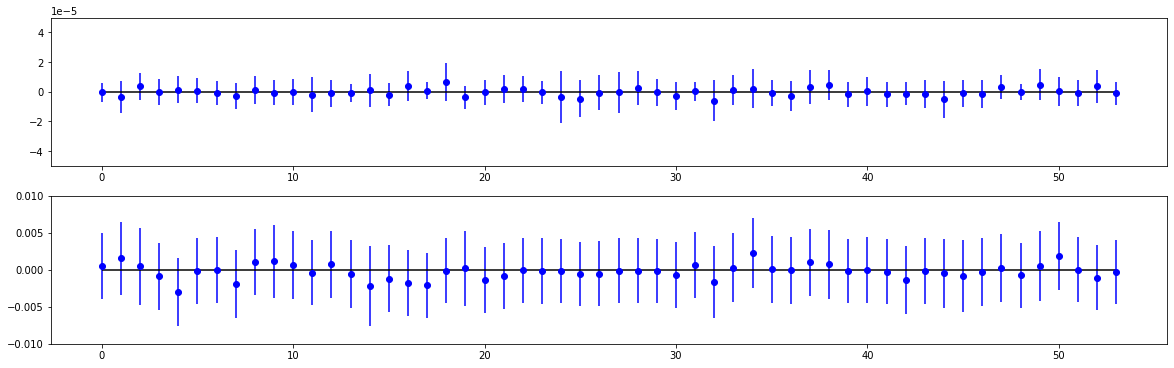

In [6]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy=  0.57677459, sigma_nuy=9.75506418e-07, error_nuy=4.34235436e-08

(ay - ref_ay).abs().sum().item()=0.000102782646

(fy - ref_fy).abs().sum().item()= 0.045848506



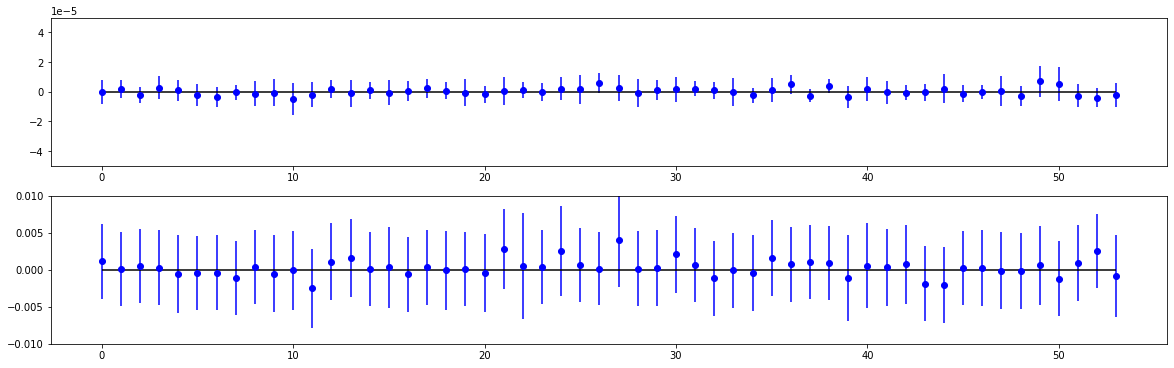

In [7]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

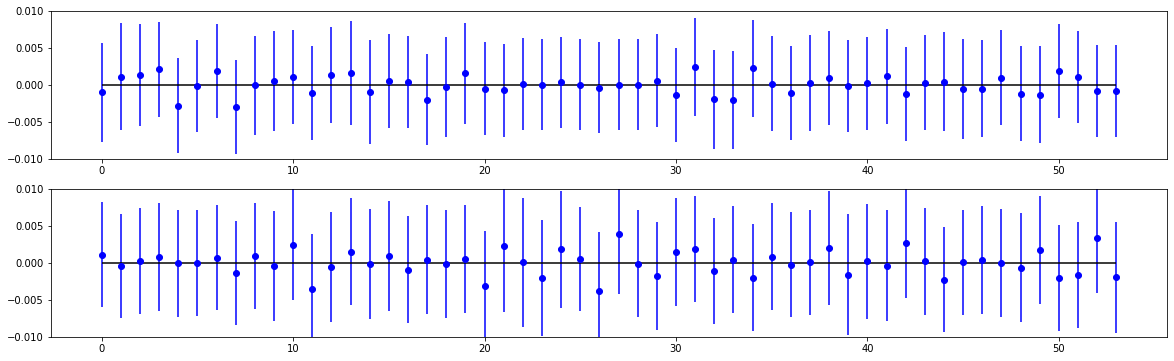

In [8]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [9]:
# Set twiss instance

twiss = Twiss(model, table, use_model=False)

dict_keys(['jx', 'sigma_jx', 'center_jx', 'spread_jx', 'jy', 'sigma_jy', 'center_jy', 'spread_jy', 'mask'])

(abs(ref_jx - center_jx)/ref_jx).item() = 0.000221794894
(abs(ref_jy - center_jy)/ref_jy).item() = 0.000264103556



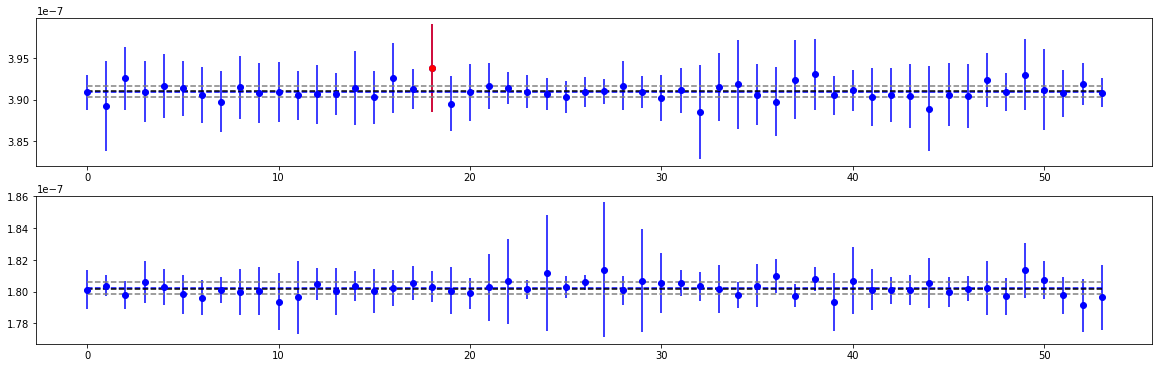

In [10]:
# Estimate action

twiss.get_action(dict_threshold={'use': True, 'factor': 3.0})
print(twiss.action.keys())
print()

jx, sigma_jx, center_jx, spread_jx = twiss.action['jx'], twiss.action['sigma_jx'], twiss.action['center_jx'], twiss.action['spread_jx']
jy, sigma_jy, center_jy, spread_jy = twiss.action['jy'], twiss.action['sigma_jy'], twiss.action['center_jy'], twiss.action['spread_jy']

ref_jx = (ref_ax**2/(2.0*model.bx[model.monitor_index])).mean()
ref_jy = (ref_ay**2/(2.0*model.by[model.monitor_index])).mean()

print(f'{(abs(ref_jx - center_jx)/ref_jx).item() = :12.9}')
print(f'{(abs(ref_jy - center_jy)/ref_jy).item() = :12.9}')
print()

mask_x, mask_y = twiss.action['mask'].logical_not()
out_jx, out_jy = torch.arange(model.monitor_count)[mask_x], torch.arange(model.monitor_count)[mask_y]

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), jx.cpu().numpy(), yerr=sigma_jx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(out_jx.cpu().numpy(), jx[out_jx].cpu().numpy(), yerr=sigma_jx[out_jx].cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.hlines([(center_jx - spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([center_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax1.hlines([(center_jx + spread_jx).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax1.hlines([ref_jx.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')


ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), jy.cpu().numpy(), yerr=sigma_jy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(out_jy.cpu().numpy(), jy[out_jy].cpu().numpy(), yerr=sigma_jy[out_jy].cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.hlines([(center_jy - spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([center_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='blue', linestyles='dashed')
ax2.hlines([(center_jy + spread_jy).cpu().numpy()], 0, model.monitor_count - 1, colors='gray', linestyles='dashed')
ax2.hlines([ref_jy.cpu().numpy()], 0, model.monitor_count - 1, colors='black', linestyles='dashed')

plt.show()

dict_keys(['bx', 'sigma_bx', 'by', 'sigma_by'])

(bx - model.bx[model.monitor_index]).abs().sum().item()= 0.631170935
(by - model.by[model.monitor_index]).abs().sum().item()=  1.29514148



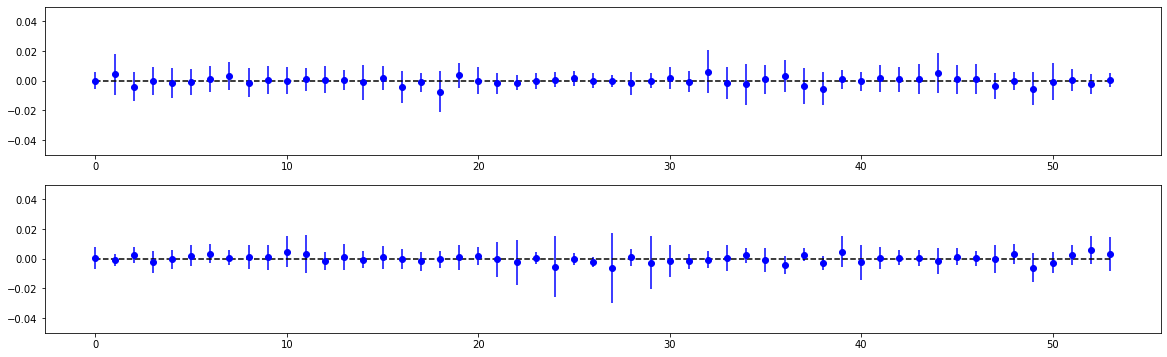

In [11]:
# Estimate twiss

twiss.get_twiss_from_amplitude()
print(twiss.data_amplitude.keys())
print()

bx, sigma_bx = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by, sigma_by = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

bx_m = model.bx[model.monitor_index]
by_m = model.by[model.monitor_index]

print(f'{(bx - model.bx[model.monitor_index]).abs().sum().item()=:12.9}')
print(f'{(by - model.by[model.monitor_index]).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), ((bx_m - bx)/bx_m).cpu().numpy(), yerr=(sigma_bx/bx_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax1.set_ylim(-0.05, +0.05)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), ((by_m - by)/by_m).cpu().numpy(), yerr=(sigma_by/by_m).cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black', linestyles='dashed')
ax2.set_ylim(-0.05, +0.05)

plt.show()

In [12]:
# Twiss values and errors can be passed to get_action()
# Data at monitor locations should be passed

twiss.get_action()
print([twiss.action['center_jx'].item(), twiss.action['center_jy'].item()])
print([twiss.action['spread_jx'].item(), twiss.action['spread_jy'].item()])

twiss.get_action(bx=model.bx[model.monitor_index], by=model.by[model.monitor_index], sigma_bx=model.sigma_bx[model.monitor_index], sigma_by=model.sigma_by[model.monitor_index])
print([twiss.action['center_jx'].item(), twiss.action['center_jy'].item()])
print([twiss.action['spread_jx'].item(), twiss.action['spread_jy'].item()])

[3.9099095792604086e-07, 1.8022383178118157e-07]
[6.994246951175811e-10, 3.643562210309553e-10]
[3.9099095792604086e-07, 1.8022383178118157e-07]
[6.994246951175811e-10, 3.643562210309553e-10]


# Example-02: Virtual phase and phase correction

In [13]:
# TbT data is only avalible at monitor locations
# Phase at other locations (virtual locations) can be estimated using measured phase at monitors and model phase advance between them
# For each virtual location, monitor locations around it are used to estimate virtual phase
# Given range limit, the corresponding number of monitors are used on each side around the probed virtual location

# Similary, monitor location itself can be treated as a virtual location, i.e. data from other locations can be used to possibly impove estimation at selected probed location
# Strong bias towards model is introduced in this case, i.e. phase correction should be avoided if real lattice is not close to the model

# In both cases, the range limit is passed to the method

In [14]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [15]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883093, sigma_nux=6.85362142e-07, error_nux=5.99060423e-09

(ax - ref_ax).abs().sum().item()=0.000110205779

(fx - ref_fx).abs().sum().item()=0.0359178925



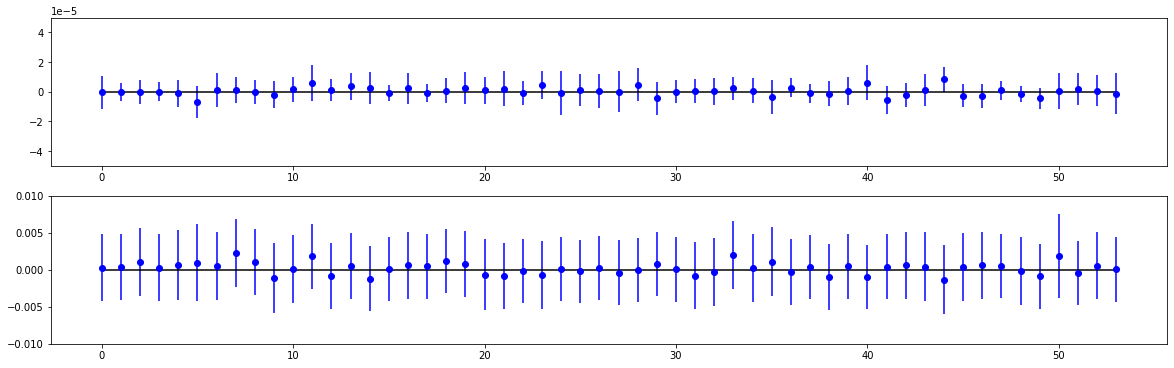

In [16]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774463, sigma_nuy=8.18073102e-07, error_nuy=1.70117886e-07

(ay - ref_ay).abs().sum().item()=0.000131486627

(fy - ref_fy).abs().sum().item()=0.0574494557



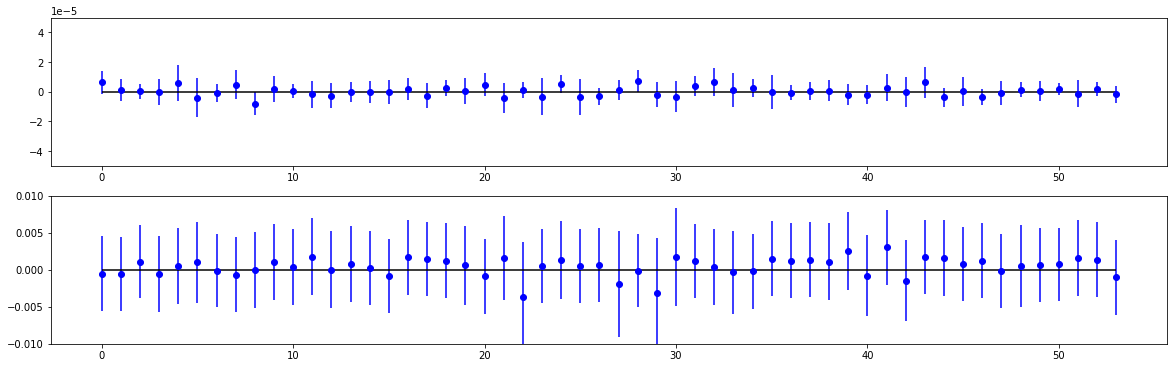

In [17]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

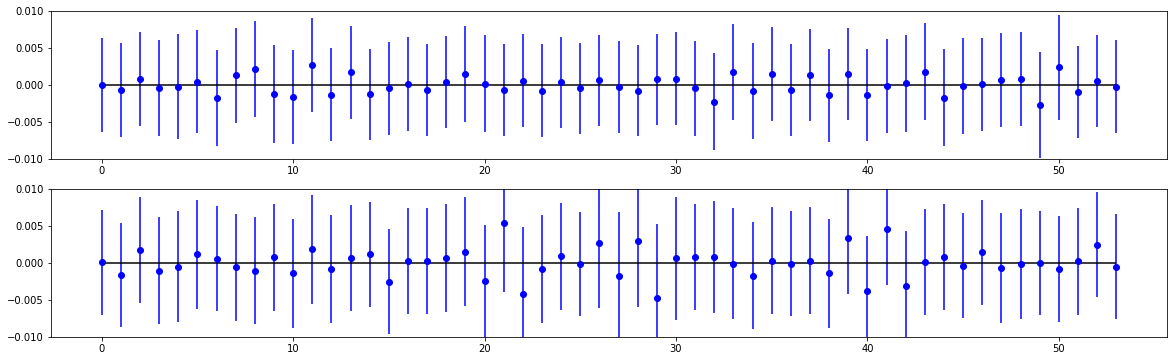

In [18]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [19]:
# Set twiss instance

twiss = Twiss(model, table)

In [20]:
# Print total number of virtual locations and corresponding index
# Note, the first and the last are special virtual locations ('HEAD' and 'TAIL')

print(twiss.model.virtual_count)
print(twiss.model.virtual_index)

# Compute virtual phase at each virtual location
# twiss.fx, twiss.fy and corresponding error are updated (zero at initialization at virtual location indices)
# twiss.correct_x and twiss.correct_y dictionaries with additional information are created or updated
# Note, kwargs can be passed to Decomposition.phase_virtual()

twiss.phase_virtual(limit=8, clean=True, factor=2.0)

5
[0, 2, 28, 54, 58]


dict_keys(['model', 'probe', 'limit', 'index', 'clean', 'phase', 'error'])
tensor([1.020468932999e+00, 6.082636501000e-04], dtype=torch.float64)
28
8
{20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36}
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


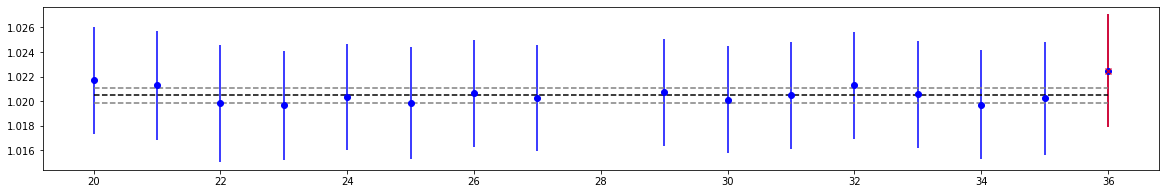

In [21]:
# Examine additional data for a virtual location at IP

_, _, index, *_ = twiss.model.virtual_index

# For each virtual location, addition data dictionary is stored

print(twiss.virtual_x[index].keys())

# Estimated value & error

print(twiss.virtual_x[index]['model'])

# Virtual location index

print(twiss.virtual_x[index]['probe'])

# Range limit

print(twiss.virtual_x[index]['limit'])

# Used locations {index: location}

print(twiss.virtual_x[index]['index'])

# Filter mask

print(twiss.virtual_x[index]['clean'].to(torch.int64))

# Plot phase data and error

keys = torch.tensor([*twiss.virtual_x[index]['index'].keys()], dtype=torch.int64)
mask = twiss.virtual_x[index]['clean'].logical_not()

center, spread = twiss.virtual_x[index]['model'].cpu().numpy()

plt.figure(figsize=(20, 3))
plt.errorbar(keys, twiss.virtual_x[index]['phase'].cpu().numpy(), yerr=twiss.virtual_x[index]['error'].cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(keys[mask], twiss.virtual_x[index]['phase'][mask].cpu().numpy(), yerr=twiss.virtual_x[index]['error'][mask].cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines([center - spread, center, center + spread], min(keys), max(keys), color=['grey', 'black', 'grey'], linestyles='dashed')
plt.show()

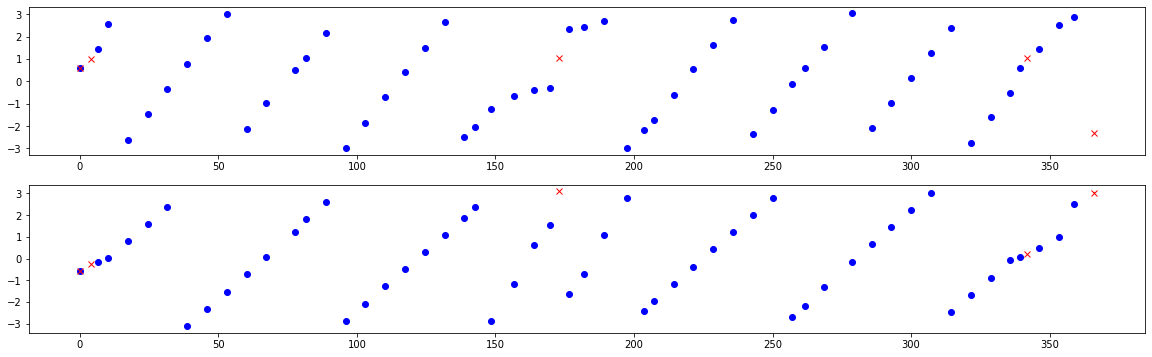

In [22]:
# Plot x & y phase for all locations vs location position

# blue -- monitor locations
# red  -- virtual locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fx[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.fy[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(model.time[model.virtual_index].cpu().numpy(), twiss.fy[model.virtual_index].cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

In [23]:
# Perform phase correction
# Note, kwargs are passed to Decomposition.phase_virtual()

# Similar to virtual phase computation, twiss.correct_x & twiss.correct_y dictionaries are created or updated
# twiss.fx_correct, twiss.fy_correct attributes and corresponding errors are created

twiss.phase_correct(limit=8, clean=True, factor=2.0)

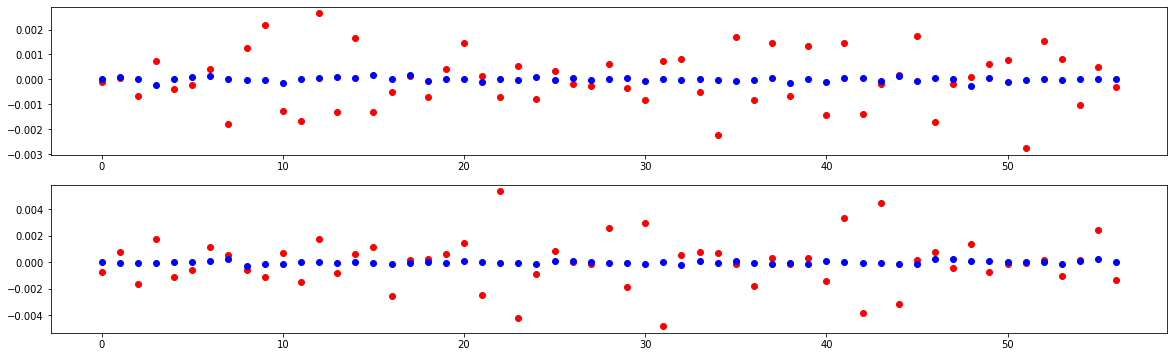

(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=0.0527715206
(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=0.0771361746

(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=0.00340336572
(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=0.00482566147



In [24]:
# Compare adjacent phase advance for uncorrected and corrected case vs model (endpoints are dropped)

# Uncorrected

mux, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx)
muy, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy)

# Corrected

mux_correct, _ = Decomposition.phase_adjacent(twiss.table.nux, twiss.fx_corrected)
muy_correct, _ = Decomposition.phase_adjacent(twiss.table.nuy, twiss.fy_corrected)

# Plot

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux)[1:-1].cpu().numpy(), color='red', marker='o')
ax1.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_x - mux_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

ax2 = plt.subplot(212)
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy)[1:-1].cpu().numpy(), color='red', marker='o')
ax2.scatter(range(twiss.model.size - (1 + 1)), (twiss.model.phase_y - muy_correct)[1:-1].cpu().numpy(), color='blue', marker='o')

plt.show()

print(f'{(mux - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(mux_correct - twiss.model.phase_x)[1:-1].abs().sum().item()=:12.9}')
print(f'{(muy_correct - twiss.model.phase_y)[1:-1].abs().sum().item()=:12.9}')
print()

In [25]:
# Additional options for virtual phase estimation

# Default method for virtual phase estimation uses model phase advance
# Model phase advances within given range are used
# It is possible to use monitors only after virtual locations (inverse=False, forward=True)
# Or only before virtual locations (inverse=True, forward=False)

# Set model

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set table

table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
              nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
              accumulate=True, dtype=dtype, device=device)

# Set twiss

twiss = Twiss(model, table)

# Estimate virtual phase using monitors before virtual

twiss.phase_virtual(limit=1, inverse=True, forward=False)
print(twiss.fx[model.virtual_index].cpu().numpy())
print(twiss.fy[model.virtual_index].cpu().numpy())
print()

# Estimate virtual phase using monitors after virtual

twiss.phase_virtual(limit=1, inverse=False, forward=True)
print(twiss.fx[model.virtual_index].cpu().numpy())
print(twiss.fy[model.virtual_index].cpu().numpy())
print()

# Estimate virtual phase using nearest (by model phase advance) monitors to virtual

twiss.phase_virtual(limit=1, nearest=True)
print(twiss.fx[model.virtual_index].cpu().numpy())
print(twiss.fy[model.virtual_index].cpu().numpy())
print()

[ 0.59606592  0.98217752  1.0202871   1.06102746 -2.31378343]
[-0.58054348 -0.27627256  3.10045901  0.19318806  3.04343735]

[ 0.59631498  0.9822316   1.02074212  1.05868129 -2.31353437]
[-0.58000831 -0.27632061  3.10058064  0.19401344  3.04397252]

[ 0.59631498  0.98217752  1.0202871   1.05868129 -2.31378343]
[-0.58000831 -0.27632061  3.10045901  0.19318806  3.04397252]



In [26]:
# Virtual phase from interpolation

# Set model

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set table
# Note, accumulate should be set to True

table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
              nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
              accumulate=True, dtype=dtype, device=device)

# Set twiss

twiss = Twiss(model, table)

# Estimate virtual phase using (linear) interpolation
# Note, limit and other options are not used, returned phases are accumulated

twiss.phase_virtual(method='interpolate')

print(twiss.fx[model.virtual_index].cpu().numpy())
print(twiss.fy[model.virtual_index].cpu().numpy())
print()

print(mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy())
print(mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy())
print()

[ 0.59631498  0.98220244 26.15325584 51.32524467 54.2351334 ]
[-0.58000831 -0.27630841 21.95007575 44.17569477 47.02626967]

[ 0.59631498  0.98220244  1.02051461  1.05976222 -2.31353437]
[-0.58000831 -0.27630841  3.10051983  0.19339762  3.04397252]



# Example-03: Twiss from phase data (adjacent)

In [27]:
# In this example, twiss parameters are computed from phase data using only adjacent monitors, i.e. range limit is one
# Results are compared with model
# Twiss beta values are also compared with twiss from amplitude data computation

In [28]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [29]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536883084, sigma_nux=6.53558658e-07, error_nux=1.47586752e-08

(ax - ref_ax).abs().sum().item()=9.67384975e-05

(fx - ref_fx).abs().sum().item()=0.0348944832



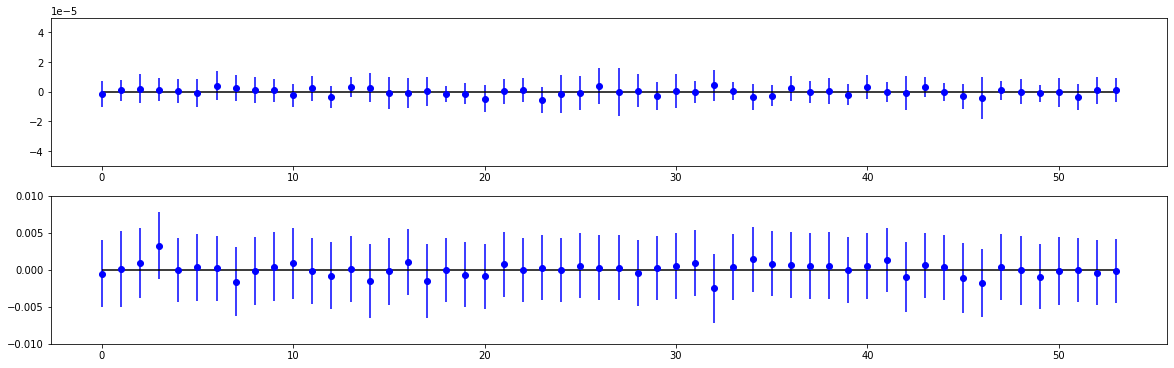

In [30]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy= 0.576774722, sigma_nuy=7.70456406e-07, error_nuy=8.8639224e-08

(ay - ref_ay).abs().sum().item()=0.000103051261

(fy - ref_fy).abs().sum().item()=  0.03807041



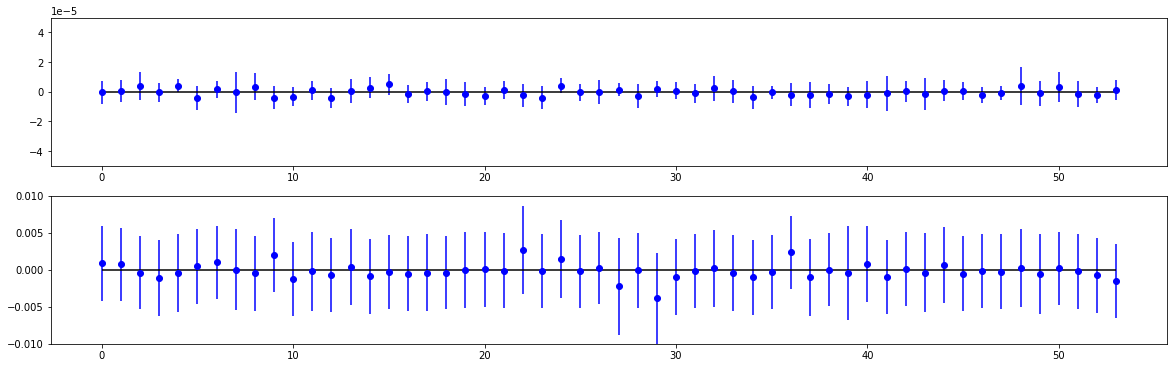

In [31]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

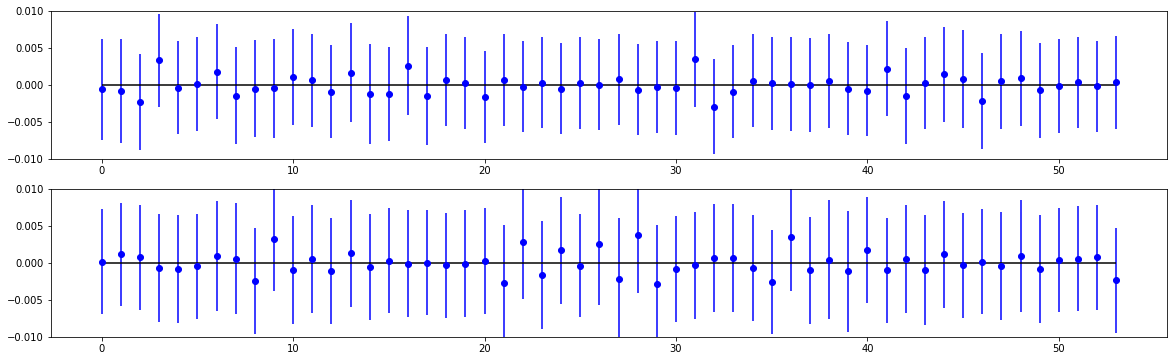

In [32]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [33]:
# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [34]:
# Invocation of get_twiss_from_phase sets twiss.data_phase dictionary
# This dictionary contains model and estimated results for each triplet (phase advance, twiss parameters and corresponding errors)

for key in twiss.data_phase:
    print(key)
    
# i -- probed index, j & k -- other used indices, each combination is given by two pairs (i, j) & (i, k), phase advance is always from i and is negative if i is behind j or k timewise

# fx_ij, fx_m_ij -- estimated and model phase advance for i to j or k for x plane and corresponding errors with 'sigma' prefix
# fy_ij, fy_m_ij -- estimated and model phase advance for i to j or k for y plane and corresponding errors with 'sigma' prefix

# ax, bx -- estimated twiss parameters and corresponding error for x plane and corresponding errors with 'sigma' prefix
# ay, by -- estimated twiss parameters and corresponding error for y plane and corresponding errors with 'sigma' prefix

fx_ij
sigma_fx_ij
fx_m_ij
sigma_fx_m_ij
fx_ik
sigma_fx_ik
fx_m_ik
sigma_fx_m_ik
fy_ij
sigma_fy_ij
fy_m_ij
sigma_fy_m_ij
fy_ik
sigma_fy_ik
fy_m_ik
sigma_fy_m_ik
ax
sigma_ax
bx
sigma_bx
ay
sigma_ay
by
sigma_by


In [35]:
# Since range limit is one here, each location has only one computed value

print(twiss.data_phase['bx'].shape)

torch.Size([59, 1])


In [36]:
# Note, here 'HEAD' virtual location is at the same place as the 1st monitor location
# Phase advance in this case is zero and twiss parameters are not meaningful for 'HEAD' virtual location

print(model.is_same(0, 1))

True


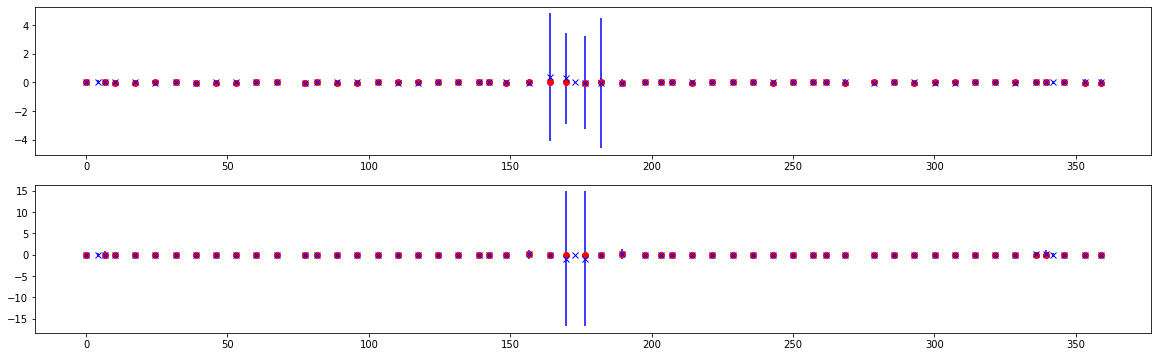

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=  0.59750047
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.20059824

(bx_m - bx_f)[1:-1].abs().sum().item()=  1.15896514
(by_m - by_f)[1:-1].abs().sum().item()=  3.01750312



In [37]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f)[1:-1].cpu().numpy(), yerr=sigma_bx_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f)[1:-1].cpu().numpy(), yerr=sigma_by_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

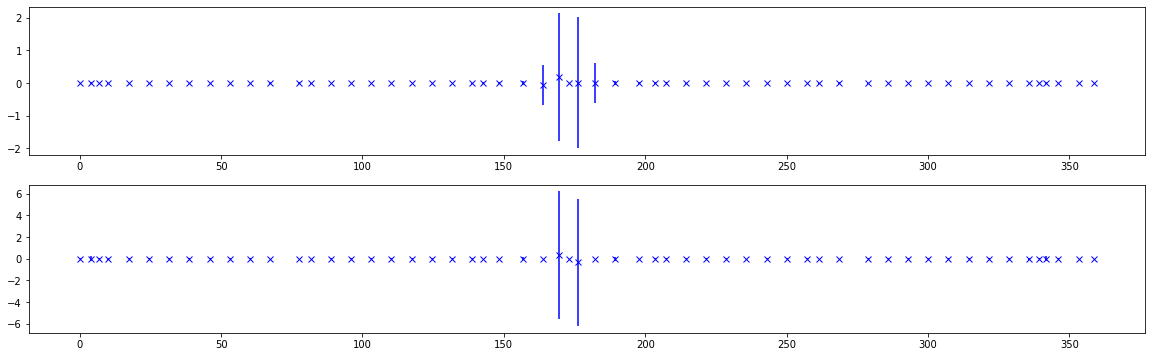

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.345417357
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.874638583



In [38]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

# Twiss from phase

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f)[1:-1].cpu().numpy(), yerr=sigma_ax_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f)[1:-1].cpu().numpy(), yerr=sigma_ay_f[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')

plt.show()

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

# Example-04: Twiss from phase data (range limit & phase correction)

In [39]:
# In this example several combinations (triplets = two diffrent pairs that include probe and two other) are used to estimate twiss parameters for given probed location
# For each combination twiss parameters and corresponding errors are computed
# Data from different combinations can be filtered (remove outlires) and processed (center and spread estimation)

# Twiss parameters are also computed using corrected phase
# Note, phase correction generates strong bias towards the used model
# In this example signals are generated using exact model and this bias is not manifested

In [40]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [41]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.536882937, sigma_nux=7.55498106e-07, error_nux=1.62049714e-07

(ax - ref_ax).abs().sum().item()=0.000103824395

(fx - ref_fx).abs().sum().item()=0.0369339968



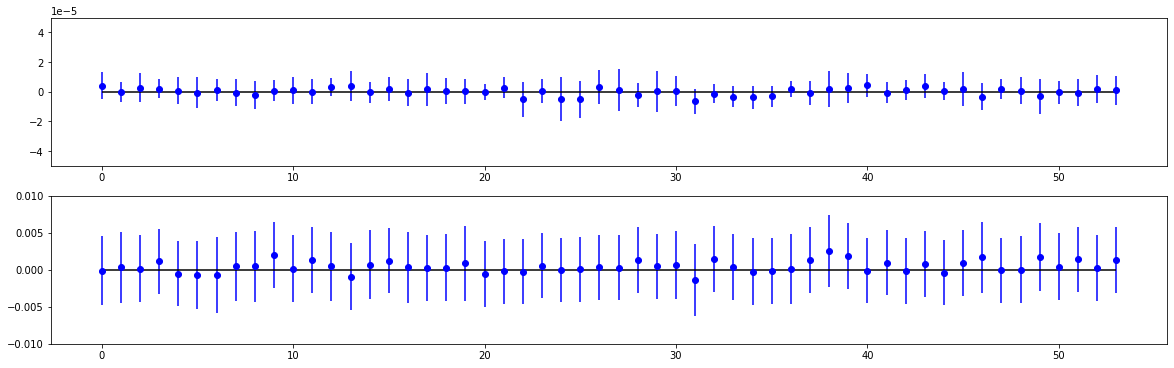

In [42]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

nuy=  0.57677444, sigma_nuy=8.5712243e-07, error_nuy=1.93152376e-07

(ay - ref_ay).abs().sum().item()=0.000110333718

(fy - ref_fy).abs().sum().item()=0.0406542504



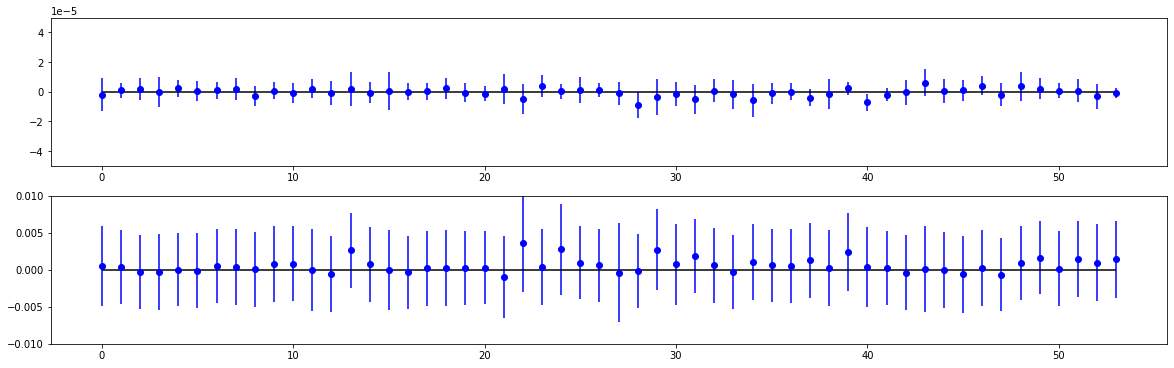

In [43]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-5.0E-5, +5.0E-5)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

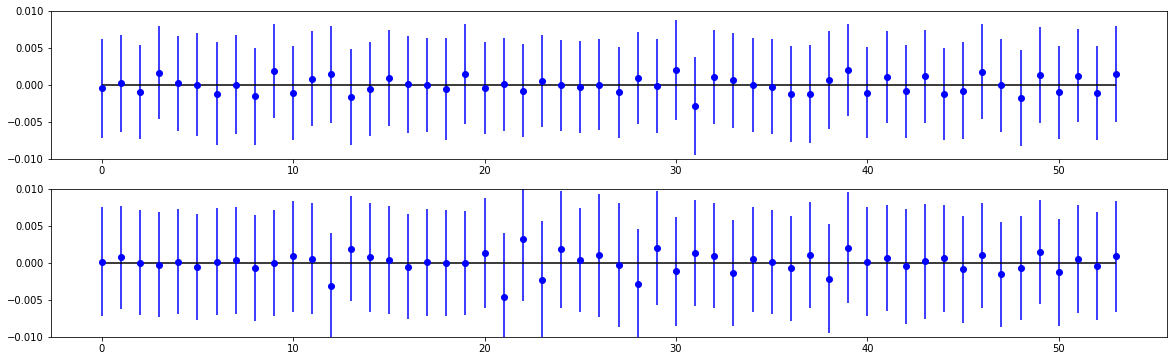

In [44]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (model.monitor_phase_x - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (model.monitor_phase_y - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [45]:
# Estimate twiss parameters using adjacent monitors
# For each probed location the closest monitor location is used on each side

# Set twiss instance

twiss = Twiss(model, table, limit=1)

# Estimate twiss from amplitude data

twiss.get_action()
twiss.get_twiss_from_amplitude()

# Estimate twiss from phase data
# Note, virtual locations are not used as other for given probe

twiss.phase_virtual()
twiss.get_twiss_from_phase()

# Twiss from amplitude

bx_a, sigma_bx_a = twiss.data_amplitude['bx'], twiss.data_amplitude['sigma_bx']
by_a, sigma_by_a = twiss.data_amplitude['by'], twiss.data_amplitude['sigma_by']

# Twiss from phase

bx_f, sigma_bx_f = twiss.data_phase['bx'].flatten(), twiss.data_phase['sigma_bx'].flatten()
by_f, sigma_by_f = twiss.data_phase['by'].flatten(), twiss.data_phase['sigma_by'].flatten()

ax_f, sigma_ax_f = twiss.data_phase['ax'].flatten(), twiss.data_phase['sigma_ax'].flatten()
ay_f, sigma_ay_f = twiss.data_phase['ay'].flatten(), twiss.data_phase['sigma_ay'].flatten()

In [46]:
# Estimate using range of monitors
# Here, for each probed location 8 monitor locations are used on each side

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.get_twiss_from_phase()

In [47]:
# Note, for given range limit, the number of combinations is limit*(2*limit - 1)

print(max(twiss.limit))
print(max(twiss.limit)*(2*max(twiss.limit) - 1))
print(twiss.data_phase['bx'].shape)

8
120
torch.Size([59, 120])


In [48]:
# Pairs are also generated for each location
# Note, virtual locations do not appear as other indices
# Combinations are also sorted by limit

print(twiss.combo[0].shape)
print(twiss.combo[0, 0].cpu().numpy().tolist())
# [[i, j], [i, k]]

torch.Size([120, 2, 2])
[[0, -2], [0, 1]]


In [49]:
# Data filtering can be performed with filter_twiss method (filtering is performed for x or y plane at a time)
# This method returns a mask with True/False values, True if a combination passes all filtering methods and False otherwise
# This mask can be used as weights, i.e. combinations with False have zero weight

# Several filtering options are avaliable (by default all are used)
# Set 'use' value to True or False

mask_x = twiss.filter_twiss(plane='x',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

mask_y = twiss.filter_twiss(plane='y',
                            phase={'use': True, 'threshold': 10.0},
                            model={'use': True, 'threshold': 0.5},
                            value={'use': True, 'threshold': 0.5},
                            sigma={'use': True, 'threshold': 0.25},
                            limit={'use': True, 'threshold': 5.0},
                           )

# phase -- clean based on absolute cotangents value for (i, j) or (i, k) model and measured advance
# model -- clean based on advance proximity to model
# value -- clean based on beta proximity to model
# sigma -- clean based on estimated phase advance error value
# limit -- clean outliers outside interval computed using robust center and spread estimators

print(len(mask_x.flatten()), mask_x.count_nonzero().item())
print(len(mask_y.flatten()), mask_y.count_nonzero().item())

7080 6071
7080 5545


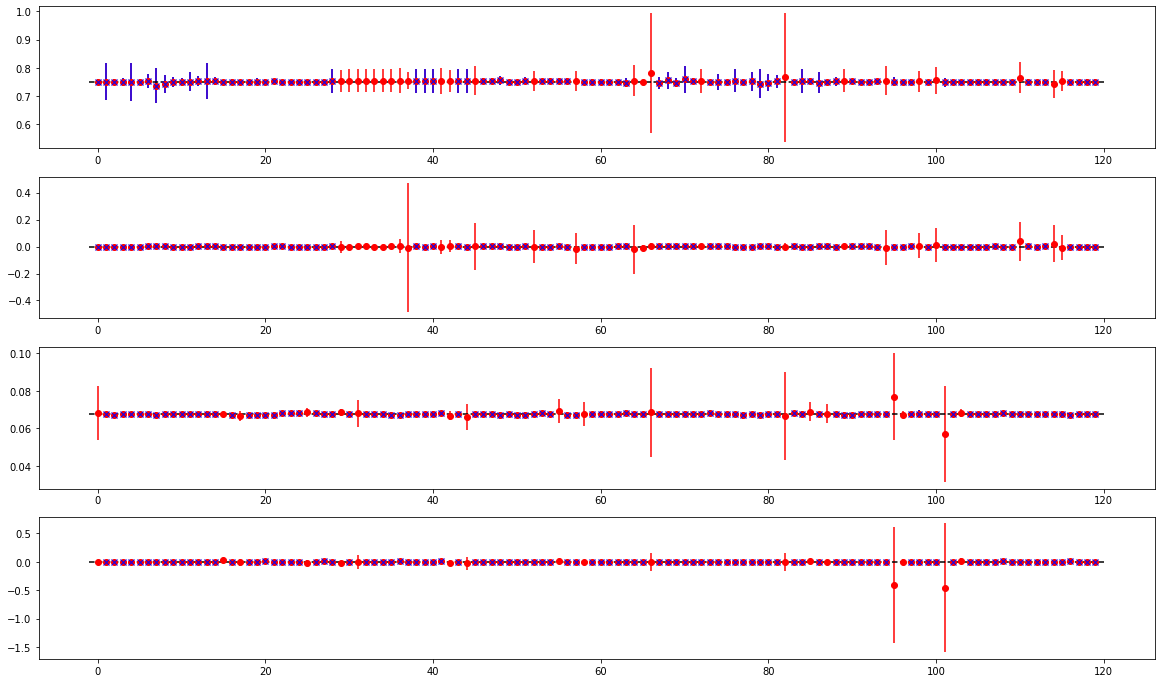

In [50]:
# Plot all combinations (red) and indicate selected (blue) for a selected location
# Note, 'HEAD' and 'TAIL' locations should not be used
# Change probe value

probe = 28

index = torch.arange(max(twiss.limit)*(2*max(twiss.limit) - 1), device=device)

bx, sigma_bx = twiss.data_phase['bx'][probe], twiss.data_phase['sigma_bx'][probe]
ax, sigma_ax = twiss.data_phase['ax'][probe], twiss.data_phase['sigma_ax'][probe]

by, sigma_by = twiss.data_phase['by'][probe], twiss.data_phase['sigma_by'][probe]
ay, sigma_ay = twiss.data_phase['ay'][probe], twiss.data_phase['sigma_ay'][probe]

plt.figure(figsize=(20, 3*4))

# bx
ax1 = plt.subplot(411)
ax1.errorbar(index.cpu().numpy(), bx.cpu().numpy(), yerr=sigma_bx.cpu().numpy(), fmt=' ', color='red', marker='o')
ax1.errorbar(index[mask_x[probe]].cpu().numpy(), bx[mask_x[probe]].cpu().numpy(), yerr=sigma_bx[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax1.hlines(model.bx[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ax
ax2 = plt.subplot(412)
ax2.errorbar(index.cpu().numpy(), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', color='red', marker='o')
ax2.errorbar(index[mask_x[probe]].cpu().numpy(), ax[mask_x[probe]].cpu().numpy(), yerr=sigma_ax[mask_x[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax2.hlines(model.ax[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# by
ax3 = plt.subplot(413)
ax3.errorbar(index.cpu().numpy(), by.cpu().numpy(), yerr=sigma_by.cpu().numpy(), fmt=' ', color='red', marker='o')
ax3.errorbar(index[mask_y[probe]].cpu().numpy(), by[mask_y[probe]].cpu().numpy(), yerr=sigma_by[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax3.hlines(model.by[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

# ay
ax4 = plt.subplot(414)
ax4.errorbar(index.cpu().numpy(), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', color='red', marker='o')
ax4.errorbar(index[mask_y[probe]].cpu().numpy(), ay[mask_y[probe]].cpu().numpy(), yerr=sigma_ay[mask_y[probe]].cpu().numpy(), fmt=' ', color='blue', marker='x')
ax4.hlines(model.ay[probe].cpu().numpy(), -1, len(index), color='black', linestyles='dashed')

plt.show()

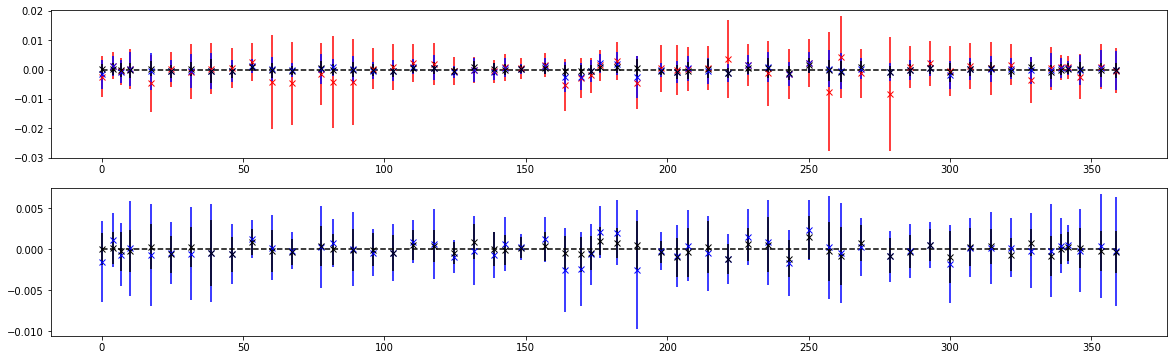

(bx_m - bx_1)[1:-1].abs().sum().item()=  1.26966496
(bx_m - bx_2)[1:-1].abs().sum().item()= 0.683105191
(bx_m - bx_3)[1:-1].abs().sum().item()= 0.290415113



In [51]:
# Twiss data processing can be performed with process_twiss method
# This method returns the result as a dictionary
# dict_keys(['value_a', 'sigma_a', 'error_a', 'value_b', 'sigma_b', 'error_b'])
# And updates self.ax, self.bx, self.ay, self.by and corresponding errors
# Processing is done for one plane ('x' or 'y') at a time

# This method uses weighted estimator for center and spread
# If weight is True, estimated errors for each combinations are used as weights
# If mask is provided, it is used as weights (weight is False) or weights are multiplied by given mask (weight is True)
# Combinations with False values thus have zero weight

# Compare different processing options

# No filtering or weights

out1 = twiss.process_twiss(plane='x', mask=None, weight=False)

# Filter mask is used as weights

out2 = twiss.process_twiss(plane='x', mask=mask_x, weight=False)

# Weights for each combitations are multiplied by filter mask

out3 = twiss.process_twiss(plane='x', mask=mask_x, weight=True)

bx_m = twiss.model.bx

bx_1, sigma_bx_1 = out1['value_b'], out1['sigma_b']
bx_2, sigma_bx_2 = out2['value_b'], out2['sigma_b']
bx_3, sigma_bx_3 = out3['value_b'], out3['sigma_b']

# red - 1, blue - 2, black - 3

plt.figure(figsize=(20, 3*2))

# 1 & 2 & 3
ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_1)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_1/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax1.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

# 2 & 3
ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_2)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_2/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), ((bx_m - bx_3)/bx_m)[1:-1].cpu().numpy(), yerr=(sigma_bx_3/bx_m)[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')
ax2.hlines(0, twiss.model.time[1:-1].cpu().numpy().min(), twiss.model.time[1:-1].cpu().numpy().max(), color='black', linestyles='dashed')

plt.show()

print(f'{(bx_m - bx_1)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_2)[1:-1].abs().sum().item()=:12.9}')
print(f'{(bx_m - bx_3)[1:-1].abs().sum().item()=:12.9}')
print()

In [52]:
# Compare different cases of twiss computation

# 1 -- from amplitude
# 2 -- from phase (range limit)
# 3 -- from phase (range limit & correction)

twiss = Twiss(model, table, limit=8)
twiss.phase_virtual()
twiss.phase_correct()

# Uncorrected 

twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_combo, sigma_ax_f_combo = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_combo, sigma_bx_f_combo = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_combo, sigma_ay_f_combo = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_combo, sigma_by_f_combo = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

# Corrected

twiss.get_twiss_from_phase(use_correct=True)
mask_x = twiss.filter_twiss(plane='x')
mask_y = twiss.filter_twiss(plane='y')
_ = twiss.process_twiss(plane='x', mask=mask_x, weight=True)
_ = twiss.process_twiss(plane='y', mask=mask_y, weight=True)

ax_f_correct, sigma_ax_f_correct = torch.clone(twiss.ax), torch.clone(twiss.sigma_ax)
bx_f_correct, sigma_bx_f_correct = torch.clone(twiss.bx), torch.clone(twiss.sigma_bx)
ay_f_correct, sigma_ay_f_correct = torch.clone(twiss.ay), torch.clone(twiss.sigma_ay)
by_f_correct, sigma_by_f_correct = torch.clone(twiss.by), torch.clone(twiss.sigma_by)

(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()= 0.714453722
(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=  1.32431433

(bx_m - bx_f)[1:-1].abs().sum().item()= 0.569248012
(by_m - by_f)[1:-1].abs().sum().item()=  2.93252103

(bx_m - bx_f_combo)[1:-1].abs().sum().item()= 0.290415113
(by_m - by_f_combo)[1:-1].abs().sum().item()=  0.53494658

(bx_m - bx_f_correct)[1:-1].abs().sum().item()=0.0239282536
(by_m - by_f_correct)[1:-1].abs().sum().item()=0.0400138252



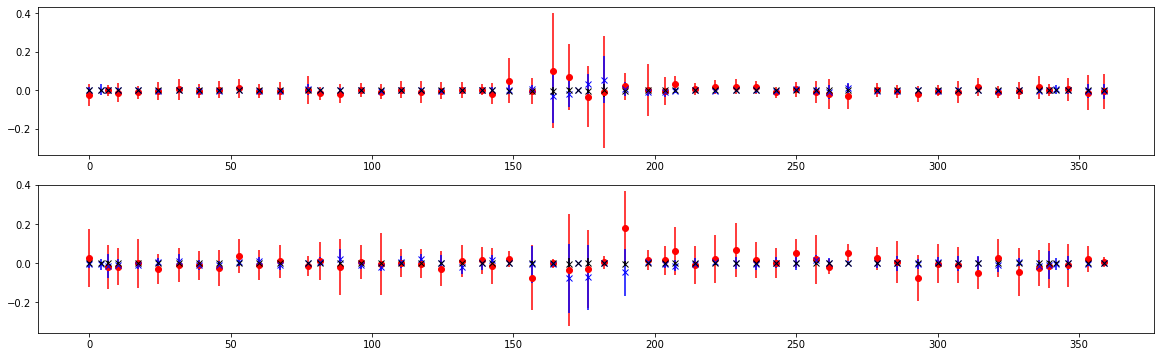

In [53]:
# Plot twiss beta results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

bx_m, by_m = twiss.model.bx, twiss.model.by

print(f'{(bx_m[twiss.model.monitor_index] - bx_a).abs().sum().item()=:12.9}')
print(f'{(by_m[twiss.model.monitor_index] - by_a).abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(bx_m - bx_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(by_m - by_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m[twiss.model.monitor_index] - bx_a).cpu().numpy(), yerr=sigma_bx_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_combo)[1:-1].cpu().numpy(), yerr=sigma_bx_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (bx_m - bx_f_correct)[1:-1].cpu().numpy(), yerr=sigma_bx_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m[twiss.model.monitor_index] - by_a).cpu().numpy(), yerr=sigma_by_a.cpu().numpy(), fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_combo)[1:-1].cpu().numpy(), yerr=sigma_by_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (by_m - by_f_correct)[1:-1].cpu().numpy(), yerr=sigma_by_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

(ax_m - ax_f)[1:-1].abs().sum().item()= 0.156972692
(ay_m - ay_f)[1:-1].abs().sum().item()= 0.820086463

(ax_m - ax_f_combo)[1:-1].abs().sum().item()=0.0988092307
(ay_m - ay_f_combo)[1:-1].abs().sum().item()= 0.149761641

(ax_m - ax_f_correct)[1:-1].abs().sum().item()=0.00849601229
(ay_m - ay_f_correct)[1:-1].abs().sum().item()=0.0115201828



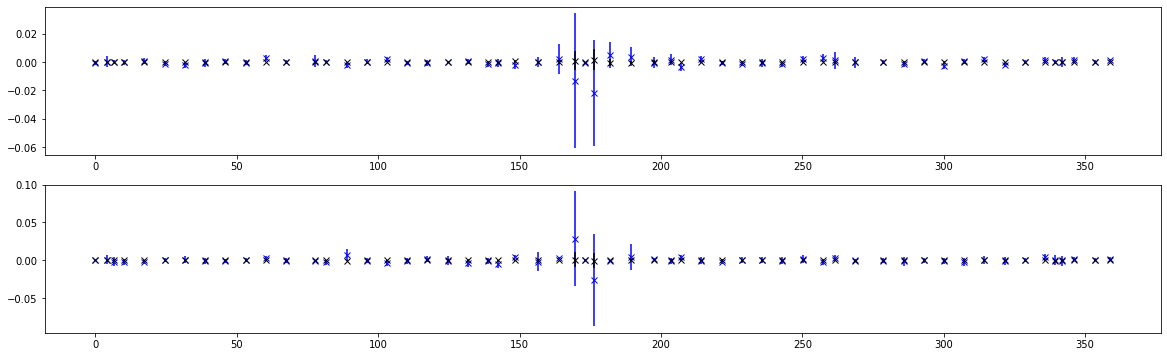

In [54]:
# Plot twiss alpha results ('HEAD' and 'TAIL' virtual locations are dropped)
# Note, relative error is plotted

# Model

ax_m, ay_m = twiss.model.ax, twiss.model.ay

print(f'{(ax_m - ax_f)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_combo)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_combo)[1:-1].abs().sum().item()=:12.9}')
print()

print(f'{(ax_m - ax_f_correct)[1:-1].abs().sum().item()=:12.9}')
print(f'{(ay_m - ay_f_correct)[1:-1].abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ax_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ax_m - ax_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ax_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_combo)[1:-1].cpu().numpy(), yerr=sigma_ay_f_combo[1:-1].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(twiss.model.time[1:-1].cpu().numpy(), (ay_m - ay_f_correct)[1:-1].cpu().numpy(), yerr=sigma_ay_f_correct[1:-1].cpu().numpy(), fmt=' ', marker='x', color='black')

plt.show()

In [55]:
# Using several combinations can significanty impove twiss estimation accuracy based on phase data
# In this example random noise is the only error source
# Since signals are generated using the model, phase correction improves accuracy significantly in this case

In [56]:
# Explore distribution vs limit

# Set twiss

twiss = Twiss(model, table, limit=64)
twiss.phase_virtual()
twiss.get_twiss_from_phase()

# Filter and process

mask_x = twiss.filter_twiss(plane='x', 
                            phase={'use': True, 'threshold': 10.0}, 
                            model={'use': False, 'threshold': 0.50}, 
                            value={'use': False, 'threshold': 0.50}, 
                            sigma={'use': False, 'threshold': 0.50}, 
                            limit={'use': True, 'threshold': 5.0},
                            error={'use': True, 'threshold': 5.0})

twiss.process_twiss(plane='x', mask=mask_x, weight=True) ;

mask_y = twiss.filter_twiss(plane='y', 
                            phase={'use': True, 'threshold': 10.0}, 
                            model={'use': False, 'threshold': 0.50}, 
                            value={'use': False, 'threshold': 0.50}, 
                            sigma={'use': False, 'threshold': 0.50}, 
                            limit={'use': True, 'threshold': 5.0},
                            error={'use': True, 'threshold': 5.0})

twiss.process_twiss(plane='y', mask=mask_y, weight=True) ;

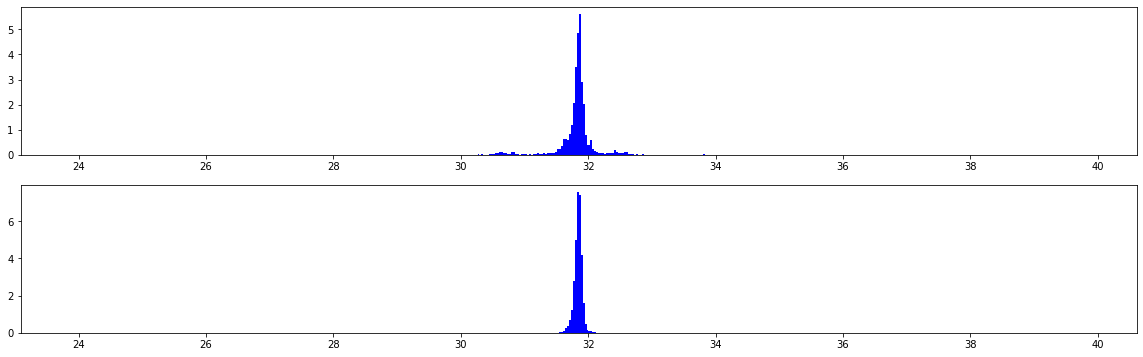

In [57]:
# Plot distribution

plane = 'x'
index = 26

index = model.monitor_index[index]
value = twiss.data_phase[f'b{plane}'][index]
error = twiss.data_phase[f'sigma_b{plane}'][index]

weight = {'x': mask_x, 'y': mask_y}[plane][index]/error**2
weight /= weight.sum()

min_range, max_range = numpy.array([0.75, 1.25])*({'x': twiss.model.bx, 'y': twiss.model.bx}[plane][index].item())

plt.figure(figsize=(20, 2*3))
ax = plt.subplot(211)
ax.hist(value.cpu().numpy(), histtype='bar', density=True, bins=512, range=(min_range, max_range), color='blue')
ax = plt.subplot(212)
ax.hist(value.cpu().numpy(), histtype='bar', weights=weight, density=True, bins=512, range=(min_range, max_range), color='blue')
plt.show()

# Example-05: Default twiss (__call__ method)

In [58]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [59]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [60]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883102, sigma_nux=5.8295614e-07, error_nux=2.80508505e-09

(ax - ref_ax).abs().sum().item()=0.000102732215

(fx - ref_fx).abs().sum().item()=0.0338432721



In [61]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774593, sigma_nuy=7.41378493e-07, error_nuy=4.0681384e-08

(ay - ref_ay).abs().sum().item()=0.00010279716

(fy - ref_fy).abs().sum().item()=0.0425599919



In [62]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [63]:
# Default twiss (compute action, beta from amplitude, virtual phase, corrected phase and twiss from phase)

twiss = Twiss(model, table, limit=8)
twiss()

name     kind  flag        time         ax  sigma_ax         bx  \
0    HEAD  VIRTUAL     0    0.000000  -0.679118  0.001844   7.477958   
1    STP2  MONITOR     1    0.000000  -0.677650  0.002160   7.476487   
2    IV4P  VIRTUAL     0    4.153500   1.955573  0.004876  14.242918   
3    STP4  MONITOR     1    6.667000   0.381239  0.001835   3.118462   
4    SRP1  MONITOR     1   10.190565  -0.802966  0.002412   4.734423   
5    SRP2  MONITOR     1   17.337624  -0.718951  0.002029   4.561646   
6    SRP3  MONITOR     1   24.484683  -0.768447  0.001494   4.482765   
7    SRP4  MONITOR     1   31.631742  -0.789171  0.001045   4.756638   
8    SRP5  MONITOR     1   38.778801  -0.715322  0.001401   4.488759   
9    SRP6  MONITOR     1   45.925860  -0.788452  0.001364   4.549937   
10   SRP7  MONITOR     1   53.072919  -0.770024  0.000944   4.742291   
11   SRP8  MONITOR     1   60.219978  -0.720615  0.001403   4.440401   
12   SRP9  MONITOR     1   67.367037  -0.801578  0.001054   4.625985   
13   SIP1  MONITOR     1   77.535331  -1.749174  0.002469  12.238688   
14   SIP2  MONITOR     1   81.633511   0.532984  0.000892   4.926058   
15  SRP10  MONITOR     1   88.807375  -0.731237  0.001353   4.447049   
16  SRP11  MONITOR     1   95.954434  -0.799811  0.001158   4.665509   
17  SRP12  MONITOR     1  103.101493  -0.738094  0.001310   4.638535   
18  SRP13  MONITOR     1  110.248552  -0.748521  0.001076   4.455065   
19  SRP14  MONITOR     1  117.395611  -0.796262  0.001282   4.711087   
20  SRP15  MONITOR     1  124.542670  -0.727111  0.000869   4.571968   
21  SRP16  MONITOR     1  131.689729  -0.766146  0.001032   4.490742   
22  SRP17  MONITOR     1  138.836788  -0.785114  0.001723   4.731766   
23   SEP5  MONITOR     1  142.535388   1.530457  0.002963   9.556741   
24   SEP4  MONITOR     1  148.345638  -2.838476  0.002956  17.504219   
25   SEP3  MONITOR     1  156.649638  -2.091685  0.005774  12.468876   
26   SEP1  MONITOR     1  163.917898  -5.308072  0.010309  65.995002   
27   SEP0  MONITOR     1  169.609758  21.723264  0.048556  31.825744   
28     IP  VIRTUAL     0  172.999758  -0.000232  0.000630   0.750281   
29   NEP0  MONITOR     1  176.389758 -21.758833  0.047244  31.877039   
30   NEP1  MONITOR     1  182.081618   5.315292  0.013743  66.077732   
31   NEP3  MONITOR     1  189.349878   2.094415  0.006602  12.473190   
32   NEP4  MONITOR     1  197.653878   2.834036  0.005569  17.487735   
33   NEP5  MONITOR     1  203.464128  -1.530799  0.003330   9.551607   
34  NRP17  MONITOR     1  207.162728   0.787561  0.002300   4.732837   
35  NRP16  MONITOR     1  214.309787   0.768683  0.002585   4.490373   
36  NRP15  MONITOR     1  221.456846   0.725069  0.001467   4.569520   
37  NRP14  MONITOR     1  228.603905   0.794628  0.002365   4.713674   
38  NRP13  MONITOR     1  235.750964   0.750996  0.002318   4.453699   
39  NRP12  MONITOR     1  242.898023   0.739004  0.002139   4.637109   
40  NRP11  MONITOR     1  250.045082   0.798909  0.002063   4.669600   
41  NRP10  MONITOR     1  257.192141   0.733700  0.001992   4.443002   
42   NIP3  MONITOR     1  261.550185   1.562173  0.003325  10.432089   
43   NIP1  MONITOR     1  268.464185   1.752073  0.004898  12.250391   
44   NRP9  MONITOR     1  278.632479   0.802662  0.003443   4.628016   
45   NRP8  MONITOR     1  285.779538   0.718142  0.002516   4.443420   
46   NRP7  MONITOR     1  292.926597   0.770687  0.002284   4.738830   
47   NRP6  MONITOR     1  300.073656   0.787624  0.002922   4.550728   
48   NRP5  MONITOR     1  307.220715   0.715858  0.001949   4.495083   
49   NRP4  MONITOR     1  314.367774   0.787931  0.002079   4.751143   
50   NRP3  MONITOR     1  321.514833   0.769591  0.002451   4.485483   
51   NRP2  MONITOR     1  328.661892   0.723873  0.003480   4.564702   
52   NRP1  MONITOR     1  335.808951   0.797123  0.005007   4.733825   
53   NTP4  MONITOR     1  339.332516  -0.383910  0.001695   3.125444   
54   IV4E  VIRTUAL     0  341.846016  -1.9569

In [64]:
# Get twiss parameter by index/name

print(twiss.get_ax(28))
print(twiss.get_ax('IP'))

tensor([-2.320663004190e-04, 6.302216200642e-04], dtype=torch.float64)
tensor([-2.320663004190e-04, 6.302216200642e-04], dtype=torch.float64)


In [65]:
# Get all twiss parameters by index/name

for key, value in twiss.get_twiss(28).items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()
    
for key, value in twiss.get_twiss('IP').items():
    print(f'{key:12.9}: {value.item():12.9}')
else:
    print()

ax          : -0.0002320663
sigma_ax    : 0.00063022162
bx          :   0.75028058
sigma_bx    : 0.00129945113
fx          :   1.02034226
sigma_fx    : 0.000578023953
ay          : -8.68213102e-05
sigma_ay    : 0.00106752278
by          : 0.0676049103
sigma_by    : 0.000170665899
fy          :   3.10006541
sigma_fy    : 0.00117147343

ax          : -0.0002320663
sigma_ax    : 0.00063022162
bx          :   0.75028058
sigma_bx    : 0.00129945113
fx          :   1.02034226
sigma_fx    : 0.000578023953
ay          : -8.68213102e-05
sigma_ay    : 0.00106752278
by          : 0.0676049103
sigma_by    : 0.000170665899
fy          :   3.10006541
sigma_fy    : 0.00117147343



# Example-06: Twiss from phase data (precomputed model & weight mask)

In [66]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../virtual_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [67]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

In [68]:
# Compute frequency, amplitude and phase for x plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=64, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

nux= 0.536883196, sigma_nux=6.01264495e-07, error_nux=9.7560853e-08

(ax - ref_ax).abs().sum().item()=8.64223765e-05

(fx - ref_fx).abs().sum().item()=0.0436434687



In [69]:
# Compute frequency, amplitude and phase for y plane with noise

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=64, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

nuy= 0.576774736, sigma_nuy=8.32872127e-07, error_nuy=1.03170601e-07

(ay - ref_ay).abs().sum().item()=9.04335043e-05

(fy - ref_fy).abs().sum().item()=0.0404285829



In [70]:
# Set model & table
# If limit is passed, model phase advance data is computed

model = Model(path='../config.yaml', limit=8, dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

In [71]:
# Set twiss
# Keep combinations with distance 2, 3 and 4
# Note, with get_twiss_from_phase(use_model=True), precomputed model phase advance is used

twiss = Twiss(model, table, limit=(1, 4), use_model=True)
print(model.combo.shape)
print(twiss.combo.shape)

torch.Size([59, 120, 2, 2])
torch.Size([59, 27, 2, 2])


In [72]:
# Set twiss with external flags
# External flags can be used to mark monitors with anomalies
# If flag is passed, mask for all combinations is generated with zero weight for combinations having marked locations as other
# This mask can be used for twiss processing

flag = torch.clone(model.flag)
flag[10] = 0

twiss = Twiss(model, table, limit=1, use_model=True, flag=flag)
print(twiss.mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[twiss.mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [73]:
# This mask can be generated with mask_location method

mask = twiss.mask_location([10])
print(mask.shape)

# Print removed combinations

print((twiss.combo.flatten(1)[mask.flatten().logical_not()]).reshape(-1, 2, 2))

torch.Size([59, 1])
tensor([[[ 9,  8],
         [ 9, 10]],

        [[11, 10],
         [11, 12]]])


In [74]:
# Mask based on limit range

# Set twiss

twiss = Twiss(model, table, limit=2, use_model=True)

# Generate mask with zeros for limit one

mask, *_ = twiss.mask_range((1, 2))
print(mask)

# Generate mask with zeros for limit two

mask, *_ = twiss.mask_range((1, 1))
print(mask)

tensor([0, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 0, 0, 0])


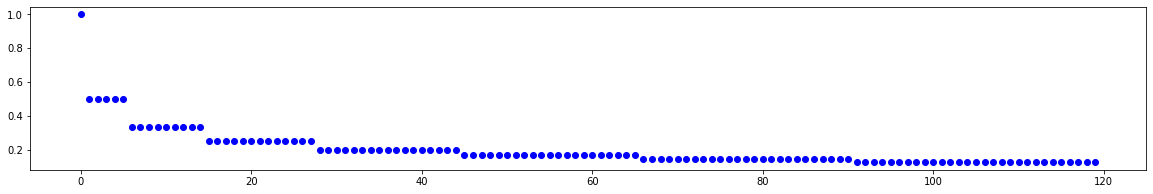

In [75]:
# Mask based on distance

# Set twiss

twiss = Twiss(model, table, limit=8, use_model=True)

# Generate mask

mask, *_ = twiss.mask_distance(lambda x: 1/x)

# Plot weights

plt.figure(figsize=(20, 3))
plt.scatter(range(len(mask)), mask.cpu().numpy(), color='blue')
plt.show()

# Example-07: Bias vs range limit & informed action estimation

In [76]:
# In this example TbT data generated from model with errors is used for twiss inference (without random noise)

# In the case of twiss estimation from phase data, increasing range limit value introduces bias in general
# This bias tends to increase with range limit, but optimal limit might not be equal to one

# In the case of twiss estimation from amplitude data, model twiss is used for action estimation
# If the actual twiss values are off, action estimation is poor and all estimated twiss values are shifted
# Twiss from phase can be used for informed action estimation is this case

In [77]:
# Import correct twiss data at monitor locations

bx_m, ax_m, fx_m, by_m, ay_m, fy_m = numpy.load('../twiss.npy').T

In [78]:
# Compute reference parameters (frequency, amplitude and phase)

df = pandas.read_pickle('../error_tbt.pkl.gz')

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, torch.tensor(df.X.to_list(), dtype=dtype, device=device))
y = Data.from_data(w, torch.tensor(df.Y.to_list(), dtype=dtype, device=device))

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [79]:
# Set near zero noise

noise_x = 1.0E-15*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-15*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.544331291, sigma_nux=5.28138737e-10, error_nux=3.11102255e-11

(ax - ref_ax).abs().sum().item()=3.97055483e-08

(fx - ref_fx).abs().sum().item()=5.43367935e-06



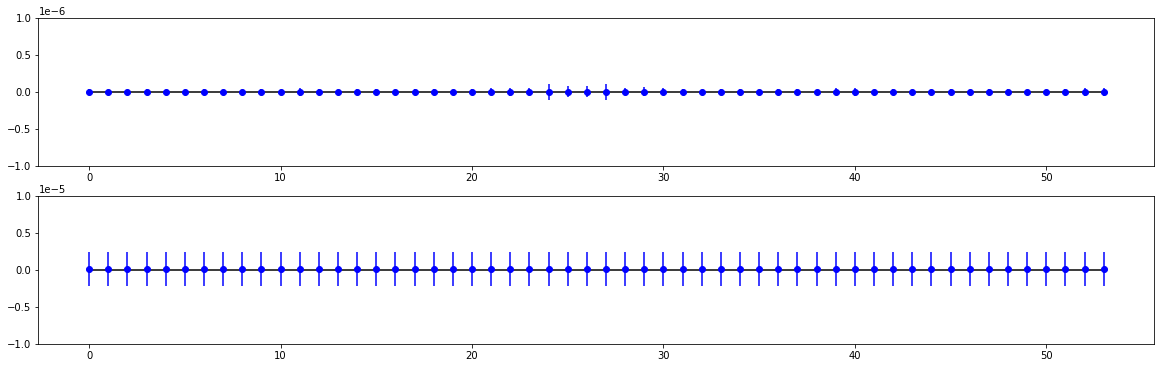

In [80]:
# Compute frequency, amplitude and phase for x plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

nuy= 0.574277342, sigma_nuy=1.42758538e-10, error_nuy=1.42219569e-12

(ay - ref_ay).abs().sum().item()=3.161019e-10

(fy - ref_fy).abs().sum().item()=2.42938717e-07



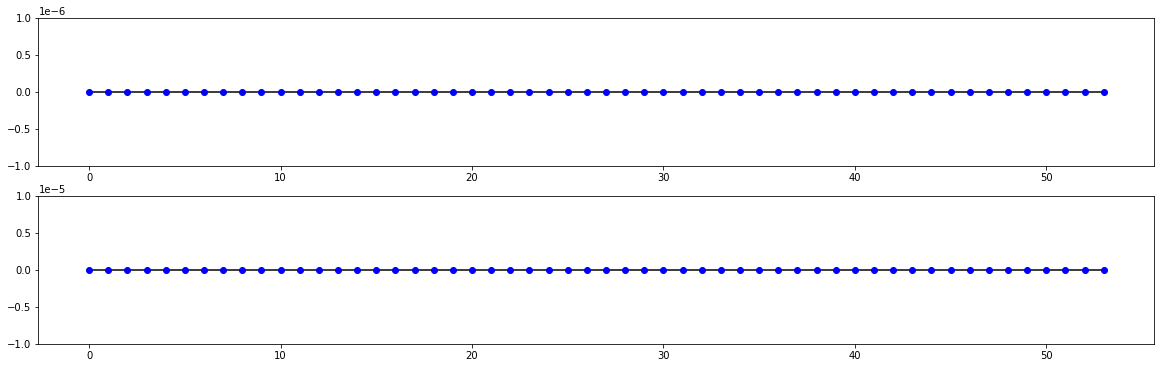

In [81]:
# Compute frequency, amplitude and phase for y plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-1.0E-6, +1.0E-6)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)
plt.show()

In [82]:
# Set model & table

model = Model(path='../config.yaml', dtype=dtype, device=device)
table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

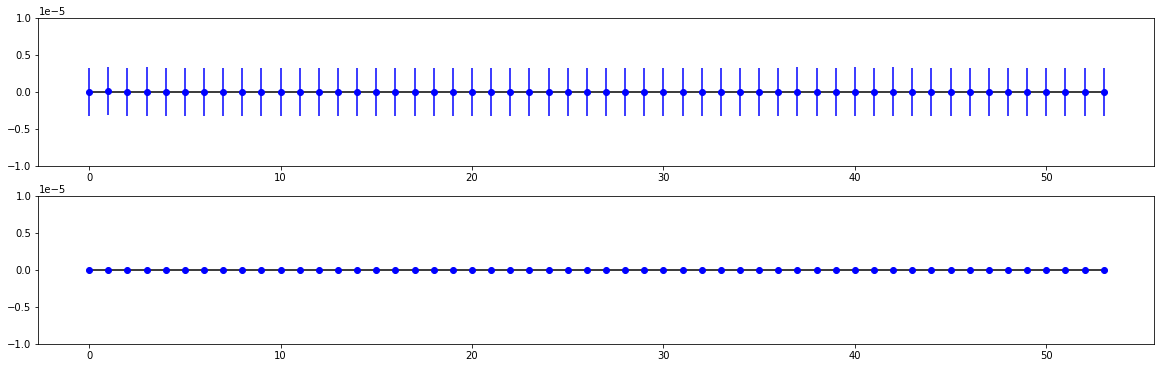

In [83]:
# Compare phase advance between adjacent monitor locations with correct data

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (fx_m - table.phase_x.cpu().numpy()), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-5, +1.0E-5)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy_m - table.phase_y.cpu().numpy()), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-5, +1.0E-5)

plt.show()

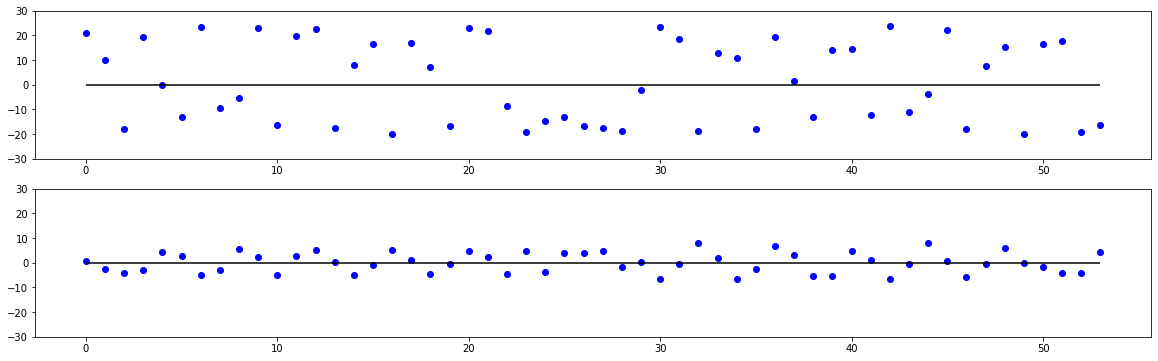

In [84]:
# Compare model twiss with correct twiss

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(model.monitor_count), 100*(bx_m - model.bx[model.monitor_index].cpu().numpy())/model.bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-30, +30)

ax2 = plt.subplot(212)
ax2.scatter(range(model.monitor_count), 100*(by_m - model.by[model.monitor_index].cpu().numpy())/model.by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-30, +30)

plt.show()

In [85]:
# Compute twiss from phase data using different range limit (upto 32)

box = []

for limit in range(1, 32 + 1):

    twiss = Twiss(model, table, limit=limit)

    twiss.phase_virtual()
    twiss.get_twiss_from_phase()
    mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
    mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})

    if twiss.limit != (1, 1):

        twiss.process_twiss(plane='x', mask=mask_x, weight=True)
        twiss.process_twiss(plane='y', mask=mask_y, weight=True)

    else:

        twiss.ax = twiss.data_phase['ax'].flatten()
        twiss.bx = twiss.data_phase['bx'].flatten()
        twiss.ay = twiss.data_phase['ay'].flatten()
        twiss.by = twiss.data_phase['by'].flatten()

        twiss.sigma_ax = twiss.data_phase['sigma_ax'].flatten()
        twiss.sigma_bx = twiss.data_phase['sigma_bx'].flatten()
        twiss.sigma_ay = twiss.data_phase['sigma_ay'].flatten()
        twiss.sigma_by = twiss.data_phase['sigma_by'].flatten()

    bx = twiss.bx[model.monitor_index].cpu().numpy()
    ax = twiss.ax[model.monitor_index].cpu().numpy()
    by = twiss.by[model.monitor_index].cpu().numpy()
    ay = twiss.ay[model.monitor_index].cpu().numpy()

    sigma_bx = twiss.sigma_bx[model.monitor_index].cpu().numpy()
    sigma_ax = twiss.sigma_ax[model.monitor_index].cpu().numpy()
    sigma_by = twiss.sigma_by[model.monitor_index].cpu().numpy()
    sigma_ay = twiss.sigma_ay[model.monitor_index].cpu().numpy()

    box.append(numpy.array([[bx, sigma_bx], [ax, sigma_ax], [by, sigma_by], [ay, sigma_ay]]))
    
    if limit <= 8:
        print(f'limit= {limit}: {"model":>12} {"error":>12}')
        print(f'error_bx: {numpy.abs(model.bx[model.monitor_index].cpu() - bx).sum().item():12.9} {numpy.abs(bx_m - bx).sum().item():12.9}')
        print(f'error_by: {numpy.abs(model.by[model.monitor_index].cpu() - by).sum().item():12.9} {numpy.abs(by_m - by).sum().item():12.9}')
        print(f'error_ax: {numpy.abs(model.ax[model.monitor_index].cpu() - ax).sum().item():12.9} {numpy.abs(ax_m - ax).sum().item():12.9}')
        print(f'error_ay: {numpy.abs(model.ay[model.monitor_index].cpu() - ay).sum().item():12.9} {numpy.abs(ay_m - ay).sum().item():12.9}')
        print()

box = numpy.array(box).T

# As it can be seen, for larger range limit value, bias increases
# Since the effect of noise in this example can be neglected, the discrepancy is only due to the bias
# Still, using limit=1 doesn't provide optimal accuracy
# In this example limit=2 is optimal, for larger values bias is stronger

limit= 1:        model        error
error_bx:   80.5607134  0.998772529
error_by:   29.9780712   3.57418068
error_ax:   18.8607749  0.167697405
error_ay:   5.98873511  0.554359634

limit= 2:        model        error
error_bx:   80.4203638  0.832616786
error_by:   29.0689789   2.18677546
error_ax:   18.8437398  0.211484319
error_ay:   5.80501876  0.318376768

limit= 3:        model        error
error_bx:   78.0119711   3.03301917
error_by:   29.9587699   3.22434037
error_ax:   18.0394659   1.03403371
error_ay:    6.2059538  0.664177666

limit= 4:        model        error
error_bx:   80.7601045   2.58658829
error_by:   30.0301611   3.41965899
error_ax:   19.5902744   1.02870297
error_ay:   6.19539645  0.640126796

limit= 5:        model        error
error_bx:   83.5722095   3.82106165
error_by:   29.5509297   3.15078589
error_ax:   19.8254475   1.09516833
error_ay:   5.92889951  0.506254799

limit= 6:        model        error
error_bx:   84.5567195   4.98117006
error_by:   29.7455164 

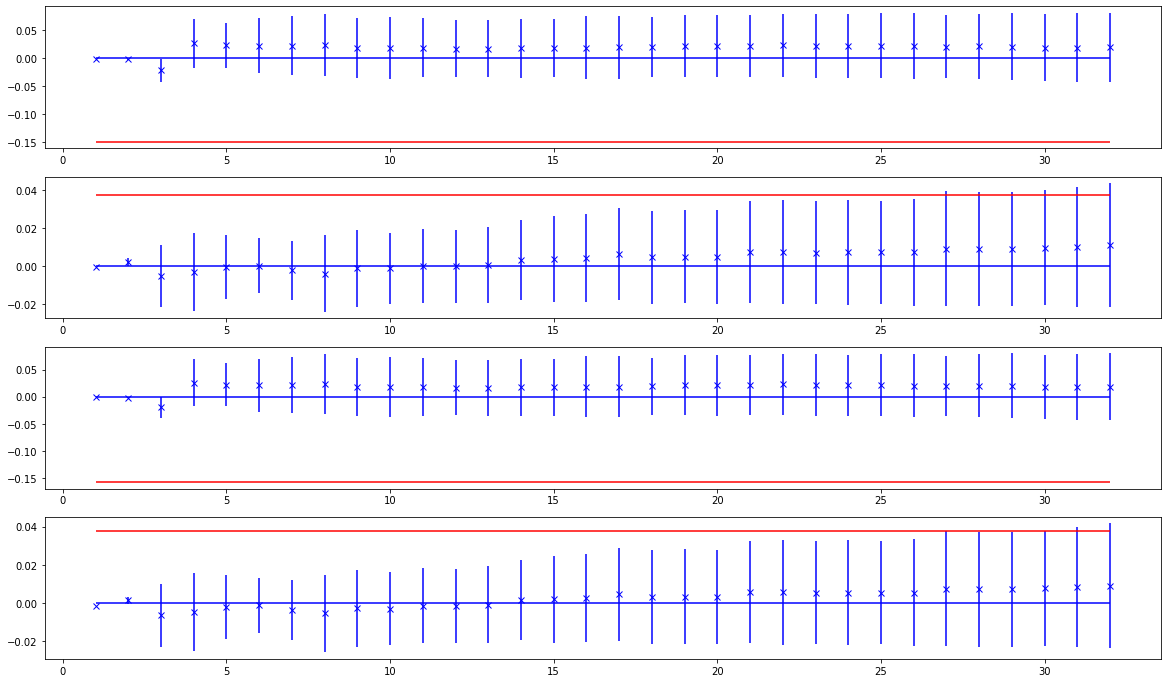

In [86]:
# Examine data for selected location

index = 25
out, sigma_out = box[index]

bx, ax, by, ay = out
sigma_bx, sigma_ax, sigma_by, sigma_ay = sigma_out

plt.figure(figsize=(20, 4*3))

ax1 = plt.subplot(411)
ax1.errorbar(range(1, 1 + len(bx)), (bx_m[index] - bx)/bx_m[index], yerr=sigma_bx/bx_m[index], fmt=' ', marker='x', color='blue')
ax1.hlines(0, 1, len(bx), colors='blue')
ax1.hlines((bx_m[index] - model.bx[model.monitor_index][index].cpu())/bx_m[index], 1, len(bx), colors='red')

ax2 = plt.subplot(412)
ax2.errorbar(range(1, 1 + len(by)), (by_m[index] - by)/by_m[index], yerr=sigma_by/by_m[index], fmt=' ', marker='x', color='blue')
ax2.hlines(0, 1, len(by), colors='blue')
ax2.hlines((by_m[index] - model.by[model.monitor_index][index].cpu())/by_m[index], 1, len(by), colors='red')

ax3 = plt.subplot(413)
ax3.errorbar(range(1, 1 + len(ax)), (ax_m[index] - ax)/ax_m[index], yerr=sigma_ax/ax_m[index], fmt=' ', marker='x', color='blue')
ax3.hlines(0, 1, len(ax), colors='blue')
ax3.hlines((ax_m[index] - model.ax[model.monitor_index][index].cpu())/ax_m[index], 1, len(bx), colors='red')

ax4 = plt.subplot(414)
ax4.errorbar(range(1, 1 + len(ay)), (ay_m[index] - ay)/ay_m[index], yerr=sigma_ay/ay_m[index], fmt=' ', marker='x', color='blue')
ax4.hlines(0, 1, len(ay), colors='blue')
ax4.hlines((ay_m[index] - model.ay[model.monitor_index][index].cpu())/ay_m[index], 1, len(bx), colors='red')

plt.show()

# Note, this bias will decrease for corrected lattice

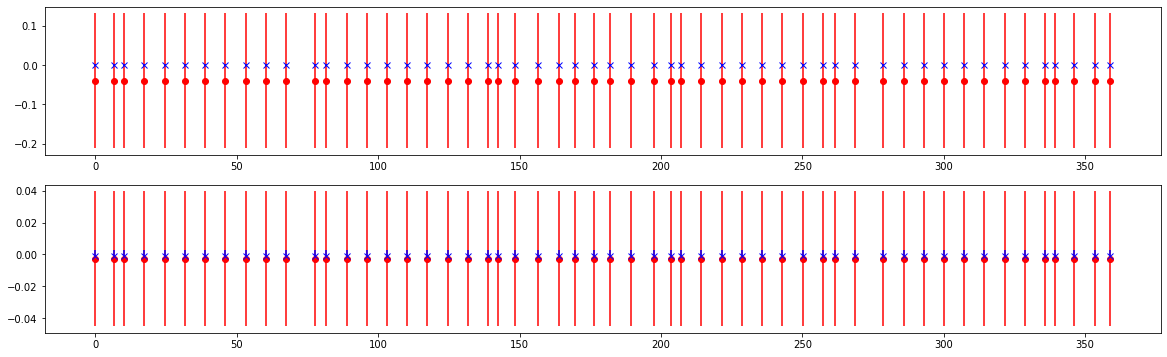

In [87]:
# Compute twiss from amplitude using twiss from phase data for action estimation

# Set twiss instance

twiss = Twiss(model, table, limit=4)


# Compute twiss from phase data
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)


# Twiss from amplitude using model for action estimation

twiss.get_action()
twiss.get_twiss_from_amplitude()
bx_1 = twiss.data_amplitude['bx'].cpu().numpy()
by_1 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_1 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_1 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Twiss from amplitude using twiss from phase for action estimation

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()
bx_2 = twiss.data_amplitude['bx'].cpu().numpy()
by_2 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_2 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_2 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Compare

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_1)/bx_m, yerr=sigma_bx_1/bx_m, fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_2)/bx_m, yerr=sigma_bx_2/bx_m, fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_1)/by_m, yerr=sigma_by_1/by_m, fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_2)/by_m, yerr=sigma_by_2/by_m, fmt=' ', marker='x', color='blue')

plt.show()

# Note, bias from action estimation (all values are shifted) is corrected

# Example-08: Twiss from test signals

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# This example is similar to the previous one, but test TbT data is generated using Model functions
# Quadrupole errors are added to each sector

In [4]:
# Set model

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(5.0E-4, 5.0E-4, length=0.0)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)

True


In [5]:
# Set correct twiss data at monitor locations

from harmonica.parameterization import wolski_to_cs

ax_m, bx_m, ay_m, by_m = torch.stack([wolski_to_cs(model.out_wolski[i]) for i in model.monitor_index]).T

ax_m, bx_m, ay_m, by_m = ax_m.cpu().numpy(), bx_m.cpu().numpy(), ay_m.cpu().numpy(), by_m.cpu().numpy()

probe = torch.tensor(model.monitor_index)
other = probe.roll(-1, 0)

fx_m, fy_m = model.out_advance.T

fx_m = fx_m.roll(1, 0).cumsum(-1)
fx_m = fx_m[other] - fx_m[probe]
fx_m[-1] += 2.0*numpy.pi*model.out_tune[0]

fy_m = fy_m.roll(1, 0).cumsum(-1)
fy_m = fy_m[other] - fy_m[probe]
fy_m[-1] += 2.0*numpy.pi*model.out_tune[1]

fx_m, fy_m = fx_m.cpu().numpy(), fy_m.cpu().numpy()


print(torch.stack([model.nux, model.nuy]))
print(model.out_tune)

tensor([8.536883098737e+00, 7.576774633326e+00], dtype=torch.float64)
tensor([8.542301421784e+00, 7.573980415823e+00], dtype=torch.float64)


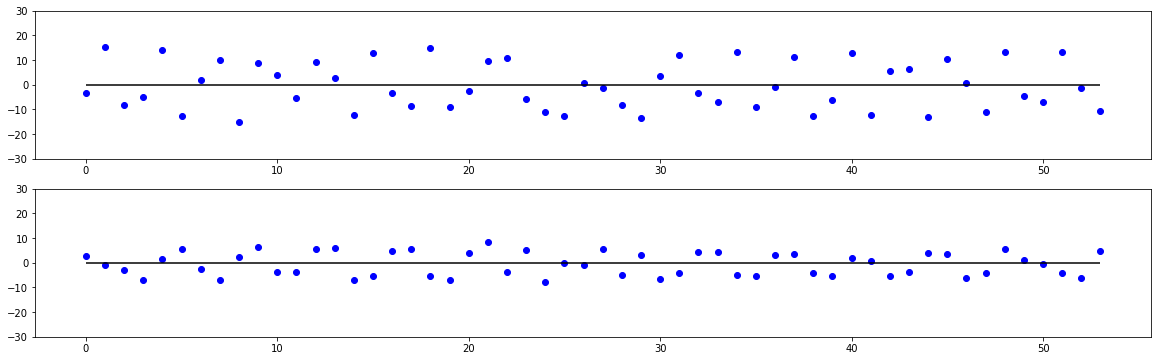

In [6]:
# Compare model twiss with correct twiss

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.scatter(range(model.monitor_count), 100*(bx_m - model.bx[model.monitor_index].cpu().numpy())/model.bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-30, +30)

ax2 = plt.subplot(212)
ax2.scatter(range(model.monitor_count), 100*(by_m - model.by[model.monitor_index].cpu().numpy())/model.by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-30, +30)

plt.show()

In [7]:
# Compute reference parameters (frequency, amplitude and phase)

length = 4096
w = Window(length, 'cosine_window', 4.0, dtype=dtype, device=device)

x = Data.from_data(w, trajectory[model.monitor_index, :, 0])
y = Data.from_data(w, trajectory[model.monitor_index, :, 2])

f = Frequency(x)
x.window_remove_mean()
x.window_apply()
f('parabola')
x.reset()
ref_nux, ref_sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(x)
result, _ = d.harmonic_sum(ref_nux, w.window, x.data)
_, _, ref_ax, ref_fx = result.T

f = Frequency(y)
y.window_remove_mean()
y.window_apply()
f('parabola')
y.reset()
ref_nuy, ref_sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
d = Decomposition(y)
result, _ = d.harmonic_sum(ref_nuy, w.window, y.data)
_, _, ref_ay, ref_fy = result.T

In [8]:
# Set noise

noise_x = 1.0E-6*(25.0 + 25.0*torch.rand(x.size, dtype=dtype, device=device))
noise_y = 1.0E-6*(25.0 + 25.0*torch.rand(y.size, dtype=dtype, device=device))

nux= 0.542301385, sigma_nux=5.0063061e-07, error_nux=3.67539095e-08

(ax - ref_ax).abs().sum().item()=0.000108197772

(fx - ref_fx).abs().sum().item()=0.0292605885



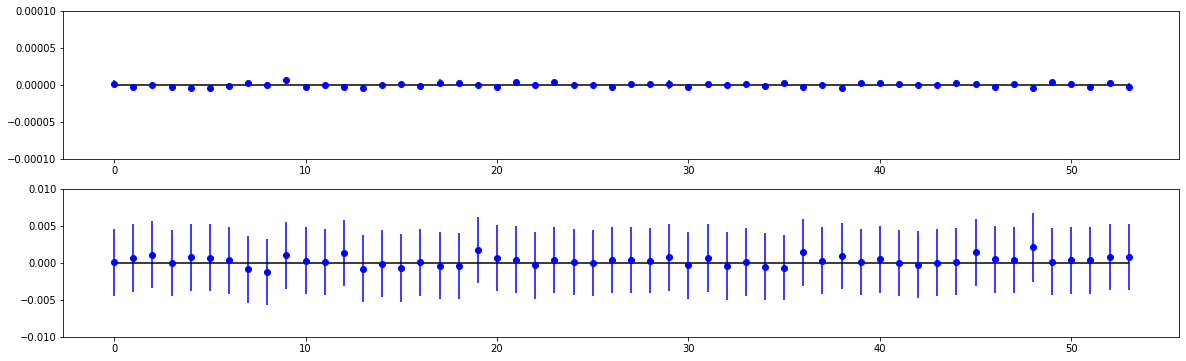

In [9]:
# Compute frequency, amplitude and phase for x plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, x.data[:, :length])
d.add_noise(noise_x)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(ref_nux - nux).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
print(f'{(ax - ref_ax).abs().sum().item()=:12.9}')
print()

fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')
print(f'{(fx - ref_fx).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(x.size), (ax - ref_ax).cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, x.size - 1, colors='black')
ax1.set_ylim(-1.0E-4, +1.0E-4)
ax2 = plt.subplot(212)
ax2.errorbar(range(x.size), (fx - ref_fx).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, x.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

# Coupling
axy, sigma_axy, _ = d.harmonic_amplitude(ref_nuy, length=256, order=1.0, error=True, sigma_frequency=None, shift=True, count=64, step=8, method='noise')

nuy= 0.573980371, sigma_nuy=1.52100415e-06, error_nuy=4.46879047e-08

(ay - ref_ay).abs().sum().item()=9.36990966e-05

(fy - ref_fy).abs().sum().item()=0.0500203231



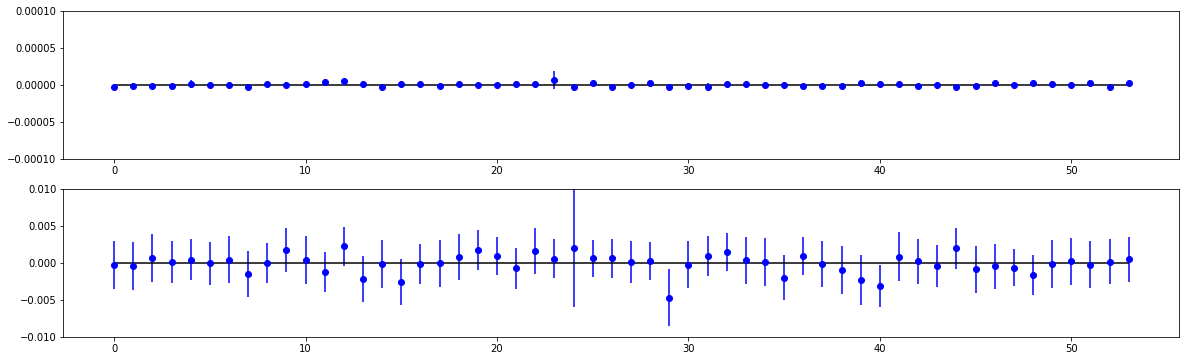

In [10]:
# Compute frequency, amplitude and phase for y plane

length = 1024
w = Window(length, 'cosine_window', 1.0, dtype=dtype, device=device)
d = Data.from_data(w, y.data[:, :length])
d.add_noise(noise_y)
d.data.copy_(d.work)

# Frequency

f = Frequency(d)
d.window_remove_mean()
d.window_apply()
f('parabola')
d.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(ref_nuy - nuy).item():12.9}')
print()

# Amplitude & phase

d = Decomposition(d)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
print(f'{(ay - ref_ay).abs().sum().item()=:12.9}')
print()

fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')
print(f'{(fy - ref_fy).abs().sum().item()=:12.9}')
print()

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.errorbar(range(y.size), (ay - ref_ay).cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, y.size - 1, colors='black')
ax1.set_ylim(-1.0E-4, +1.0E-4)
ax2 = plt.subplot(212)
ax2.errorbar(range(y.size), (fy - ref_fy).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, y.size - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)
plt.show()

# Coupling
ayx, sigma_ayx, _ = d.harmonic_amplitude(ref_nux, length=256, order=1.0, error=True, sigma_frequency=None, shift=True, count=64, step=8, method='noise')

In [11]:
# Set table

table = Table([name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy, dtype=dtype, device=device)

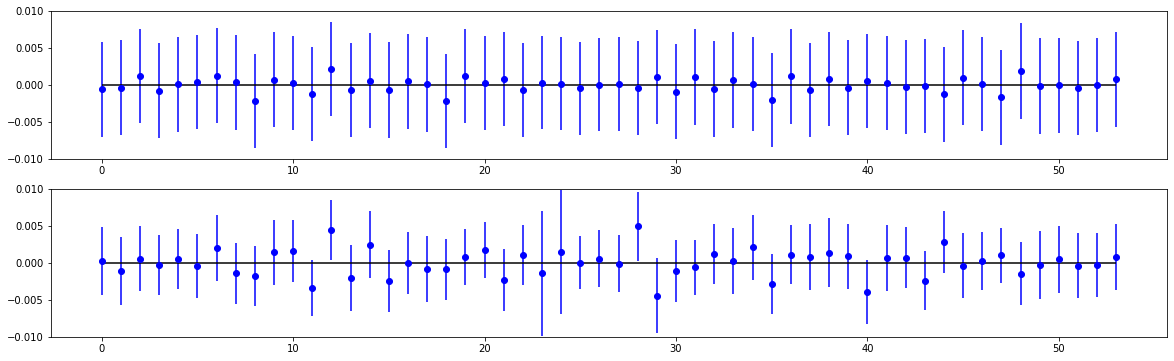

In [12]:
# Compare phase advance between adjacent monitor locations with correct data

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (fx_m - table.phase_x.cpu().numpy()), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (fy_m - table.phase_y.cpu().numpy()), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [13]:
# Compute twiss from phase data using different range limit (upto 32)

box = []

for limit in range(1, 32 + 1):

    twiss = Twiss(model, table, limit=limit)

    twiss.phase_virtual()
    twiss.get_twiss_from_phase()
    mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
    mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': True, 'threshold': 0.5}, sigma={'use': True, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})

    if twiss.limit != (1, 1):

        twiss.process_twiss(plane='x', mask=mask_x, weight=True)
        twiss.process_twiss(plane='y', mask=mask_y, weight=True)

    else:

        twiss.ax = twiss.data_phase['ax'].flatten()
        twiss.bx = twiss.data_phase['bx'].flatten()
        twiss.ay = twiss.data_phase['ay'].flatten()
        twiss.by = twiss.data_phase['by'].flatten()

        twiss.sigma_ax = twiss.data_phase['sigma_ax'].flatten()
        twiss.sigma_bx = twiss.data_phase['sigma_bx'].flatten()
        twiss.sigma_ay = twiss.data_phase['sigma_ay'].flatten()
        twiss.sigma_by = twiss.data_phase['sigma_by'].flatten()

    bx = twiss.bx[model.monitor_index].cpu().numpy()
    ax = twiss.ax[model.monitor_index].cpu().numpy()
    by = twiss.by[model.monitor_index].cpu().numpy()
    ay = twiss.ay[model.monitor_index].cpu().numpy()

    sigma_bx = twiss.sigma_bx[model.monitor_index].cpu().numpy()
    sigma_ax = twiss.sigma_ax[model.monitor_index].cpu().numpy()
    sigma_by = twiss.sigma_by[model.monitor_index].cpu().numpy()
    sigma_ay = twiss.sigma_ay[model.monitor_index].cpu().numpy()

    box.append(numpy.array([[bx, sigma_bx], [ax, sigma_ax], [by, sigma_by], [ay, sigma_ay]]))
    
    if limit <= 8:
        print(f'limit= {limit}: {"model":>12} {"error":>12}')
        print(f'error_bx: {numpy.abs(model.bx[model.monitor_index].cpu() - bx).sum().item():12.9} {numpy.abs(bx_m - bx).sum().item():12.9}')
        print(f'error_by: {numpy.abs(model.by[model.monitor_index].cpu() - by).sum().item():12.9} {numpy.abs(by_m - by).sum().item():12.9}')
        print(f'error_ax: {numpy.abs(model.ax[model.monitor_index].cpu() - ax).sum().item():12.9} {numpy.abs(ax_m - ax).sum().item():12.9}')
        print(f'error_ay: {numpy.abs(model.ay[model.monitor_index].cpu() - ay).sum().item():12.9} {numpy.abs(ay_m - ay).sum().item():12.9}')
        print()

box = numpy.array(box).T

# As it can be seen, for larger range limit value, bias increases
# Since the effect of noise in this example can be neglected, the discrepancy is only due to the bias
# Still, using limit=1 doesn't provide optimal accuracy
# In this example limit=2 is optimal, for larger values bias is stronger

limit= 1:        model        error
error_bx:   39.4694255    3.9531697
error_by:   31.6630149   8.62974512
error_ax:   9.48047127  0.757997027
error_ay:   4.81289997   1.48561502

limit= 2:        model        error
error_bx:   39.4220451   3.95267321
error_by:   30.0033713   7.38584534
error_ax:    9.5006572  0.744765037
error_ay:   4.44559092   1.22551954

limit= 3:        model        error
error_bx:   39.2277417   4.35867148
error_by:   30.3658959   6.37293395
error_ax:   9.35316027  0.818233077
error_ay:   4.50778657   1.11426368

limit= 4:        model        error
error_bx:   38.0166257   5.10203848
error_by:   29.9990338   6.02117711
error_ax:   9.30319894  0.997235275
error_ay:   4.40835209   1.08479304

limit= 5:        model        error
error_bx:   39.1018819   4.74744784
error_by:   30.3389284   7.57993853
error_ax:   9.17906158  0.910141166
error_ay:   4.48829716   1.27055366

limit= 6:        model        error
error_bx:   39.0913839   4.67509178
error_by:   30.5373177 

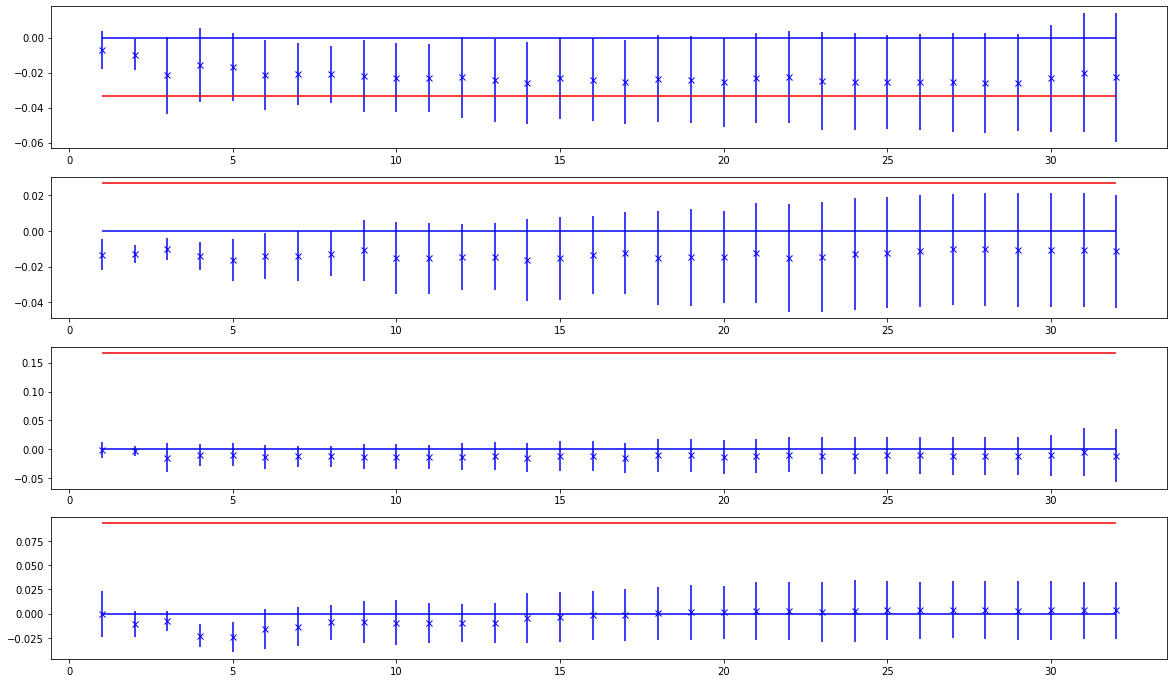

In [14]:
# Examine data for selected location

index = 0
out, sigma_out = box[index]

bx, ax, by, ay = out
sigma_bx, sigma_ax, sigma_by, sigma_ay = sigma_out

plt.figure(figsize=(20, 4*3))

ax1 = plt.subplot(411)
ax1.errorbar(range(1, 1 + len(bx)), (bx_m[index] - bx)/bx_m[index], yerr=sigma_bx/bx_m[index], fmt=' ', marker='x', color='blue')
ax1.hlines(0, 1, len(bx), colors='blue')
ax1.hlines((bx_m[index] - model.bx[model.monitor_index][index].cpu())/bx_m[index], 1, len(bx), colors='red')

ax2 = plt.subplot(412)
ax2.errorbar(range(1, 1 + len(by)), (by_m[index] - by)/by_m[index], yerr=sigma_by/by_m[index], fmt=' ', marker='x', color='blue')
ax2.hlines(0, 1, len(by), colors='blue')
ax2.hlines((by_m[index] - model.by[model.monitor_index][index].cpu())/by_m[index], 1, len(by), colors='red')

ax3 = plt.subplot(413)
ax3.errorbar(range(1, 1 + len(ax)), (ax_m[index] - ax)/ax_m[index], yerr=sigma_ax/ax_m[index], fmt=' ', marker='x', color='blue')
ax3.hlines(0, 1, len(ax), colors='blue')
ax3.hlines((ax_m[index] - model.ax[model.monitor_index][index].cpu())/ax_m[index], 1, len(bx), colors='red')

ax4 = plt.subplot(414)
ax4.errorbar(range(1, 1 + len(ay)), (ay_m[index] - ay)/ay_m[index], yerr=sigma_ay/ay_m[index], fmt=' ', marker='x', color='blue')
ax4.hlines(0, 1, len(ay), colors='blue')
ax4.hlines((ay_m[index] - model.ay[model.monitor_index][index].cpu())/ay_m[index], 1, len(bx), colors='red')

plt.show()

# Note, this bias will decrease for corrected lattice

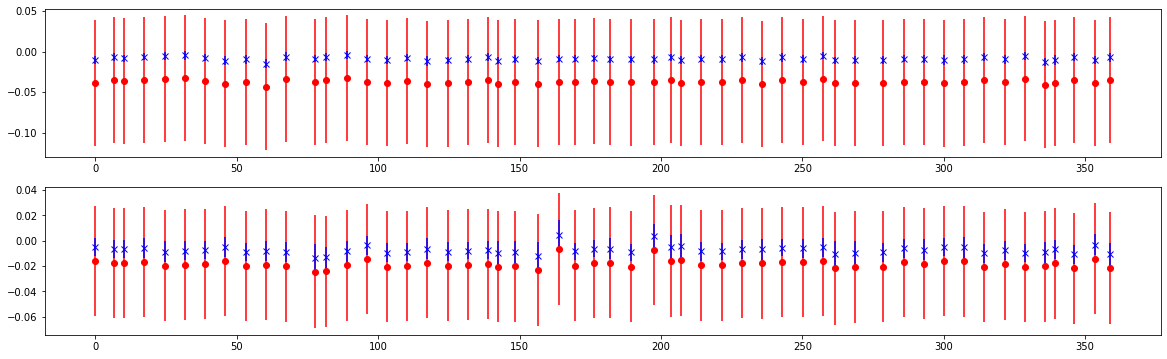

In [15]:
# Compute twiss from amplitude using twiss from phase data for action estimation

# Set twiss instance

twiss = Twiss(model, table, limit=4)


# Compute twiss from phase data
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': False, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)


# Twiss from amplitude using model for action estimation

twiss.get_action()
twiss.get_twiss_from_amplitude()
bx_1 = twiss.data_amplitude['bx'].cpu().numpy()
by_1 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_1 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_1 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Twiss from amplitude using twiss from phase for action estimation

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()
bx_2 = twiss.data_amplitude['bx'].cpu().numpy()
by_2 = twiss.data_amplitude['by'].cpu().numpy()
sigma_bx_2 = twiss.data_amplitude['sigma_bx'].cpu().numpy()
sigma_by_2 = twiss.data_amplitude['sigma_by'].cpu().numpy()

# Compare

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_1)/bx_m, yerr=sigma_bx_1/bx_m, fmt=' ', marker='o', color='red')
ax1.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (bx_m - bx_2)/bx_m, yerr=sigma_bx_2/bx_m, fmt=' ', marker='x', color='blue')

ax2 = plt.subplot(212)
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_1)/by_m, yerr=sigma_by_1/by_m, fmt=' ', marker='o', color='red')
ax2.errorbar(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), (by_m - by_2)/by_m, yerr=sigma_by_2/by_m, fmt=' ', marker='x', color='blue')

plt.show()

# Note, bias from action estimation (all values are shifted) is corrected

In [16]:
# Action spead (coupling)

print(twiss.action['spread_jx']/twiss.action['center_jx'])
print(twiss.action['spread_jy']/twiss.action['center_jy'])

tensor(4.217655535613e-03, dtype=torch.float64)
tensor(6.698255354922e-03, dtype=torch.float64)


tensor(4.779959212744e-02, dtype=torch.float64)
tensor(1.901386788000e-01, dtype=torch.float64)


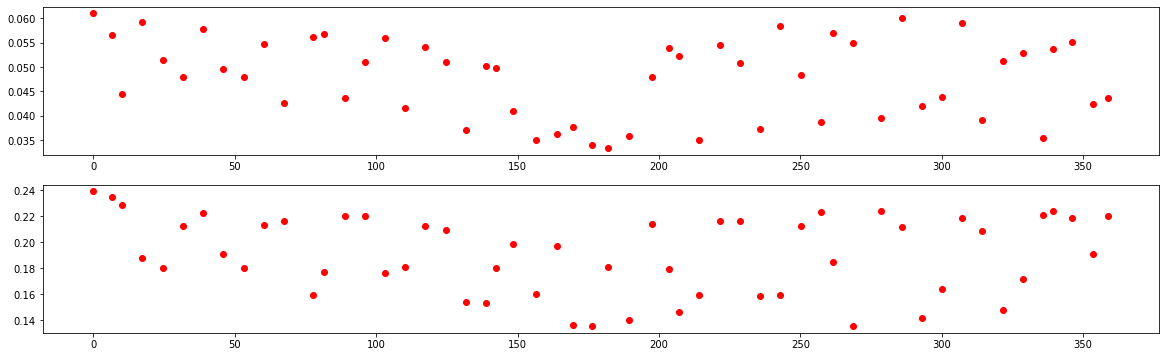

In [17]:
# Ratio (coupling)
# Can compute sigma

rx = axy/table.ax
ry = ayx/table.ay

print(rx.mean())
print(ry.mean())

plt.figure(figsize=(20, 3*2))
ax1 = plt.subplot(211)
ax1.scatter(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), rx, marker='o', color='red')
ax2 = plt.subplot(212)
ax2.scatter(twiss.model.time[twiss.model.monitor_index].cpu().numpy(), ry, marker='o', color='red')
plt.show()

# Example-09: Momenta estimation & virtual trajectories

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# Momenta data can be used to estimate twiss parameters, but it can't be measured directly
# Given coordinates at monitor locations, momenta data can be estimated for given model or measured transport between locations
# Monenta generating functions require a callable that generates transport matrix between locations

# For linear motion, monenta can be computed using transport matrix between locations
# This matrix can be obtained from model or constructed from measured twiss parameters
# For nonlinear case, generating functions can be used to estimate momenta from coordinates

# In this example linear relation between locations is assumed

# Several methods of momenta estimation are avaliable:
# 1) Estimation from a single pair (using model or measured transport matrix)
# 2) Estimation from several pairs (using model or measured transport matrix), average result over pairs
# 3) Estimation from several locations (using model or measured transport matrix), least square fit both coordinates and momenta

In [4]:
# Set model

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(0.0, 0.0, length=0.0)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

In [6]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [7]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.536883099
nux= 0.536883113, sigma_nux=1.38327543e-07, error_nux=1.44115821e-08


In [8]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.576774633
nuy= 0.576774626, sigma_nuy=1.46933363e-07, error_nuy=6.88817337e-09


In [9]:
# Set table (without noise)

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], 
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=x,
    y=y,
    dtype=dtype, device=device)

In [10]:
# Set twiss

twiss = Twiss(model, table)

In [11]:
# Compute momenta at selected location

start = 16       # -- first turn
count = 128      # -- total number of turns, result is computed for (start, start + total)
probe = 10       # -- probe location
other = 11       # -- other location (can be any integer not equal to probe)
limit = 1        # -- range of locations around probe, e.g. for probe=10 and limit=11, other used locations are 9 and 11

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from a single pair

qx, px, qy, py = twiss.get_momenta(start, count, probe, other, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from range of pairs (average)

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(0., dtype=torch.float64)
tensor(1.382738934745e-17, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(9.036147481309e-18, dtype=torch.float64)

tensor(0., dtype=torch.float64)
tensor(1.096441798573e-17, dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor(6.373075895141e-18, dtype=torch.float64)

tensor(3.592436135895e-17, dtype=torch.float64)
tensor(2.195382344341e-17, dtype=torch.float64)
tensor(6.381885037793e-17, dtype=torch.float64)
tensor(8.751544411031e-18, dtype=torch.float64)



In [12]:
# Set table (with noise)

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], 
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

In [13]:
# Set twiss

twiss = Twiss(model, table)

In [14]:
# Compute momenta at selected location

start = 16       # -- first turn
count = 128      # -- total number of turns, result is computed for (start, start + total)
probe = 10       # -- probe location
other = 11       # -- other location (can be any integer not equal to probe)
limit = 1        # -- range of locations around probe, e.g. for probe=10 and limit=11, other used locations are 9 and 11

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from a single pair

qx, px, qy, py = twiss.get_momenta(start, count, probe, other, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()


# Compute momenta from range of pairs (average)

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()


# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(7.155584462462e-04, dtype=torch.float64)
tensor(1.541907278114e-04, dtype=torch.float64)
tensor(9.705576681472e-04, dtype=torch.float64)
tensor(1.716837398820e-04, dtype=torch.float64)

tensor(7.155584462462e-04, dtype=torch.float64)
tensor(1.949841961598e-04, dtype=torch.float64)
tensor(9.705576681472e-04, dtype=torch.float64)
tensor(1.167546139071e-04, dtype=torch.float64)

tensor(6.809879802600e-04, dtype=torch.float64)
tensor(1.541867499208e-04, dtype=torch.float64)
tensor(8.521562142544e-04, dtype=torch.float64)
tensor(1.021055249664e-04, dtype=torch.float64)



In [15]:
# Set model with normal errors

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 1.0E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


In [16]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

In [17]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [18]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.585609534
nux= 0.585609583, sigma_nux=1.54746951e-07, error_nux=4.8569924e-08


In [19]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.603304957
nuy= 0.603304979, sigma_nuy=1.54113334e-07, error_nuy=2.20050633e-08


In [20]:
# Set table (with noise)

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'], 
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

In [21]:
# Set & compute twiss

twiss = Twiss(model, table)
twiss() ;

In [22]:
# Compute momenta at selected location

start = 16
count = 128
probe = 10
other = 11

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from a single pair

qx, px, qy, py = twiss.get_momenta(start, count, probe, other, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from a single pair (uncoupled measured transport)

qx, px, qy, py = twiss.get_momenta(start, count, probe, other, twiss.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(5.880343944736e-04, dtype=torch.float64)
tensor(2.878665155971e-04, dtype=torch.float64)
tensor(7.401044103529e-04, dtype=torch.float64)
tensor(3.691709261099e-04, dtype=torch.float64)

tensor(5.880343944736e-04, dtype=torch.float64)
tensor(3.970019923480e-04, dtype=torch.float64)
tensor(7.401044103529e-04, dtype=torch.float64)
tensor(4.402070572737e-04, dtype=torch.float64)



In [23]:
# Compute momenta at selected location

start = 16
count = 128
probe = 10
limit = 4

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from range of pairs (average) 

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from range of pairs (average) (measured uncoupled transport)

qx, px, qy, py = twiss.get_momenta_range(start, count, probe, limit, twiss.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(5.880343944736e-04, dtype=torch.float64)
tensor(2.398787581467e-03, dtype=torch.float64)
tensor(7.401044103529e-04, dtype=torch.float64)
tensor(1.415496822417e-03, dtype=torch.float64)

tensor(5.880343944736e-04, dtype=torch.float64)
tensor(2.878803977058e-03, dtype=torch.float64)
tensor(7.401044103529e-04, dtype=torch.float64)
tensor(4.199092972026e-03, dtype=torch.float64)



In [24]:
# Compute momenta at selected location

start = 16
count = 128
probe = 10
limit = 4

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit, model.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

# Compute momenta from range of locations (fit) (measured uncoupled transport)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, probe, limit, twiss.matrix)

# Compare

print((QX - qx).abs().sum())
print((PX - px).abs().sum())
print((QY - qy).abs().sum())
print((PY - py).abs().sum())
print()

tensor(1.454428319508e-03, dtype=torch.float64)
tensor(4.007482135952e-04, dtype=torch.float64)
tensor(2.049730261598e-03, dtype=torch.float64)
tensor(3.647395388643e-04, dtype=torch.float64)

tensor(9.191594369908e-04, dtype=torch.float64)
tensor(3.903853526424e-04, dtype=torch.float64)
tensor(4.283306453541e-04, dtype=torch.float64)
tensor(3.698242284746e-04, dtype=torch.float64)



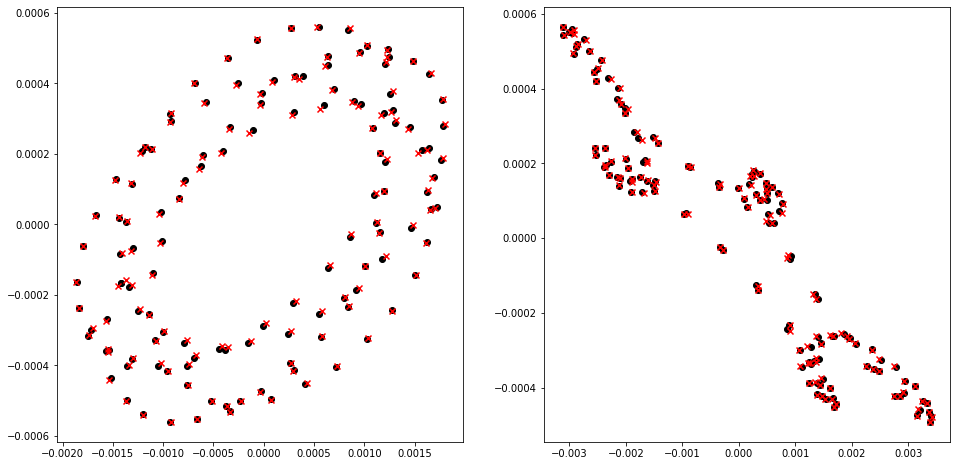

In [25]:
# get_momenta_lstsq method can be used to fit orbit data at virtual locations
# In this case monitors in given range are used to fit both coordinates and momenta at (virtual) location

start = 16
count = 128
probe = 10
limit = 2

# Set reference values

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

# Note, in this case probe is a location (not monitor location!)

index = model.monitor_index[probe]

# Compute momenta from range of locations (fit)

qx, px, qy, py = twiss.get_momenta_lstsq(start, count, index, limit, model.matrix, phony=True, forward=True, inverse=True)

# Compare

plt.figure(figsize=(2*8, 8))

ax = plt.subplot(121)
ax.scatter(QX, PX, marker='o', color='black')
ax.scatter(qx, px, marker='x', color='red')

ax = plt.subplot(122)
ax.scatter(QY, PY, marker='o', color='black')
ax.scatter(qy, py, marker='x', color='red')

plt.show()

In [26]:
# Compute parameters from virtual signals (frequency, amplitude and phase)

# Here, each signal is treated as virtual
# One can use virtual parameters (amplitudes and phases) for twiss
# Or use phases for transport matrices

In [27]:
# Generate virtual data

# Note, start is shifted to use data from different turns, phase should be adjusted

start = 1
count = length - 1 - start
limit = 2

VQX = torch.zeros_like(X.data)
VPX = torch.zeros_like(X.data)
VQY = torch.zeros_like(Y.data)
VPY = torch.zeros_like(Y.data)

# Note, several last values are zeros

for index, location in enumerate(model.monitor_index):
    
    qx, px, qy, py = twiss.get_momenta_lstsq(start, count, location, limit, model.matrix, phony=True, forward=True, inverse=True)
    
    VQX[index, :count] = qx
    VPX[index, :count] = px
    
    VQY[index, :count] = qy
    VPY[index, :count] = py

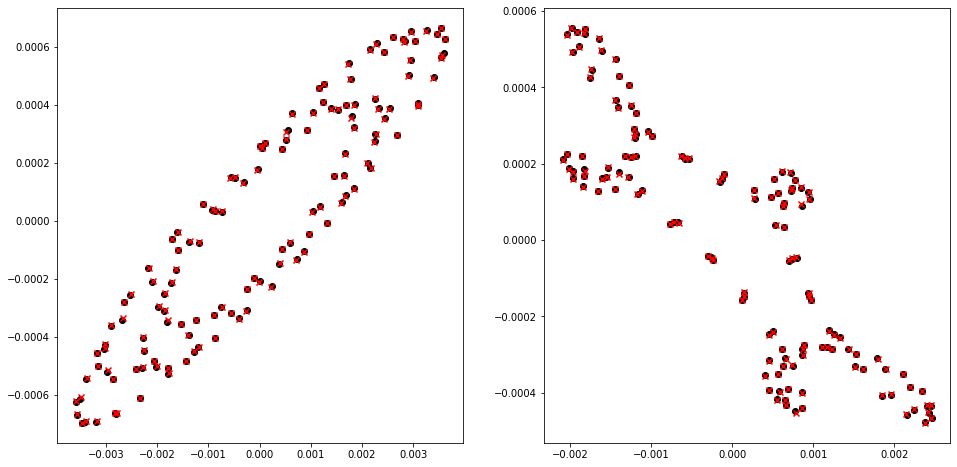

In [28]:
# Compare trajectories

probe = 30
count = 128

QX, PX, QY, PY = trajectory.swapaxes(0, -1)
QX, PX, QY, PY = QX[start:start + count, probe], PX[start:start + count, probe], QY[start:start + count, probe], PY[start:start + count, probe]

qx, px, qy, py = VQX[probe, :count], VPX[probe, :count], VQY[probe, :count], VPY[probe, :count]

plt.figure(figsize=(2*8, 8))

ax = plt.subplot(121)
ax.scatter(QX, PX, marker='o', color='black')
ax.scatter(qx, px, marker='x', color='red')

ax = plt.subplot(122)
ax.scatter(QY, PY, marker='o', color='black')
ax.scatter(qy, py, marker='x', color='red')

plt.show()

In [29]:
# Set TbT

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

X = Data.from_data(win, VQX)
Y = Data.from_data(win, VQY)

print(X)
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [30]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.585609534
nux= 0.585609588, sigma_nux=1.35446188e-07, error_nux=5.43376782e-08


In [31]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.603304957
nuy= 0.603304994, sigma_nuy=1.25673551e-07, error_nuy=3.76807098e-08


In [32]:
# Compare frequencies

print(nux)
print(table.nux)
print()

print(nuy)
print(table.nuy)
print()

tensor(5.856095884514e-01, dtype=torch.float64)
tensor(5.856095826837e-01, dtype=torch.float64)

tensor(6.033049942310e-01, dtype=torch.float64)
tensor(6.033049785554e-01, dtype=torch.float64)



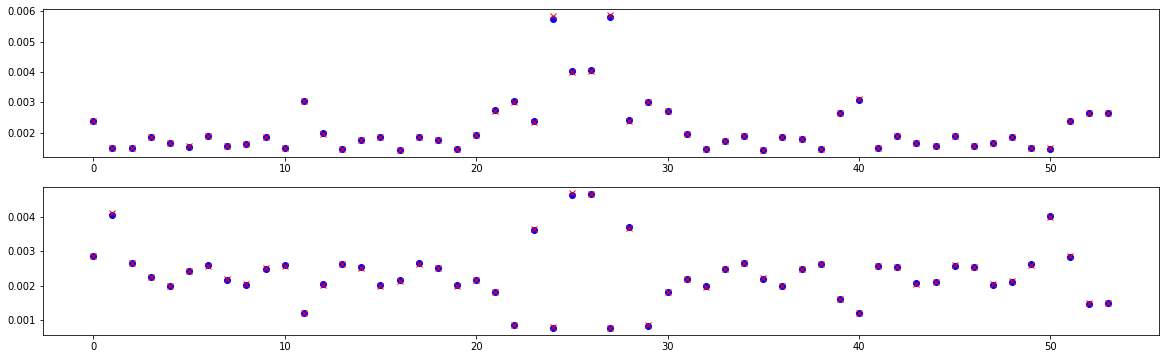

In [33]:
# Compare amplitudes

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), table.ax.cpu().numpy(), yerr=table.sigma_ax.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(range(model.monitor_count), ax.cpu().numpy(), yerr=sigma_ax.cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), table.ay.cpu().numpy(), yerr=table.sigma_ay.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(range(model.monitor_count), ay.cpu().numpy(), yerr=sigma_ay.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

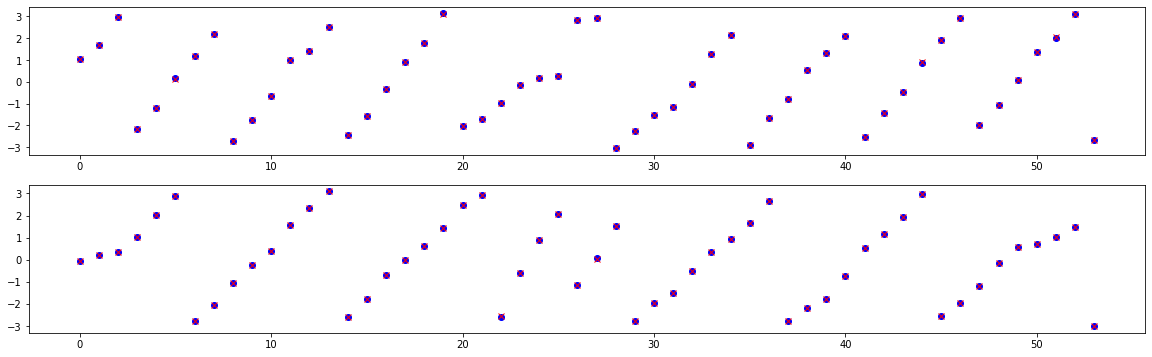

In [34]:
# Compare phases

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), table.fx.cpu().numpy(), yerr=table.sigma_fx.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.errorbar(range(model.monitor_count), mod(fx - 2.0*numpy.pi*start*nux, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=sigma_fx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), table.fy.cpu().numpy(), yerr=table.sigma_fy.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.errorbar(range(model.monitor_count), mod(fy - 2.0*numpy.pi*start*nuy, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=sigma_fy.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

# Example-10: Twiss from invariant fit (uncoupled)

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example CS twiss parameters are estimated from (linear) invariants fit

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Using coordinates and momenta linear invariants are fitted
# Known invariant values can be passed, else both invariant values and twiss parameters are fitted
# Fit objective is ((jx(qx, px, qy, py; beta) - ix)**2 + (jy(qx, px, qy, py; beta) - iy)**2).sqrt()
# Or ((jx(qx, px, qy, py; beta) - ix)**2 * (jy(qx, px, qy, py; beta) - iy)**2).sqrt() (default)
# Where, for uncoupled case, beta = (ax, bx, ay, by) and ix & iy are invariant values (can be fixed on input or estimated)
# Fitting is be performed using nonlinear least squares
# Note, fitting is bootstrapped (signals are randomly sampled with replacement)
# The result is returned for each sample (values and errors) at each monitor location (beta or beta and invariants)
# Processing (filtering and weighting) is then performed over samples for each monitor location
# Ones invariants are estimated, fit can be performed with fixed invariants (this can improve result quality in some cases)

# Here, random normal thin quadrupole errors are introduced and twiss parameters estimation is performed using amplitude & phase data
# These results are compared with fitted values

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with normal errors

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 0.0E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 1024, 4])

4.504240710e-07, 2.691363965e-19
1.444854659e-07, 4.296141819e-19



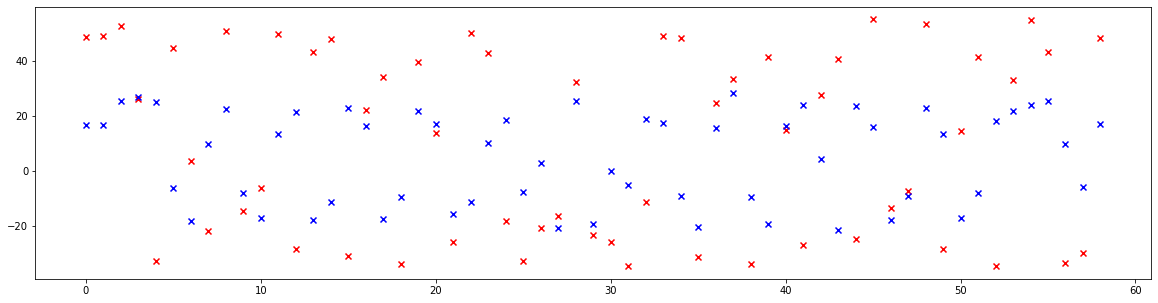

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(1.369642850372e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [7]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.595881759
nux= 0.595881746, sigma_nux=1.19664568e-07, error_nux=1.26748565e-08


In [8]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.599160064
nuy= 0.599160069, sigma_nuy=1.81651313e-07, error_nuy=4.52374005e-09


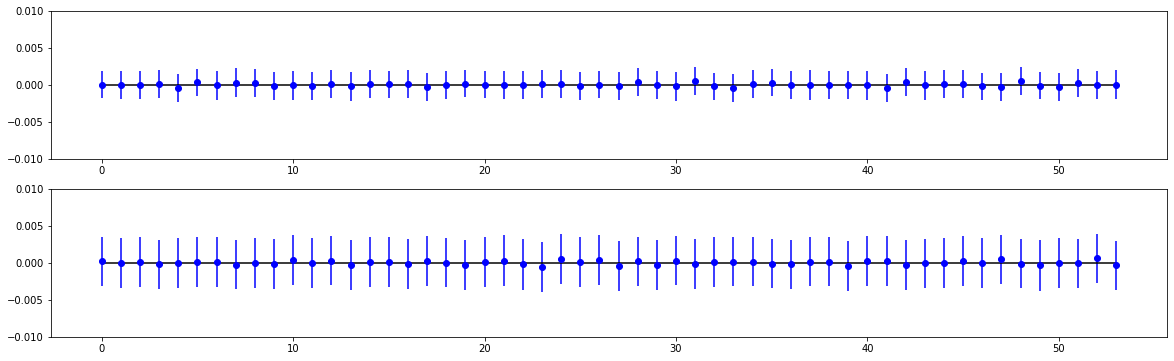

In [9]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

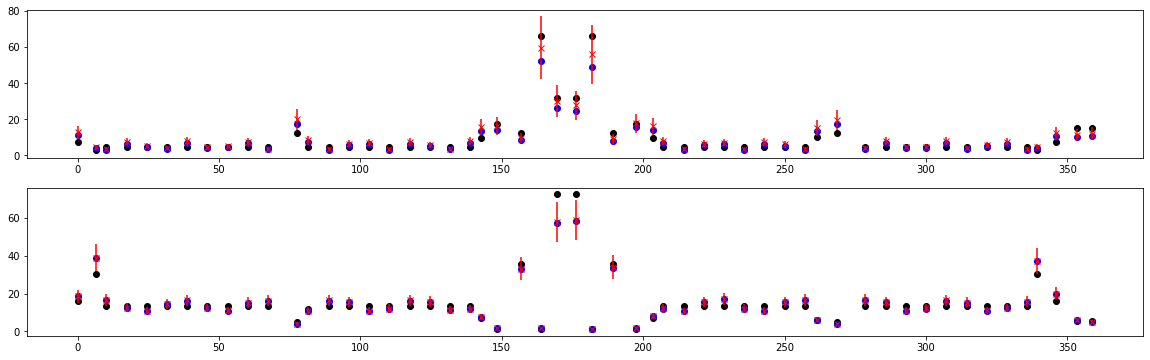

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(7.056783334754e+01, dtype=torch.float64)

tensor(1.369642850372e+02, dtype=torch.float64)
tensor(8.390497867927e+00, dtype=torch.float64)



In [10]:
# Estimate twiss from amplitude

twiss = Twiss(model, table, limit=1)
twiss.get_action()
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_1 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_1 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print()

print(error_y)
print(error_y_1)
print()

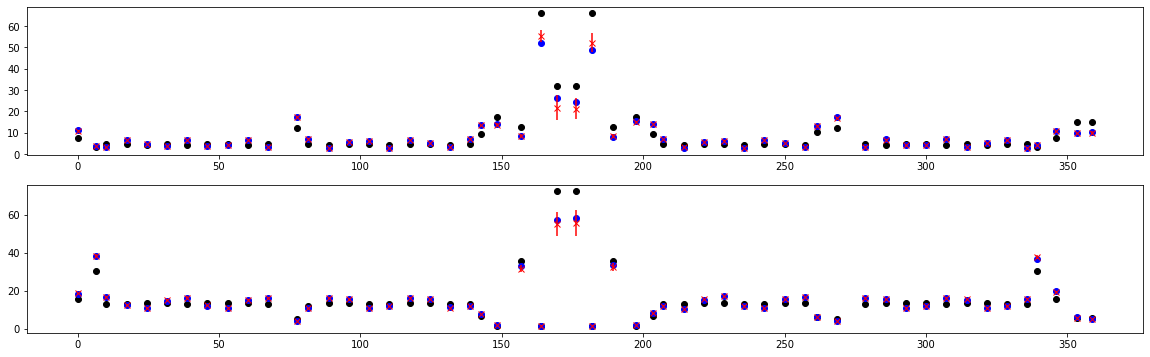

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(7.056783334754e+01, dtype=torch.float64)
tensor(1.801199052661e+01, dtype=torch.float64)

tensor(1.369642850372e+02, dtype=torch.float64)
tensor(8.390497867927e+00, dtype=torch.float64)
tensor(1.311688994774e+01, dtype=torch.float64)



In [11]:
# Estimate twiss from phase

twiss = Twiss(model, table, limit=4)
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_2 = (cs_bx[model.monitor_index] - twiss.bx[model.monitor_index]).abs().sum()
error_y_2 = (cs_by[model.monitor_index] - twiss.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print()

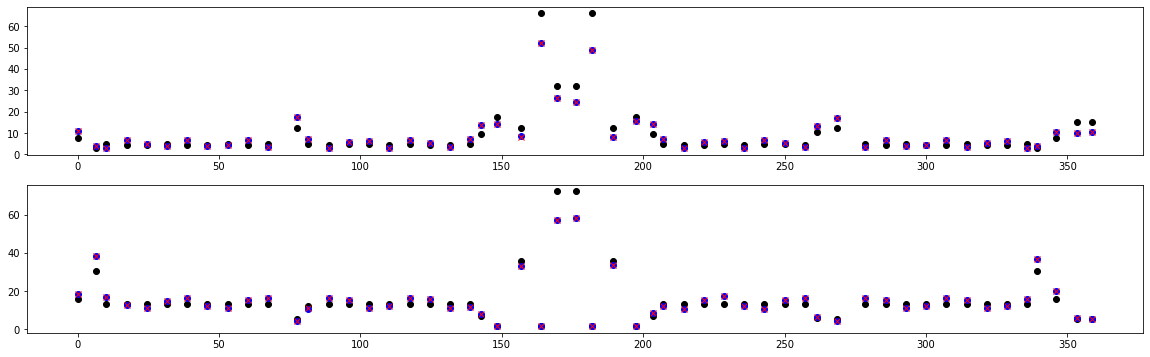

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(7.056783334754e+01, dtype=torch.float64)
tensor(1.801199052661e+01, dtype=torch.float64)
tensor(1.150772167013e+00, dtype=torch.float64)

tensor(1.369642850372e+02, dtype=torch.float64)
tensor(8.390497867927e+00, dtype=torch.float64)
tensor(1.311688994774e+01, dtype=torch.float64)
tensor(6.221474739600e-01, dtype=torch.float64)



In [12]:
# Estimate twiss from amplitude (corrected action)

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_3 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_3 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print()

In [13]:
%%time

# Estimate twiss from invariant fit
# Note, **kwargs are passed to leastsq

from harmonica.parameterization import cs_normal
data = twiss.get_twiss_from_data(1,                # -- first turn
                                 256,              # -- total number of turns, orbits are computed for (start, start + total)
                                 cs_normal,        # -- normalization
                                 model.matrix,     # -- matrix generator
                                 twiss=None,       # -- initial twiss for each location or None (use model values)
                                 method='pair',    # -- momenta computation method
                                 limit=1,          # -- range limit or direction/shift
                                 product=True,     # -- flag to use product objective
                                 jacobian=False,   # -- flag to use objective jacobian
                                 count=512,        # -- number of samples
                                 fraction=0.75,    # -- sample length fraction
                                 ix=None,          # -- ix invariant value
                                 iy=None,          # -- iy invariant value  (both should present for fixed fit)
                                 n_jobs=6,         # -- number of parallel jobs (loop over samples)
                                 verbose=False)    # -- verbose flag
print(data.shape)

torch.Size([54, 2, 6, 512])
CPU times: user 5min 52s, sys: 8.69 s, total: 6min 1s
Wall time: 6min 12s


In [14]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

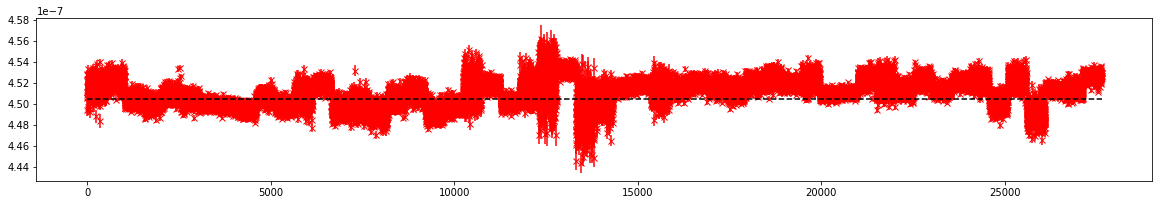

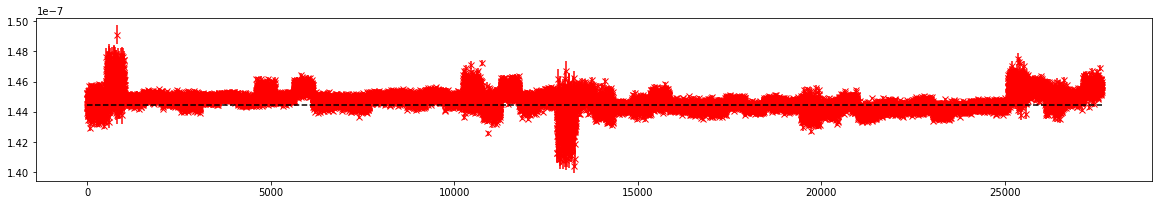

In [15]:
# Plot invariants for each sample in each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_x, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_y, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

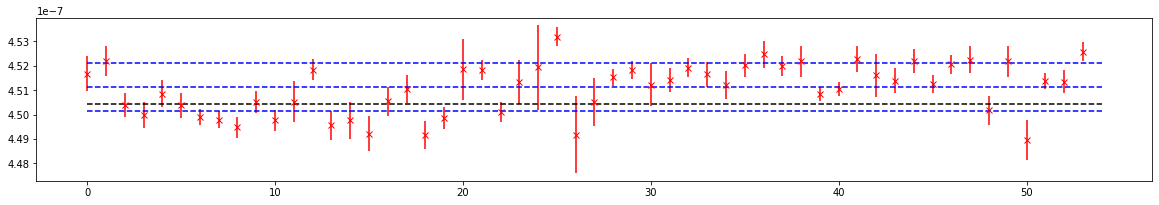

tensor(4.504240709953e-07, dtype=torch.float64)
tensor(4.511282529028e-07, dtype=torch.float64)
tensor(9.959374595965e-10, dtype=torch.float64)



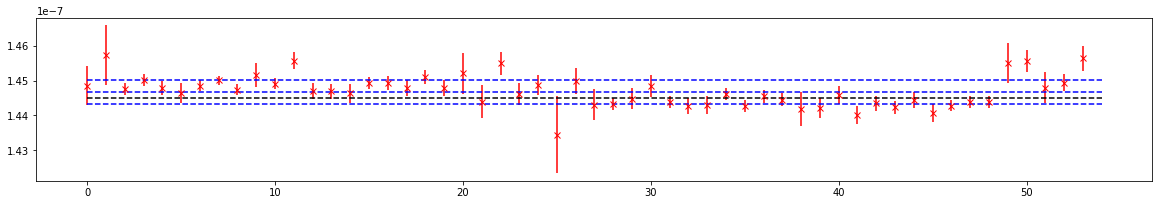

tensor(1.444854659122e-07, dtype=torch.float64)
tensor(1.446611807163e-07, dtype=torch.float64)
tensor(3.460273056382e-10, dtype=torch.float64)



In [16]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

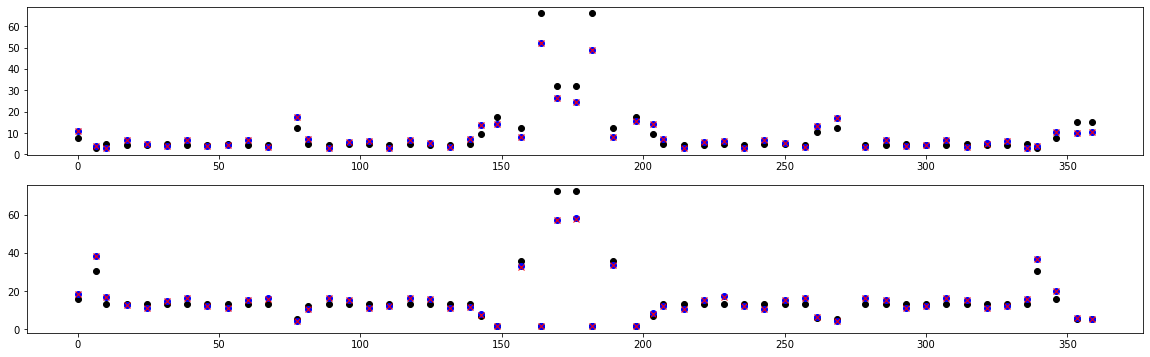

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(7.056783334754e+01, dtype=torch.float64)
tensor(1.801199052661e+01, dtype=torch.float64)
tensor(1.150772167013e+00, dtype=torch.float64)
tensor(1.099226643122e+00, dtype=torch.float64)

tensor(1.369642850372e+02, dtype=torch.float64)
tensor(8.390497867927e+00, dtype=torch.float64)
tensor(1.311688994774e+01, dtype=torch.float64)
tensor(6.221474739600e-01, dtype=torch.float64)
tensor(2.222689950424e+00, dtype=torch.float64)



In [17]:
# Process twiss & compare

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value_ax = data[:, 0, 2]
error_ax = data[:, 1, 2]

value_bx = data[:, 0, 3]
error_bx = data[:, 1, 3]

value_ay = data[:, 0, 4]
error_ay = data[:, 1, 4]

value_by = data[:, 0, 5]
error_by = data[:, 1, 5]

value_ax, error_ax = twiss.process(value_ax, error_ax, mask=mask)
value_bx, error_bx = twiss.process(value_bx, error_bx, mask=mask)
value_ay, error_ay = twiss.process(value_ay, error_ay, mask=mask)
value_by, error_by = twiss.process(value_by, error_by, mask=mask)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_4 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_4 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print()

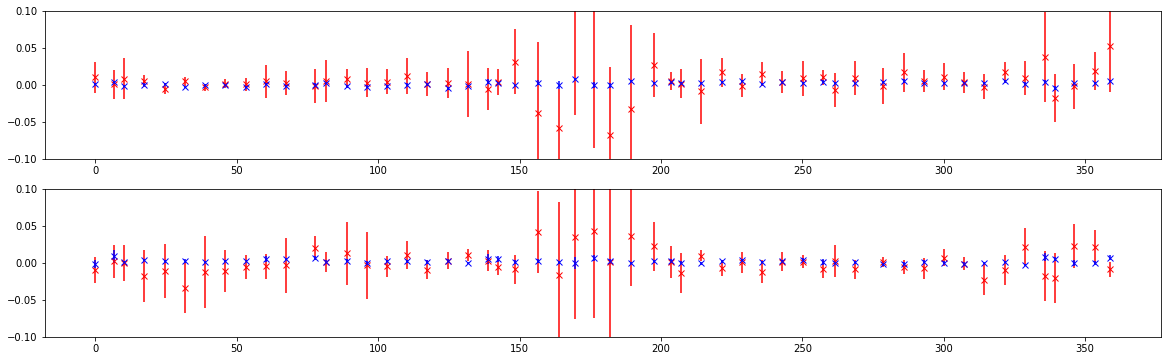

In [18]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [19]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples and fixed invariants)

from harmonica.parameterization import cs_normal
data = twiss.get_twiss_from_data(1, 256, cs_normal, model.matrix, twiss=None, method='pair', limit=1, product=True, jacobian=False, count=512, fraction=0.75, ix=invariant['ix_value'], iy=invariant['iy_value'], n_jobs=6, verbose=False)
print(data.shape)

torch.Size([54, 2, 4, 512])
CPU times: user 5min 11s, sys: 7.86 s, total: 5min 19s
Wall time: 5min 27s


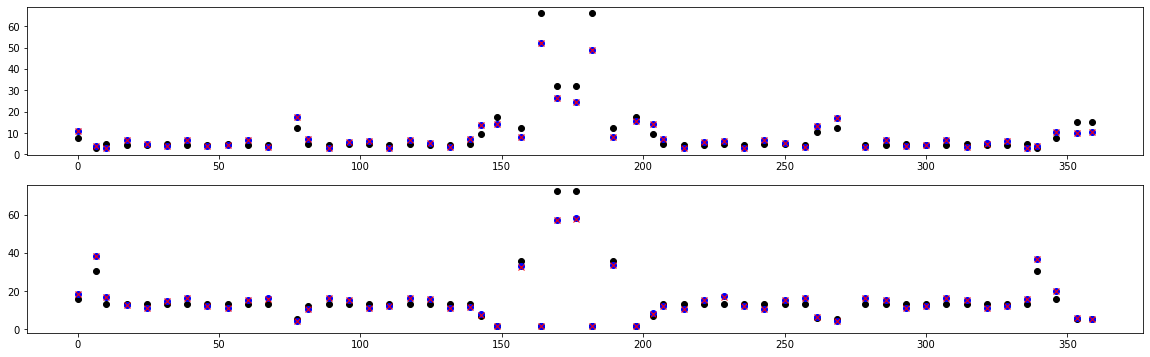

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(7.056783334754e+01, dtype=torch.float64)
tensor(1.801199052661e+01, dtype=torch.float64)
tensor(1.150772167013e+00, dtype=torch.float64)
tensor(1.099226643122e+00, dtype=torch.float64)
tensor(1.076573069208e+00, dtype=torch.float64)

tensor(1.369642850372e+02, dtype=torch.float64)
tensor(8.390497867927e+00, dtype=torch.float64)
tensor(1.311688994774e+01, dtype=torch.float64)
tensor(6.221474739600e-01, dtype=torch.float64)
tensor(2.222689950424e+00, dtype=torch.float64)
tensor(2.313878408095e+00, dtype=torch.float64)



In [20]:
# Process twiss & compare

value_ax = data[:, 0, 0]
error_ax = data[:, 1, 0]

value_bx = data[:, 0, 1]
error_bx = data[:, 1, 1]

value_ay = data[:, 0, 2]
error_ay = data[:, 1, 2]

value_by = data[:, 0, 3]
error_by = data[:, 1, 3]

value_ax, error_ax = twiss.process(value_ax, error_ax)
value_bx, error_bx = twiss.process(value_bx, error_bx)
value_ay, error_ay = twiss.process(value_ay, error_ay)
value_by, error_by = twiss.process(value_by, error_by)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_5 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_5 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print()

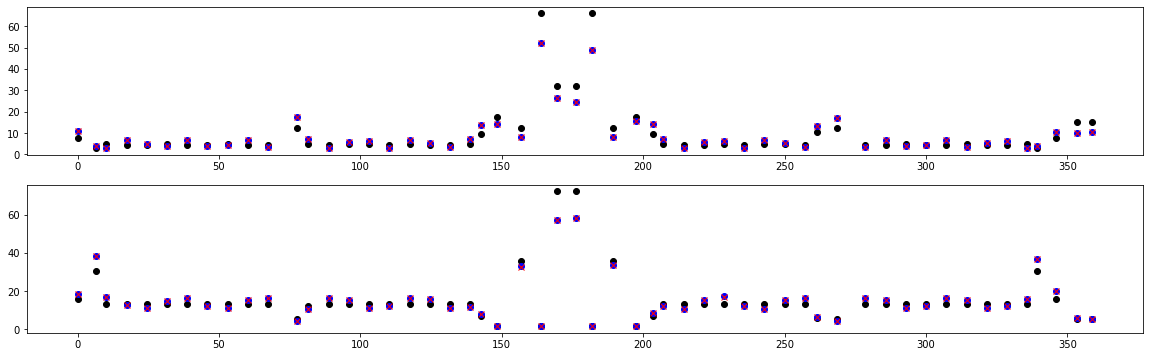

tensor(1.472361368265e+02, dtype=torch.float64)
tensor(7.056783334754e+01, dtype=torch.float64)
tensor(1.801199052661e+01, dtype=torch.float64)
tensor(1.150772167013e+00, dtype=torch.float64)
tensor(1.099226643122e+00, dtype=torch.float64)
tensor(1.076573069208e+00, dtype=torch.float64)
tensor(7.811839622263e-01, dtype=torch.float64)

tensor(1.369642850372e+02, dtype=torch.float64)
tensor(8.390497867927e+00, dtype=torch.float64)
tensor(1.311688994774e+01, dtype=torch.float64)
tensor(6.221474739600e-01, dtype=torch.float64)
tensor(2.222689950424e+00, dtype=torch.float64)
tensor(2.313878408095e+00, dtype=torch.float64)
tensor(9.498246583367e-01, dtype=torch.float64)



In [21]:
# Estimate twiss from amplitude (fixed action)

twiss.get_action(jx=invariant['ix_center'], jy=invariant['iy_center'], sigma_jx=invariant['ix_spread'], sigma_jy=invariant['iy_spread'])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_6 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_6 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print(error_x_6)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print(error_y_6)
print()

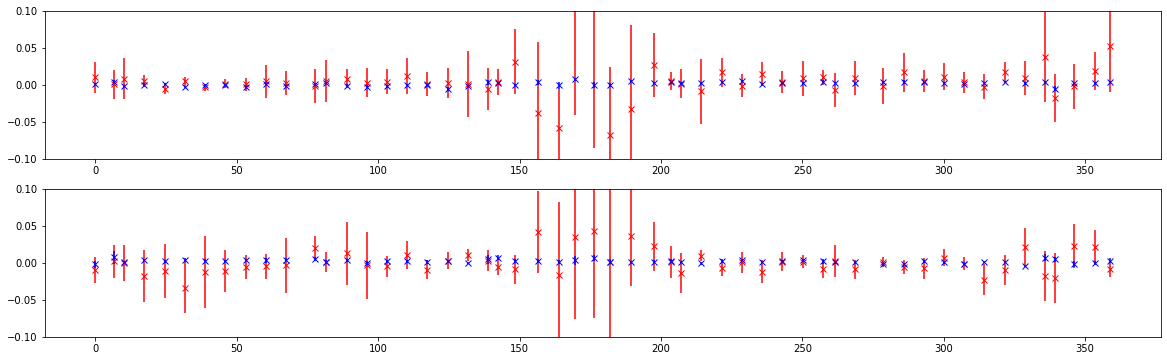

In [22]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [23]:
# Compare alpha from phase vs fitted

print((cs_ax[model.monitor_index] - twiss.ax[model.monitor_index]).abs().sum())
print((cs_ax[model.monitor_index] - value_ax).abs().sum())
print()

print((cs_ay[model.monitor_index] - twiss.ay[model.monitor_index]).abs().sum())
print((cs_ay[model.monitor_index] - value_ay).abs().sum())
print()

tensor(5.983891674238e+00, dtype=torch.float64)
tensor(5.809933034086e-01, dtype=torch.float64)

tensor(3.040292014693e+00, dtype=torch.float64)
tensor(1.112426655964e+00, dtype=torch.float64)



In [24]:
%%time

# Twiss at virtual locations (from virtual orbits)
# Note, method='lstsq'

from harmonica.parameterization import cs_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 cs_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 phony=True,
                                 product=True,
                                 jacobian=False,
                                 count=512,
                                 fraction=0.75,
                                 ix=invariant['ix_value'],
                                 iy=invariant['iy_value'],
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)
print(model.virtual_count)

torch.Size([5, 2, 4, 512])
5
CPU times: user 27.4 s, sys: 765 ms, total: 28.2 s
Wall time: 28.9 s


In [25]:
# Process twiss

value_ax = data[:, 0, 0]
error_ax = data[:, 1, 0]

value_bx = data[:, 0, 1]
error_bx = data[:, 1, 1]

value_ay = data[:, 0, 2]
error_ay = data[:, 1, 2]

value_by = data[:, 0, 3]
error_by = data[:, 1, 3]

value_ax, error_ax = twiss.process(value_ax, error_ax)
value_bx, error_bx = twiss.process(value_bx, error_bx)
value_ay, error_ay = twiss.process(value_ay, error_ay)
value_by, error_by = twiss.process(value_by, error_by)

In [26]:
# Compare with exact values

for index, location in enumerate(model.virtual_index):
    print(torch.stack([model.ax[location], model.bx[location], model.ay[location], model.by[location]]).cpu().numpy())
    print(torch.stack([value_ax[index], value_bx[index], value_ay[index], value_by[index]]).cpu().numpy())
    print(model.out_cs[location].cpu().numpy())
    print()

[-0.67832172  7.46746094  0.65444028 15.85438815]
[-1.22881465 11.08928754  0.57174659 18.42806413]
[-1.22536242 11.10736845  0.58079508 18.51152182]

[ 1.95506501 14.23834264 -2.75987199 13.85574699]
[ 3.10095939 21.73127924 -3.51928005 17.29543256]
[ 3.11389367 21.75569313 -3.53667514 17.35091903]

[1.70086167e-13 7.50348193e-01 1.42108547e-14 6.77073993e-02]
[ 0.07751715  0.9917231  -0.01343865  0.0854047 ]
[ 0.06817414  0.99225604 -0.04435394  0.08496824]

[-1.95506501 14.23834264  2.75987199 13.85574699]
[-3.03402207 21.88430656  3.33036058 17.10873716]
[-3.07672779 22.0212007   3.34065633 17.15323529]

[-0.67832172  7.46746094  0.65444028 15.85438815]
[-1.22885633 11.08936363  0.57179437 18.4274046 ]
[-1.22395172 11.0828753   0.58292381 18.52315901]



# Example-11: Twiss from invariant fit (coupled)

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example coupled twiss parameters are estimated from (linear) invariant fit

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Using coordinates and momenta linear invariants are fitted
# Known invariant values can be passed, else both invariant values and twiss parameters are fitted
# Fit objective is ((jx(qx, px, qy, py; beta) - ix)**2 + (jy(qx, px, qy, py; beta) - iy)**2).sqrt()
# Or ((jx(qx, px, qy, py; beta) - ix)**2 * (jy(qx, px, qy, py; beta) - iy)**2).sqrt() (default)
# Where, for coupled case, beta = (n11, n33, n21, n43, n13, n31, n14, and n41) and ix & iy are invariant values (can be fixed on input or estimated)

# Fitting is performed using nonlinear least squares
# Note, fitting is bootstrapped (signals are randomly sampled with replacement)
# The result is returned for each sample (values and errors) at each monitor location (beta or beta and invariants)
# Processing (filtering and weighting) is then performed over samples for each monitor location
# Ones invariants are estimated, fit can be performed with fixed invariants (this can improve result quality in some cases)

# Here, random normal & skew thin quadrupole errors are introduced are twiss estimation is performed using amplitude & phase data
# These estimations are compared with fitted values

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 0.5E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 1024, 4])

4.405148015e-07, 5.346675425e-19
1.389560172e-07, 1.179263053e-19



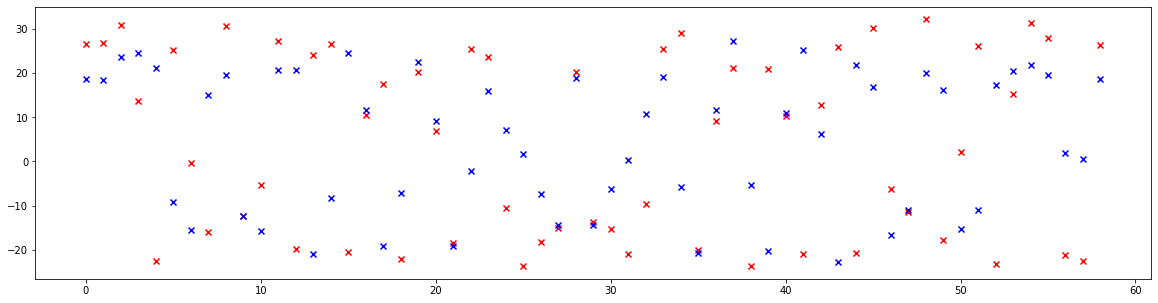

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.197892033015e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [7]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.568677127
nux= 0.568677137, sigma_nux=1.1045749e-07, error_nux=9.38533318e-09


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nux={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.612036594
nuy=  0.61203658, sigma_nuy=1.91769987e-07, error_nux=1.40806614e-08


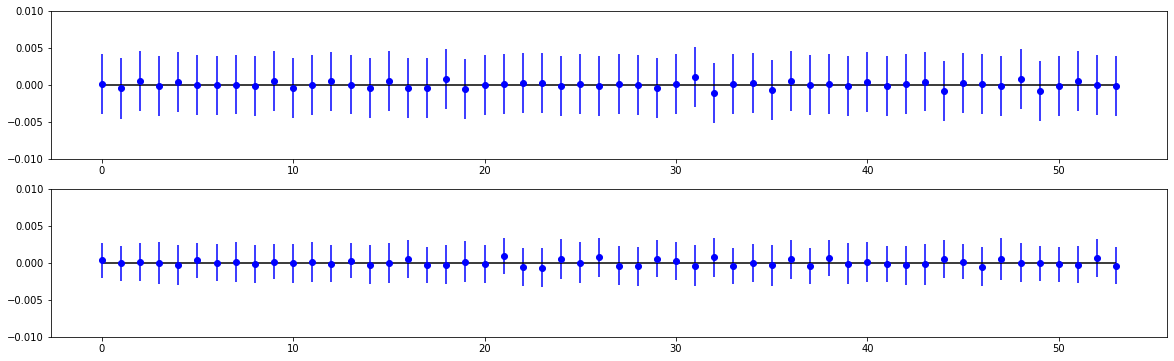

In [10]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

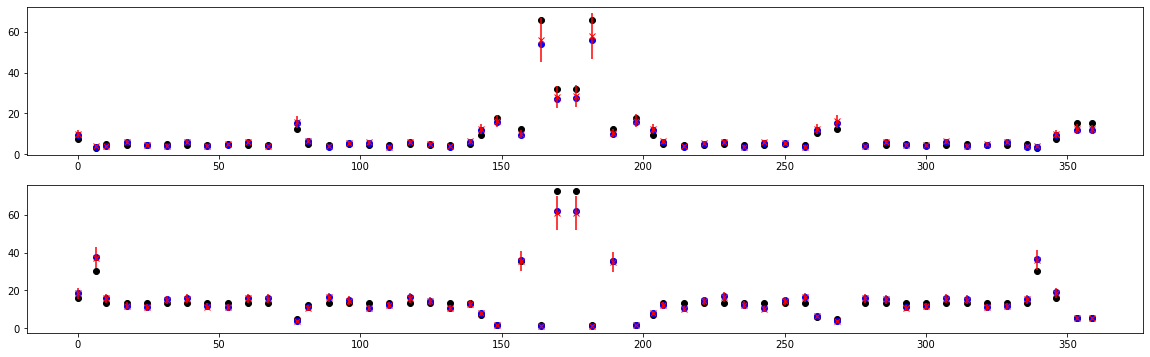

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.913041284991e+01, dtype=torch.float64)

tensor(1.197892033015e+02, dtype=torch.float64)
tensor(1.434270363767e+01, dtype=torch.float64)



In [11]:
# Estimate twiss from amplitude

twiss = Twiss(model, table, limit=1)
twiss.get_action()
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_1 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_1 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print()

print(error_y)
print(error_y_1)
print()

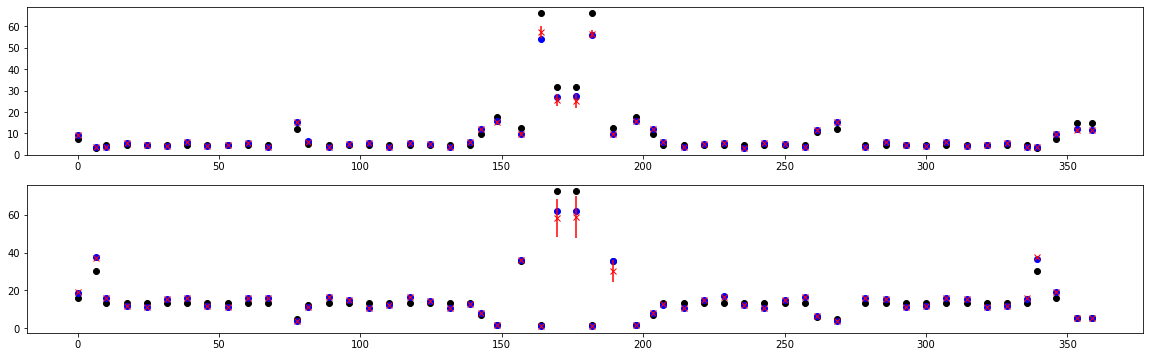

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.913041284991e+01, dtype=torch.float64)
tensor(1.051047751273e+01, dtype=torch.float64)

tensor(1.197892033015e+02, dtype=torch.float64)
tensor(1.434270363767e+01, dtype=torch.float64)
tensor(1.805085315125e+01, dtype=torch.float64)



In [12]:
# Estimate twiss from phase

twiss = Twiss(model, table, limit=4)
twiss.phase_virtual()
twiss.get_twiss_from_phase()
mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True)
twiss.process_twiss(plane='y', mask=mask_y, weight=True)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_2 = (cs_bx[model.monitor_index] - twiss.bx[model.monitor_index]).abs().sum()
error_y_2 = (cs_by[model.monitor_index] - twiss.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print()

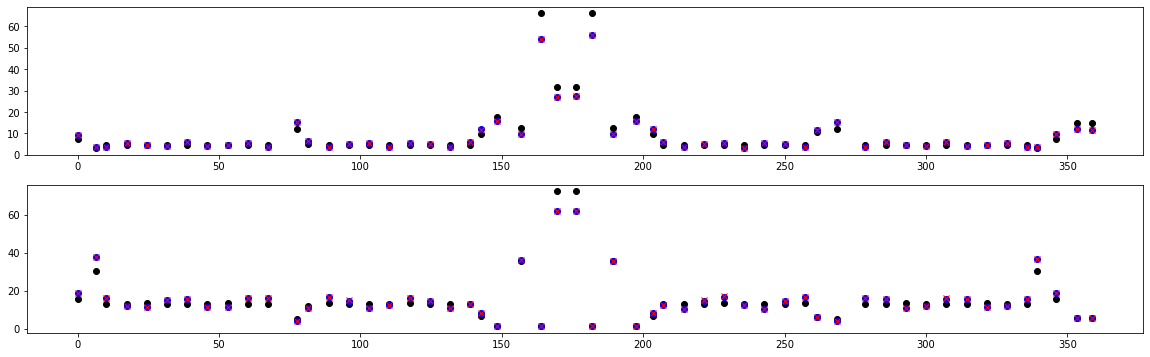

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.913041284991e+01, dtype=torch.float64)
tensor(1.051047751273e+01, dtype=torch.float64)
tensor(6.715263315170e-01, dtype=torch.float64)

tensor(1.197892033015e+02, dtype=torch.float64)
tensor(1.434270363767e+01, dtype=torch.float64)
tensor(1.805085315125e+01, dtype=torch.float64)
tensor(2.530559015612e+00, dtype=torch.float64)



In [13]:
# Estimate twiss from amplitude (corrected action)

twiss.get_action(bx=twiss.bx[model.monitor_index], by=twiss.by[model.monitor_index], sigma_bx=twiss.sigma_bx[model.monitor_index], sigma_by=twiss.sigma_by[model.monitor_index])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_3 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_3 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print()

In [14]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,                # -- first turn
                                 256,              # -- total number of turns, orbits are computed for (start, start + total)
                                 parametric_normal,# -- normalization
                                 model.matrix,     # -- transport matrix generator
                                 twiss=None,       # -- initial twiss for each location or None (use model values)
                                 method='pair',    # -- momenta computation method
                                 limit=1,          # -- range limit or direction/shift
                                 product=True,     # -- flag to use product objective
                                 jacobian=False,   # -- flag to use objective jacobian
                                 count=512,        # -- number of samples
                                 fraction=0.75,    # -- sample length fraction
                                 ix=None,          # -- ix invariant value
                                 iy=None,          # -- iy invariant value  (both should present for fixed fit)
                                 n_jobs=6,         # -- number of parallel jobs (loop over samples)
                                 verbose=False)    # -- verbose flag
print(data.shape)

torch.Size([54, 2, 10, 512])
CPU times: user 6min 26s, sys: 7.96 s, total: 6min 34s
Wall time: 8min 1s


In [15]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

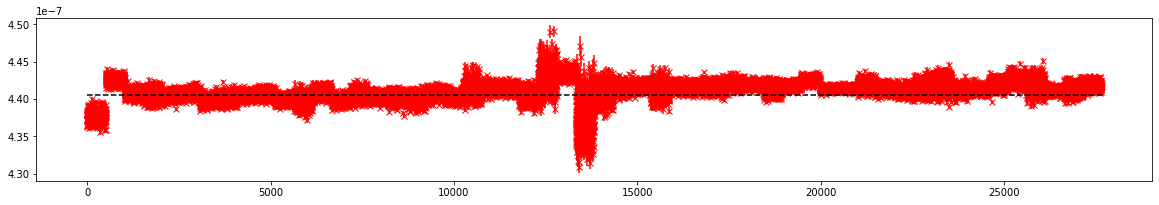

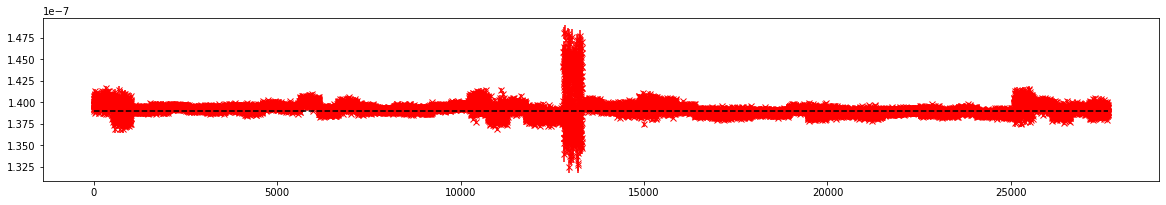

In [16]:
# Plot invariants for each sample in each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_x, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54*512), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
plt.hlines(action_y, 0, 54*512, linestyles='dashed', color='black',  zorder=1)
plt.show()

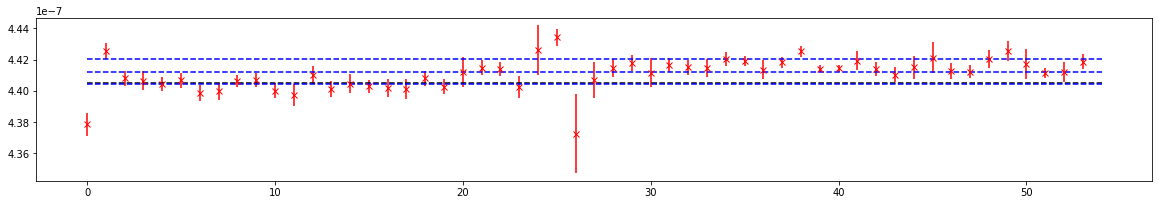

tensor(4.405148015485e-07, dtype=torch.float64)
tensor(4.412351715905e-07, dtype=torch.float64)
tensor(8.027745599059e-10, dtype=torch.float64)



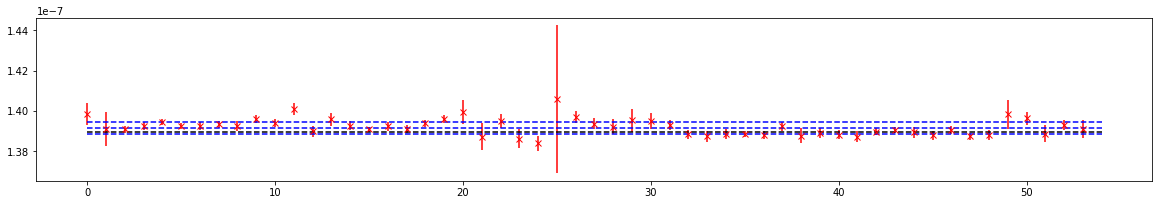

tensor(1.389560171654e-07, dtype=torch.float64)
tensor(1.391577936073e-07, dtype=torch.float64)
tensor(2.985229861382e-10, dtype=torch.float64)



In [17]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

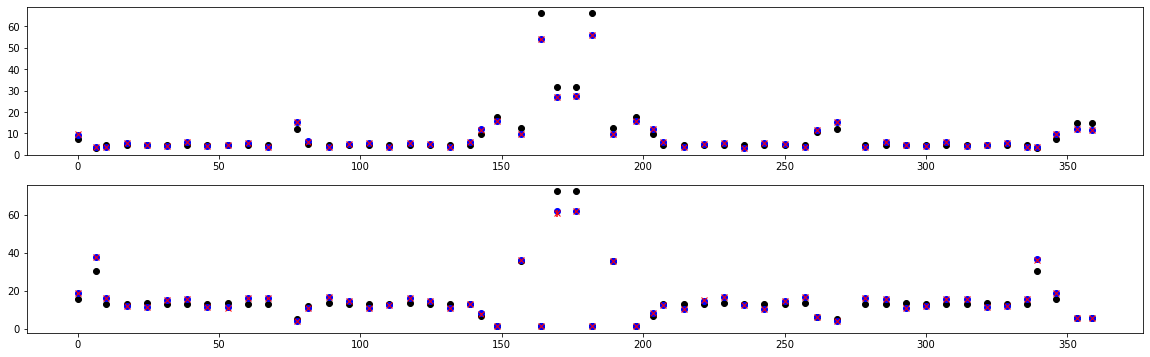

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.913041284991e+01, dtype=torch.float64)
tensor(1.051047751273e+01, dtype=torch.float64)
tensor(6.715263315170e-01, dtype=torch.float64)
tensor(1.303650743153e+00, dtype=torch.float64)

tensor(1.197892033015e+02, dtype=torch.float64)
tensor(1.434270363767e+01, dtype=torch.float64)
tensor(1.805085315125e+01, dtype=torch.float64)
tensor(2.530559015612e+00, dtype=torch.float64)
tensor(3.148568600503e+00, dtype=torch.float64)



In [18]:
# Process twiss & compare

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value_n11 = data[:, 0, 2]
error_n11 = data[:, 1, 2]

value_n33 = data[:, 0, 3]
error_n33 = data[:, 1, 3]

value_n21 = data[:, 0, 4]
error_n21 = data[:, 1, 4]

value_n43 = data[:, 0, 5]
error_n43 = data[:, 1, 5]

value_n13 = data[:, 0, 6]
error_n13 = data[:, 1, 6]

value_n31 = data[:, 0, 7]
error_n31 = data[:, 1, 7]

value_n14 = data[:, 0, 8]
error_n14 = data[:, 1, 8]

value_n41 = data[:, 0, 9]
error_n41 = data[:, 1, 9]

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_4 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_4 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print()

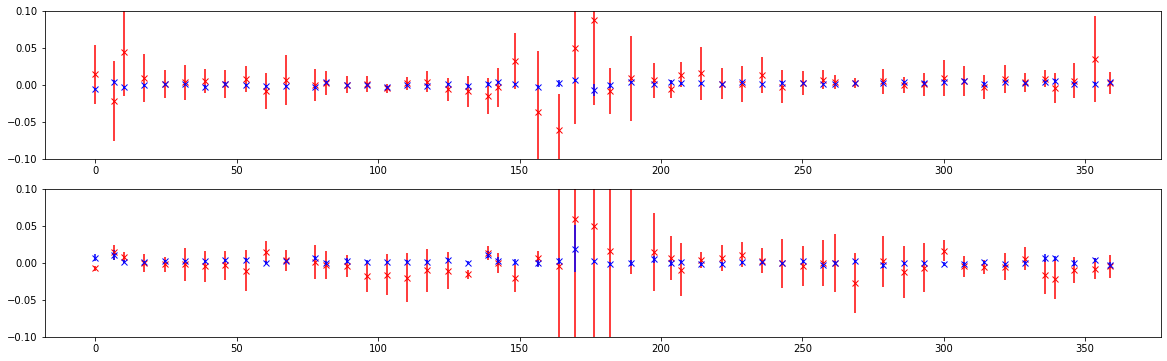

In [19]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [20]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples and fixed invariants)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1, 256, parametric_normal, model.matrix, twiss=None, method='pair', limit=1, product=True, jacobian=False, count=512, fraction=0.75, ix=invariant['ix_value'], iy=invariant['iy_value'], n_jobs=6, verbose=False)
print(data.shape)

torch.Size([54, 2, 8, 512])
CPU times: user 5min 58s, sys: 7.92 s, total: 6min 6s
Wall time: 6min 44s


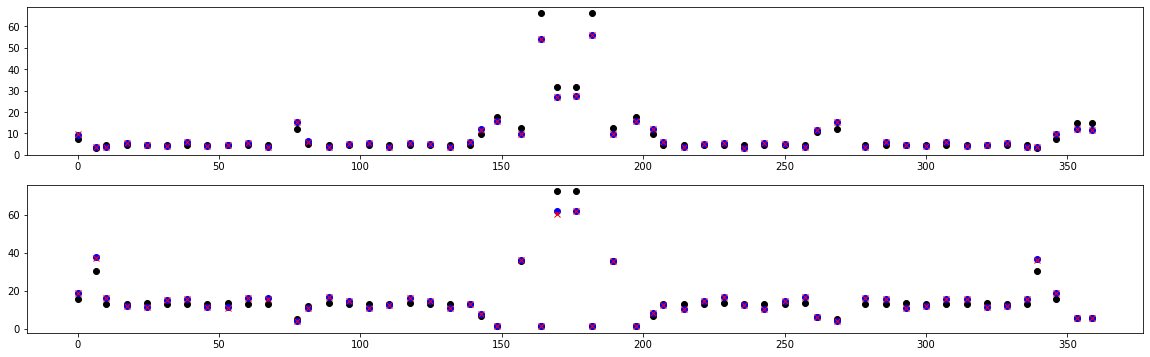

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.913041284991e+01, dtype=torch.float64)
tensor(1.051047751273e+01, dtype=torch.float64)
tensor(6.715263315170e-01, dtype=torch.float64)
tensor(1.303650743153e+00, dtype=torch.float64)
tensor(9.777274483561e-01, dtype=torch.float64)

tensor(1.197892033015e+02, dtype=torch.float64)
tensor(1.434270363767e+01, dtype=torch.float64)
tensor(1.805085315125e+01, dtype=torch.float64)
tensor(2.530559015612e+00, dtype=torch.float64)
tensor(3.148568600503e+00, dtype=torch.float64)
tensor(3.452660122657e+00, dtype=torch.float64)



In [21]:
# Process twiss & compare

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_loc, error_loc in zip(value, error):
    table = value_loc.reshape(-1, 1) + error_loc.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_5 = (cs_bx[model.monitor_index] - value_bx).abs().sum()
error_y_5 = (cs_by[model.monitor_index] - value_by).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print()

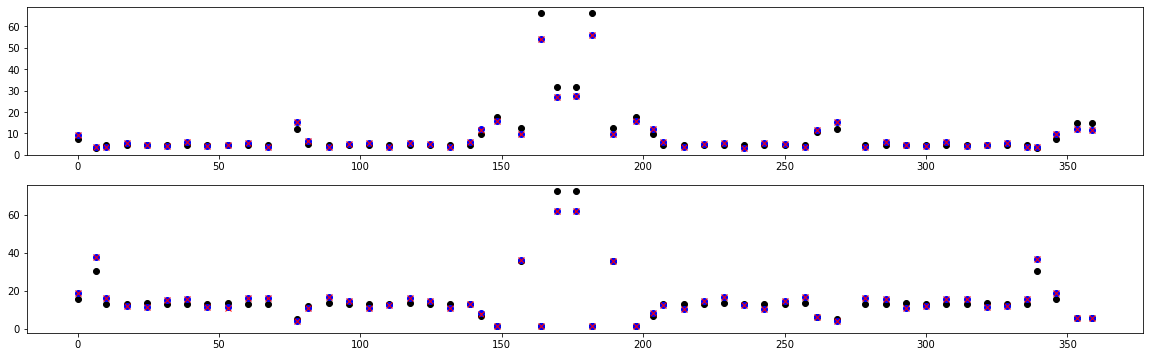

tensor(9.432834312338e+01, dtype=torch.float64)
tensor(1.913041284991e+01, dtype=torch.float64)
tensor(1.051047751273e+01, dtype=torch.float64)
tensor(6.715263315170e-01, dtype=torch.float64)
tensor(1.303650743153e+00, dtype=torch.float64)
tensor(9.777274483561e-01, dtype=torch.float64)
tensor(8.233736372112e-01, dtype=torch.float64)

tensor(1.197892033015e+02, dtype=torch.float64)
tensor(1.434270363767e+01, dtype=torch.float64)
tensor(1.805085315125e+01, dtype=torch.float64)
tensor(2.530559015612e+00, dtype=torch.float64)
tensor(3.148568600503e+00, dtype=torch.float64)
tensor(3.452660122657e+00, dtype=torch.float64)
tensor(1.215366306402e+00, dtype=torch.float64)



In [22]:
# Estimate twiss from amplitude (fixed action)

twiss.get_action(jx=invariant['ix_center'], jy=invariant['iy_center'], sigma_jx=invariant['ix_spread'], sigma_jy=invariant['iy_spread'])
twiss.get_twiss_from_amplitude()

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

error_x_6 = (cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum()
error_y_6 = (cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum()

print(error_x)
print(error_x_1)
print(error_x_2)
print(error_x_3)
print(error_x_4)
print(error_x_5)
print(error_x_6)
print()

print(error_y)
print(error_y_1)
print(error_y_2)
print(error_y_3)
print(error_y_4)
print(error_y_5)
print(error_y_6)
print()

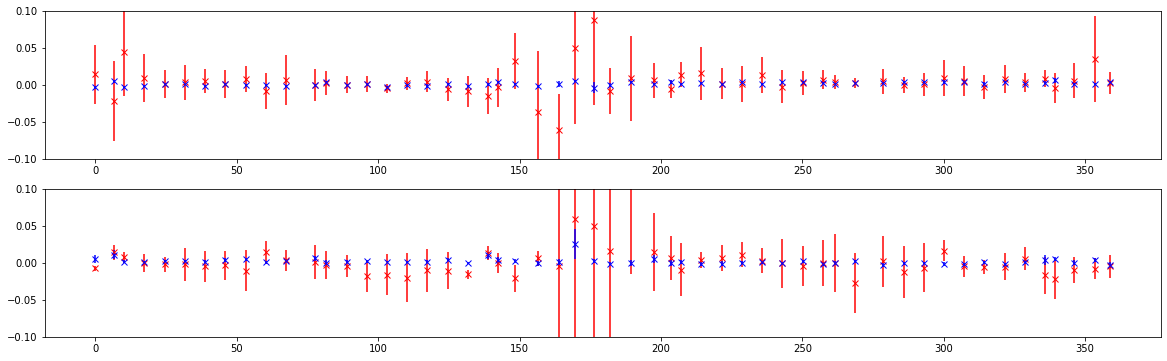

In [23]:
# Plot errors from phase (red) vs fit (blue)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index])/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_bx[model.monitor_index]/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_bx[model.monitor_index] - value_bx)/cs_bx[model.monitor_index]).cpu().numpy(), yerr=(error_bx/cs_bx[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

ax = plt.subplot(212)
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - twiss.by[model.monitor_index])/cs_by[model.monitor_index]).cpu().numpy(), yerr=(twiss.sigma_by[model.monitor_index]/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='red')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), ((cs_by[model.monitor_index] - value_by)/cs_by[model.monitor_index]).cpu().numpy(), yerr=(error_by/cs_by[model.monitor_index]).cpu().numpy(), fmt=' ', marker='x', color='blue')
ax.set_ylim(-1.0E-1, +1.0E-1)

plt.show()

In [24]:
# Compare alpha from phase vs fitted

print((cs_ax[model.monitor_index] - twiss.ax[model.monitor_index]).abs().sum())
print((cs_ax[model.monitor_index] - value_ax).abs().sum())
print()

print((cs_ay[model.monitor_index] - twiss.ay[model.monitor_index]).abs().sum())
print((cs_ay[model.monitor_index] - value_ay).abs().sum())
print()

tensor(3.070586859810e+00, dtype=torch.float64)
tensor(5.134130019878e-01, dtype=torch.float64)

tensor(3.989021907011e+00, dtype=torch.float64)
tensor(1.410013658949e+00, dtype=torch.float64)



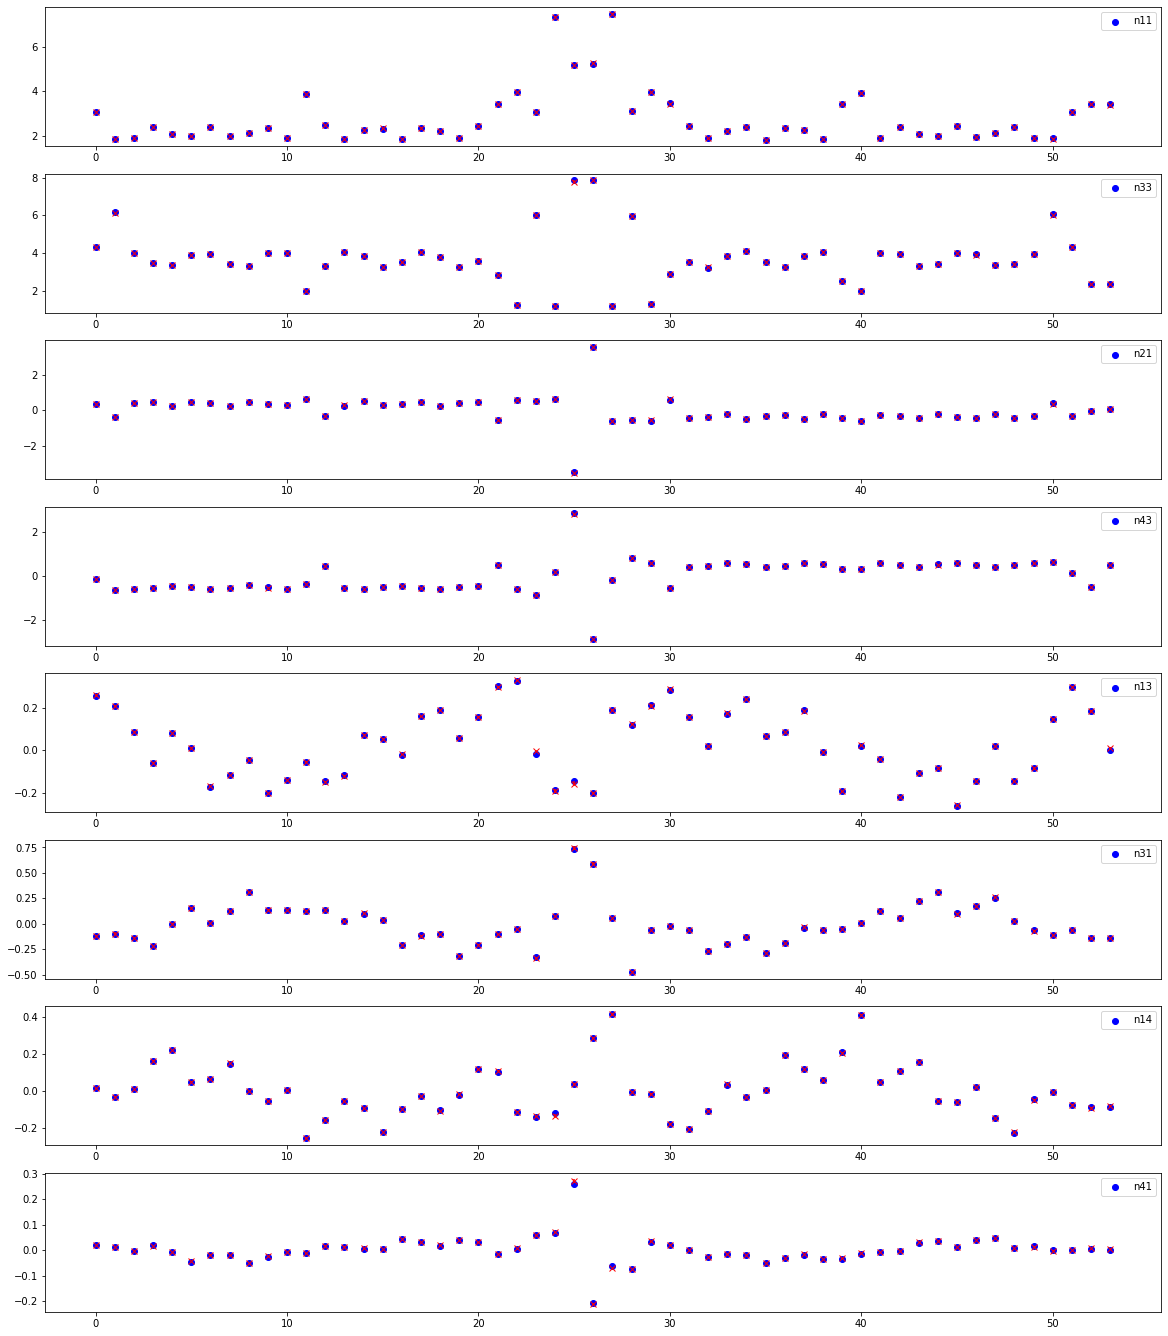

In [25]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

In [26]:
%%time

# Twiss at virtual locations (from virtual orbits)
# Note, method='lstsq'

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 phony=True,
                                 product=True,
                                 jacobian=False,
                                 count=512,
                                 fraction=0.75,
                                 ix=invariant['ix_value'],
                                 iy=invariant['iy_value'],
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)
print(model.virtual_count)

torch.Size([5, 2, 8, 512])
5
CPU times: user 32.9 s, sys: 745 ms, total: 33.6 s
Wall time: 37.1 s


In [27]:
# Process twiss

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

In [28]:
# Compare with exact values

numpy.set_printoptions(linewidth=160)

from harmonica.parameterization import cs_normal

for index, location in enumerate(model.virtual_index):
    print(cs_normal(model.ax[location], model.bx[location], model.ay[location], model.by[location])[[0, 2, 1, 3, 0, 2, 0, 3], [0, 2, 0, 2, 2, 0, 3, 0]].cpu().numpy())
    print(torch.stack([value_n11[index], value_n33[index], value_n21[index], value_n43[index], value_n13[index], value_n31[index], value_n14[index], value_n41[index]]).cpu().numpy())
    print(model.out_normal[location][[0, 2, 1, 3, 0, 2, 0, 3], [0, 2, 0, 2, 2, 0, 3, 0]].cpu().numpy())
    print()

[ 2.73266554  3.98175692  0.24822713 -0.16435968  0.          0.          0.          0.        ]
[ 3.06004068  4.34659241  0.33076567 -0.14819954  0.25399626 -0.11503656  0.01432764  0.01684073]
[ 3.07442065  4.3372902   0.33698369 -0.15832827  0.25772024 -0.11876866  0.01352886  0.02002761]

[ 3.77337285  3.72233085 -0.51812134  0.74143651  0.          0.          0.          0.        ]
[ 4.30164647e+00  4.13682235e+00 -6.02104443e-01  8.28164161e-01  4.33352283e-01 -5.42162519e-02 -5.20485548e-02 -4.18073717e-04]
[ 4.31926228e+00  4.14068744e+00 -6.05877147e-01  8.30630732e-01  4.33632664e-01 -5.70000238e-02 -5.62612364e-02 -1.86065290e-04]

[ 8.66226410e-01  2.60206455e-01 -1.96353015e-13 -5.46137670e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 0.94904491  0.28137847  0.03247069 -0.02593639 -0.08314395  0.00787786  0.00396384 -0.10391527]
[ 0.95002201  0.28379498  0.02289472 -0.54795723 -0.07945694  0.01085527 -0.02913207 -0.10939945]

[ 3.77337285  3.722

# Example-12: Twiss from ratio minimization

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example coupled twiss parameters are estimated ratio minimization

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# Normalization matrix transforms phase space coordinates into Floquet frame (qx, px, qy, py) -> (QX, PX, QY, PY)
# If normalization matrix is correct, complex coordinates (WX = QX + i PX, WY = QY + i PY) are expected to have only one peak in FFT spectrum
# Matrix elements are fitted to minimize ratio of peak amplitudes

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 0.5E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 1024, 4])

4.126233001e-07, 6.471684009e-19
1.341508424e-07, 3.759187263e-21



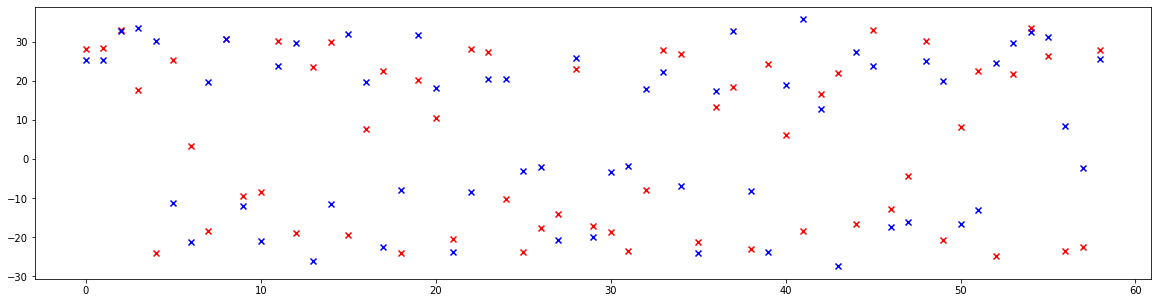

tensor(9.886806904487e+01, dtype=torch.float64)
tensor(1.636678408312e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

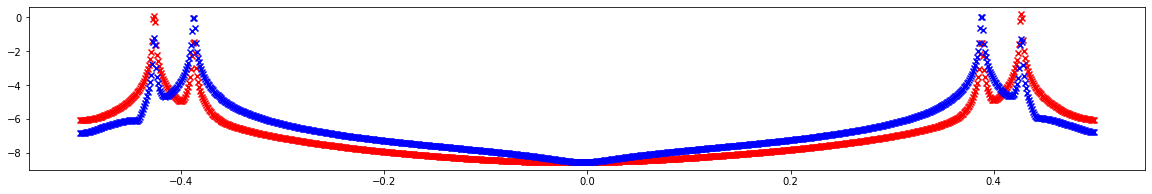

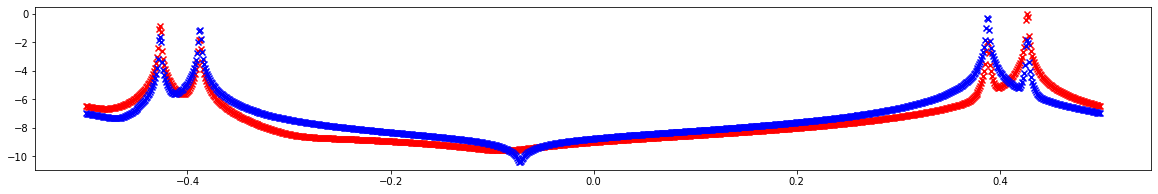

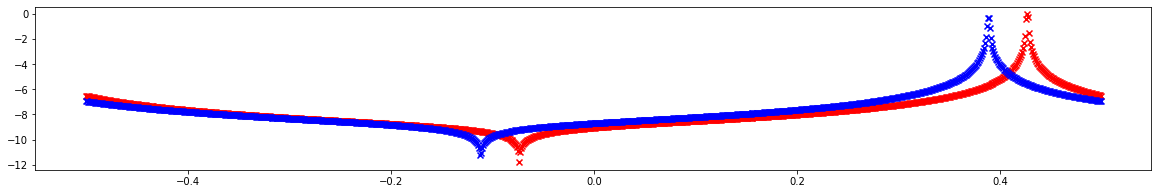

In [6]:
# For coupled case, each spectrum contains four peaks
# Main peak (nux or nuy in x or y), main mirror peak (-nux or -nuy in x or y)
# Coupling peak (nux or nuy in  in y or x), coupling mirror peak (-nux or -nuy in  in y or x)

window = Window.cosine_window(length, 1.0, dtype=dtype)

index = 0
orbit = trajectory[index].T
qx, px, qy, py = orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

# Floquet coordinates contain only one main peak (if normalization is correct)

# Model normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

# Correct normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

plt.figure(figsize=(20, 3))
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wx).abs().log10().cpu().numpy(), color='red', marker='x')
plt.scatter(torch.fft.fftfreq(length), torch.fft.fft(wy).abs().log10().cpu().numpy(), color='blue', marker='x')
plt.show()

In [7]:
# Instead of using FFT spectrum peak amplitudes, one can compute DTFT amplitudes for given four frequencies

# Fractional tunes

nux, nuy = mod(model.out_tune, 1)

# Mirror tunes

NUX, NUY = abs(mod(model.out_tune, 1, -0.5))

# Model normalization

normal = model.normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

axx = (wx*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
bxx = (wx*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()
axy = (wx*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
bxy = (wx*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()

ayy = (wy*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
byy = (wy*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()
ayx = (wy*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
byx = (wy*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()

print(torch.stack([axx, bxx, axy, bxy]).cpu().numpy())
print(torch.stack([ayy, byy, ayx, byx]).cpu().numpy())
print(((bxx + axy + bxy)/axx + (byy + ayx + byx)/ayy).numpy())
print()


# Correct normalization

normal = model.out_normal[model.monitor_index[index]]
qx, px, qy, py = normal.inverse() @ orbit
wx = (qx + 1j*px)*window
wy = (qy + 1j*py)*window

time = torch.linspace(0, length - 1, length, dtype=dtype, device=device)

axx = (wx*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
bxx = (wx*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()
axy = (wx*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
bxy = (wx*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()

ayy = (wy*torch.exp(1j*2.0*numpy.pi*nuy*time)).sum().abs()
byy = (wy*torch.exp(1j*2.0*numpy.pi*NUY*time)).sum().abs()
ayx = (wy*torch.exp(1j*2.0*numpy.pi*nux*time)).sum().abs()
byx = (wy*torch.exp(1j*2.0*numpy.pi*NUX*time)).sum().abs()

print(torch.stack([axx, bxx, axy, bxy]).cpu().numpy())
print(torch.stack([ayy, byy, ayx, byx]).cpu().numpy())
print(((bxx + axy + bxy)/axx + (byy + ayx + byx)/ayy).numpy())
print()

[0.93997346 0.1335066  0.01161264 0.01619918]
[0.53620807 0.07782561 0.01394347 0.02422257]
0.3879385433362694

[9.30233185e-01 6.76746981e-08 3.88900319e-06 4.16363296e-08]
[5.30409943e-01 4.56202658e-09 2.21747191e-06 2.37406312e-08]
8.53222047264572e-06



In [8]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [9]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [10]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.573105723
nux= 0.573105727, sigma_nux=1.24781443e-07, error_nux=3.06419312e-09


In [11]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.611868886
nuy= 0.611868883, sigma_nuy=2.04078672e-07, error_nuy=3.05569448e-09


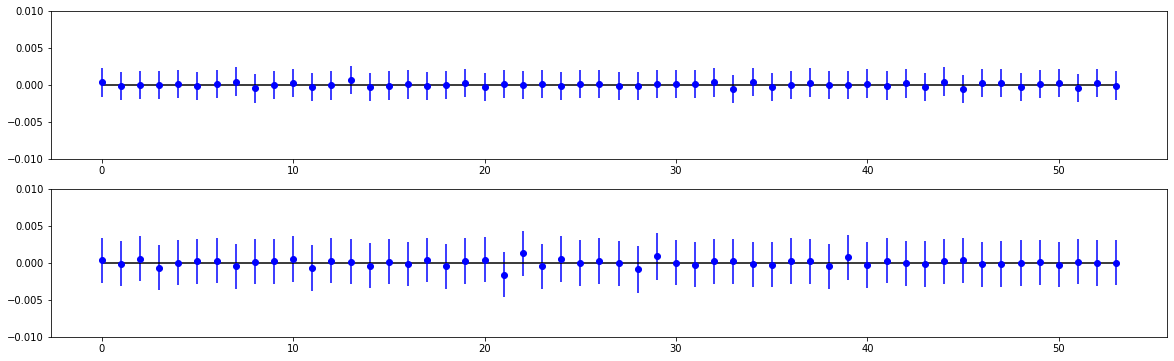

In [12]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [13]:
# Set twiss

twiss = Twiss(model, table)

In [14]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 512 random samples)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1, 256, parametric_normal, model.matrix, count=512, verbose=False)
print(data.shape)

torch.Size([54, 2, 10, 512])
CPU times: user 4min 43s, sys: 5.66 s, total: 4min 49s
Wall time: 6min 50s


In [15]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

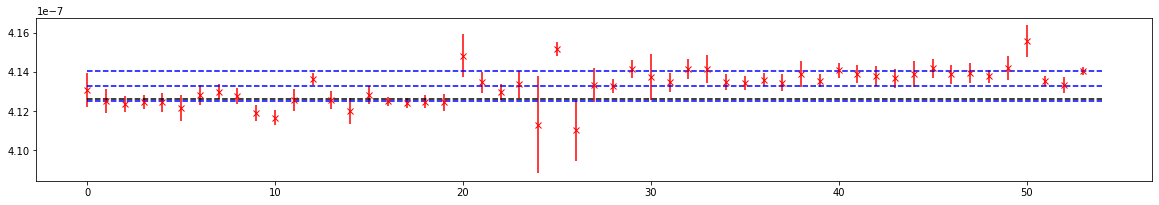

tensor(4.126233001181e-07, dtype=torch.float64)
tensor(4.132770505875e-07, dtype=torch.float64)
tensor(7.729295600157e-10, dtype=torch.float64)



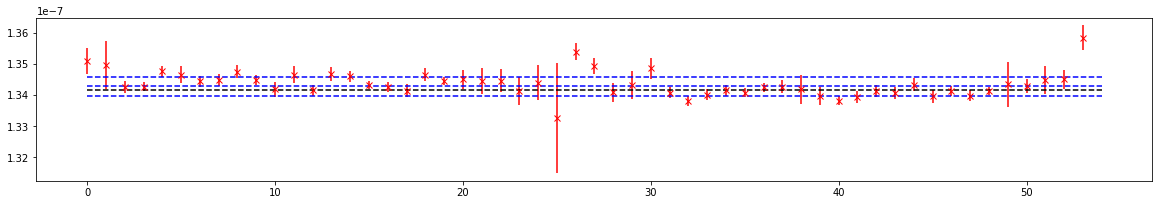

tensor(1.341508424269e-07, dtype=torch.float64)
tensor(1.342829497460e-07, dtype=torch.float64)
tensor(3.097286119775e-10, dtype=torch.float64)



In [16]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(range(54), invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, 0, 54, linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], 0, 54, linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

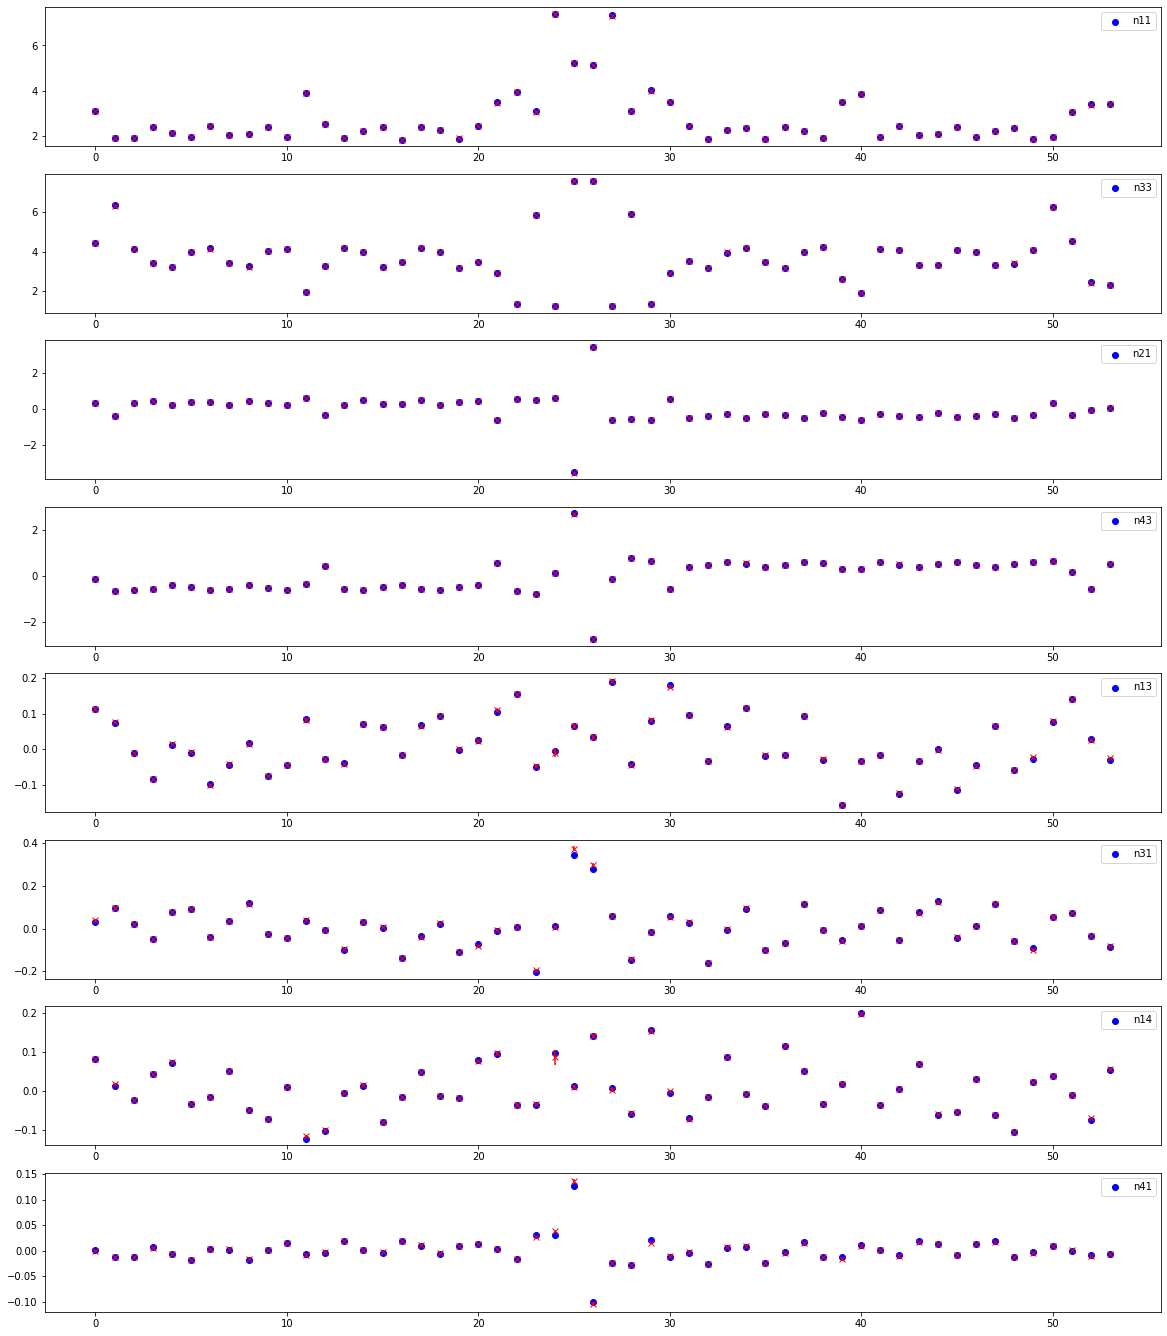

tensor(1.840366232815e-01, dtype=torch.float64)
tensor(2.517630718375e-01, dtype=torch.float64)
tensor(1.238599902008e-01, dtype=torch.float64)
tensor(1.610504891579e-01, dtype=torch.float64)
tensor(8.920662308923e-02, dtype=torch.float64)
tensor(1.637657828647e-01, dtype=torch.float64)
tensor(8.619295287344e-02, dtype=torch.float64)
tensor(7.813885179665e-02, dtype=torch.float64)


In [17]:
# Process twiss & compare

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value_n11 = data[:, 0, 2]
error_n11 = data[:, 1, 2]

value_n33 = data[:, 0, 3]
error_n33 = data[:, 1, 3]

value_n21 = data[:, 0, 4]
error_n21 = data[:, 1, 4]

value_n43 = data[:, 0, 5]
error_n43 = data[:, 1, 5]

value_n13 = data[:, 0, 6]
error_n13 = data[:, 1, 6]

value_n31 = data[:, 0, 7]
error_n31 = data[:, 1, 7]

value_n14 = data[:, 0, 8]
error_n14 = data[:, 1, 8]

value_n41 = data[:, 0, 9]
error_n41 = data[:, 1, 9]

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

In [18]:
%%time

# Estimate twiss from ratio
# Given max signal length to use (256), samples (with length equal to window length) are generated using start shift with given step (4)
# Errors for each sample are estimated from inverse Hessian diagonal

# Note, since samples are generated using shifts, they are highly correlated

# Note, given free elements, full normalization matrix can be computed
# And invariants can be estimated from transformed orbits
# This can be used to filter data from samples

from harmonica.parameterization import parametric_normal
window = Window.cosine_window(128, 1.0, dtype=dtype, device=device)
data = twiss.get_twiss_from_ratio(1, 256, window, nux, nuy, parametric_normal, model.matrix, step=4, verbose=False)
print(data.shape)

torch.Size([54, 2, 8, 33])
CPU times: user 33 s, sys: 774 ms, total: 33.8 s
Wall time: 3min 58s


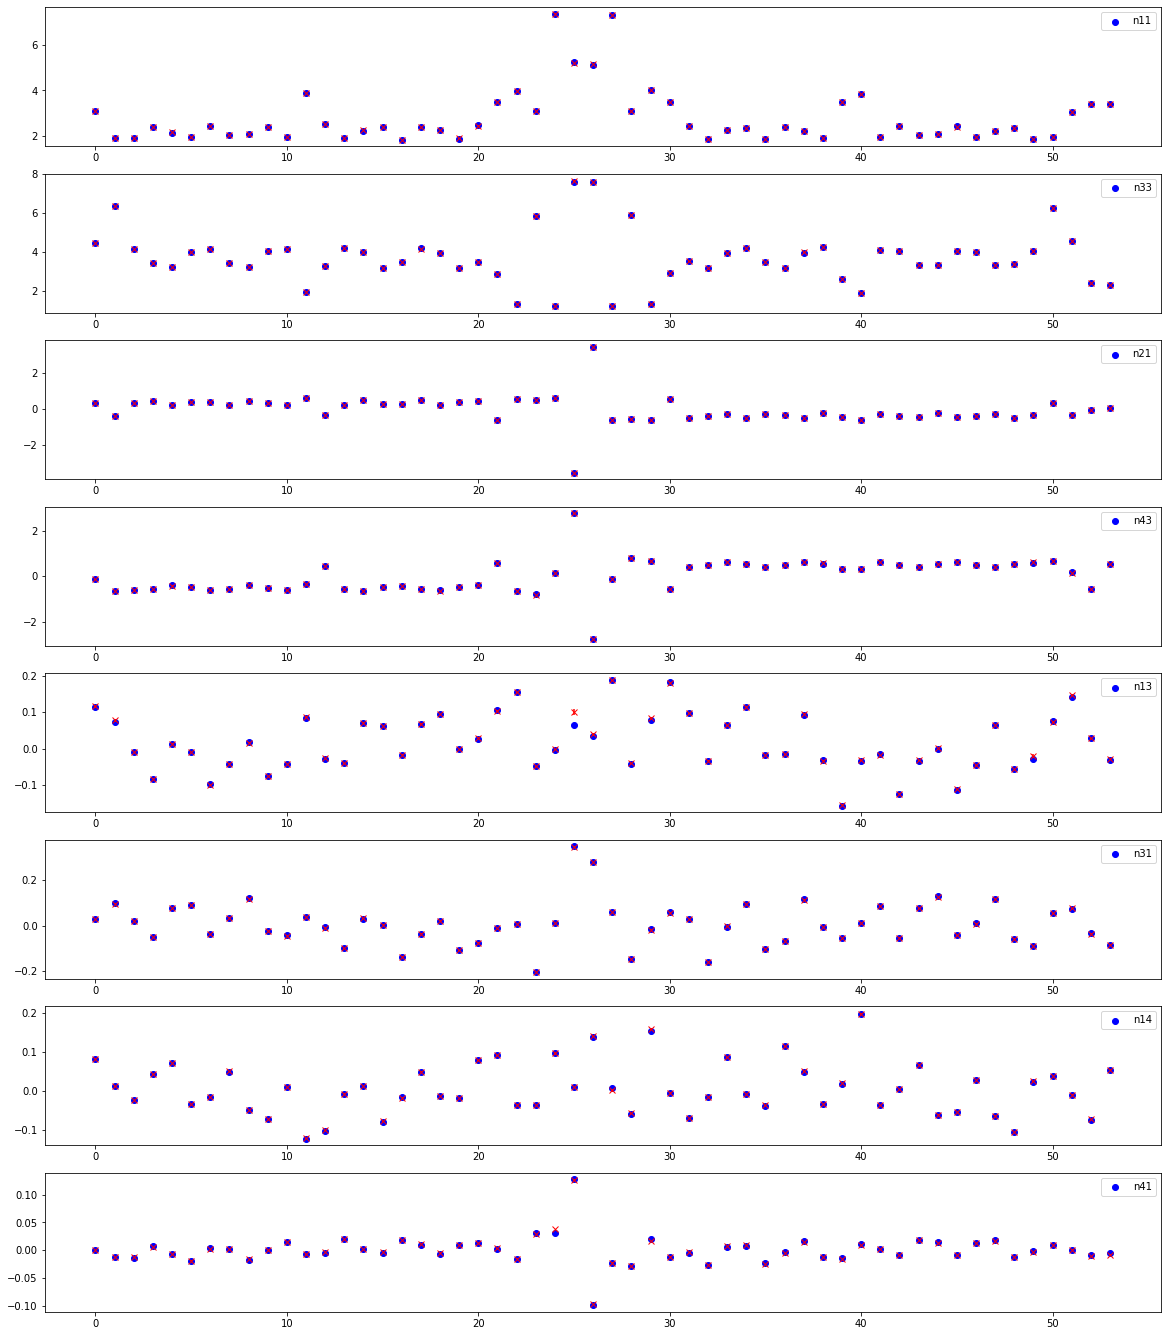

tensor(1.497865813383e-01, dtype=torch.float64)
tensor(2.760299941013e-01, dtype=torch.float64)
tensor(1.159679238429e-01, dtype=torch.float64)
tensor(1.371000992627e-01, dtype=torch.float64)
tensor(1.248891286057e-01, dtype=torch.float64)
tensor(4.584377979726e-02, dtype=torch.float64)
tensor(4.196112713564e-02, dtype=torch.float64)
tensor(5.930677088445e-02, dtype=torch.float64)


In [19]:
# Process twiss & compare

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

In [20]:
%%time

# Twiss at virtual locations (from virtual orbits)
# Note, method='lstsq'

from harmonica.parameterization import parametric_normal
window = Window.cosine_window(128, 1.0, dtype=dtype, device=device)
data = twiss.get_twiss_from_ratio(1,
                                  256,
                                  window,
                                  nux,
                                  nuy,
                                  parametric_normal,
                                  model.matrix,
                                  method='lstsq',
                                  limit=2,
                                  phony=True,
                                  step=4,
                                  verbose=False)
print(data.shape)
print(model.virtual_count)

torch.Size([5, 2, 8, 33])
5
CPU times: user 3.23 s, sys: 49.2 ms, total: 3.28 s
Wall time: 23.1 s


In [21]:
# Process twiss

value_n11 = data[:, 0, 0]
error_n11 = data[:, 1, 0]

value_n33 = data[:, 0, 1]
error_n33 = data[:, 1, 1]

value_n21 = data[:, 0, 2]
error_n21 = data[:, 1, 2]

value_n43 = data[:, 0, 3]
error_n43 = data[:, 1, 3]

value_n13 = data[:, 0, 4]
error_n13 = data[:, 1, 4]

value_n31 = data[:, 0, 5]
error_n31 = data[:, 1, 5]

value_n14 = data[:, 0, 6]
error_n14 = data[:, 1, 6]

value_n41 = data[:, 0, 7]
error_n41 = data[:, 1, 7]

value_n11, error_n11 = twiss.process(value_n11, error_n11)
value_n33, error_n33 = twiss.process(value_n33, error_n33)
value_n21, error_n21 = twiss.process(value_n21, error_n21)
value_n43, error_n43 = twiss.process(value_n43, error_n43)
value_n13, error_n13 = twiss.process(value_n13, error_n13)
value_n31, error_n31 = twiss.process(value_n31, error_n31)
value_n14, error_n14 = twiss.process(value_n14, error_n14)
value_n41, error_n41 = twiss.process(value_n41, error_n41)

In [22]:
# Compare with exact values

numpy.set_printoptions(linewidth=160)

from harmonica.parameterization import cs_normal

for index, location in enumerate(model.virtual_index):
    print(cs_normal(model.ax[location], model.bx[location], model.ay[location], model.by[location])[[0, 2, 1, 3, 0, 2, 0, 3], [0, 2, 0, 2, 2, 0, 3, 0]].cpu().numpy())
    print(torch.stack([value_n11[index], value_n33[index], value_n21[index], value_n43[index], value_n13[index], value_n31[index], value_n14[index], value_n41[index]]).cpu().numpy())
    print(model.out_normal[location][[0, 2, 1, 3, 0, 2, 0, 3], [0, 2, 0, 2, 2, 0, 3, 0]].cpu().numpy())
    print()

[ 2.73266554  3.98175692  0.24822713 -0.16435968  0.          0.          0.          0.        ]
[ 3.09498799e+00  4.45066036e+00  3.34801071e-01 -1.38130934e-01  1.21672774e-01  1.98529030e-02  8.41814154e-02  3.34813078e-03]
[ 3.09332793e+00  4.46100554e+00  3.28998221e-01 -1.32569941e-01  1.14105708e-01  2.88173745e-02  8.29471143e-02  1.46741228e-03]

[ 3.77337285  3.72233085 -0.51812134  0.74143651  0.          0.          0.          0.        ]
[ 4.34387898  4.28718262 -0.60789202  0.86429693  0.18760715  0.05431677  0.06353717  0.01054658]
[ 4.35516864  4.29182722 -0.61010319  0.86477906  0.1806821   0.05300886  0.0633173   0.00874029]

[ 8.66226410e-01  2.60206455e-01 -1.96353015e-13 -5.46137670e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 0.960884    0.29275845 -0.02803199  0.02681202 -0.04150021 -0.00386053 -0.02168269 -0.0561629 ]
[ 0.9614814   0.2919285  -0.02919493 -0.20044008 -0.04047926 -0.00264043 -0.01190208 -0.05654873]

[ 3.77337285  3.722

# Example-13: Twiss from n-turn matrix

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example coupled twiss parameters are estimated from n-turn matrix

# Given (filtered) TbT data at each monitor location, twiss parameters at each probed monitor are estimated using x & y signals
# Other monitors are used to compute momentum at the probed monitor using model (or measured) transport matrix
# n-turn matrix is fitter using phase space data
# Twiss parameters are computed from symplectified n-turn matrix

# Note, in this example unfiltered TbT data is used
# Note, for computation of momenta at the probed monitor, only the next monitor is used
# Methods using several monitors are also avaliable

In [4]:
# Set model with errors

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 0.5E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 1024, 4])

4.895892016e-07, 8.680765804e-19
1.474754710e-07, 2.493207120e-20



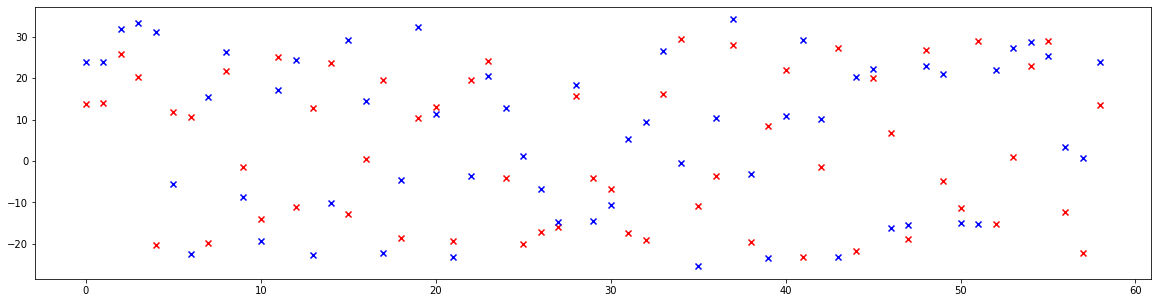

tensor(7.525459770826e+01, dtype=torch.float64)
tensor(1.402279645373e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [7]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.580862279
nux= 0.580862273, sigma_nux=1.25506611e-07, error_nux=6.16159856e-09


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.614216259
nuy= 0.614216259, sigma_nuy=1.62831169e-07, error_nuy=7.07237047e-10


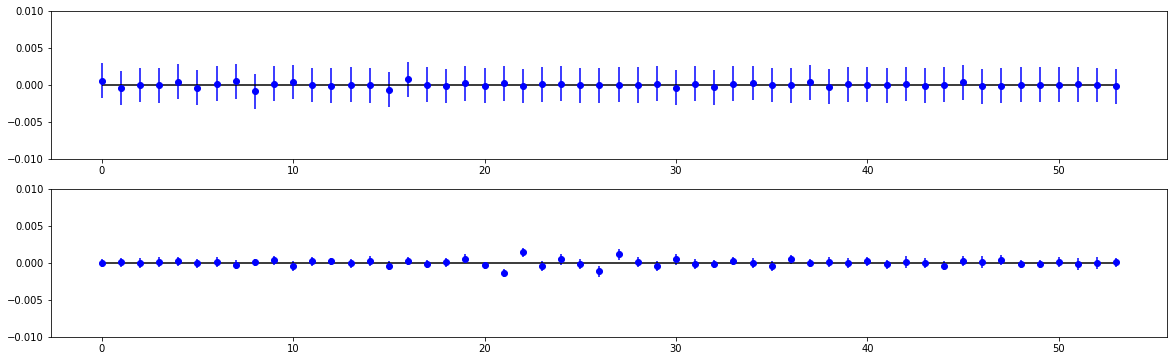

In [10]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, ax, ay, fx, fy, sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [11]:
# Set twiss

twiss = Twiss(model, table)

In [12]:
%%time

# Estimate twiss from matrix
# Use first 512 turns from each signal to fit 1-turn matrix using 256 samples of length int(0.75*512)

# For each sample in each signal tunes and free normalization matrix elements are returned
# All zeros if matrix is unstable
# (nux, nuy, n11, n33, n21, n43, n13, n31, n14, n41)

data = twiss.get_twiss_from_matrix(1, 512, model.matrix, power=1, count=512, fraction=0.75)
print(data.shape)

torch.Size([54, 10, 512])
CPU times: user 3min 44s, sys: 278 ms, total: 3min 44s
Wall time: 38.9 s


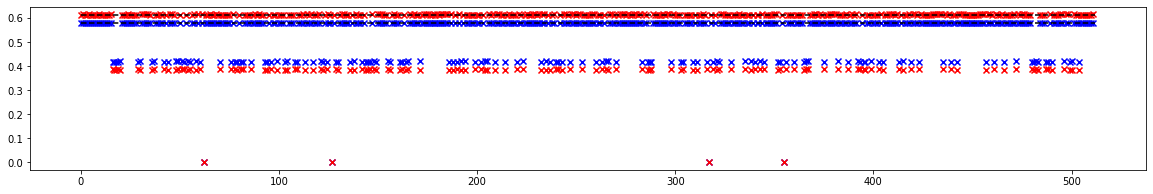

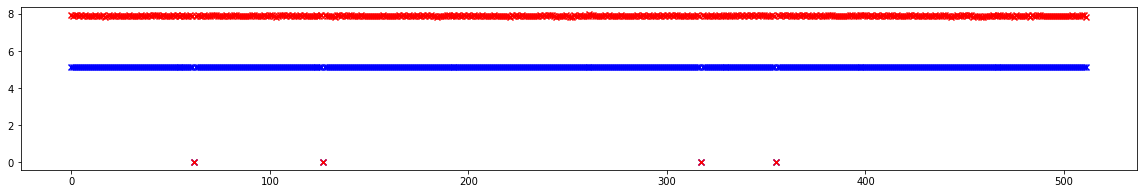

In [13]:
# In this example, fit from trajectories near IP is not accurate
# But 'good' sampes (tunewise) can be selected based on all tune data
# Note, twiss parameters are not necessarily bad for such samples

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 1].cpu().numpy(), color='red', marker='x')
plt.hlines([nux.item(), nuy.item()], 0, 512, linestyles='dashed', color='black')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 3].cpu().numpy(), color='red', marker='x')
plt.show()

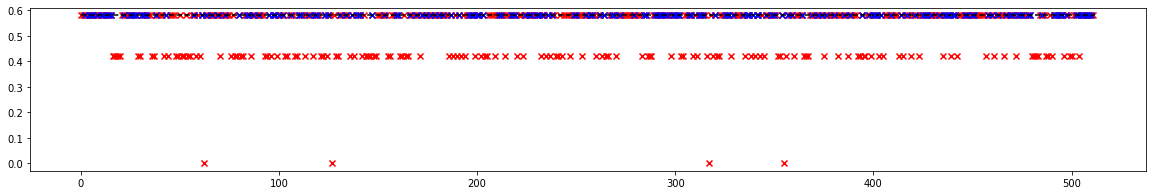

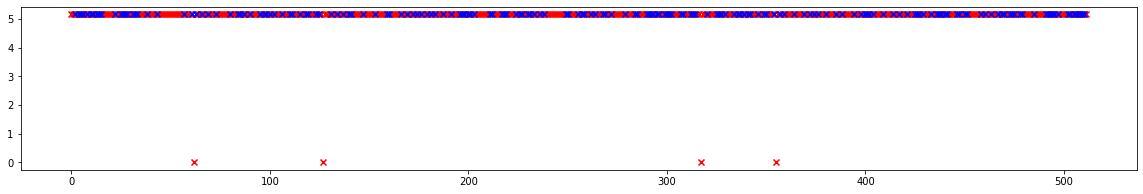

tensor(185)


In [14]:
# Generate tune mask

from harmonica.statistics import standardize
from harmonica.statistics import median, biweight_midvariance
from harmonica.anomaly import threshold

factor = torch.tensor(5.0, dtype=dtype, device=device)

tune_x = standardize(data[:, 0].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(tune_x, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

tune_y = standardize(data[:, 1].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(tune_y, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 0][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.hlines([nux.item()], 0, 512, linestyles='dashed', color='black')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 2][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.show()

print((mask_x[index]*mask_y[index]).sum())

In [15]:
# Process twiss

from harmonica.statistics import weighted_mean, weighted_variance

value_nux = weighted_mean(data[:, 0], weight=mask_x*mask_y)
value_nuy = weighted_mean(data[:, 1], weight=mask_x*mask_y)
value_n11 = weighted_mean(data[:, 2], weight=mask_x*mask_y)
value_n33 = weighted_mean(data[:, 3], weight=mask_x*mask_y)
value_n21 = weighted_mean(data[:, 4], weight=mask_x*mask_y)
value_n43 = weighted_mean(data[:, 5], weight=mask_x*mask_y)
value_n13 = weighted_mean(data[:, 6], weight=mask_x*mask_y)
value_n31 = weighted_mean(data[:, 7], weight=mask_x*mask_y)
value_n14 = weighted_mean(data[:, 8], weight=mask_x*mask_y)
value_n41 = weighted_mean(data[:, 9], weight=mask_x*mask_y)

error_nux = weighted_variance(data[:, 0], weight=mask_x*mask_y).sqrt()
error_nuy = weighted_variance(data[:, 1], weight=mask_x*mask_y).sqrt()
error_n11 = weighted_variance(data[:, 2], weight=mask_x*mask_y).sqrt()
error_n33 = weighted_variance(data[:, 3], weight=mask_x*mask_y).sqrt()
error_n21 = weighted_variance(data[:, 4], weight=mask_x*mask_y).sqrt()
error_n43 = weighted_variance(data[:, 5], weight=mask_x*mask_y).sqrt()
error_n13 = weighted_variance(data[:, 6], weight=mask_x*mask_y).sqrt()
error_n31 = weighted_variance(data[:, 7], weight=mask_x*mask_y).sqrt()
error_n14 = weighted_variance(data[:, 8], weight=mask_x*mask_y).sqrt()
error_n41 = weighted_variance(data[:, 9], weight=mask_x*mask_y).sqrt()

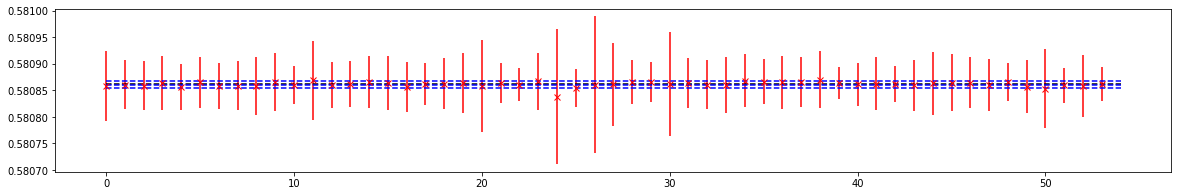

mqx= 0.580862279
nux= 0.580862273, sigma_nux=1.25506611e-07, error_nux=6.16159856e-09
nux= 0.580860826, sigma_nux=6.14135757e-06, error_nux=1.45292499e-06


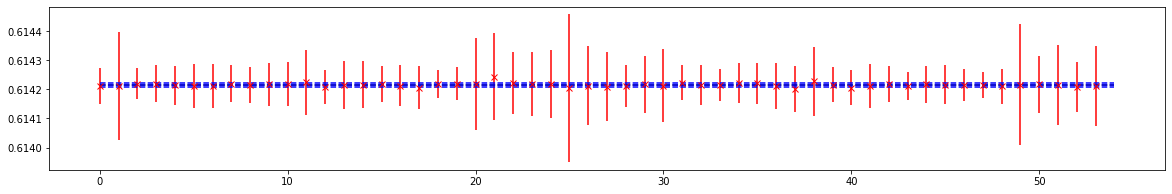

mqy= 0.614216259
nuy= 0.614216259, sigma_nuy=1.62831169e-07, error_nuy=7.07237047e-10
nuy= 0.614215915, sigma_nuy=7.50963896e-06, error_nuy=3.44729722e-07


In [16]:
# Compare tunes

value = weighted_mean(value_nux, error_nux)
error = weighted_variance(value_nux, error_nux).sqrt()

plt.figure(figsize=(20, 3))
plt.errorbar(range(model.monitor_count), value_nux, yerr=error_nux, fmt=' ', color='red', marker='x')
plt.hlines(nux.item(), 0, model.monitor_count, linestyles='dashed', color='black')
plt.hlines([(value - error).item(), value.item(), (value + error).item()], 0, model.monitor_count, linestyles='dashed', color='blue')
plt.show()

print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')
print(f'nux={value.item():12.9}, sigma_nux={error.item():12.9}, error_nux={abs(mqx - value).item():12.9}')

value = weighted_mean(value_nuy, error_nuy)
error = weighted_variance(value_nuy, error_nuy).sqrt()

plt.figure(figsize=(20, 3))
plt.errorbar(range(model.monitor_count), value_nuy, yerr=error_nuy, fmt=' ', color='red', marker='x')
plt.hlines(nuy.item(), 0, model.monitor_count, linestyles='dashed', color='black')
plt.hlines([(value - error).item(), value.item(), (value + error).item()], 0, model.monitor_count, linestyles='dashed', color='blue')
plt.show()

print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')
print(f'nuy={value.item():12.9}, sigma_nuy={error.item():12.9}, error_nuy={abs(mqy - value).item():12.9}')

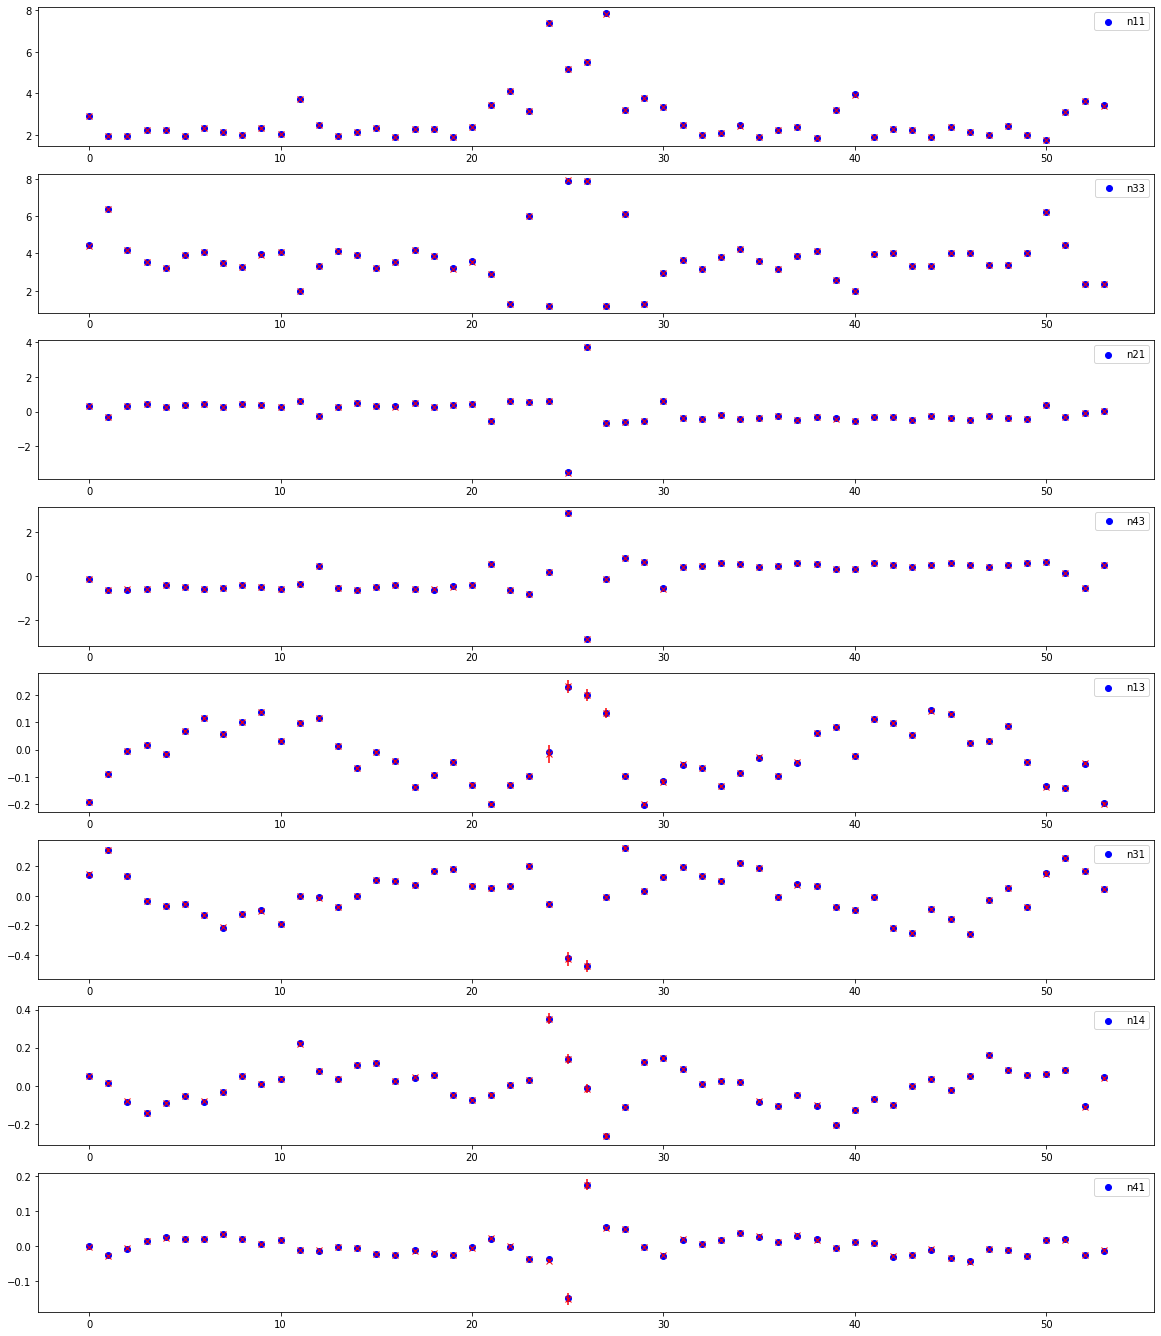

tensor(1.536826732566e-01, dtype=torch.float64)
tensor(2.240528897366e-01, dtype=torch.float64)
tensor(1.216890489909e-01, dtype=torch.float64)
tensor(1.697359916509e-01, dtype=torch.float64)
tensor(4.091691261419e-02, dtype=torch.float64)
tensor(5.322800913974e-02, dtype=torch.float64)
tensor(3.634824916661e-02, dtype=torch.float64)
tensor(7.644545844962e-02, dtype=torch.float64)


In [17]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

In [18]:
%%time

# Estimate twiss from matrix
# Use first 512 turns from each signal to fit 2-turn matrix using 256 samples of length int(0.75*512)

# For each sample in each signal tunes and free normalization matrix elements are returned
# All zeros if matrix is unstable
# (nux, nuy, n11, n33, n21, n43, n13, n31, n14, n41)

data = twiss.get_twiss_from_matrix(1, 512, model.matrix, power=2, count=512, fraction=0.75)
print(data.shape)

torch.Size([54, 10, 512])
CPU times: user 3min 50s, sys: 334 ms, total: 3min 50s
Wall time: 40.7 s


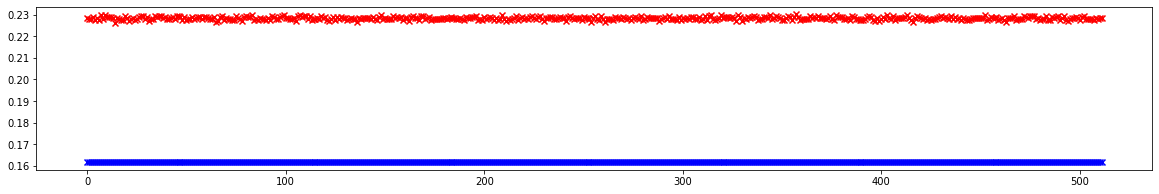

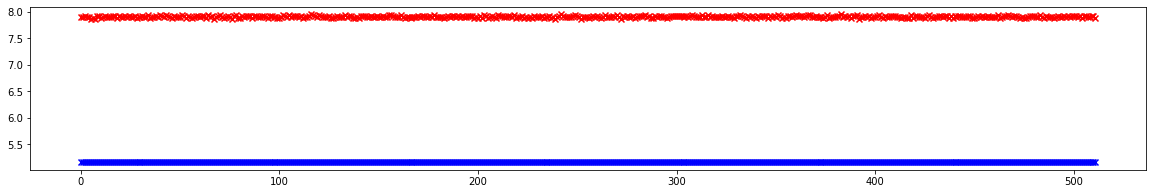

In [19]:
# In this example, fit from trajectories near IP with 2-turn matrix is more accurate

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 1].cpu().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='blue', marker='x')
plt.scatter(range(512), data[index, 3].cpu().numpy(), color='red', marker='x')
plt.show()

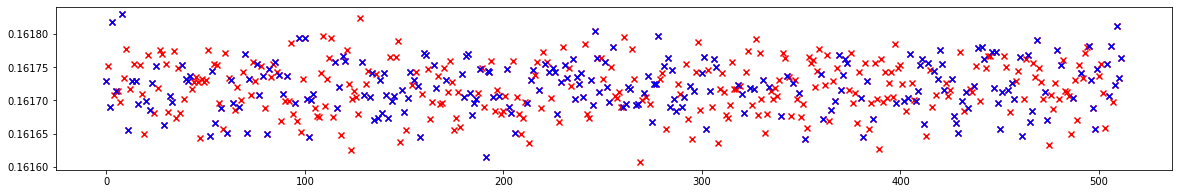

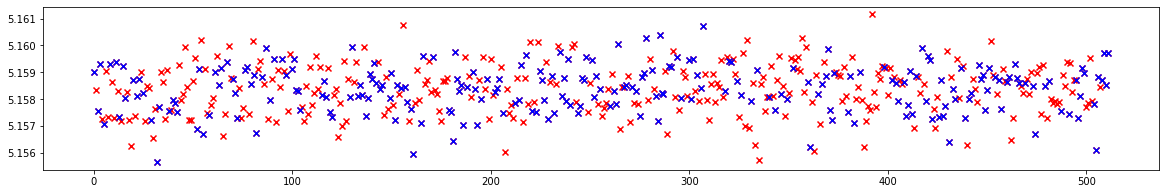

tensor(234)


In [20]:
# Generate tune mask

from harmonica.statistics import standardize
from harmonica.statistics import median, biweight_midvariance
from harmonica.anomaly import threshold

factor = torch.tensor(5.0, dtype=dtype, device=device)

tune_x = standardize(data[:, 0].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(tune_x, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

tune_y = standardize(data[:, 1].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(tune_y, -factor, +factor).squeeze().reshape(model.monitor_count, -1)

index = 25
plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 0].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 0][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(512), data[index, 2].cpu().numpy(), color='red', marker='x')
plt.scatter(torch.arange(512)[mask_x[index]*mask_y[index]], data[index, 2][mask_x[index]*mask_y[index]].cpu().numpy(), color='blue', marker='x')
plt.show()

print((mask_x[index]*mask_y[index]).sum())

In [21]:
# Process twiss

from harmonica.statistics import weighted_mean, weighted_variance

value_nux = weighted_mean(data[:, 0], weight=mask_x*mask_y)
value_nuy = weighted_mean(data[:, 1], weight=mask_x*mask_y)
value_n11 = weighted_mean(data[:, 2], weight=mask_x*mask_y)
value_n33 = weighted_mean(data[:, 3], weight=mask_x*mask_y)
value_n21 = weighted_mean(data[:, 4], weight=mask_x*mask_y)
value_n43 = weighted_mean(data[:, 5], weight=mask_x*mask_y)
value_n13 = weighted_mean(data[:, 6], weight=mask_x*mask_y)
value_n31 = weighted_mean(data[:, 7], weight=mask_x*mask_y)
value_n14 = weighted_mean(data[:, 8], weight=mask_x*mask_y)
value_n41 = weighted_mean(data[:, 9], weight=mask_x*mask_y)

error_nux = weighted_variance(data[:, 0], weight=mask_x*mask_y).sqrt()
error_nuy = weighted_variance(data[:, 1], weight=mask_x*mask_y).sqrt()
error_n11 = weighted_variance(data[:, 2], weight=mask_x*mask_y).sqrt()
error_n33 = weighted_variance(data[:, 3], weight=mask_x*mask_y).sqrt()
error_n21 = weighted_variance(data[:, 4], weight=mask_x*mask_y).sqrt()
error_n43 = weighted_variance(data[:, 5], weight=mask_x*mask_y).sqrt()
error_n13 = weighted_variance(data[:, 6], weight=mask_x*mask_y).sqrt()
error_n31 = weighted_variance(data[:, 7], weight=mask_x*mask_y).sqrt()
error_n14 = weighted_variance(data[:, 8], weight=mask_x*mask_y).sqrt()
error_n41 = weighted_variance(data[:, 9], weight=mask_x*mask_y).sqrt()

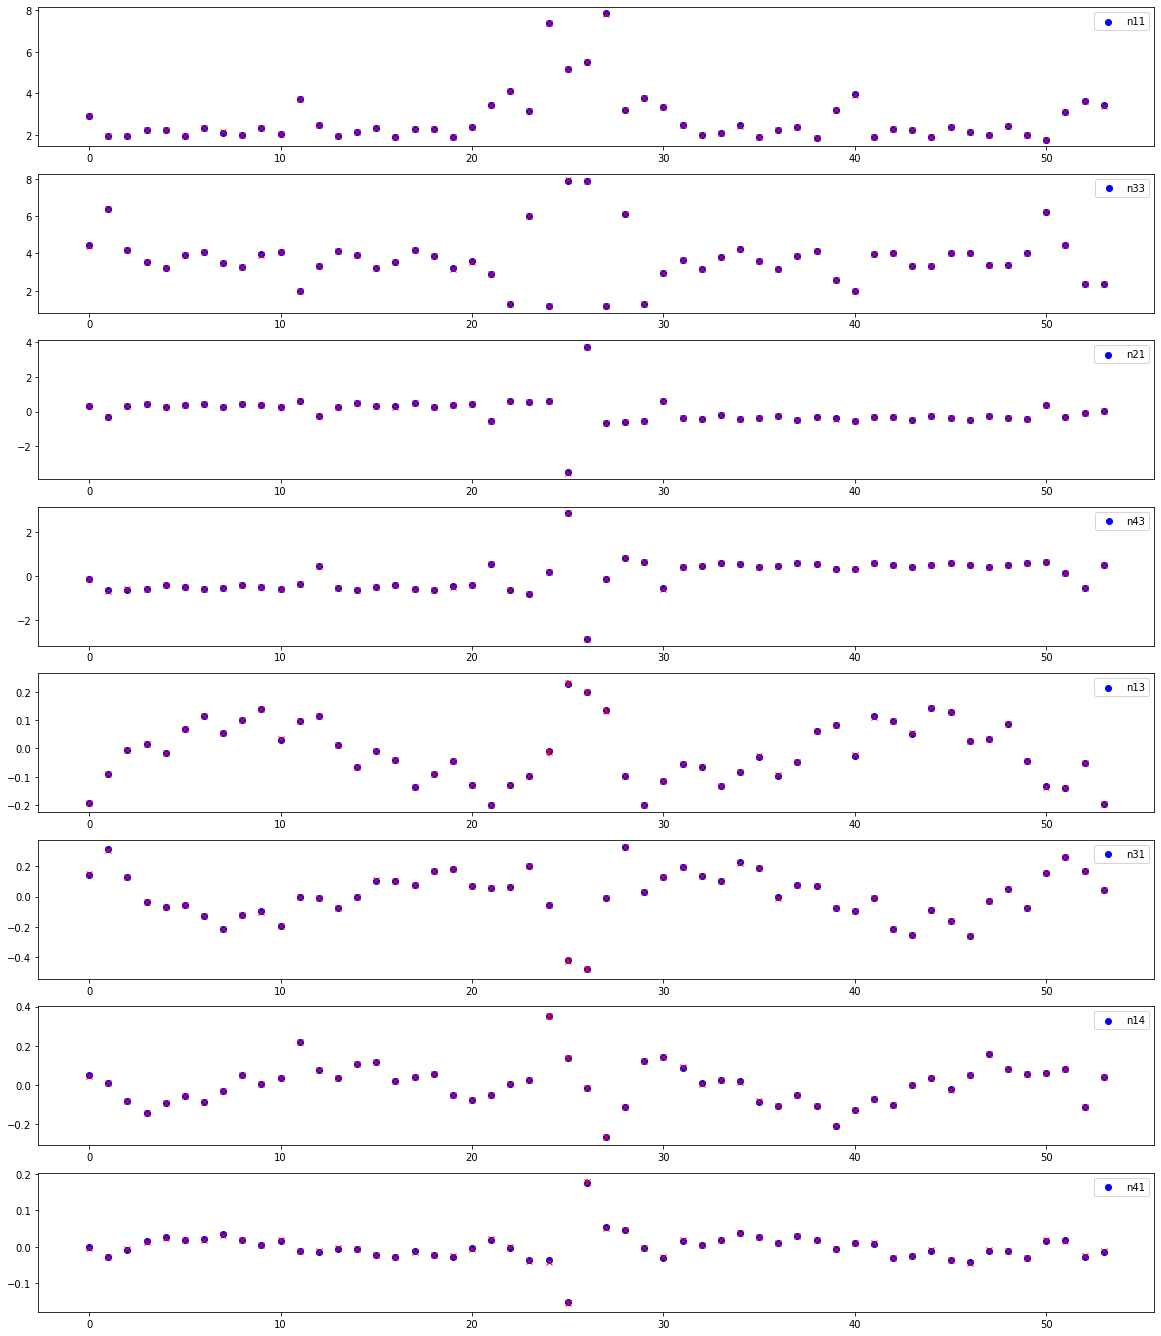

tensor(1.540921150982e-01, dtype=torch.float64)
tensor(2.245138868574e-01, dtype=torch.float64)
tensor(1.217342679456e-01, dtype=torch.float64)
tensor(1.682683346850e-01, dtype=torch.float64)
tensor(3.880326001892e-02, dtype=torch.float64)
tensor(4.966716000190e-02, dtype=torch.float64)
tensor(3.270253818594e-02, dtype=torch.float64)
tensor(7.561199992804e-02, dtype=torch.float64)


In [22]:
# Compare normalization matrix elements with exact values

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.monitor_count), N11, color='blue', marker='o', label='n11')
ax.errorbar(range(model.monitor_count), value_n11, yerr=error_n11, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(812)
ax.scatter(range(model.monitor_count), N33, color='blue', marker='o', label='n33')
ax.errorbar(range(model.monitor_count), value_n33, yerr=error_n33, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(813)
ax.scatter(range(model.monitor_count), N21, color='blue', marker='o', label='n21')
ax.errorbar(range(model.monitor_count), value_n21, yerr=error_n21, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(814)
ax.scatter(range(model.monitor_count), N43, color='blue', marker='o', label='n43')
ax.errorbar(range(model.monitor_count), value_n43, yerr=error_n43, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(815)
ax.scatter(range(model.monitor_count), N13, color='blue', marker='o', label='n13')
ax.errorbar(range(model.monitor_count), value_n13, yerr=error_n13, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(816)
ax.scatter(range(model.monitor_count), N31, color='blue', marker='o', label='n31')
ax.errorbar(range(model.monitor_count), value_n31, yerr=error_n31, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(817)
ax.scatter(range(model.monitor_count), N14, color='blue', marker='o', label='n14')
ax.errorbar(range(model.monitor_count), value_n14, yerr=error_n14, fmt=' ', color='red', marker='x')
ax.legend()

ax = plt.subplot(818)
ax.scatter(range(model.monitor_count), N41, color='blue', marker='o', label='n41')
ax.errorbar(range(model.monitor_count), value_n41, yerr=error_n41, fmt=' ', color='red', marker='x')
ax.legend()

plt.show()

print((N11 - value_n11).abs().sum())
print((N33 - value_n33).abs().sum())
print((N21 - value_n21).abs().sum())
print((N43 - value_n43).abs().sum())
print((N13 - value_n13).abs().sum())
print((N31 - value_n31).abs().sum())
print((N14 - value_n14).abs().sum())
print((N41 - value_n41).abs().sum())

In [23]:
%%time

# Twiss at virtual locations (from virtual orbits)
# Note, method='lstsq'

data = twiss.get_twiss_from_matrix(1, 
                                   512,
                                   model.matrix,
                                   power=2,
                                   method='lstsq',
                                   limit=2,
                                   phony=True,
                                   count=512, 
                                   fraction=0.75)
print(data.shape)
print(model.virtual_count)

torch.Size([5, 10, 512])
5
CPU times: user 20.9 s, sys: 57 ms, total: 21 s
Wall time: 3.67 s


In [24]:
# Process twiss

from harmonica.statistics import standardize
from harmonica.statistics import median, biweight_midvariance
from harmonica.anomaly import threshold

factor = torch.tensor(5.0, dtype=dtype, device=device)

tune_x = standardize(data[:, 0].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(tune_x, -factor, +factor).squeeze().reshape(model.virtual_count, -1)

tune_y = standardize(data[:, 1].flatten(), center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(tune_y, -factor, +factor).squeeze().reshape(model.virtual_count, -1)

from harmonica.statistics import weighted_mean, weighted_variance

value_nux = weighted_mean(data[:, 0], weight=mask_x*mask_y)
value_nuy = weighted_mean(data[:, 1], weight=mask_x*mask_y)
value_n11 = weighted_mean(data[:, 2], weight=mask_x*mask_y)
value_n33 = weighted_mean(data[:, 3], weight=mask_x*mask_y)
value_n21 = weighted_mean(data[:, 4], weight=mask_x*mask_y)
value_n43 = weighted_mean(data[:, 5], weight=mask_x*mask_y)
value_n13 = weighted_mean(data[:, 6], weight=mask_x*mask_y)
value_n31 = weighted_mean(data[:, 7], weight=mask_x*mask_y)
value_n14 = weighted_mean(data[:, 8], weight=mask_x*mask_y)
value_n41 = weighted_mean(data[:, 9], weight=mask_x*mask_y)

error_nux = weighted_variance(data[:, 0], weight=mask_x*mask_y).sqrt()
error_nuy = weighted_variance(data[:, 1], weight=mask_x*mask_y).sqrt()
error_n11 = weighted_variance(data[:, 2], weight=mask_x*mask_y).sqrt()
error_n33 = weighted_variance(data[:, 3], weight=mask_x*mask_y).sqrt()
error_n21 = weighted_variance(data[:, 4], weight=mask_x*mask_y).sqrt()
error_n43 = weighted_variance(data[:, 5], weight=mask_x*mask_y).sqrt()
error_n13 = weighted_variance(data[:, 6], weight=mask_x*mask_y).sqrt()
error_n31 = weighted_variance(data[:, 7], weight=mask_x*mask_y).sqrt()
error_n14 = weighted_variance(data[:, 8], weight=mask_x*mask_y).sqrt()
error_n41 = weighted_variance(data[:, 9], weight=mask_x*mask_y).sqrt()

In [25]:
# Compare with exact values

numpy.set_printoptions(linewidth=160)

from harmonica.parameterization import cs_normal

for index, location in enumerate(model.virtual_index):
    print(cs_normal(model.ax[location], model.bx[location], model.ay[location], model.by[location])[[0, 2, 1, 3, 0, 2, 0, 3], [0, 2, 0, 2, 2, 0, 3, 0]].cpu().numpy())
    print(torch.stack([value_n11[index], value_n33[index], value_n21[index], value_n43[index], value_n13[index], value_n31[index], value_n14[index], value_n41[index]]).cpu().numpy())
    print(model.out_normal[location][[0, 2, 1, 3, 0, 2, 0, 3], [0, 2, 0, 2, 2, 0, 3, 0]].cpu().numpy())
    print()

[ 2.73266554  3.98175692  0.24822713 -0.16435968  0.          0.          0.          0.        ]
[ 2.90280561e+00  4.44372770e+00  3.44277504e-01 -1.44217509e-01 -2.02128592e-01  1.39902256e-01  4.80283344e-02  7.55214698e-05]
[ 2.91471622e+00  4.43200625e+00  3.43512526e-01 -1.45931041e-01 -1.92005488e-01  1.45178433e-01  4.93948594e-02  1.25305037e-03]

[ 3.77337285  3.72233085 -0.51812134  0.74143651  0.          0.          0.          0.        ]
[ 4.2267671   4.26794116 -0.56059076  0.86005169 -0.23622492  0.18399668  0.08130168  0.04304078]
[ 4.23231243  4.27633    -0.56435254  0.86494767 -0.2375411   0.18247091  0.08232875  0.04192007]

[ 8.66226410e-01  2.60206455e-01 -1.96353015e-13 -5.46137670e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 0.93236155  0.28211643  0.15755958  0.09992774  0.05271287 -0.01193348 -0.01199356 -0.07294241]
[ 9.31481736e-01  2.83206328e-01  1.45543282e-01 -4.72736649e-01  5.36734208e-02 -1.12356569e-02 -8.03032657e-04 -7.08

# Example-14: Estimation of linear invariants

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# Given measured amplitudes and model (or measured) twiss parameters, invariants at each monitor location can be estimated
# Weighted average can be performed to estimate global invariant values and errors
# Twiss and invariant values can be estimated from TbT data
# Given measured twiss and orbits, invariant values can be estimated

In [4]:
# Set model with errors

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set errors

model.make_error(1.0E-3, 0.5E-3, length=0.01)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss (not used in generation of trajectories)

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

mqx, mqy = model.out_tune_fractional

True


torch.Size([54, 1024, 4])

4.589863105e-07, 1.756350611e-18
1.590047055e-07, 2.567855627e-19



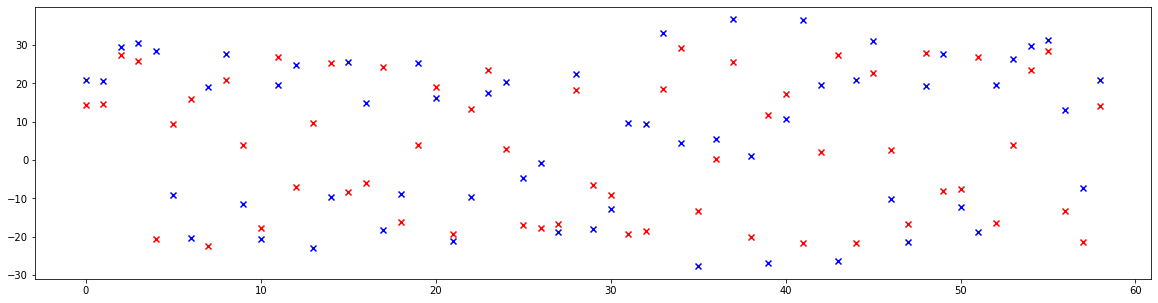

tensor(7.790745056412e+01, dtype=torch.float64)
tensor(1.537986054768e+02, dtype=torch.float64)



In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**10

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)[model.monitor_index]
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[..., 0]
y = trajectory[..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[model.monitor_index[index]], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_ax, cs_bx, cs_ay, cs_by = torch.stack([wolski_to_cs(w) for w in normal_to_wolski(model.out_normal)]).T

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(cs_bx - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(cs_by - model.by)/model.by, color='blue', marker='x')
plt.show()

error_x = (cs_bx[model.monitor_index] - model.bx[model.monitor_index]).abs().sum()
error_y = (cs_by[model.monitor_index] - model.by[model.monitor_index]).abs().sum()

print(error_x)
print(error_y)
print()

In [6]:
# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0][model.monitor_index]
N33 = model.out_normal[:, 2, 2][model.monitor_index]
N21 = model.out_normal[:, 1, 0][model.monitor_index]
N43 = model.out_normal[:, 3, 2][model.monitor_index]
N13 = model.out_normal[:, 0, 2][model.monitor_index]
N31 = model.out_normal[:, 2, 0][model.monitor_index]
N14 = model.out_normal[:, 0, 3][model.monitor_index]
N41 = model.out_normal[:, 3, 0][model.monitor_index]

# Using eight free elements other elements of normalization matrix can be computed from symplectic condition
# Note, N12 and N34 are fixed to zero values

from harmonica.parameterization import parametric_normal
print(torch.allclose(model.out_normal[model.monitor_index], torch.stack([parametric_normal(*free) for free in torch.stack([N11, N33, N21, N43, N13, N31, N14, N41]).T])))

True


In [7]:
# Generate TbT data

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x)
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y)
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(54, Window(1024, 'cosine_window', 1.0))
Data(54, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

from harmonica.statistics import trimmed_mean
from harmonica.statistics import trimmed_variance
f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - trimmed_mean(f.frequency, min_fraction=0.05, max_fraction=0.05), trimmed_variance(f.frequency, min_fraction=0.05, max_fraction=0.05).sqrt()
print(f'mqx={mqx.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(mqx - nux).item():12.9}')

# Filter data

flt.filter_svd(rank=4)
flt.filter_hankel(rank=4, random=True, buffer=16, count=16)

# Estimate amplitude & phase

dx = Decomposition(X)

axx, sigma_axx, _ = dx.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fxx, sigma_fxx, _ = dx.harmonic_phase(nux, length=512, order=0.0, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

mqx= 0.563452272
nux= 0.563452284, sigma_nux=1.09063496e-07, error_nux=1.27339795e-08


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

from harmonica.statistics import trimmed_mean
from harmonica.statistics import trimmed_variance
f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - trimmed_mean(f.frequency, min_fraction=0.05, max_fraction=0.05), trimmed_variance(f.frequency, min_fraction=0.05, max_fraction=0.05).sqrt()
print(f'mqy={mqy.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(mqy - nuy).item():12.9}')

# Filter data

flt.filter_svd(rank=4)
flt.filter_hankel(rank=4, random=True, buffer=16, count=16)

# Estimate amplitude & phase

dy = Decomposition(Y)

ayy, sigma_ayy, _ = dy.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fyy, sigma_fyy, _ = dy.harmonic_phase(nuy, length=512, order=0.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

mqy= 0.625220925
nuy= 0.625220923, sigma_nuy=1.39822937e-07, error_nuy=2.59344735e-09


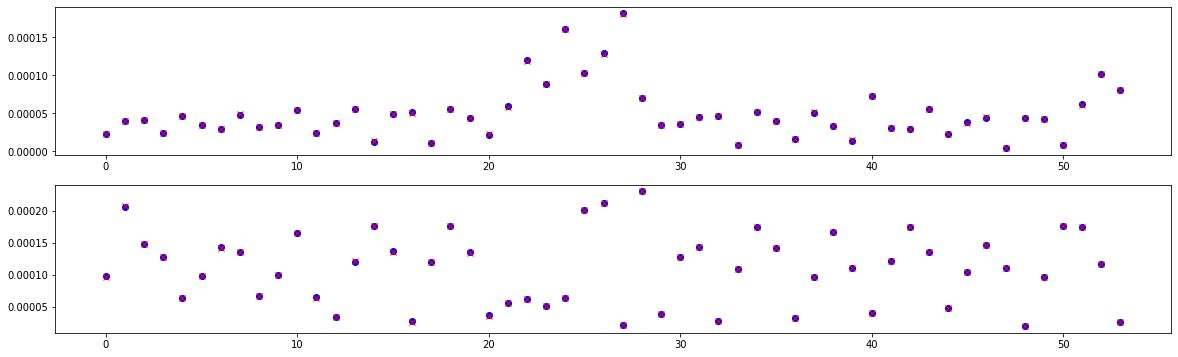

In [10]:
# Compute & plot coupled amplitudes

axy, sigma_axy, _ = dx.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
ayx, sigma_ayx, _ = dy.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), axy.cpu().numpy(), yerr=sigma_axy.cpu().numpy(), fmt=' ', color='red', marker='x')
ax.scatter(range(model.monitor_count), ((N13**2 + N14**2)*2*action_y).sqrt(), color='blue', marker='o')

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), ayx.cpu().numpy(), yerr=sigma_ayx.cpu().numpy(), fmt=' ', color='red', marker='x')
ax.scatter(range(model.monitor_count), ((N31**2 + N14**2*N33**2/N11**2)*2*action_x).sqrt(), color='blue', marker='o')

plt.show()

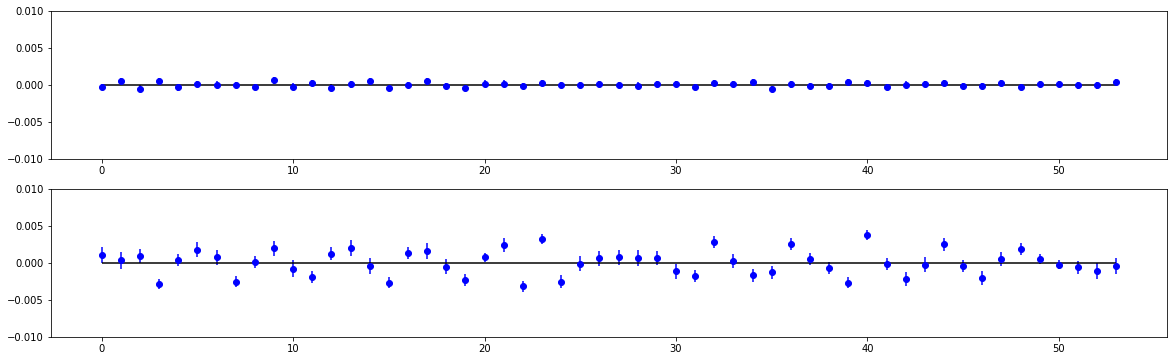

In [11]:
# Set table

table = Table(
    [name for name, kind in zip(model.name, model.kind) if kind == 'MONITOR'],
    nux, nuy, axx, ayy, fxx, fyy, sigma_nux, sigma_nuy, sigma_axx, sigma_ayy, sigma_fxx, sigma_fyy,
    x=X.work,
    y=Y.work,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(mqx, mux)
muy, _ = Decomposition.phase_adjacent(mqy, muy)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax.hlines(0, 0, model.monitor_count - 1, colors='black')
ax.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

In [12]:
# Set twiss 

twiss = Twiss(model, table, limit=4)

In [13]:
# Estimate twiss from amplitude

twiss.get_action()
twiss.get_twiss_from_amplitude()

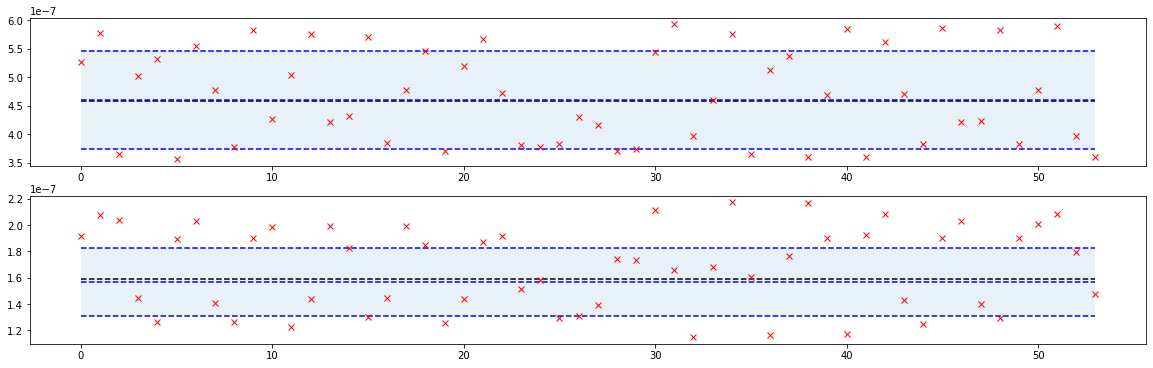

[4.58986310e-07 4.60173749e-07 8.68067835e-08]
[1.59004706e-07 1.56684663e-07 2.56581352e-08]


In [14]:
# Plot actions (estimated using amplitude and model twiss parameters)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), twiss.action['jx'].cpu().numpy(), yerr=twiss.action['sigma_jx'].cpu().numpy(), fmt=' ', marker='x', color='red')
ax.hlines([action_x.cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='black')
ax.hlines([(twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), twiss.action['center_jx'].cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy(), alpha=0.1)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), twiss.action['jy'].cpu().numpy(), yerr=twiss.action['sigma_jy'].cpu().numpy(), fmt=' ', marker='x', color='red')
ax.hlines([action_y.cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='black')
ax.hlines([(twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), twiss.action['center_jy'].cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy(), alpha=0.1)

plt.show()

print(torch.stack([action_x, twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([action_y, twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())

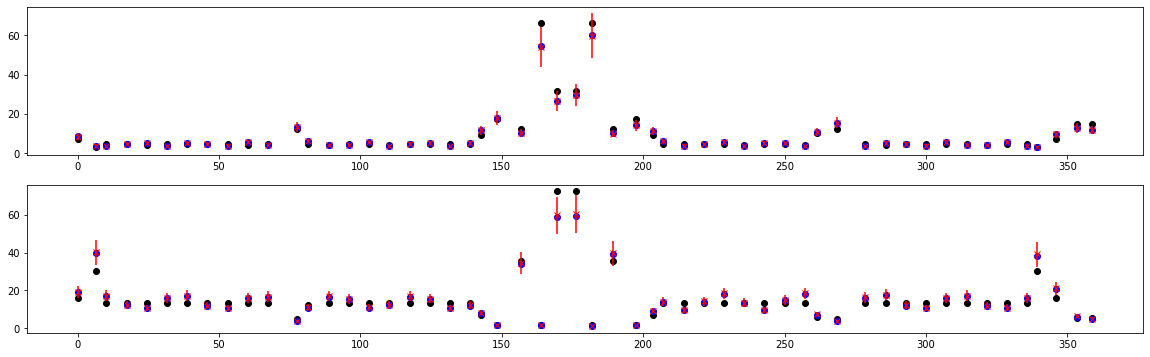

tensor(1.315738289344e+00, dtype=torch.float64)
tensor(1.256739101795e+01, dtype=torch.float64)


In [15]:
# Plot twiss

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

print((cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum())
print((cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum())

In [16]:
# Estimate twiss from phase

twiss.phase_virtual()
twiss.get_twiss_from_phase()

mask_x = twiss.filter_twiss(plane='x', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='x', mask=mask_x, weight=True) ;

mask_y = twiss.filter_twiss(plane='y', phase={'use': True, 'threshold': 10.0}, model={'use': True, 'threshold': 0.5}, value={'use': False, 'threshold': 0.5}, sigma={'use': False, 'threshold': 0.25}, limit={'use': True, 'threshold': 5.0})
twiss.process_twiss(plane='y', mask=mask_y, weight=True) ;

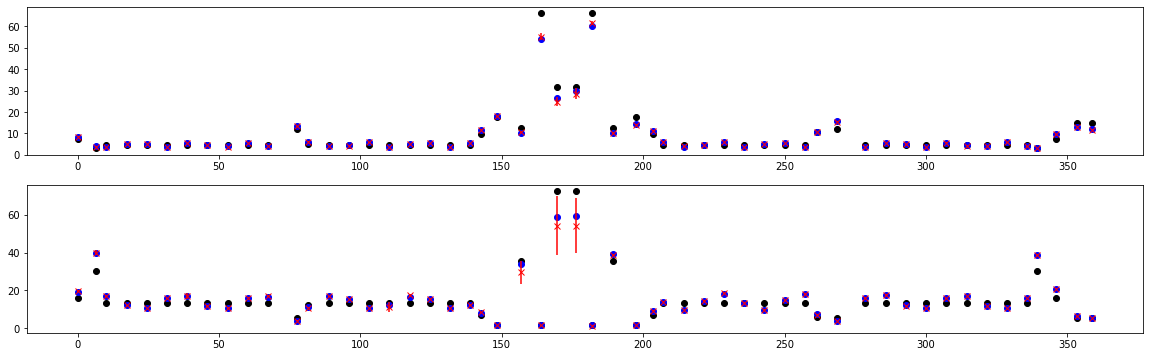

tensor(7.350112101962e+00, dtype=torch.float64)
tensor(2.106576185189e+01, dtype=torch.float64)


In [17]:
# Plot twiss

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.bx[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_bx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.by[model.monitor_index].cpu().numpy(), yerr=twiss.sigma_by[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

print((cs_bx[model.monitor_index] - twiss.bx[model.monitor_index]).abs().sum())
print((cs_by[model.monitor_index] - twiss.by[model.monitor_index]).abs().sum())

In [18]:
# Estimate twiss from amplitude (use twiss from phase for action estimation)

twiss.get_action(bx=twiss.bx[model.monitor_index],
                 by=twiss.by[model.monitor_index],
                 sigma_bx=twiss.sigma_bx[model.monitor_index],
                 sigma_by=twiss.sigma_by[model.monitor_index])

twiss.get_twiss_from_amplitude()

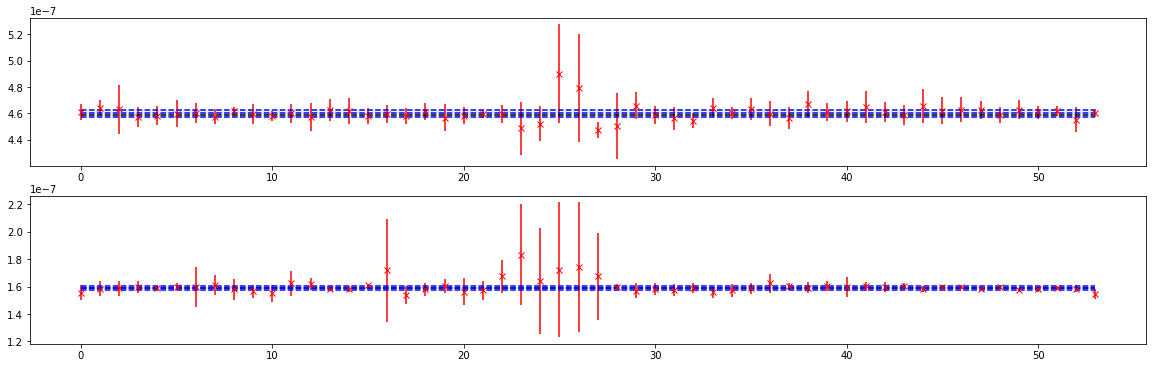

[4.58986310e-07 4.59999436e-07 2.95799736e-09]
[1.59004706e-07 1.59133554e-07 1.32366553e-09]


In [19]:
# Plot actions (estimated using amplitude and model twiss parameters)

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), twiss.action['jx'].cpu().numpy(), yerr=twiss.action['sigma_jx'].cpu().numpy(), fmt=' ', marker='x', color='red')
ax.hlines([action_x.cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='black')
ax.hlines([(twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), twiss.action['center_jx'].cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jx'] - twiss.action['spread_jx']).cpu().numpy(), (twiss.action['center_jx'] + twiss.action['spread_jx']).cpu().numpy(), alpha=0.1)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), twiss.action['jy'].cpu().numpy(), yerr=twiss.action['sigma_jy'].cpu().numpy(), fmt=' ', marker='x', color='red')
ax.hlines([action_y.cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='black')
ax.hlines([(twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), twiss.action['center_jy'].cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (twiss.action['center_jy'] - twiss.action['spread_jy']).cpu().numpy(), (twiss.action['center_jy'] + twiss.action['spread_jy']).cpu().numpy(), alpha=0.1)

plt.show()

print(torch.stack([action_x, twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([action_y, twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())

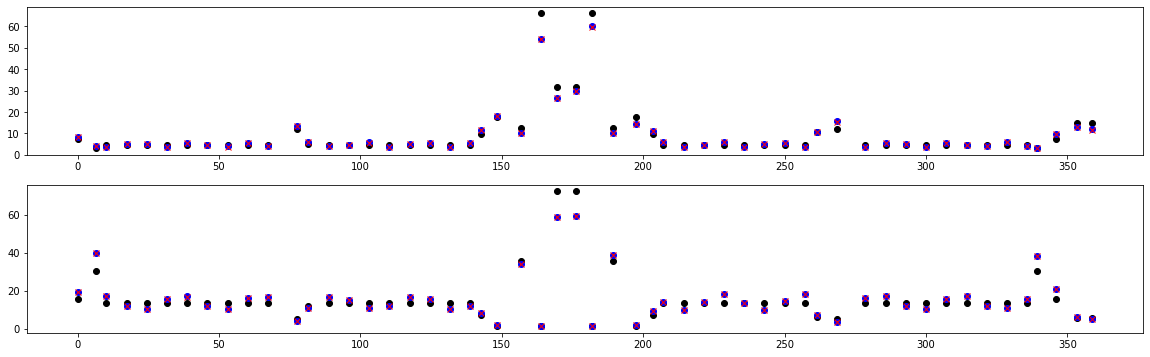

tensor(1.126261722220e+00, dtype=torch.float64)
tensor(6.538890436724e-01, dtype=torch.float64)


In [20]:
# Plot twiss

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['bx'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_bx'].cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), twiss.data_amplitude['by'].cpu().numpy(), yerr=twiss.data_amplitude['sigma_by'].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

print((cs_bx[model.monitor_index] - twiss.data_amplitude['bx']).abs().sum())
print((cs_by[model.monitor_index] - twiss.data_amplitude['by']).abs().sum())

In [21]:
%%time

# Estimate twiss from invariant fit (use first 256 turns and 128 random samples)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256, 
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None, 
                                 method='pair', 
                                 limit=1, 
                                 product=True, 
                                 jacobian=False, 
                                 count=128, 
                                 fraction=0.75, 
                                 ix=None, 
                                 iy=None, 
                                 n_jobs=6, 
                                 verbose=False)
print(data.shape)

torch.Size([54, 2, 10, 128])
CPU times: user 2min 5s, sys: 2.45 s, total: 2min 7s
Wall time: 3min 17s


In [22]:
# Process fitted invariants

ix = data[:, 0, 0]
iy = data[:, 0, 1]

sigma_ix = data[:, 1, 0]
sigma_iy = data[:, 1, 1]

invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

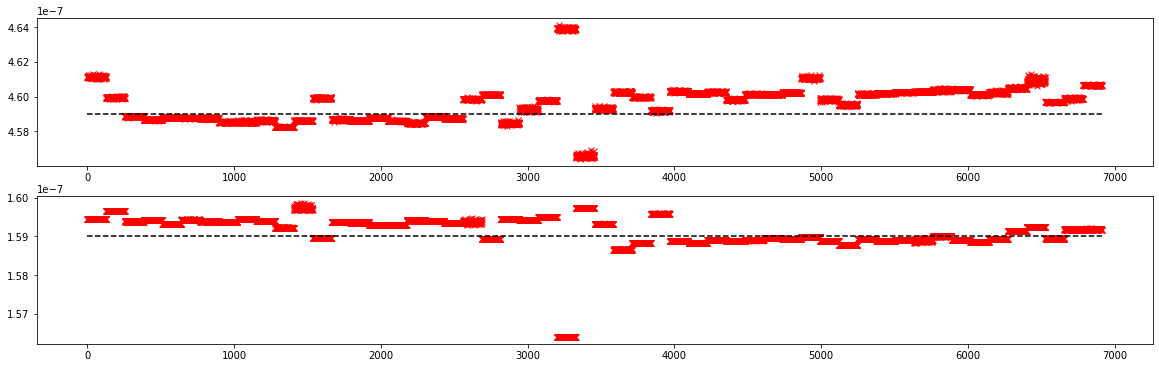

In [23]:
# Plot invariants for each sample in each signal

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(54*128), ix.flatten().cpu().numpy(), yerr=sigma_ix.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
ax.hlines(action_x, 0, 54*128, linestyles='dashed', color='black',  zorder=1)

ax = plt.subplot(212)
ax.errorbar(range(54*128), iy.flatten().cpu().numpy(), yerr=sigma_iy.flatten().cpu().numpy(), fmt=' ', color='red', marker='x', zorder=0)
ax.hlines(action_y, 0, 54*128, linestyles='dashed', color='black',  zorder=1)

plt.show()

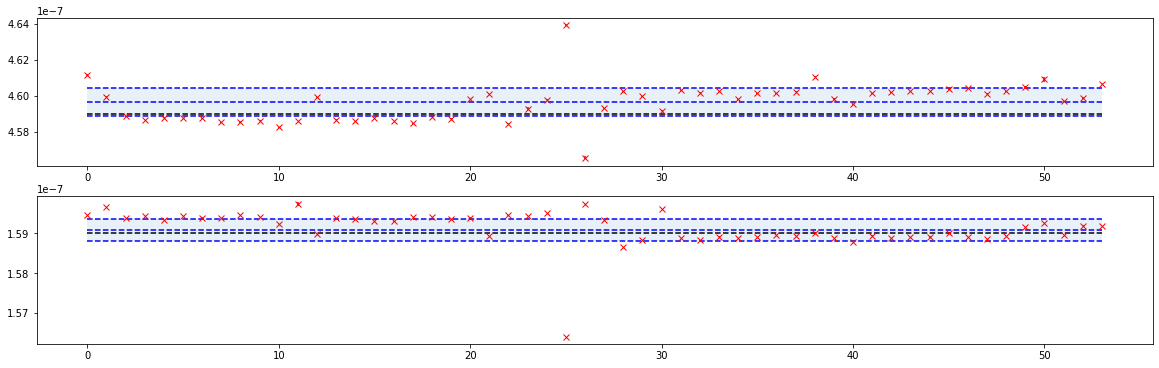

[4.58986310e-07 4.59999436e-07 2.95799736e-09]
[1.59004706e-07 1.59133554e-07 1.32366553e-09]

[4.58986310e-07 4.59648121e-07 7.72699939e-10]
[1.59004706e-07 1.59080435e-07 2.83733784e-10]



In [24]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.errorbar(range(model.monitor_count), invariant['ix_center'].cpu().numpy(), yerr=invariant['ix_spread'].cpu().numpy(), fmt=' ', color='red', marker='x')
ax.hlines(action_x.cpu().numpy(), 0, model.monitor_count - 1, linestyles='dashed', color='black')
ax.hlines([(invariant['ix_value'] - invariant['ix_error']).cpu().numpy(), invariant['ix_value'].cpu().numpy(), (invariant['ix_value'] + invariant['ix_error']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (invariant['ix_value'] - invariant['ix_error']).cpu().numpy(), (invariant['ix_value'] + invariant['ix_error']).cpu().numpy(), alpha=0.1)

ax = plt.subplot(212)
ax.errorbar(range(model.monitor_count), invariant['iy_center'].cpu().numpy(), yerr=invariant['iy_spread'].cpu().numpy(), fmt=' ', color='red', marker='x')
ax.hlines(action_y.cpu().numpy(), 0, model.monitor_count - 1, linestyles='dashed', color='black')
ax.hlines([(invariant['iy_value'] - invariant['iy_error']).cpu().numpy(), invariant['iy_value'].cpu().numpy(), (invariant['iy_value'] + invariant['iy_error']).cpu().numpy()], 0, model.monitor_count - 1, linestyles='dashed', color='blue')
ax.fill_between(range(model.monitor_count), (invariant['iy_value'] - invariant['iy_error']).cpu().numpy(), (invariant['iy_value'] + invariant['iy_error']).cpu().numpy(), alpha=0.1)

plt.show()

print(torch.stack([action_x, twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([action_y, twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())
print()

print(torch.stack([action_x, invariant['ix_value'], invariant['ix_error']]).cpu().numpy())
print(torch.stack([action_y, invariant['iy_value'], invariant['iy_error']]).cpu().numpy())
print()

In [25]:
# Process twiss parameters

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

*_, value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41 = data[:, 0].swapaxes(0, 1)
*_, error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41 = data[:, 1].swapaxes(0, 1)

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

out_value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
out_error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

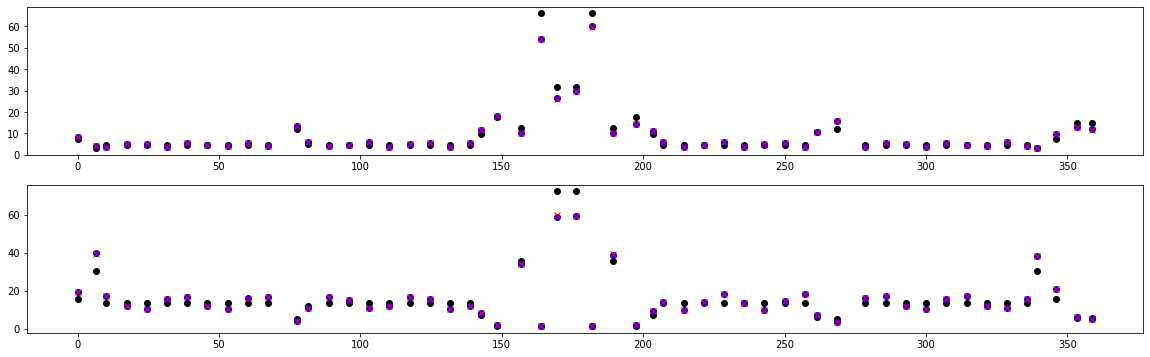

tensor(1.268905723158e+00, dtype=torch.float64)
tensor(2.507336772516e+00, dtype=torch.float64)


In [26]:
# Compute CS twiss

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

cs_value, cs_error = [], []

for value, error in zip(out_value, out_error):
    local = value.reshape(-1, 1) + error.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    local = torch.stack([parametric_normal(*free) for free in local.T])
    local = normal_to_wolski(local)
    local = torch.stack([wolski_to_cs(wolski) for wolski in local]).T
    cs_value.append(local.mean(-1))
    cs_error.append(local.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax, value_bx, value_ay, value_by = cs_value.T
error_ax, error_bx, error_ay, error_by = cs_error.T

plt.figure(figsize=(20, 3*2))

ax = plt.subplot(211)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.bx[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_bx[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_bx.cpu().numpy(), yerr=error_bx.cpu().numpy(), fmt=' ', marker='x', color='red')

ax = plt.subplot(212)
ax.scatter(model.time[model.monitor_index].cpu().numpy(), model.by[model.monitor_index].cpu().numpy(), marker='o', color='black')
ax.scatter(model.time[model.monitor_index].cpu().numpy(), cs_by[model.monitor_index].cpu().numpy(), marker='o', color='blue')
ax.errorbar(model.time[model.monitor_index].cpu().numpy(), value_by.cpu().numpy(), yerr=error_by.cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

print((cs_bx[model.monitor_index] - value_bx).abs().sum())
print((cs_by[model.monitor_index] - value_by).abs().sum())

In [27]:
# Compute orbits at each monitor location

limit = 2
orbit = []
for location in range(model.monitor_count):
    orbit.append(twiss.get_momenta_lstsq(1, 256, location, limit, model.matrix))
orbit = torch.stack(orbit)
print(orbit.shape)

torch.Size([54, 4, 256])


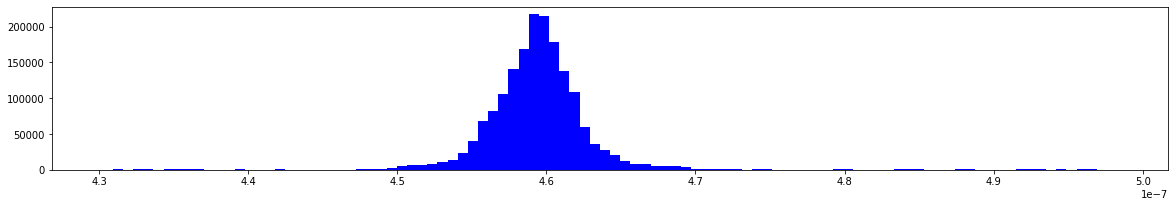

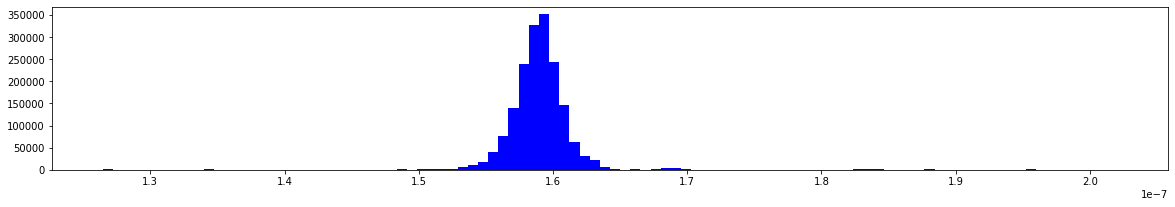

In [28]:
# Use measured twiss to estimate invariants

n11, n33, n21, n43, n13, n31, n14, n41 = out_value.T
e11, e33, e21, e43, e13, e31, e14, e41 = out_error.T

BAG_IX = []
BAG_IY = []
for location in range(model.monitor_count):
    for _ in range(128):
        m11 = n11[location] + e11[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m33 = n33[location] + e33[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m21 = n21[location] + e21[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m43 = n43[location] + e43[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m13 = n13[location] + e13[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m31 = n31[location] + e31[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m14 = n14[location] + e14[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        m41 = n41[location] + e41[location]*torch.randn(1, dtype=dtype, device=device).squeeze()
        normal = parametric_normal(m11, m33, m21, m43, m13, m31, m14, m41)
        QX, PX, QY, PY = normal.inverse() @ orbit[location]
        IX, IY = 0.5*(QX**2 + PX**2), 0.5*(QY**2 + PY**2)
        BAG_IX.append(IX)
        BAG_IY.append(IY)
BAG_IX = torch.stack(BAG_IX).flatten()
BAG_IY = torch.stack(BAG_IY).flatten()

from harmonica.statistics import standardize
from harmonica.statistics import median, biweight_midvariance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.anomaly import threshold


factor = torch.tensor(5.0, dtype=dtype, device=device)

data_x = standardize(BAG_IX, center_estimator=median, spread_estimator=biweight_midvariance)
mask_x = threshold(data_x, -factor, +factor).squeeze()
value_x = weighted_mean(BAG_IX, weight=mask_x)
error_x = weighted_variance(BAG_IX, weight=mask_x).sqrt()

data_y = standardize(BAG_IY, center_estimator=median, spread_estimator=biweight_midvariance)
mask_y = threshold(data_y, -factor, +factor).squeeze()
value_y = weighted_mean(BAG_IY, weight=mask_y)
error_y = weighted_variance(BAG_IY, weight=mask_y).sqrt()

plt.figure(figsize=(20, 3))
plt.hist(BAG_IX.cpu().numpy(), bins=100, range=(BAG_IX.min().item(), BAG_IX.max().item()), color='blue')
plt.show()

plt.figure(figsize=(20, 3))
plt.hist(BAG_IY.cpu().numpy(), bins=100, range=(BAG_IY.min().item(), BAG_IY.max().item()), color='blue')
plt.show()

In [29]:
# Compare invariant estimations

print(torch.stack([action_x, twiss.action['center_jx'], twiss.action['spread_jx']]).cpu().numpy())
print(torch.stack([action_x, invariant['ix_value'], invariant['ix_error']]).cpu().numpy())
print(torch.stack([action_x, value_x, error_x]).cpu().numpy())
print()

print(torch.stack([action_y, twiss.action['center_jy'], twiss.action['spread_jy']]).cpu().numpy())
print(torch.stack([action_y, invariant['iy_value'], invariant['iy_error']]).cpu().numpy())
print(torch.stack([action_y, value_y, error_y]).cpu().numpy())
print()

[4.58986310e-07 4.59999436e-07 2.95799736e-09]
[4.58986310e-07 4.59648121e-07 7.72699939e-10]
[4.58986310e-07 4.59344739e-07 2.88098653e-09]

[1.59004706e-07 1.59133554e-07 1.32366553e-09]
[1.59004706e-07 1.59080435e-07 2.83733784e-10]
[1.59004706e-07 1.58897690e-07 1.73979133e-09]



# Example-15: Virtual twiss

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example twiss parameters (or normalization matrices) are estimated at virtual locations
# Given a set of virtual locations, several methods to estimate twiss parameters are considered

# Phase at virtual locations can be computed using model phase advance between a range of monitors (where phase can be measured) and a selected virtual location
# Virtual phase can be also estimated from interpolation

# Given virtual phase, (uncoupled) twiss parameters can be estimated using phase data
# Note, virtual phase accuracy can be poor if model is significantly off
# Here we assume model to be close to real lattice

# Given twiss parameters (or normalization matrices), twiss at virtual locations can be estimated by propagation
# In this case model transport is used to propagate twiss from  monitor (or range of monitors) to a virtual location
# W(V) = T(M, V) W(M) T'(M, V)
# W(M) is a twiss matrix at a monitor (can be constracted from normalization matrix)

# Another options is to propagate normalization matrix using virtual phase
# N(V) = T(M, V) N(M) R^-1(M, V)
# In this case phase advance is fixed

# Twiss at virtual locations can be also estimated using virtual trajectories
# Virtual trajectories can be fitted using a range of monitors around selected virtual location

In [4]:
# Set model 

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set monitor and virtual location names (excluding 'HEAD' and 'TAIL' locations)

monitor = model.name[1:-1:2]
virtual = model.name[2:-1:2]

# Modify model dictionary

for location in monitor: model.dict[location]['TYPE'] = model._monitor ; model.dict[location]['FLAG'] = 1
for location in virtual: model.dict[location]['TYPE'] = model._virtual ; model.dict[location]['FLAG'] = 0

# Set modified model

model = Model(path=model.dict, dtype=dtype, device=device)

# Set errors

model.make_error(0.5E-3, 0.5E-3, length=0.001)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

NUX, NUY = model.out_tune_fractional

# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0]
N33 = model.out_normal[:, 2, 2]
N21 = model.out_normal[:, 1, 0]
N43 = model.out_normal[:, 3, 2]
N13 = model.out_normal[:, 0, 2]
N31 = model.out_normal[:, 2, 0]
N14 = model.out_normal[:, 0, 3]
N41 = model.out_normal[:, 3, 0]

# Set CS twiss

AX, BX, AY, BY = model.out_cs.T


# Set accumulated phase advance

MUX, MUY = model.out_advance.roll(1, 0).cumsum(0).T

True


torch.Size([59, 4096, 4])

4.060785864e-07, 3.490145896e-18
1.383347844e-07, 1.105802968e-19



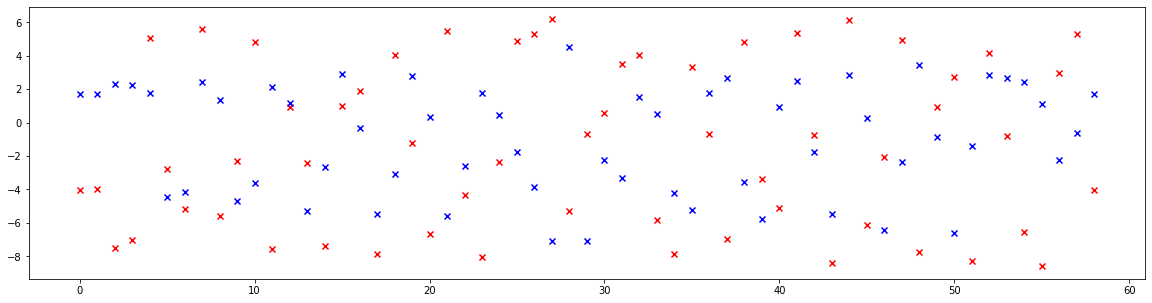

In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[model.monitor_index, ..., 0]
y = trajectory[model.monitor_index, ..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[index], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(BX - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(BY - model.by)/model.by, color='blue', marker='x')
plt.show()

NUX= 0.540601317
nux= 0.540601317, sigma_nux=1.37913808e-16, error_nux=1.11022302e-16

NUY= 0.576147547
nuy= 0.576147547, sigma_nuy=1.1662354e-16, error_nuy=3.33066907e-16



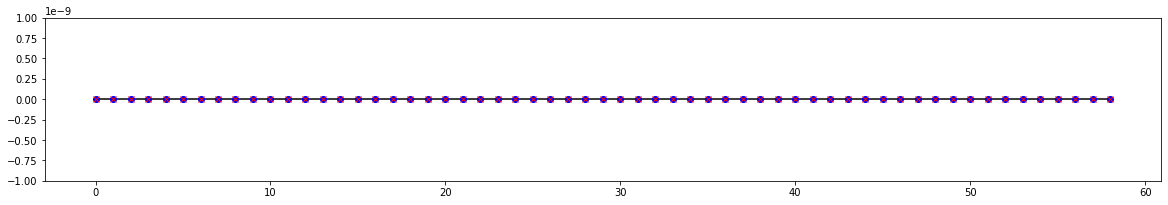

In [6]:
# Compute reference parameters from clean data at all locations

# Set window

win = Window.from_cosine(length, 2.0, dtype=dtype, device=device)

# Estimate frequency, amplitude and phase for x plane

tbt = Data.from_data(win, trajectory[..., 0])

f = Frequency(tbt)
tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')
print()

d = Decomposition(tbt)
ax_ref, sigma_ax, *_ = d.harmonic_amplitude(nux, length=2048, order=2.0, error=True, sigma_frequency=sigma_nux, shift=True, count=512, step=16, method='none')
fx_ref, sigma_fx, *_ = d.harmonic_phase(nux, length=2048, order=2.0, error=True, sigma_frequency=sigma_nux, shift=True, count=512, step=16, method='none')

# Estimate frequency, amplitude and phase for y plane

tbt = Data.from_data(win, trajectory[..., 2])

f = Frequency(tbt)
tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')
print()

d = Decomposition(tbt)
ay_ref, sigma_ay, *_ = d.harmonic_amplitude(nuy, length=2048, order=2.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=512, step=16, method='none')
fy_ref, sigma_fy, *_ = d.harmonic_phase(nuy, length=2048, order=2.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=512, step=16, method='none')

# Phase advance between locations

plt.figure(figsize=(20, 3))

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX)
advance, _ = Decomposition.phase_adjacent(nux, fx_ref)

plt.errorbar(range(model.size), mod(ADVANCE - advance, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), fmt=' ', marker='o', color='blue')

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY)
advance, _ = Decomposition.phase_adjacent(nuy, fy_ref)

plt.errorbar(range(model.size), mod(ADVANCE - advance, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), fmt=' ', marker='x', color='red')

plt.ylim(-1.0E-9, +1.0E-9)
plt.hlines(0, 0, model.size - 1, colors='black')

plt.show()

In [7]:
# Generate TbT data with noise

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set window

win = Window.from_cosine(1024, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x[:, :1024])
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y[:, :1024])
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(29, Window(1024, 'cosine_window', 1.0))
Data(29, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Note, with coupling using window for phase estimation might impove the accuracy
# Here, window of order 0.5 is used for phase estimation

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')
print()

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.5, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

print((ax - ax_ref[model.monitor_index]).abs().sum().item())
print((fx - fx_ref[model.monitor_index]).abs().sum().item())

NUX= 0.540601317
nux= 0.540601344, sigma_nux=1.61676164e-07, error_nux=2.79600784e-08

8.5758711728869e-06
0.00490425167505136


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')
print()

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.5, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

print((ay - ay_ref[model.monitor_index]).abs().sum().item())
print((fy - fy_ref[model.monitor_index]).abs().sum().item())

NUY= 0.576147547
nuy= 0.576147552, sigma_nuy=1.4808171e-07, error_nuy=5.3295931e-09

1.1514818878350123e-05
0.005218422795937025


0.005467194477576487
0.008328747464151298

0.01657329389547907
0.08448934869587793

0.01656113360287259
0.08448873444574762

0.01297997806460438
0.00685561827770903



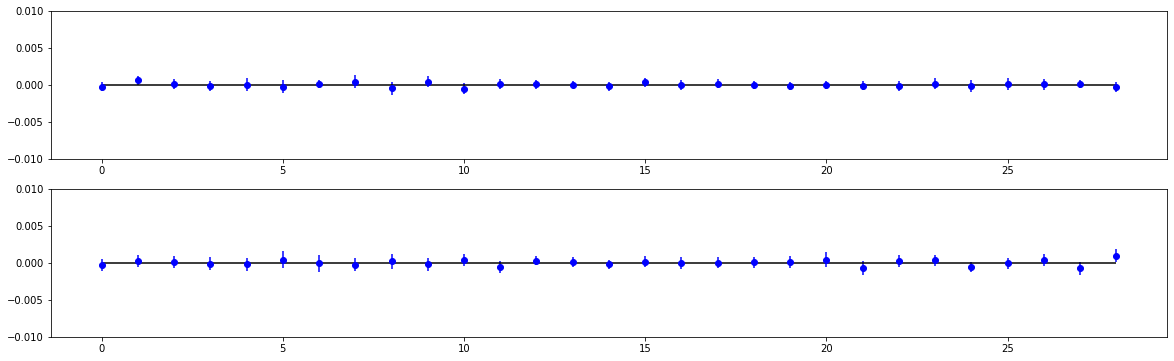

In [10]:
# Set table

table = Table(
    model.monitor_name,
    nux, nuy, ax, ay, fx, fy,
    sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    accumulate=True,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(NUX, mux)
muy, _ = Decomposition.phase_adjacent(NUY, muy)

print((mux - table.phase_x).abs().sum().item())
print((muy - table.phase_y).abs().sum().item())
print()

# Phase advance from SVD (scales with signal length & number of signals)

mux_svd = Decomposition.svd_advance(nux, X.data)
muy_svd = Decomposition.svd_advance(nuy, Y.data)

print((mux - mux_svd).abs().sum().item())
print((muy - muy_svd).abs().sum().item())
print()

# Phase advance from ICA (scales with signal length & number of signals)

mux_ica = Decomposition.ica_advance(nux, X.data, mux)
muy_ica = Decomposition.ica_advance(nuy, Y.data, muy)

print((mux - mux_ica).abs().sum().item())
print((muy - muy_ica).abs().sum().item())
print()

# Phase advance from DHT (scales with signal length)
# Note, best performance on signals with only one component

mux_dht, _ = Decomposition.dht_phase(nux, X.data)
muy_dht, _ = Decomposition.dht_phase(nuy, Y.data)

mux_dht, _ = Decomposition.phase_adjacent(nux, mux_dht)
muy_dht, _ = Decomposition.phase_adjacent(nuy, muy_dht)

print((mux - mux_dht).abs().sum().item())
print((muy - muy_dht).abs().sum().item())
print()

plt.figure(figsize=(20, 3*2))

ax1 = plt.subplot(211)
ax1.errorbar(range(model.monitor_count), (mux - table.phase_x).cpu().numpy(), yerr=table.sigma_x.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax1.hlines(0, 0, model.monitor_count - 1, colors='black')
ax1.set_ylim(-1.0E-2, +1.0E-2)

ax2 = plt.subplot(212)
ax2.errorbar(range(model.monitor_count), (muy - table.phase_y).cpu().numpy(), yerr=table.sigma_y.cpu().numpy(), fmt=' ', marker='o', color='blue')
ax2.hlines(0, 0, model.monitor_count - 1, colors='black')
ax2.set_ylim(-1.0E-2, +1.0E-2)

plt.show()

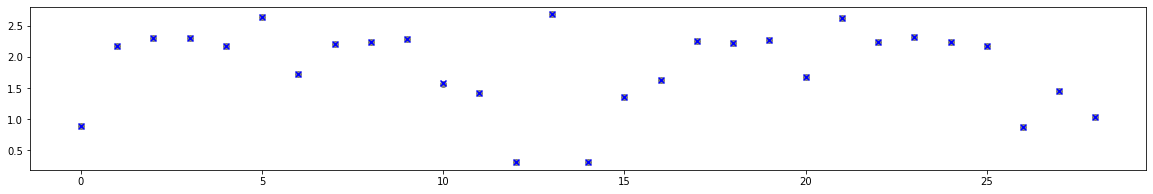

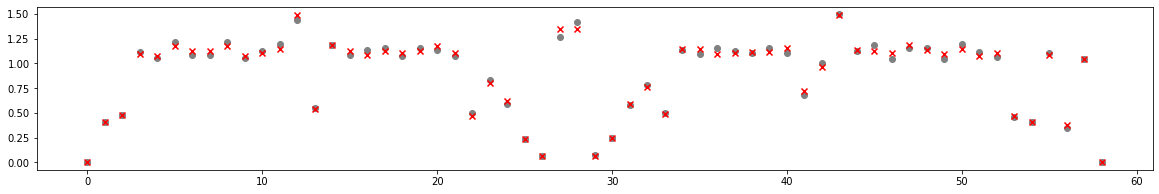

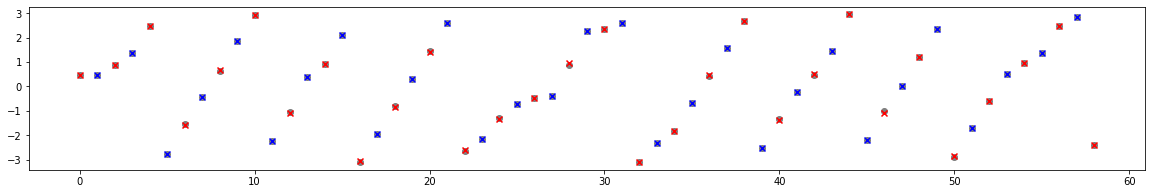

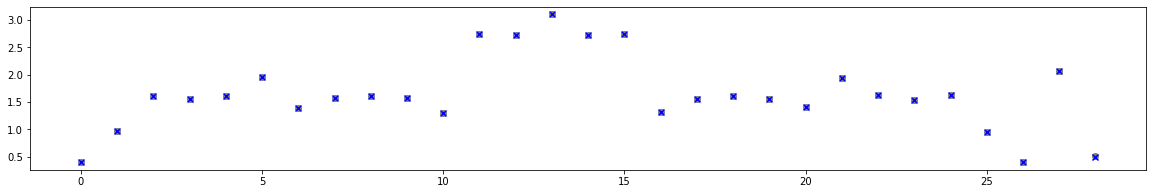

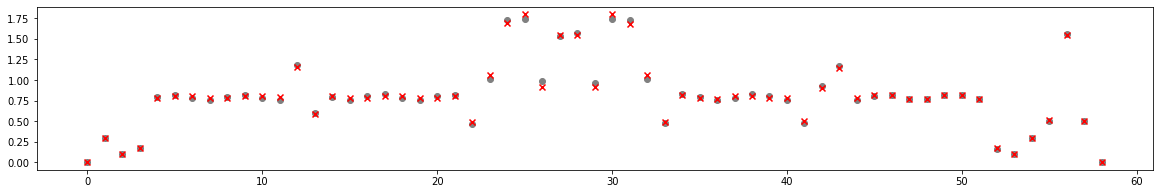

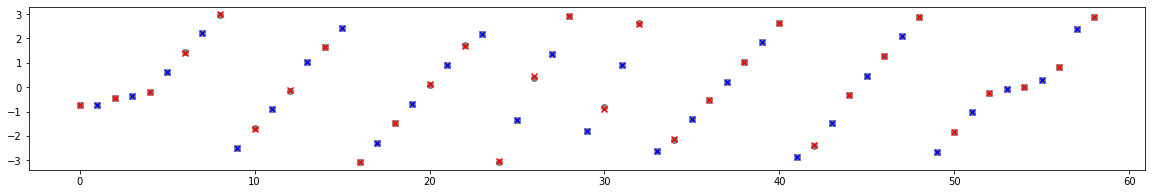

In [11]:
# Compute virtual phase (interpolation)

twiss = Twiss(model, table)
twiss.phase_virtual(method='interpolate')

# Compare with reference

# Phase advance between monitor locations

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX[model.monitor_index])
advance, _ = Decomposition.phase_adjacent(nux, twiss.fx[model.monitor_index])

for index in range(1, model.monitor_count):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.monitor_count), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.monitor_count), mod(advance, 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.show()

# Phase advance between adjacent locations

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX)
advance, _ = Decomposition.phase_adjacent(nux, twiss.fx)

for index in range(1, model.size):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.size), mod(advance, 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

# Phase

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(fx_ref, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(model.monitor_index, mod(twiss.fx[model.monitor_index], 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.scatter(model.virtual_index, mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

# Phase advance between monitor locations

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY[model.monitor_index])
advance, _ = Decomposition.phase_adjacent(nuy, twiss.fy[model.monitor_index])

for index in range(1, model.monitor_count):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.monitor_count), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.monitor_count), mod(advance, 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.show()

# Phase advance between adjacent locations

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY)
advance, _ = Decomposition.phase_adjacent(nuy, twiss.fy)

for index in range(1, model.size):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.size), mod(advance, 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

# Phase

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(fy_ref, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(model.monitor_index, mod(twiss.fy[model.monitor_index], 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.scatter(model.virtual_index, mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

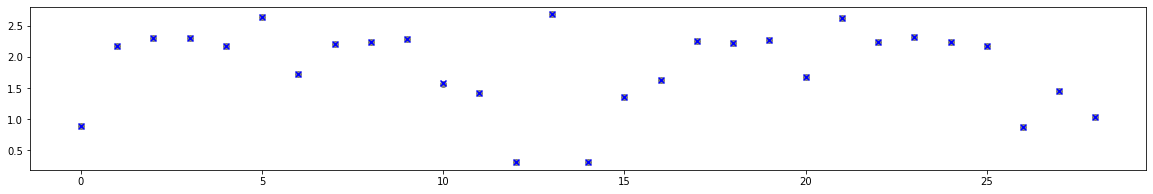

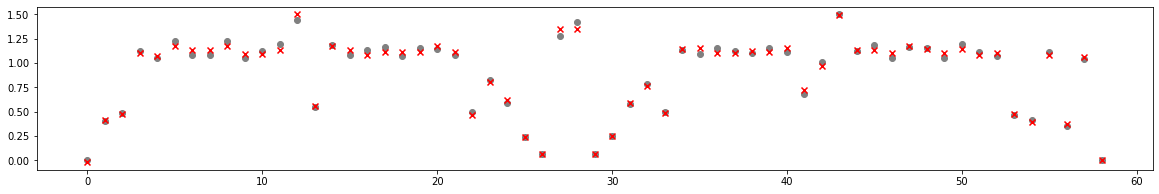

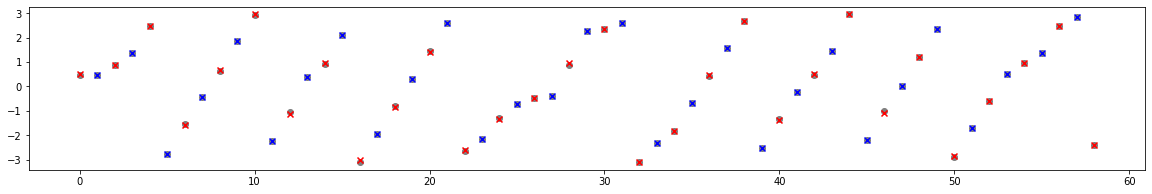

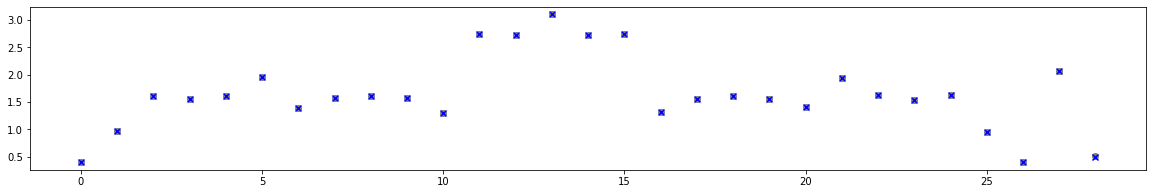

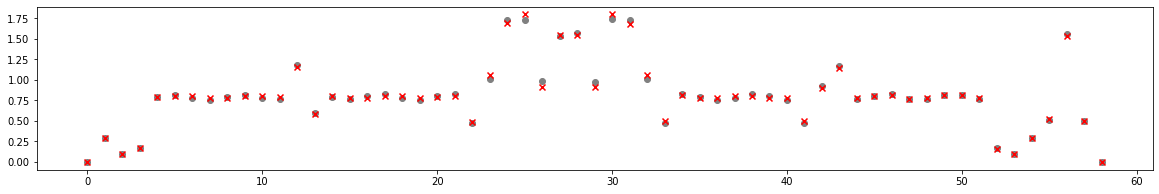

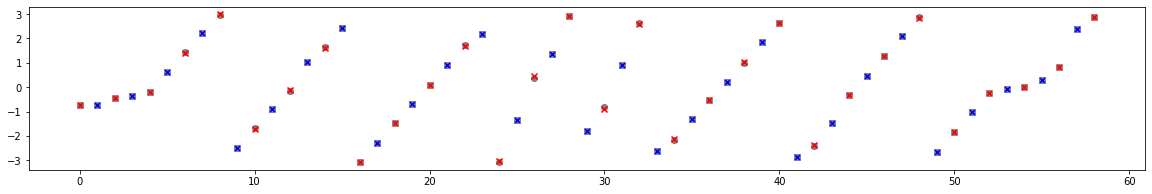

In [12]:
# Compute virtual phase (model)

twiss = Twiss(model, table)
twiss.phase_virtual(method='model', limit=1)

# Phase advance between monitor locations

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX[model.monitor_index])
advance, _ = Decomposition.phase_adjacent(nux, twiss.fx[model.monitor_index])

for index in range(1, model.monitor_count):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.monitor_count), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.monitor_count), mod(advance, 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.show()

# Phase advance between adjacent locations

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX)
advance, _ = Decomposition.phase_adjacent(nux, twiss.fx)

for index in range(1, model.size):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.size), mod(advance, 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

# Phase

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(fx_ref, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(model.monitor_index, mod(twiss.fx[model.monitor_index], 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.scatter(model.virtual_index, mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

# Phase advance between monitor locations

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY[model.monitor_index])
advance, _ = Decomposition.phase_adjacent(nuy, twiss.fy[model.monitor_index])

for index in range(1, model.monitor_count):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.monitor_count), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.monitor_count), mod(advance, 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.show()

# Phase advance between adjacent locations

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY)
advance, _ = Decomposition.phase_adjacent(nuy, twiss.fy)

for index in range(1, model.size):
    while ADVANCE[index] < ADVANCE[index - 1]: ADVANCE[index:] += 2.0*numpy.pi
    while advance[index] < advance[index - 1]: advance[index:] += 2.0*numpy.pi

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(ADVANCE, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(range(model.size), mod(advance, 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

# Phase

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), mod(fy_ref, 2.0*numpy.pi, -numpy.pi), color='gray', marker='o')
plt.scatter(model.monitor_index, mod(twiss.fy[model.monitor_index], 2.0*numpy.pi, -numpy.pi), color='blue', marker='x')
plt.scatter(model.virtual_index, mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi), color='red', marker='x')
plt.show()

In [13]:
# Note, virtual phases (and amplitudes) can be also computed from virtual trajectories
# See Momenta estimation & virtual trajectories example

# Estimate twiss from phase (virtual phase is used at virtual locations)

twiss = Twiss(model, table, limit=4)
twiss.phase_virtual(method='model',  limit=1)
twiss.get_twiss_from_phase()

# Filter and process

mask_x = twiss.filter_twiss(plane='x', 
                            phase={'use': True, 'threshold': 10.0}, 
                            model={'use': False, 'threshold': 0.50}, 
                            value={'use': False, 'threshold': 0.50}, 
                            sigma={'use': False, 'threshold': 0.50}, 
                            limit={'use': True, 'threshold': 5.0},
                            error={'use': True, 'threshold': 5.0})

twiss.process_twiss(plane='x', mask=mask_x, weight=True) ;

mask_y = twiss.filter_twiss(plane='y', 
                            phase={'use': True, 'threshold': 10.0}, 
                            model={'use': False, 'threshold': 0.50}, 
                            value={'use': False, 'threshold': 0.50}, 
                            sigma={'use': False, 'threshold': 0.50}, 
                            limit={'use': True, 'threshold': 5.0},
                            error={'use': True, 'threshold': 5.0})

twiss.process_twiss(plane='y', mask=mask_y, weight=True) ;

# Note, can use amplitude data to estimate twiss (with corrected actions from phase twiss)
# Once computed, set twiss.bx & twiss.by

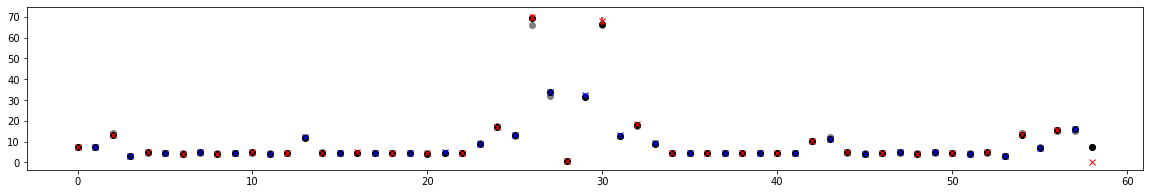

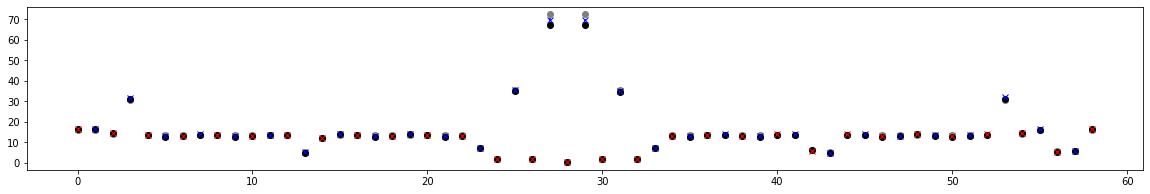

tensor(3.839822229128e+00, dtype=torch.float64)
tensor(4.674854889608e+00, dtype=torch.float64)

tensor(1.060531598481e+01, dtype=torch.float64)
tensor(4.180372098334e+00, dtype=torch.float64)



In [14]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.bx, color='gray', marker='o')
plt.scatter(range(model.size), BX, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.bx[model.monitor_index], yerr=twiss.sigma_bx[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, twiss.bx[model.virtual_index], yerr=twiss.sigma_bx[model.virtual_index], fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.by, color='gray', marker='o')
plt.scatter(range(model.size), BY, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.by[model.monitor_index], yerr=twiss.sigma_by[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, twiss.by[model.virtual_index], yerr=twiss.sigma_by[model.virtual_index], fmt=' ', color='red', marker='x')
plt.show()

print((BX[model.monitor_index] - twiss.bx[model.monitor_index]).sum().abs())
print((BX[model.virtual_index] - twiss.bx[model.virtual_index]).sum().abs())
print()

print((BY[model.monitor_index] - twiss.by[model.monitor_index]).sum().abs())
print((BY[model.virtual_index] - twiss.by[model.virtual_index]).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

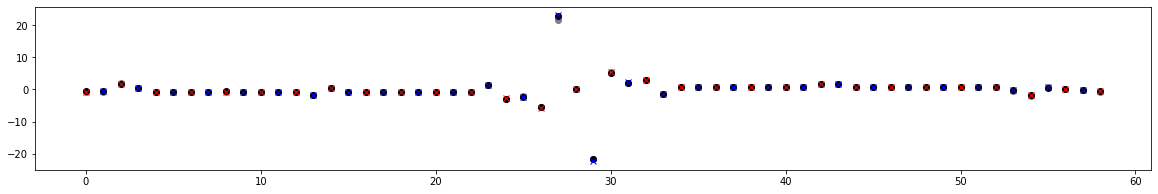

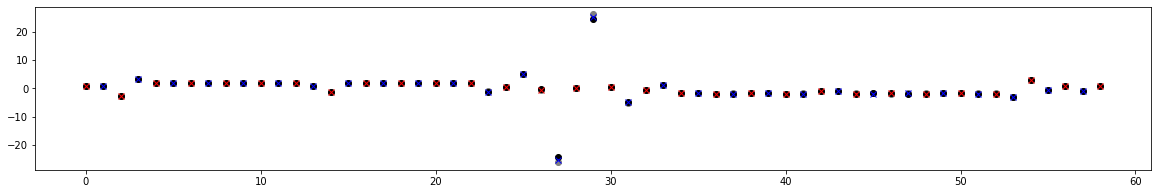

tensor(4.543507958319e-01, dtype=torch.float64)
tensor(1.329804575623e-01, dtype=torch.float64)

tensor(1.513221333625e-02, dtype=torch.float64)
tensor(1.188806098104e-01, dtype=torch.float64)



In [15]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ax, color='gray', marker='o')
plt.scatter(range(model.size), AX, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.ax[model.monitor_index], yerr=twiss.sigma_ax[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, twiss.ax[model.virtual_index], yerr=twiss.sigma_ax[model.virtual_index], fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ay, color='gray', marker='o')
plt.scatter(range(model.size), AY, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.ay[model.monitor_index], yerr=twiss.sigma_ay[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, twiss.ay[model.virtual_index], yerr=twiss.sigma_ay[model.virtual_index], fmt=' ', color='red', marker='x')
plt.show()

print((AX[model.monitor_index] - twiss.ax[model.monitor_index]).sum().abs())
print((AX[model.virtual_index] - twiss.ax[model.virtual_index]).sum().abs())
print()

print((AY[model.monitor_index] - twiss.ay[model.monitor_index]).sum().abs())
print((AY[model.virtual_index] - twiss.ay[model.virtual_index]).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [16]:
# Twiss at virtual locations from twiss transport (without virtual phase)

value_cs = []
error_cs = []

for virtual in model.virtual_index:
    value, error = twiss.get_twiss_virtual_uncoupled(virtual, limit=1, use_phase=False, bootstrap=True, count=128)
    value_cs.append(value)
    error_cs.append(error)

value_ax, value_bx, value_ay, value_by = torch.stack(value_cs).T
error_ax, error_bx, error_ay, error_by = torch.stack(error_cs).T

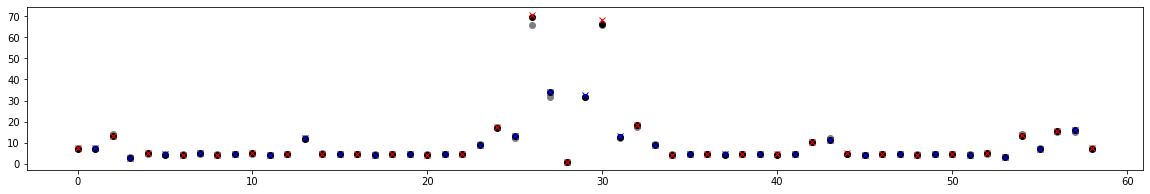

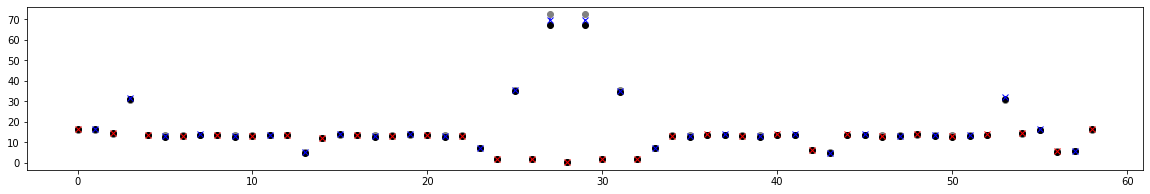

tensor(3.839822229128e+00, dtype=torch.float64)
tensor(6.117318577795e+00, dtype=torch.float64)

tensor(1.060531598481e+01, dtype=torch.float64)
tensor(4.932392485638e+00, dtype=torch.float64)



In [17]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.bx, color='gray', marker='o')
plt.scatter(range(model.size), BX, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.bx[model.monitor_index], yerr=twiss.sigma_bx[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_bx, yerr=error_bx, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.by, color='gray', marker='o')
plt.scatter(range(model.size), BY, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.by[model.monitor_index], yerr=twiss.sigma_by[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_by, yerr=error_by, fmt=' ', color='red', marker='x')
plt.show()

print((BX[model.monitor_index] - twiss.bx[model.monitor_index]).sum().abs())
print((BX[model.virtual_index] - value_bx).sum().abs())
print()

print((BY[model.monitor_index] - twiss.by[model.monitor_index]).sum().abs())
print((BY[model.virtual_index] - value_by).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

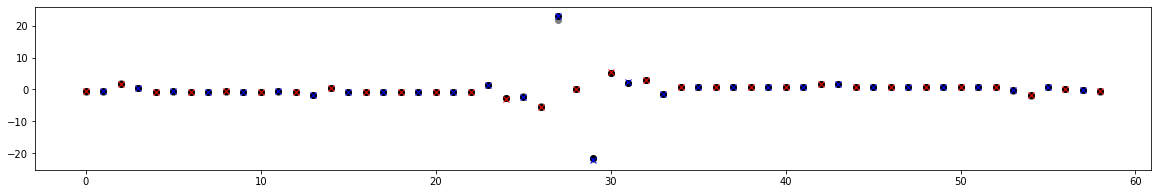

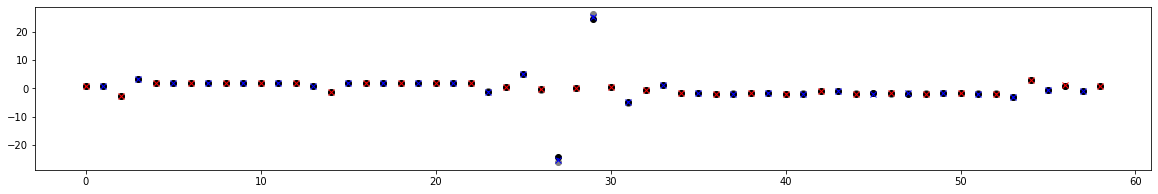

tensor(4.543507958319e-01, dtype=torch.float64)
tensor(1.089247757844e-01, dtype=torch.float64)

tensor(1.513221333625e-02, dtype=torch.float64)
tensor(5.291077865670e-02, dtype=torch.float64)



In [18]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ax, color='gray', marker='o')
plt.scatter(range(model.size), AX, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.ax[model.monitor_index], yerr=twiss.sigma_bx[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ax, yerr=error_ax, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ay, color='gray', marker='o')
plt.scatter(range(model.size), AY, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.ay[model.monitor_index], yerr=twiss.sigma_by[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ay, yerr=error_by, fmt=' ', color='red', marker='x')
plt.show()

print((AX[model.monitor_index] - twiss.ax[model.monitor_index]).sum().abs())
print((AX[model.virtual_index] - value_ax).sum().abs())
print()

print((AY[model.monitor_index] - twiss.ay[model.monitor_index]).sum().abs())
print((AY[model.virtual_index] - value_ay).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [19]:
# Twiss at virtual locations from twiss transport (with virtual phase)

value_cs = []
error_cs = []

for virtual in model.virtual_index:
    value, error = twiss.get_twiss_virtual_uncoupled(virtual, limit=1, use_phase=True, bootstrap=True, count=128)
    value_cs.append(value)
    error_cs.append(error)

value_ax, value_bx, value_ay, value_by = torch.stack(value_cs).T
error_ax, error_bx, error_ay, error_by = torch.stack(error_cs).T

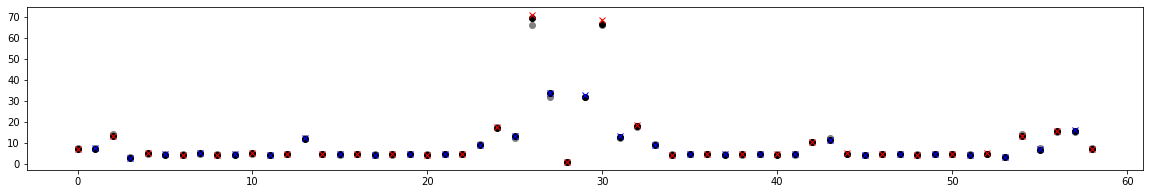

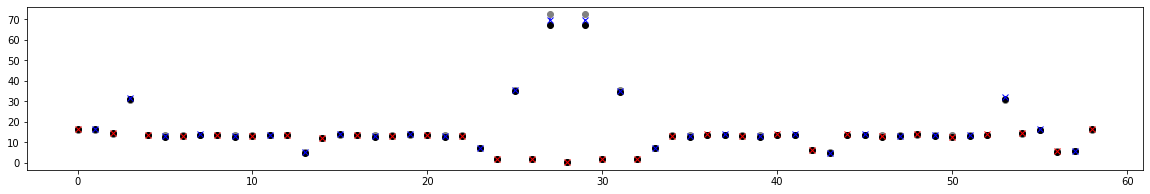

tensor(3.839822229128e+00, dtype=torch.float64)
tensor(5.611006785869e+00, dtype=torch.float64)

tensor(1.060531598481e+01, dtype=torch.float64)
tensor(4.736155563949e+00, dtype=torch.float64)



In [20]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.bx, color='gray', marker='o')
plt.scatter(range(model.size), BX, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.bx[model.monitor_index], yerr=twiss.sigma_bx[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_bx, yerr=error_bx, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.by, color='gray', marker='o')
plt.scatter(range(model.size), BY, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.by[model.monitor_index], yerr=twiss.sigma_by[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_by, yerr=error_by, fmt=' ', color='red', marker='x')
plt.show()

print((BX[model.monitor_index] - twiss.bx[model.monitor_index]).sum().abs())
print((BX[model.virtual_index] - value_bx).sum().abs())
print()

print((BY[model.monitor_index] - twiss.by[model.monitor_index]).sum().abs())
print((BY[model.virtual_index] - value_by).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

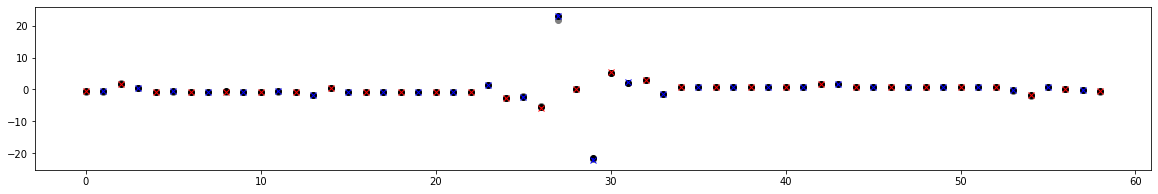

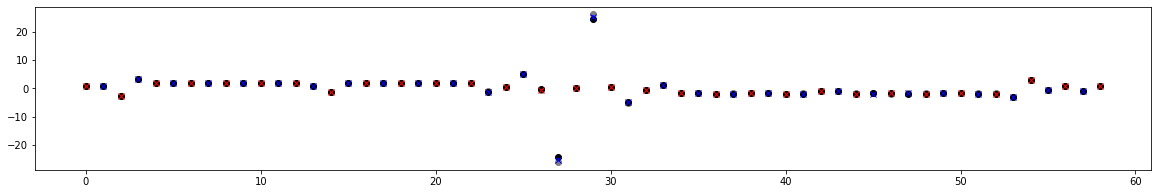

tensor(4.543507958319e-01, dtype=torch.float64)
tensor(3.602571816786e-02, dtype=torch.float64)

tensor(1.513221333625e-02, dtype=torch.float64)
tensor(8.751144480709e-02, dtype=torch.float64)



In [21]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ax, color='gray', marker='o')
plt.scatter(range(model.size), AX, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.ax[model.monitor_index], yerr=twiss.sigma_bx[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ax, yerr=error_ax, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ay, color='gray', marker='o')
plt.scatter(range(model.size), AY, color='black', marker='o')
plt.errorbar(model.monitor_index, twiss.ay[model.monitor_index], yerr=twiss.sigma_by[model.monitor_index], fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ay, yerr=error_by, fmt=' ', color='red', marker='x')
plt.show()

print((AX[model.monitor_index] - twiss.ax[model.monitor_index]).sum().abs())
print((AX[model.virtual_index] - value_ax).sum().abs())
print()

print((AY[model.monitor_index] - twiss.ay[model.monitor_index]).sum().abs())
print((AY[model.virtual_index] - value_ay).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [22]:
%%time

# Estimate twiss from invariant fit

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 product=True,
                                 jacobian=False,
                                 count=128,
                                 fraction=0.75,
                                 ix=None,
                                 iy=None,
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)

torch.Size([29, 2, 10, 128])
CPU times: user 1min 23s, sys: 1.08 s, total: 1min 24s
Wall time: 1min 30s


In [23]:
# Process fitted invariants

ix, iy = data[:, 0, 0], data[:, 0, 1]
sigma_ix, sigma_iy = data[:, 1, 0], data[:, 1, 1]
invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

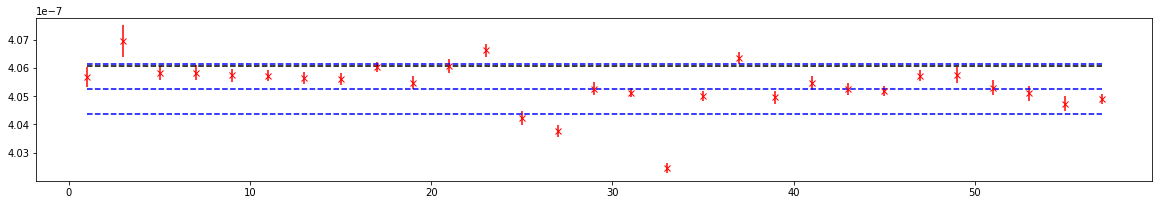

tensor(4.060785864258e-07, dtype=torch.float64)
tensor(4.052614062648e-07, dtype=torch.float64)
tensor(8.838353717945e-10, dtype=torch.float64)



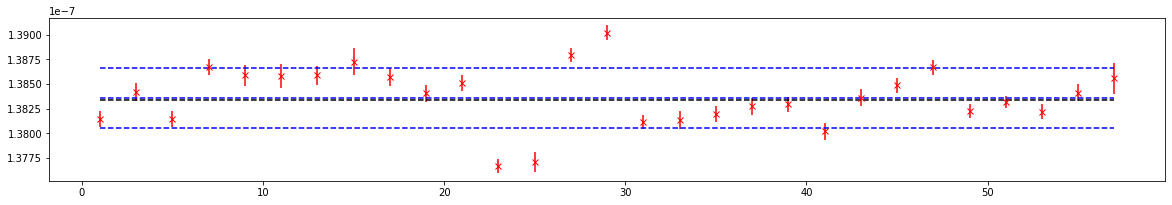

tensor(1.383347844251e-07, dtype=torch.float64)
tensor(1.383575139510e-07, dtype=torch.float64)
tensor(3.066487103282e-10, dtype=torch.float64)



In [24]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(model.monitor_index, invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(model.monitor_index, invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

In [25]:
# Process twiss

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value, error = data.permute(1, 2, 0, -1)

*_, value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41 = value
*_, error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41 = error

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

In [26]:
%%time

# Twiss at virtual locations (from virtual orbits)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 phony=True,
                                 product=True,
                                 jacobian=False,
                                 count=128,
                                 fraction=0.75,
                                 ix=invariant['ix_value'],
                                 iy=invariant['iy_value'],
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)
print(model.virtual_count)

torch.Size([30, 2, 8, 128])
30
CPU times: user 1min 21s, sys: 1.05 s, total: 1min 22s
Wall time: 1min 25s


In [27]:
# Process twiss

value, error = data.permute(1, 2, 0, -1)

*_, value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41 = value
*_, error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41 = error

value_v11, error_v11 = twiss.process(value_v11, error_v11)
value_v33, error_v33 = twiss.process(value_v33, error_v33)
value_v21, error_v21 = twiss.process(value_v21, error_v21)
value_v43, error_v43 = twiss.process(value_v43, error_v43)
value_v13, error_v13 = twiss.process(value_v13, error_v13)
value_v31, error_v31 = twiss.process(value_v31, error_v31)
value_v14, error_v14 = twiss.process(value_v14, error_v14)
value_v41, error_v41 = twiss.process(value_v41, error_v41)

In [28]:
# Compute twiss at all locations from normalization

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_local, error_local in zip(value, error):
    table = value_local.reshape(-1, 1) + error_local.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax_m, value_bx_m, value_ay_m, value_by_m = cs_value.T
error_ax_m, error_bx_m, error_ay_m, error_by_m = cs_error.T

value = torch.stack([value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41]).T
error = torch.stack([error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41]).T

cs_value, cs_error = [], []

for value_local, error_local in zip(value, error):
    table = value_local.reshape(-1, 1) + error_local.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax_v, value_bx_v, value_ay_v, value_by_v = cs_value.T
error_ax_v, error_bx_v, error_ay_v, error_by_v = cs_error.T

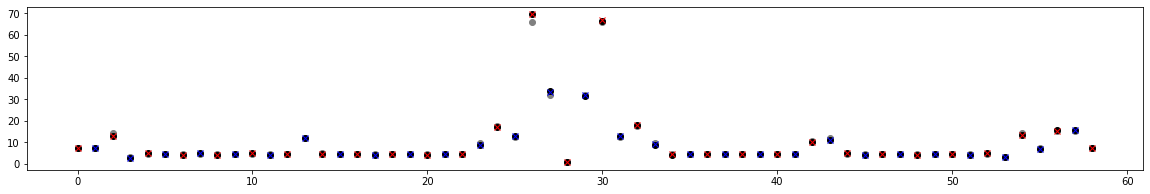

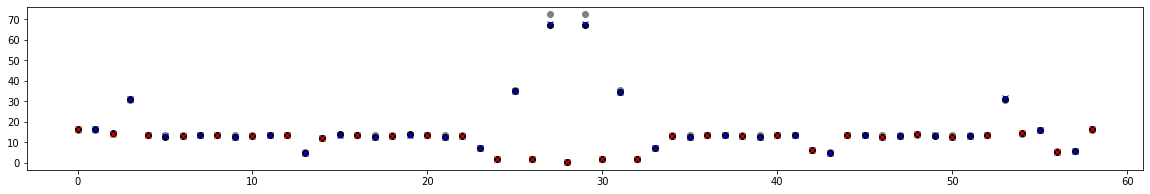

tensor(3.651367006845e-01, dtype=torch.float64)
tensor(2.976509864539e-01, dtype=torch.float64)

tensor(2.678311928898e-01, dtype=torch.float64)
tensor(3.649806529401e-02, dtype=torch.float64)



In [29]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.bx, color='gray', marker='o')
plt.scatter(range(model.size), BX, color='black', marker='o')
plt.errorbar(model.monitor_index, value_bx_m, yerr=error_bx_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_bx_v, yerr=error_bx_v, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.by, color='gray', marker='o')
plt.scatter(range(model.size), BY, color='black', marker='o')
plt.errorbar(model.monitor_index, value_by_m, yerr=error_by_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_by_v, yerr=error_by_v, fmt=' ', color='red', marker='x')
plt.show()

print((BX[model.monitor_index] - value_bx_m).sum().abs())
print((BX[model.virtual_index] - value_bx_v).sum().abs())
print()

print((BY[model.monitor_index] - value_by_m).sum().abs())
print((BY[model.virtual_index] - value_by_v).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

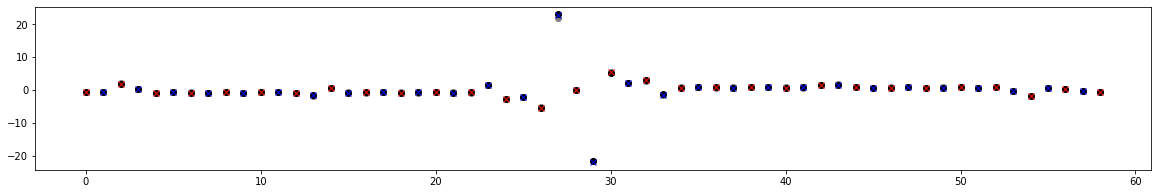

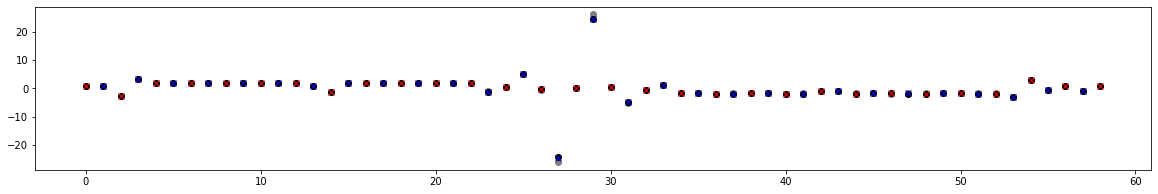

tensor(4.659589241587e-01, dtype=torch.float64)
tensor(3.478857890782e-02, dtype=torch.float64)

tensor(4.373097539420e-02, dtype=torch.float64)
tensor(6.005819299275e-02, dtype=torch.float64)



In [30]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ax, color='gray', marker='o')
plt.scatter(range(model.size), AX, color='black', marker='o')
plt.errorbar(model.monitor_index, value_ax_m, yerr=error_ax_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ax_v, yerr=error_ax_v, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ay, color='gray', marker='o')
plt.scatter(range(model.size), AY, color='black', marker='o')
plt.errorbar(model.monitor_index, value_ay_m, yerr=error_ay_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ay_v, yerr=error_ay_v, fmt=' ', color='red', marker='x')
plt.show()

print((AX[model.monitor_index] - value_ax_m).sum().abs())
print((AX[model.virtual_index] - value_ax_v).sum().abs())
print()

print((AY[model.monitor_index] - value_ay_m).sum().abs())
print((AY[model.virtual_index] - value_ay_v).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

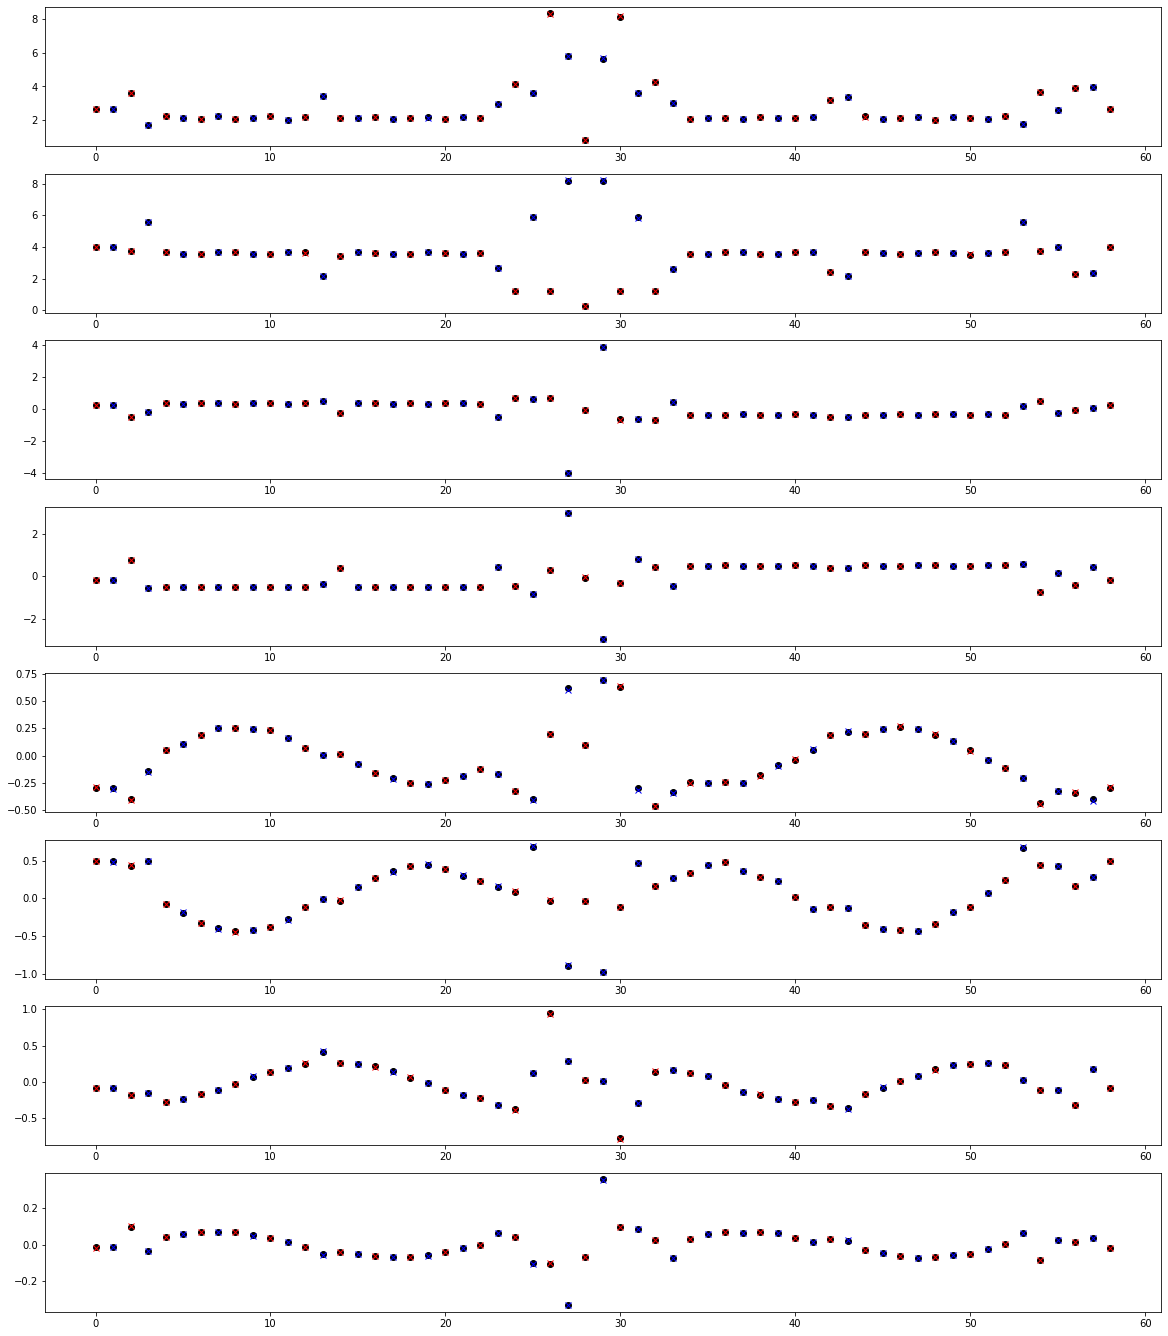

In [31]:
# Compare normalization matrix elements

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.size), N11, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n11, yerr=error_n11, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v11, yerr=error_v11, fmt=' ', color='red', marker='x')

ax = plt.subplot(812)
ax.scatter(range(model.size), N33, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n33, yerr=error_n33, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v33, yerr=error_v33, fmt=' ', color='red', marker='x')

ax = plt.subplot(813)
ax.scatter(range(model.size), N21, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n21, yerr=error_n21, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v21, yerr=error_v21, fmt=' ', color='red', marker='x')

ax = plt.subplot(814)
ax.scatter(range(model.size), N43, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n43, yerr=error_n43, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v43, yerr=error_v43, fmt=' ', color='red', marker='x')

ax = plt.subplot(815)
ax.scatter(range(model.size), N13, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n13, yerr=error_n13, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v13, yerr=error_v13, fmt=' ', color='red', marker='x')

ax = plt.subplot(816)
ax.scatter(range(model.size), N31, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n31, yerr=error_n31, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v31, yerr=error_v31, fmt=' ', color='red', marker='x')

ax = plt.subplot(817)
ax.scatter(range(model.size), N14, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n14, yerr=error_n14, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v14, yerr=error_v14, fmt=' ', color='red', marker='x')

ax = plt.subplot(818)
ax.scatter(range(model.size), N41, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n41, yerr=error_n41, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v41, yerr=error_v41, fmt=' ', color='red', marker='x')

plt.show()

# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [32]:
# Compare normalization matrix elements

print((N11[model.monitor_index] - value_n11).sum().abs())
print((N11[model.virtual_index] - value_v11).sum().abs())
print()

print((N33[model.monitor_index] - value_n33).sum().abs())
print((N33[model.virtual_index] - value_v33).sum().abs())
print()

print((N21[model.monitor_index] - value_n21).sum().abs())
print((N21[model.virtual_index] - value_v21).sum().abs())
print()

print((N43[model.monitor_index] - value_n43).sum().abs())
print((N43[model.virtual_index] - value_v43).sum().abs())
print()

print((N13[model.monitor_index] - value_n13).sum().abs())
print((N13[model.virtual_index] - value_v13).sum().abs())
print()

print((N31[model.monitor_index] - value_n31).sum().abs())
print((N31[model.virtual_index] - value_v31).sum().abs())
print()

print((N14[model.monitor_index] - value_n14).sum().abs())
print((N14[model.virtual_index] - value_v14).sum().abs())
print()

print((N41[model.monitor_index] - value_n41).sum().abs())
print((N41[model.virtual_index] - value_v41).sum().abs())
print()

tensor(4.815059539731e-02, dtype=torch.float64)
tensor(7.037590633657e-03, dtype=torch.float64)

tensor(1.467353013737e-02, dtype=torch.float64)
tensor(7.801059960627e-04, dtype=torch.float64)

tensor(3.642123523128e-02, dtype=torch.float64)
tensor(1.337755242976e-03, dtype=torch.float64)

tensor(5.365397492074e-03, dtype=torch.float64)
tensor(4.671403179883e-02, dtype=torch.float64)

tensor(5.072081835556e-02, dtype=torch.float64)
tensor(1.764448813781e-03, dtype=torch.float64)

tensor(4.533960115097e-02, dtype=torch.float64)
tensor(3.258003701420e-02, dtype=torch.float64)

tensor(4.448995046432e-03, dtype=torch.float64)
tensor(1.736663393807e-02, dtype=torch.float64)

tensor(2.852322851986e-03, dtype=torch.float64)
tensor(2.493074587077e-03, dtype=torch.float64)



In [33]:
# Set normal at monitor locations

model.model = 'coupled'

from harmonica.parameterization import parametric_normal
for index, (n11, n33, n21, n43, n13, n31, n14, n41) in enumerate(zip(value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41)):
    index = model.monitor_index[index]
    normal = parametric_normal(n11, n33, n21, n43, n13, n31, n14, n41, dtype=dtype)
    twiss.normal[index] = normal

# Set normal at virtual locations

model.model = 'coupled'

from harmonica.parameterization import parametric_normal
for index, (n11, n33, n21, n43, n13, n31, n14, n41) in enumerate(zip(value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41)):
    index = model.virtual_index[index]
    normal = parametric_normal(n11, n33, n21, n43, n13, n31, n14, n41, dtype=dtype)
    twiss.normal[index] = normal

In [34]:
# Twiss at virtual locations from transport (without virtual phase)

value_normal = []
error_normal = []

for virtual in model.virtual_index:
    value, error = twiss.get_twiss_virtual_coupled(virtual, limit=1, use_phase=False, bootstrap=True, count=128)
    value_normal.append(value)
    error_normal.append(error)

value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41 = torch.stack(value_normal).T
error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41 = torch.stack(error_normal).T

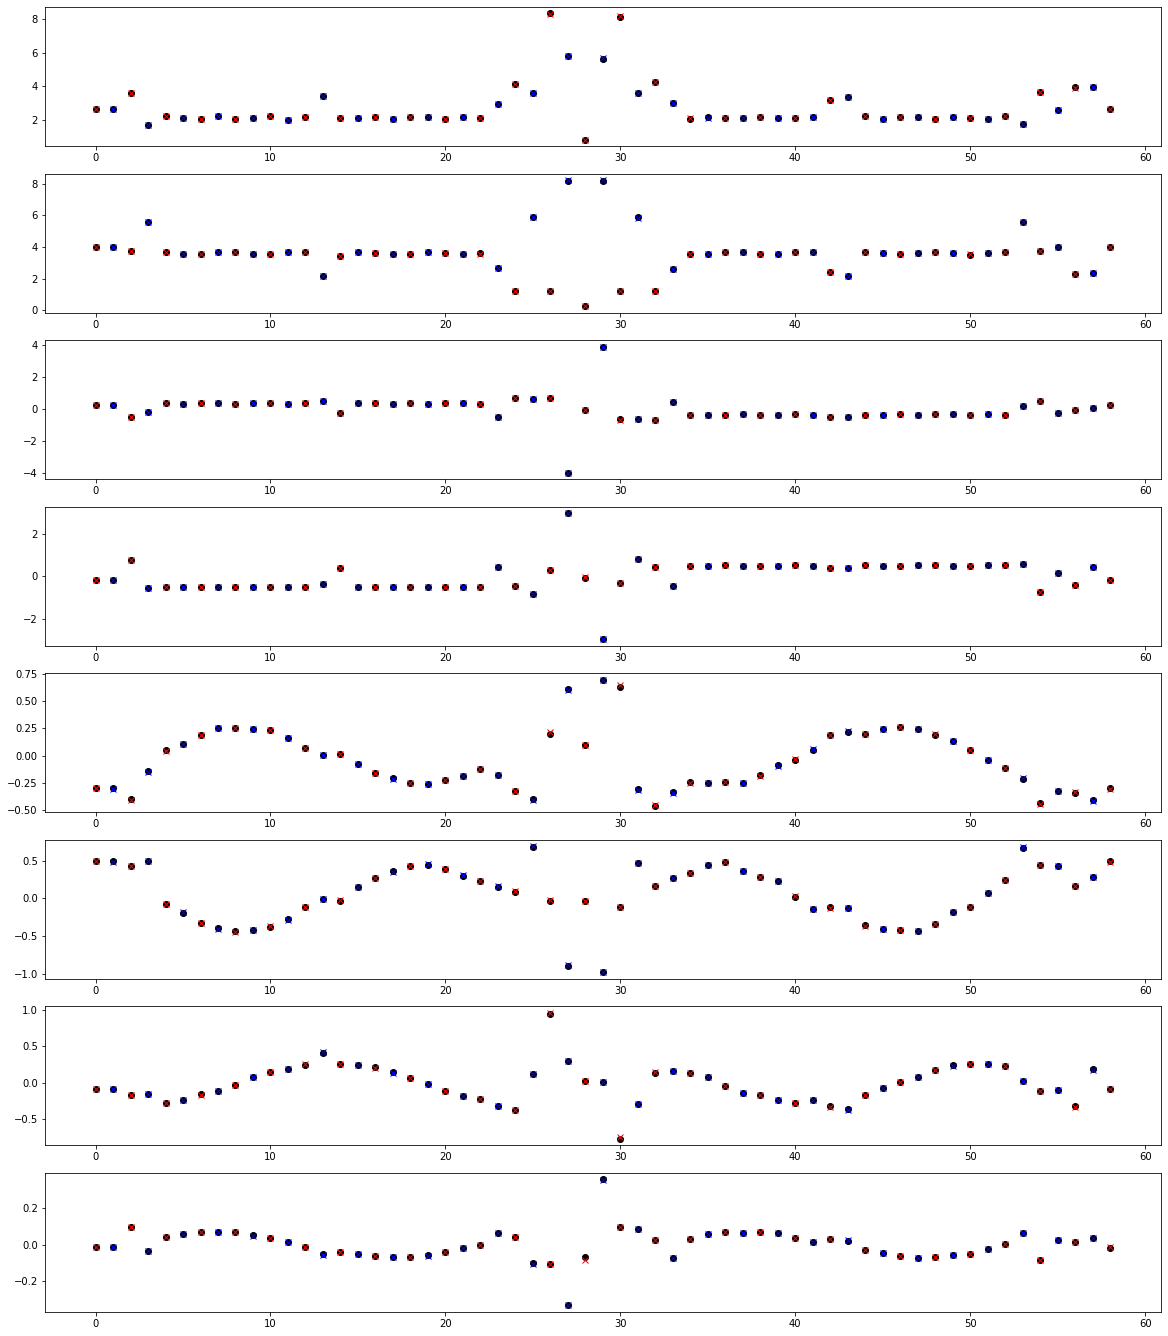

In [35]:
# Compare normalization matrix elements

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.size), N11, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n11, yerr=error_n11, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v11, yerr=error_v11, fmt=' ', color='red', marker='x')

ax = plt.subplot(812)
ax.scatter(range(model.size), N33, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n33, yerr=error_n33, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v33, yerr=error_v33, fmt=' ', color='red', marker='x')

ax = plt.subplot(813)
ax.scatter(range(model.size), N21, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n21, yerr=error_n21, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v21, yerr=error_v21, fmt=' ', color='red', marker='x')

ax = plt.subplot(814)
ax.scatter(range(model.size), N43, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n43, yerr=error_n43, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v43, yerr=error_v43, fmt=' ', color='red', marker='x')

ax = plt.subplot(815)
ax.scatter(range(model.size), N13, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n13, yerr=error_n13, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v13, yerr=error_v13, fmt=' ', color='red', marker='x')

ax = plt.subplot(816)
ax.scatter(range(model.size), N31, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n31, yerr=error_n31, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v31, yerr=error_v31, fmt=' ', color='red', marker='x')

ax = plt.subplot(817)
ax.scatter(range(model.size), N14, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n14, yerr=error_n14, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v14, yerr=error_v14, fmt=' ', color='red', marker='x')

ax = plt.subplot(818)
ax.scatter(range(model.size), N41, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n41, yerr=error_n41, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v41, yerr=error_v41, fmt=' ', color='red', marker='x')

plt.show()

# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [36]:
# Compare normalization matrix elements

print((N11[model.monitor_index] - value_n11).sum().abs())
print((N11[model.virtual_index] - value_v11).sum().abs())
print()

print((N33[model.monitor_index] - value_n33).sum().abs())
print((N33[model.virtual_index] - value_v33).sum().abs())
print()

print((N21[model.monitor_index] - value_n21).sum().abs())
print((N21[model.virtual_index] - value_v21).sum().abs())
print()

print((N43[model.monitor_index] - value_n43).sum().abs())
print((N43[model.virtual_index] - value_v43).sum().abs())
print()

print((N13[model.monitor_index] - value_n13).sum().abs())
print((N13[model.virtual_index] - value_v13).sum().abs())
print()

print((N31[model.monitor_index] - value_n31).sum().abs())
print((N31[model.virtual_index] - value_v31).sum().abs())
print()

print((N14[model.monitor_index] - value_n14).sum().abs())
print((N14[model.virtual_index] - value_v14).sum().abs())
print()

print((N41[model.monitor_index] - value_n41).sum().abs())
print((N41[model.virtual_index] - value_v41).sum().abs())
print()

tensor(4.815059539731e-02, dtype=torch.float64)
tensor(5.013253519248e-02, dtype=torch.float64)

tensor(1.467353013737e-02, dtype=torch.float64)
tensor(9.807510419295e-03, dtype=torch.float64)

tensor(3.642123523128e-02, dtype=torch.float64)
tensor(3.106522641181e-02, dtype=torch.float64)

tensor(5.365397492074e-03, dtype=torch.float64)
tensor(4.306003947760e-02, dtype=torch.float64)

tensor(5.072081835556e-02, dtype=torch.float64)
tensor(1.861232951203e-02, dtype=torch.float64)

tensor(4.533960115097e-02, dtype=torch.float64)
tensor(1.902613438381e-02, dtype=torch.float64)

tensor(4.448995046432e-03, dtype=torch.float64)
tensor(1.696856116292e-02, dtype=torch.float64)

tensor(2.852322851986e-03, dtype=torch.float64)
tensor(1.966390705982e-02, dtype=torch.float64)



In [37]:
# Twiss at virtual locations from transport (with virtual phase)

value_normal = []
error_normal = []

for virtual in model.virtual_index:
    value, error = twiss.get_twiss_virtual_coupled(virtual, limit=1, use_phase=False, bootstrap=True, count=128)
    value_normal.append(value)
    error_normal.append(error)

value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41 = torch.stack(value_normal).T
error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41 = torch.stack(error_normal).T

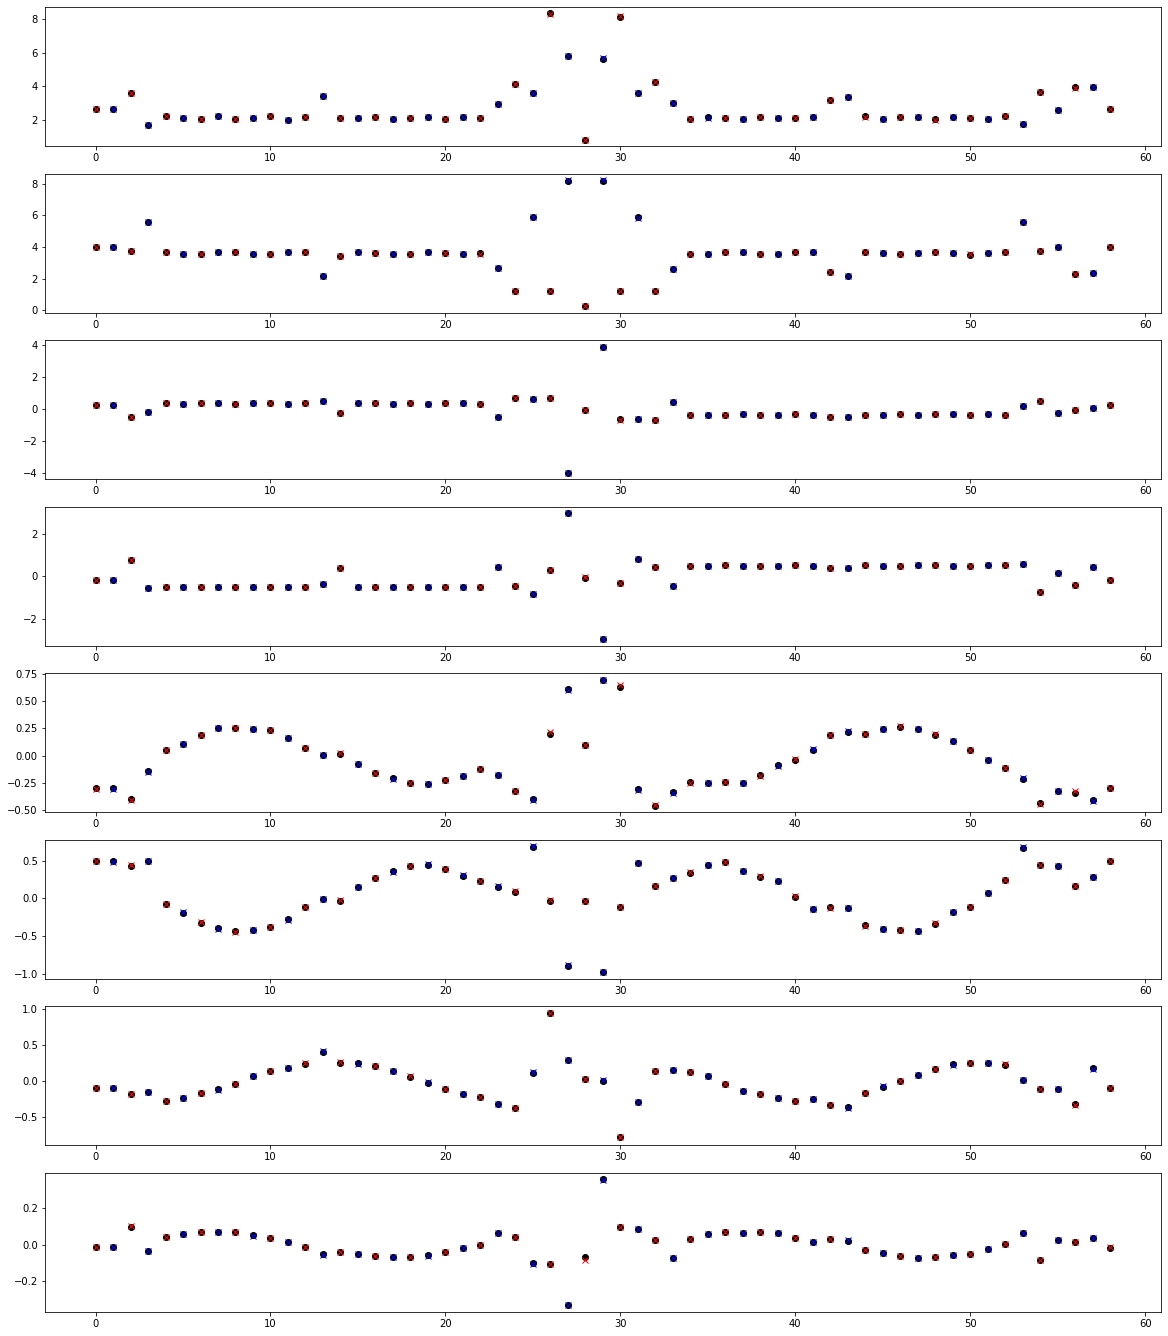

In [38]:
# Compare normalization matrix elements

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.size), N11, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n11, yerr=error_n11, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v11, yerr=error_v11, fmt=' ', color='red', marker='x')

ax = plt.subplot(812)
ax.scatter(range(model.size), N33, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n33, yerr=error_n33, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v33, yerr=error_v33, fmt=' ', color='red', marker='x')

ax = plt.subplot(813)
ax.scatter(range(model.size), N21, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n21, yerr=error_n21, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v21, yerr=error_v21, fmt=' ', color='red', marker='x')

ax = plt.subplot(814)
ax.scatter(range(model.size), N43, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n43, yerr=error_n43, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v43, yerr=error_v43, fmt=' ', color='red', marker='x')

ax = plt.subplot(815)
ax.scatter(range(model.size), N13, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n13, yerr=error_n13, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v13, yerr=error_v13, fmt=' ', color='red', marker='x')

ax = plt.subplot(816)
ax.scatter(range(model.size), N31, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n31, yerr=error_n31, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v31, yerr=error_v31, fmt=' ', color='red', marker='x')

ax = plt.subplot(817)
ax.scatter(range(model.size), N14, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n14, yerr=error_n14, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v14, yerr=error_v14, fmt=' ', color='red', marker='x')

ax = plt.subplot(818)
ax.scatter(range(model.size), N41, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n41, yerr=error_n41, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v41, yerr=error_v41, fmt=' ', color='red', marker='x')

plt.show()

# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [39]:
# Compare normalization matrix elements

print((N11[model.monitor_index] - value_n11).sum().abs())
print((N11[model.virtual_index] - value_v11).sum().abs())
print()

print((N33[model.monitor_index] - value_n33).sum().abs())
print((N33[model.virtual_index] - value_v33).sum().abs())
print()

print((N21[model.monitor_index] - value_n21).sum().abs())
print((N21[model.virtual_index] - value_v21).sum().abs())
print()

print((N43[model.monitor_index] - value_n43).sum().abs())
print((N43[model.virtual_index] - value_v43).sum().abs())
print()

print((N13[model.monitor_index] - value_n13).sum().abs())
print((N13[model.virtual_index] - value_v13).sum().abs())
print()

print((N31[model.monitor_index] - value_n31).sum().abs())
print((N31[model.virtual_index] - value_v31).sum().abs())
print()

print((N14[model.monitor_index] - value_n14).sum().abs())
print((N14[model.virtual_index] - value_v14).sum().abs())
print()

print((N41[model.monitor_index] - value_n41).sum().abs())
print((N41[model.virtual_index] - value_v41).sum().abs())
print()

tensor(4.815059539731e-02, dtype=torch.float64)
tensor(1.057001570037e-02, dtype=torch.float64)

tensor(1.467353013737e-02, dtype=torch.float64)
tensor(1.151409083219e-02, dtype=torch.float64)

tensor(3.642123523128e-02, dtype=torch.float64)
tensor(3.348007394556e-02, dtype=torch.float64)

tensor(5.365397492074e-03, dtype=torch.float64)
tensor(4.947284510027e-02, dtype=torch.float64)

tensor(5.072081835556e-02, dtype=torch.float64)
tensor(3.447952369232e-02, dtype=torch.float64)

tensor(4.533960115097e-02, dtype=torch.float64)
tensor(4.514485510737e-02, dtype=torch.float64)

tensor(4.448995046432e-03, dtype=torch.float64)
tensor(1.888476654362e-02, dtype=torch.float64)

tensor(2.852322851986e-03, dtype=torch.float64)
tensor(1.494864237534e-02, dtype=torch.float64)



In [40]:
# Transport matrix between locations

probe = 10
other = 40

print(model.is_monitor(probe))
print(model.is_monitor(other))

numpy.set_printoptions(linewidth=160, formatter = {'all': lambda x: f'{x:.12f}'})

# Model matrix

print(model.matrix(probe, other).cpu().numpy())
print()

# Matrix with errors

print(model.map_transport_matrix(probe, other).cpu().numpy())
print()

# Matrix (uncoupled, uses twiss.ax, twiss.bx, twiss.ay, twiss.by)

model.model = 'uncoupled'
print(twiss.matrix(probe, other).cpu().numpy())
print()

# Matrix (coupled, uses twiss.normal)

model.model = 'coupled'
print(twiss.matrix(probe, other).cpu().numpy())
print()

False
False
[[-1.101981284744 4.291362513504 0.000000000000 0.000000000000]
 [0.061607262265 -1.147368937519 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -2.087765916041 -12.316964538171]
 [0.000000000000 0.000000000000 -0.273200163375 -2.090750064735]]

[[-1.088510299521 4.263622483515 -0.008983981450 0.004454900631]
 [0.059963100045 -1.153595831283 0.004428221470 0.002359200803]
 [0.047162675985 -0.074056791810 -2.066949394802 -12.384732931267]
 [0.008310501447 -0.013917178460 -0.273435049349 -2.122190796530]]

[[-1.099324419783 4.433923054181 0.000000000000 0.000000000000]
 [0.061664259255 -1.158361042303 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -2.102645827629 -12.420476938235]
 [0.000000000000 0.000000000000 -0.273976252003 -2.093988279798]]

[[-1.042620216978 4.421716884582 -0.023634276407 -0.084517241824]
 [0.031632430585 -1.092855058924 0.005726037812 0.001991817432]
 [0.065623606456 -0.166271814982 -2.064241432801 -12.324246370870]
 [0.0

In [41]:
# Transport matrix between locations

probe = 11
other = 40

print(model.is_monitor(probe))
print(model.is_monitor(other))

numpy.set_printoptions(linewidth=160, formatter = {'all': lambda x: f'{x:.12f}'})

# Model matrix

print(model.matrix(probe, other).cpu().numpy())
print()

# Matrix with errors

print(model.map_transport_matrix(probe, other).cpu().numpy())
print()

# Matrix (uncoupled, uses twiss.ax, twiss.bx, twiss.ay, twiss.by)

model.model = 'uncoupled'
print(twiss.matrix(probe, other).cpu().numpy())
print()

# Matrix (coupled, uses twiss.normal)

model.model = 'coupled'
print(twiss.matrix(probe, other).cpu().numpy())
print()

True
False
[[0.101101748385 3.468613345653 0.000000000000 0.000000000000]
 [-0.287210118351 0.037379674852 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -1.627344339367 -5.054851581057]
 [0.000000000000 0.000000000000 -0.325785214149 -1.626451047143]]

[[0.108500728765 3.417306706477 0.006311083042 0.090555909977]
 [-0.291165926817 0.046417576426 -0.002087125454 -0.036224657683]
 [0.028465751448 -0.171924111578 -1.656518380535 -5.399617528298]
 [0.004752352576 -0.030094384622 -0.333153934848 -1.689654322219]]

[[0.164931062828 3.303000709906 0.000000000000 0.000000000000]
 [-0.300273880702 0.049688389409 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -1.641346177217 -5.144608587253]
 [0.000000000000 0.000000000000 -0.326605154379 -1.632961845017]]

[[0.160963443368 3.300256076894 -0.002028507002 0.050650773339]
 [-0.297971650453 0.102016160062 -0.002299719128 -0.039386058711]
 [0.019261325320 -0.182114531337 -1.627943208045 -5.139003976139]
 [0.00451250

In [42]:
# Transport matrix between locations

probe = 11
other = 41

print(model.is_monitor(probe))
print(model.is_monitor(other))

numpy.set_printoptions(linewidth=160, formatter = {'all': lambda x: f'{x:.12f}'})

# Model matrix

print(model.matrix(probe, other).cpu().numpy())
print()

# Matrix with errors

print(model.map_transport_matrix(probe, other).cpu().numpy())
print()

# Matrix (uncoupled, uses twiss.ax, twiss.bx, twiss.ay, twiss.by)

model.model = 'uncoupled'
print(twiss.matrix(probe, other).cpu().numpy())
print()

# Matrix (coupled, uses twiss.normal)

model.model = 'coupled'
print(twiss.matrix(probe, other).cpu().numpy())
print()

True
True
[[-1.076221857754 4.027541089140 0.000000000000 0.000000000000]
 [0.041836114257 -1.085739581259 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -2.090204875407 -12.308509966242]
 [0.000000000000 0.000000000000 -0.272989728269 -2.085966233446]]

[[-1.084508921523 4.011742752227 -0.002925473693 -0.053155343223]
 [0.040629503255 -1.072385970499 -0.001343702105 -0.018591121115]
 [0.027723353012 -0.173104910278 -2.137322096972 -12.680076629439]
 [0.002893197999 -0.018679699050 -0.279901694246 -2.128454094640]]

[[-1.085263563689 4.012402779847 0.000000000000 0.000000000000]
 [0.041624569332 -1.075328221405 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -2.135757846825 -12.631517646581]
 [0.000000000000 0.000000000000 -0.277991497411 -2.112343640386]]

[[-1.087018441703 4.018245172340 -0.007882796135 -0.080120968913]
 [0.042043978648 -1.075279816461 0.000395450820 -0.007908341288]
 [0.026776870166 -0.164360207098 -2.133469641808 -12.669249111334]
 [0

# Example-16: Virtual matrix

In [1]:
# Import

import numpy
import pandas
import torch

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = 'cpu'

In [3]:
# In this example transport matrices are computed between locations from TbT signals

# Transport matrix i -> j can be written as M(i -> j) = N(j) R(i -> j) N(i)^-1
# Normalization matrices and phase advances can be computed from TbT data at monitor locations
# At virtual locations no TbT data is avaliable. but virtual normalization matrices and phase advances can be computed
# If the model is close to real lattice, virtual parameters are close to the real ones
# See Virtual twiss example and Momenta estimation & virtual trajectories for details
# Here virtual phases and twiss are computed from virtual signals

# Another option is to partially use model transport (twiss.matrix_virtual)

In [4]:
# Set model 

model = Model(path='../config.yaml', dtype=dtype, device=device)

# Set monitor and virtual location names (excluding 'HEAD' and 'TAIL' locations)

monitor = model.name[1:-1:2]
virtual = model.name[2:-1:2]

# Modify model dictionary

for location in monitor: model.dict[location]['TYPE'] = model._monitor ; model.dict[location]['FLAG'] = 1
for location in virtual: model.dict[location]['TYPE'] = model._virtual ; model.dict[location]['FLAG'] = 0

# Set modified model

model = Model(path=model.dict, dtype=dtype, device=device)

# Set errors

model.make_error(0.5E-3, 0.5E-3, length=0.001)

# Set transport

model.make_transport(error=True, exact=False)

# Compute twiss

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

NUX, NUY = model.out_tune_fractional

# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0]
N33 = model.out_normal[:, 2, 2]
N21 = model.out_normal[:, 1, 0]
N43 = model.out_normal[:, 3, 2]
N13 = model.out_normal[:, 0, 2]
N31 = model.out_normal[:, 2, 0]
N14 = model.out_normal[:, 0, 3]
N41 = model.out_normal[:, 3, 0]

# Set CS twiss

AX, BX, AY, BY = model.out_cs.T


# Set accumulated phase advance

MUX, MUY = model.out_advance.roll(1, 0).cumsum(0).T

True


torch.Size([59, 4096, 4])

3.851905309e-07, 4.660074277e-18
2.064636969e-07, 2.142810601e-19



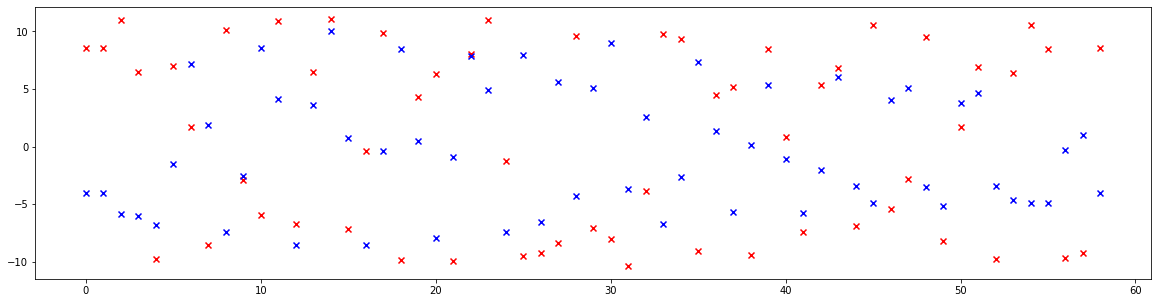

In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.002, 0.0, 0.002, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[model.monitor_index, ..., 0]
y = trajectory[model.monitor_index, ..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[index], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

# Compare model and real beta function values

from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

plt.figure(figsize=(20, 5))
plt.scatter(range(model.size), 100*(BX - model.bx)/model.bx, color='red', marker='x')
plt.scatter(range(model.size), 100*(BY - model.by)/model.by, color='blue', marker='x')
plt.show()

NUX= 0.540783757
nux= 0.540783757, sigma_nux=1.74631339e-16, error_nux=5.55111512e-16

NUY= 0.581765887
nuy= 0.581765887, sigma_nuy=1.4920152e-16, error_nuy=1.11022302e-16



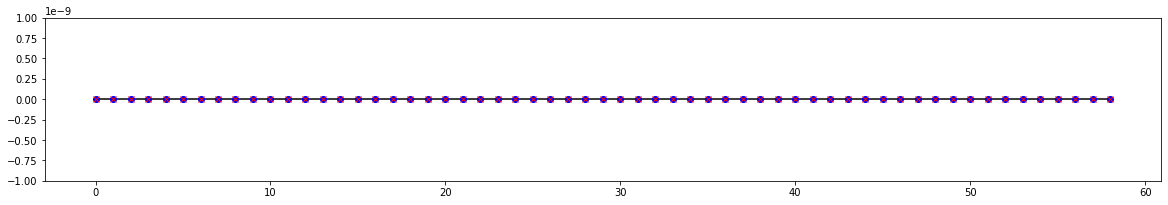

In [6]:
# Compute reference parameters from clean data at all locations

# Set window

win = Window.from_cosine(length, 2.0, dtype=dtype, device=device)

# Estimate frequency, amplitude and phase for x plane

tbt = Data.from_data(win, trajectory[..., 0])

f = Frequency(tbt)
tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')
print()

d = Decomposition(tbt)
ax_ref, sigma_ax, *_ = d.harmonic_amplitude(nux, length=2048, order=2.0, error=True, sigma_frequency=sigma_nux, shift=True, count=512, step=16, method='none')
fx_ref, sigma_fx, *_ = d.harmonic_phase(nux, length=2048, order=2.0, error=True, sigma_frequency=sigma_nux, shift=True, count=512, step=16, method='none')

# Estimate frequency, amplitude and phase for y plane

tbt = Data.from_data(win, trajectory[..., 2])

f = Frequency(tbt)
tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')
print()

d = Decomposition(tbt)
ay_ref, sigma_ay, *_ = d.harmonic_amplitude(nuy, length=2048, order=2.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=512, step=16, method='none')
fy_ref, sigma_fy, *_ = d.harmonic_phase(nuy, length=2048, order=2.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=512, step=16, method='none')

# Phase advance between locations

plt.figure(figsize=(20, 3))

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX)
advance, _ = Decomposition.phase_adjacent(nux, fx_ref)

plt.errorbar(range(model.size), mod(ADVANCE - advance, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), fmt=' ', marker='o', color='blue')

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY)
advance, _ = Decomposition.phase_adjacent(nuy, fy_ref)

plt.errorbar(range(model.size), mod(ADVANCE - advance, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), fmt=' ', marker='x', color='red')

plt.ylim(-1.0E-9, +1.0E-9)
plt.hlines(0, 0, model.size - 1, colors='black')

plt.show()

In [7]:
# Generate TbT data with noise

# Set noise values for each monitor location 

noise_x = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(5.0 + 5.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set length

length = 2**10

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x[:, :length])
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y[:, :length])
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(29, Window(1024, 'cosine_window', 1.0))
Data(29, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')
print()

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

print((ax - ax_ref[model.monitor_index]).abs().sum().item())
print((fx - fx_ref[model.monitor_index]).abs().sum().item())

NUX= 0.540783757
nux=  0.54078374, sigma_nux=1.09803767e-07, error_nux=1.63925266e-08

9.656531090514262e-06
0.003638829691866692


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')
print()

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

print((ay - ay_ref[model.monitor_index]).abs().sum().item())
print((fy - fy_ref[model.monitor_index]).abs().sum().item())

NUY= 0.581765887
nuy= 0.581765914, sigma_nuy=1.15979221e-07, error_nuy=2.67244539e-08

8.302459386912153e-06
0.004638881844242715


In [10]:
# Set table

table = Table(
    model.monitor_name,
    nux, nuy, ax, ay, fx, fy,
    sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    accumulate=True,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(NUX, mux)
muy, _ = Decomposition.phase_adjacent(NUY, muy)

print((mux - table.phase_x).abs().sum().item())
print((muy - table.phase_y).abs().sum().item())
print()

0.0058446190367983375
0.005223092552893549



In [11]:
# Set twiss

twiss = Twiss(model, table)

In [12]:
# Generate virtual signals

# Note, limit selection can be motivated by how accurate is the model
# Minimal value is one and it should be used if model if off
# Larger values can improve accuracy if model is more accurate

start = 1
count = length - 1 - start
limit = 1

VQX = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)
VPX = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)
VQY = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)
VPY = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)

for index, location in enumerate(model.virtual_index):
    
    qx, px, qy, py = twiss.get_momenta_lstsq(start, count, location, limit, model.matrix, phony=True, forward=True, inverse=True)
    
    VQX[index, :count] = qx
    VPX[index, :count] = px
    
    VQY[index, :count] = qy
    VPY[index, :count] = py

In [13]:
# Set TbT

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

X = Data.from_data(win, VQX)
Y = Data.from_data(win, VQY)

print(X)
print(Y)

Data(30, Window(1024, 'cosine_window', 1.0))
Data(30, Window(1024, 'cosine_window', 1.0))


In [14]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

# Shift phase

fx = mod(fx - 2.0*numpy.pi*start*nux, 2.0*numpy.pi, -numpy.pi)

NUX= 0.540783757
nux= 0.540783731, sigma_nux=2.34672808e-07, error_nux=2.57198099e-08


In [15]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

# Shift phase

fy = mod(fy - 2.0*numpy.pi*start*nuy, 2.0*numpy.pi, -numpy.pi)

NUY= 0.581765887
nuy= 0.581765844, sigma_nuy=3.4504495e-07, error_nuy=4.32971036e-08


In [16]:
# Set virtual phases

twiss.fx[model.virtual_index] = fx
twiss.fy[model.virtual_index] = fy

twiss.sigma_fx[model.virtual_index] = sigma_fx
twiss.sigma_fy[model.virtual_index] = sigma_fy

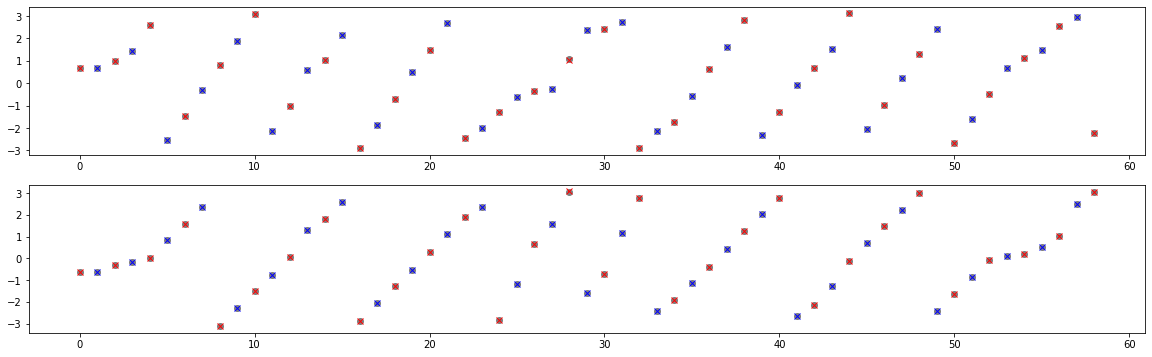

In [17]:
# Compare phases

plt.figure(figsize=(20, 2*3))

ax1 = plt.subplot(211)
ax1.scatter(range(model.size), fx_ref.cpu().numpy(), marker='o', color='gray')
ax1.errorbar(model.monitor_index, mod(twiss.fx[model.monitor_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(model.virtual_index, mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.scatter(range(model.size), fy_ref.cpu().numpy(), marker='o', color='gray')
ax2.errorbar(model.monitor_index, mod(twiss.fy[model.monitor_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(model.virtual_index, mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

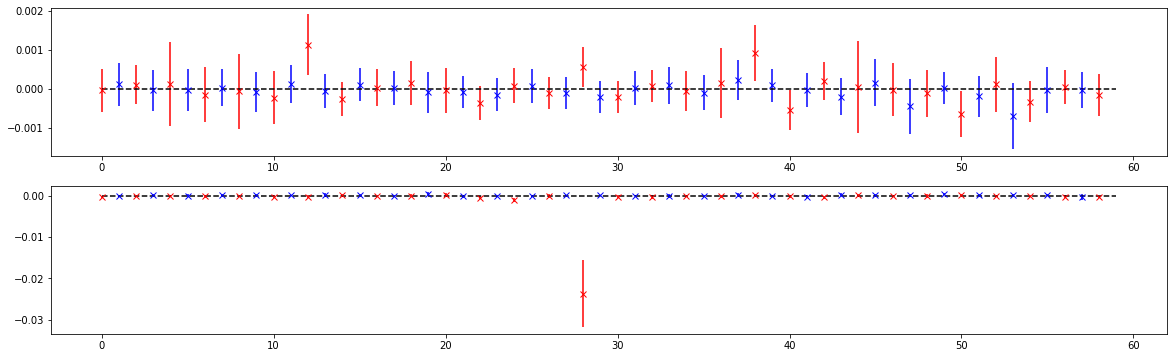

In [18]:
# Compare phases

plt.figure(figsize=(20, 2*3))

ax1 = plt.subplot(211)
ax1.errorbar(model.monitor_index, (fx_ref[model.monitor_index] - mod(twiss.fx[model.monitor_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(model.virtual_index, (fx_ref[model.virtual_index] - mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.hlines(0, 0, model.size, linestyles='dashed', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(model.monitor_index, (fy_ref[model.monitor_index] - mod(twiss.fy[model.monitor_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(model.virtual_index, (fy_ref[model.virtual_index] - mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')
ax2.hlines(0, 0, model.size, linestyles='dashed', color='black')

plt.show()

In [19]:
%%time

# Estimate twiss

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 product=True,
                                 jacobian=False,
                                 count=256,
                                 fraction=0.75,
                                 ix=None,
                                 iy=None,
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)

torch.Size([29, 2, 10, 256])
CPU times: user 1min 19s, sys: 1.32 s, total: 1min 20s
Wall time: 2min 1s


In [20]:
# Process fitted invariants

ix, iy = data[:, 0, 0], data[:, 0, 1]
sigma_ix, sigma_iy = data[:, 1, 0], data[:, 1, 1]
invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

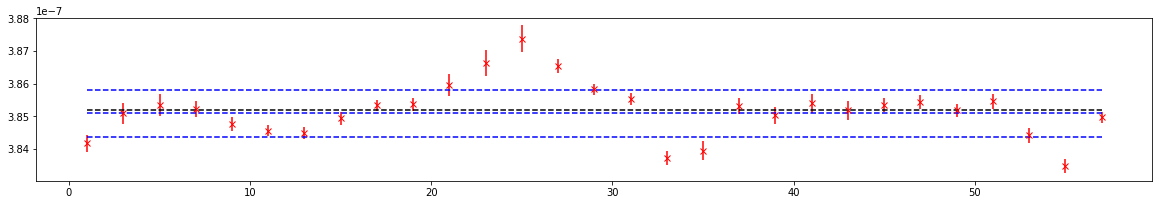

tensor(3.851905309460e-07, dtype=torch.float64)
tensor(3.850798427505e-07, dtype=torch.float64)
tensor(7.278626253437e-10, dtype=torch.float64)



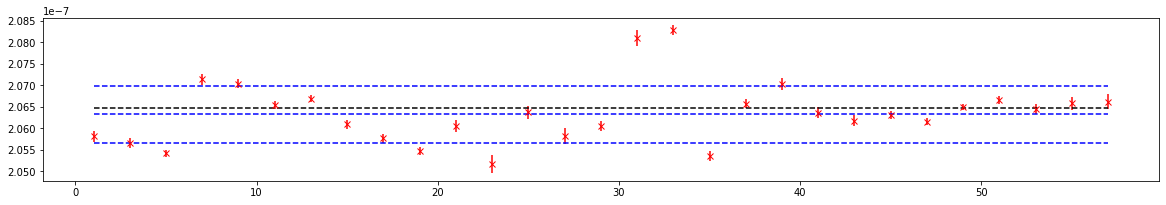

tensor(2.064636968574e-07, dtype=torch.float64)
tensor(2.063263550335e-07, dtype=torch.float64)
tensor(6.577258968535e-10, dtype=torch.float64)



In [21]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(model.monitor_index, invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(model.monitor_index, invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

In [22]:
# Process twiss

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value, error = data.permute(1, 2, 0, -1)

*_, value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41 = value
*_, error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41 = error

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

In [23]:
%%time

# Estimate twiss (virtual)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 phony=True,
                                 product=True,
                                 jacobian=False,
                                 count=256,
                                 fraction=0.75,
                                 ix=invariant['ix_value'],
                                 iy=invariant['iy_value'],
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)
print(model.virtual_count)

torch.Size([30, 2, 8, 256])
30
CPU times: user 1min 15s, sys: 1.24 s, total: 1min 16s
Wall time: 1min 42s


In [24]:
# Process twiss

value, error = data.permute(1, 2, 0, -1)

*_, value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41 = value
*_, error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41 = error

value_v11, error_v11 = twiss.process(value_v11, error_v11)
value_v33, error_v33 = twiss.process(value_v33, error_v33)
value_v21, error_v21 = twiss.process(value_v21, error_v21)
value_v43, error_v43 = twiss.process(value_v43, error_v43)
value_v13, error_v13 = twiss.process(value_v13, error_v13)
value_v31, error_v31 = twiss.process(value_v31, error_v31)
value_v14, error_v14 = twiss.process(value_v14, error_v14)
value_v41, error_v41 = twiss.process(value_v41, error_v41)

In [25]:
# Compute twiss at all locations from normalization

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_local, error_local in zip(value, error):
    table = value_local.reshape(-1, 1) + error_local.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax_m, value_bx_m, value_ay_m, value_by_m = cs_value.T
error_ax_m, error_bx_m, error_ay_m, error_by_m = cs_error.T

value = torch.stack([value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41]).T
error = torch.stack([error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41]).T

cs_value, cs_error = [], []

for value_local, error_local in zip(value, error):
    table = value_local.reshape(-1, 1) + error_local.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax_v, value_bx_v, value_ay_v, value_by_v = cs_value.T
error_ax_v, error_bx_v, error_ay_v, error_by_v = cs_error.T

In [26]:
# Set uncoupled

twiss.ax[model.monitor_index] = value_ax_m
twiss.bx[model.monitor_index] = value_bx_m
twiss.ay[model.monitor_index] = value_ay_m
twiss.by[model.monitor_index] = value_by_m

twiss.ax[model.virtual_index] = value_ax_v
twiss.bx[model.virtual_index] = value_bx_v
twiss.ay[model.virtual_index] = value_ay_v
twiss.by[model.virtual_index] = value_by_v

twiss.sigma_ax[model.monitor_index] = error_ax_m
twiss.sigma_bx[model.monitor_index] = error_bx_m
twiss.sigma_ay[model.monitor_index] = error_ay_m
twiss.sigma_by[model.monitor_index] = error_by_m

twiss.sigma_ax[model.virtual_index] = error_ax_v
twiss.sigma_bx[model.virtual_index] = error_bx_v
twiss.sigma_ay[model.virtual_index] = error_ay_v
twiss.sigma_by[model.virtual_index] = error_by_v

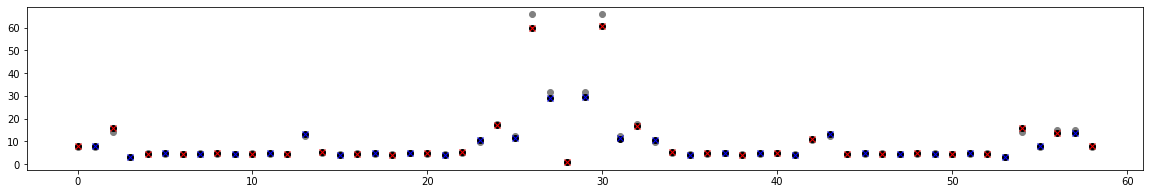

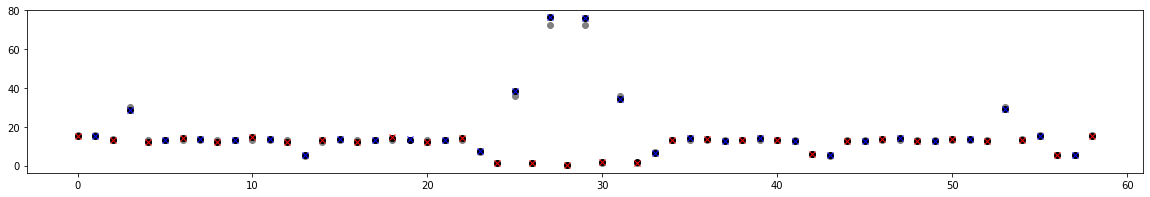

tensor(8.542285186338e-02, dtype=torch.float64)
tensor(2.819317475533e-01, dtype=torch.float64)

tensor(2.025234591838e-02, dtype=torch.float64)
tensor(1.315367683062e-02, dtype=torch.float64)



In [27]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.bx, color='gray', marker='o')
plt.scatter(range(model.size), BX, color='black', marker='o')
plt.errorbar(model.monitor_index, value_bx_m, yerr=error_bx_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_bx_v, yerr=error_bx_v, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.by, color='gray', marker='o')
plt.scatter(range(model.size), BY, color='black', marker='o')
plt.errorbar(model.monitor_index, value_by_m, yerr=error_by_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_by_v, yerr=error_by_v, fmt=' ', color='red', marker='x')
plt.show()

print((BX[model.monitor_index] - value_bx_m).sum().abs())
print((BX[model.virtual_index] - value_bx_v).sum().abs())
print()

print((BY[model.monitor_index] - value_by_m).sum().abs())
print((BY[model.virtual_index] - value_by_v).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

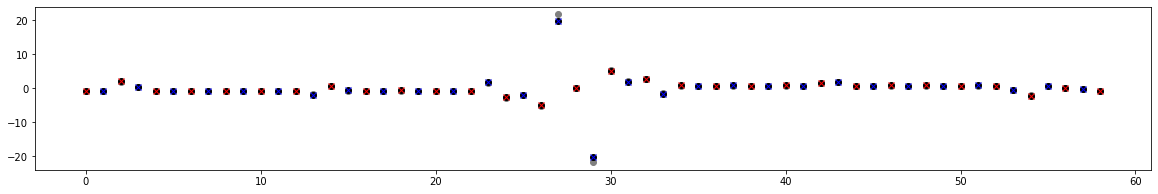

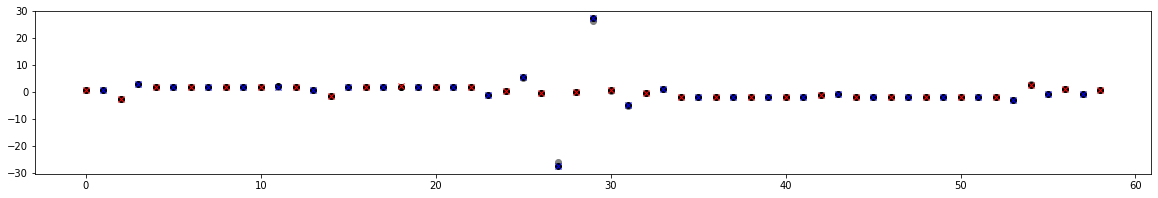

tensor(5.259422081657e-02, dtype=torch.float64)
tensor(3.323969372030e-02, dtype=torch.float64)

tensor(2.674538419953e-02, dtype=torch.float64)
tensor(6.157381453823e-02, dtype=torch.float64)



In [28]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ax, color='gray', marker='o')
plt.scatter(range(model.size), AX, color='black', marker='o')
plt.errorbar(model.monitor_index, value_ax_m, yerr=error_ax_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ax_v, yerr=error_ax_v, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ay, color='gray', marker='o')
plt.scatter(range(model.size), AY, color='black', marker='o')
plt.errorbar(model.monitor_index, value_ay_m, yerr=error_ay_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ay_v, yerr=error_ay_v, fmt=' ', color='red', marker='x')
plt.show()

print((AX[model.monitor_index] - value_ax_m).sum().abs())
print((AX[model.virtual_index] - value_ax_v).sum().abs())
print()

print((AY[model.monitor_index] - value_ay_m).sum().abs())
print((AY[model.virtual_index] - value_ay_v).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

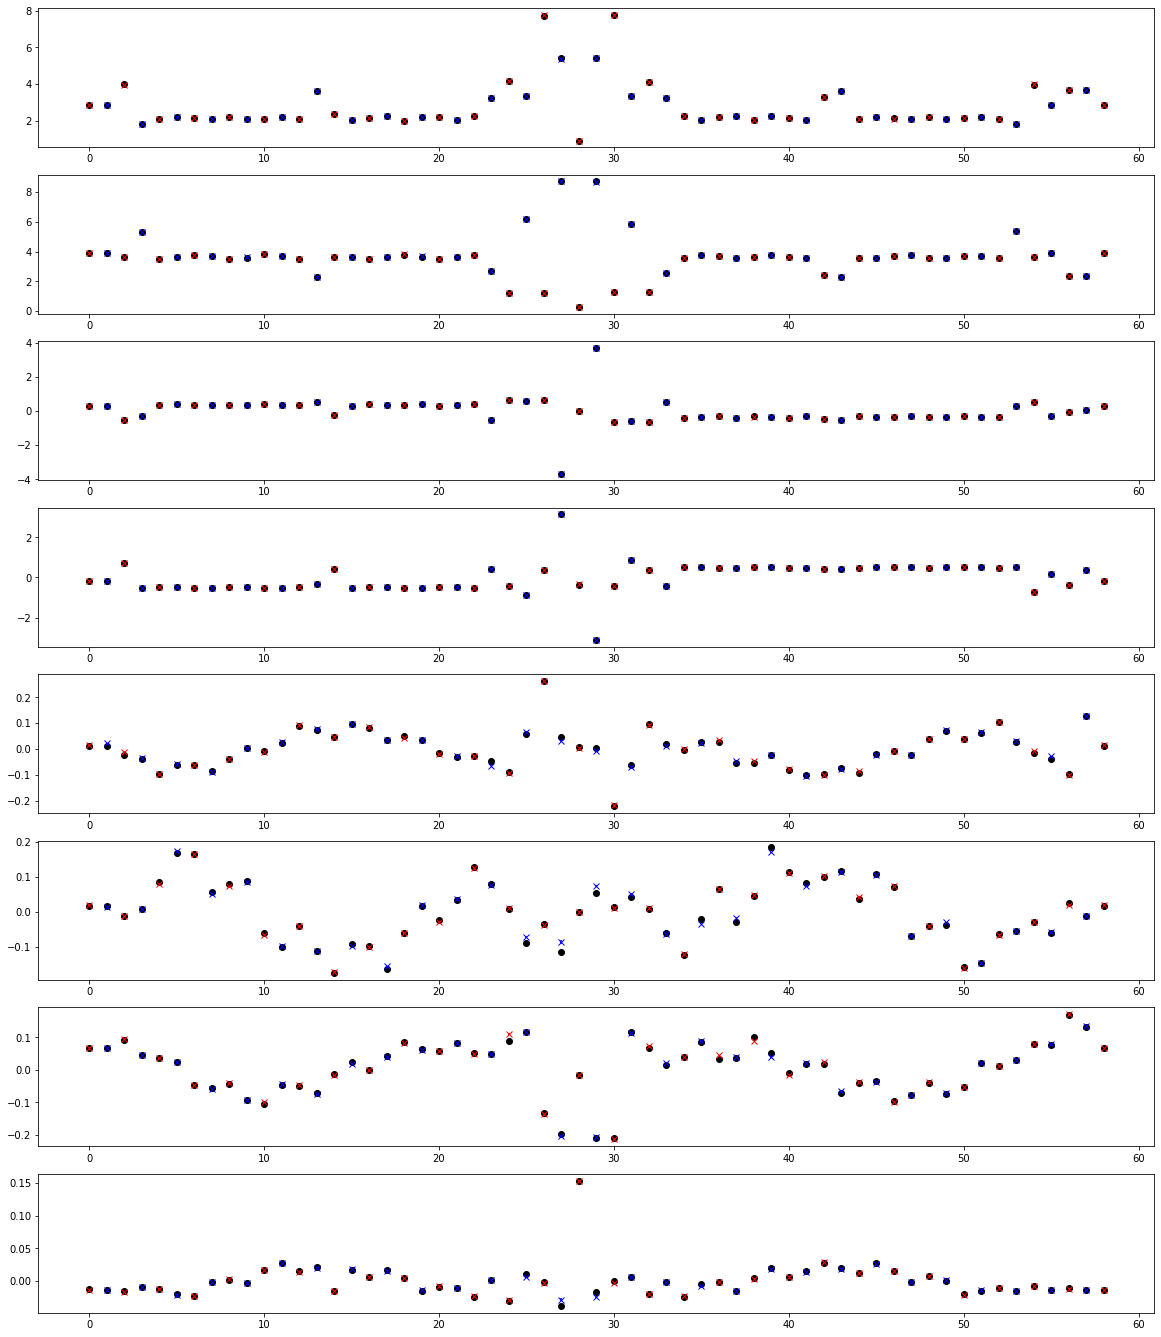

In [29]:
# Compare normalization matrix elements

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.size), N11, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n11, yerr=error_n11, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v11, yerr=error_v11, fmt=' ', color='red', marker='x')

ax = plt.subplot(812)
ax.scatter(range(model.size), N33, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n33, yerr=error_n33, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v33, yerr=error_v33, fmt=' ', color='red', marker='x')

ax = plt.subplot(813)
ax.scatter(range(model.size), N21, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n21, yerr=error_n21, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v21, yerr=error_v21, fmt=' ', color='red', marker='x')

ax = plt.subplot(814)
ax.scatter(range(model.size), N43, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n43, yerr=error_n43, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v43, yerr=error_v43, fmt=' ', color='red', marker='x')

ax = plt.subplot(815)
ax.scatter(range(model.size), N13, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n13, yerr=error_n13, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v13, yerr=error_v13, fmt=' ', color='red', marker='x')

ax = plt.subplot(816)
ax.scatter(range(model.size), N31, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n31, yerr=error_n31, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v31, yerr=error_v31, fmt=' ', color='red', marker='x')

ax = plt.subplot(817)
ax.scatter(range(model.size), N14, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n14, yerr=error_n14, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v14, yerr=error_v14, fmt=' ', color='red', marker='x')

ax = plt.subplot(818)
ax.scatter(range(model.size), N41, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n41, yerr=error_n41, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v41, yerr=error_v41, fmt=' ', color='red', marker='x')

plt.show()

# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [30]:
# Set normal at monitor locations

from harmonica.parameterization import parametric_normal
for index, (n11, n33, n21, n43, n13, n31, n14, n41) in enumerate(zip(value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41)):
    index = model.monitor_index[index]
    normal = parametric_normal(n11, n33, n21, n43, n13, n31, n14, n41, dtype=dtype)
    twiss.normal[index] = normal

# Set normal at virtual locations

from harmonica.parameterization import parametric_normal
for index, (n11, n33, n21, n43, n13, n31, n14, n41) in enumerate(zip(value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41)):
    index = model.virtual_index[index]
    normal = parametric_normal(n11, n33, n21, n43, n13, n31, n14, n41, dtype=dtype)
    twiss.normal[index] = normal

In [31]:
# Transport matrix between locations

numpy.set_printoptions(linewidth=160, formatter = {'all': lambda x: f'{x:.12f}'})

# Set model type ('uncoupled' or 'coupled')

model.model = 'coupled'

# Set probe & other locations

probe = 10
other = 40

print(f'{probe}: {model.is_monitor(probe)}')
print(f'{other}: {model.is_monitor(other)}')
print()

# Exact matrix

matrix_exact = model.map_transport_matrix(probe, other)
print('exact')
print(f'error: {torch.linalg.matrix_norm(matrix_exact - matrix_exact).item():.6e}')
print(matrix_exact.cpu().numpy())
print()

# Model matrix

matrix_model = model.matrix(probe, other)
print('model')
print(f'error: {torch.linalg.matrix_norm(matrix_exact - matrix_model).item():.6e}')
print(matrix_model.cpu().numpy())
print()

# Estimated matrix (virtual twiss)

matrix_twiss = twiss.matrix(probe, other)
print('virtual (twiss)')
print(f'error: {torch.linalg.matrix_norm(matrix_exact - matrix_twiss).item():.6e}')
print(matrix_twiss.cpu().numpy())
print()

# Estimated matrix (virtual matrix)

matrix_twiss = twiss.matrix_virtual(probe, other, close='nearest')
print('virtual (matrix)')
print(f'error: {torch.linalg.matrix_norm(matrix_exact - matrix_twiss).item():.6e}')
print(matrix_twiss.cpu().numpy())
print()

10: False
40: False

exact
error: 0.000000e+00
[[-1.130863453781 4.314351362599 -0.005763743378 0.039167811964]
 [0.072592404168 -1.161209685245 0.000317666644 -0.005549331690]
 [0.006511129118 0.112691731871 -2.114472541018 -12.615238437828]
 [0.000826197551 0.017300877805 -0.277392506279 -2.127884367227]]

model
error: 3.277073e-01
[[-1.101981284744 4.291362513504 0.000000000000 0.000000000000]
 [0.061607262265 -1.147368937519 0.000000000000 0.000000000000]
 [0.000000000000 0.000000000000 -2.087765916041 -12.316964538171]
 [0.000000000000 0.000000000000 -0.273200163375 -2.090750064735]]

virtual (twiss)
error: 5.385597e-02
[[-1.127097332453 4.311478132839 -0.008308429058 0.030117246286]
 [0.070956584582 -1.158670535160 0.000812714713 -0.002138811721]
 [0.004714559739 0.131982997127 -2.120701836781 -12.663610046661]
 [0.000771514240 0.020175838953 -0.277794937955 -2.130376555252]]

virtual (matrix)
error: 2.767118e-02
[[-1.132227635036 4.309997347900 -0.007827075737 0.026639315433]
 [

In [32]:
%%time

# Set model type ('uncoupled' or 'coupled')

model.model = 'uncoupled'

# Compute errors for all possible combinations with probe != other

from itertools import product

error_model = []
error_twiss = []
error_close = []

for probe, other in product(range(model.size), repeat=2):
    if probe != other:
        matrix = model.map_transport_matrix(probe, other)
        error_model.append(torch.linalg.matrix_norm(matrix - model.matrix(probe, other)))
        error_twiss.append(torch.linalg.matrix_norm(matrix - twiss.matrix(probe, other)))
        error_close.append(torch.linalg.matrix_norm(matrix - twiss.matrix_virtual(probe, other)))
    
error_model = torch.stack(error_model)
error_twiss = torch.stack(error_twiss)
error_close = torch.stack(error_close)

CPU times: user 2min 44s, sys: 0 ns, total: 2min 44s
Wall time: 2min 44s


802.1762748952478
410.5368822959357
426.61506523825426


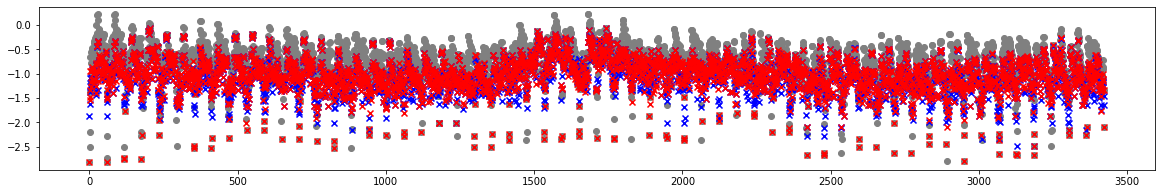

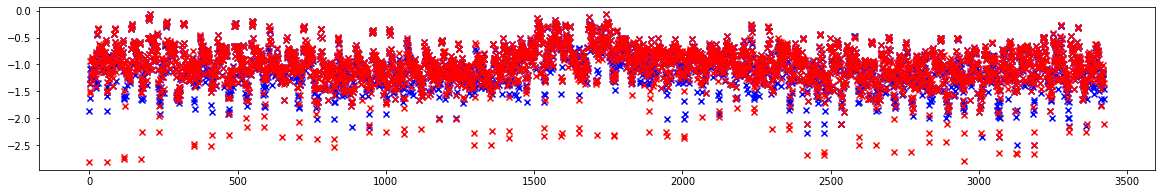

In [33]:
# Plot errors

print(error_model.sum().item())
print(error_twiss.sum().item())
print(error_close.sum().item())

plt.figure(figsize=(20, 3))
plt.scatter(range(len(error_model)), error_model.cpu().log10().numpy(), color='gray', marker='o')
plt.scatter(range(len(error_twiss)), error_twiss.cpu().log10().numpy(), color='blue', marker='x')
plt.scatter(range(len(error_close)), error_close.cpu().log10().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(len(error_twiss)), error_twiss.log10().cpu().numpy(), color='blue', marker='x')
plt.scatter(range(len(error_close)), error_close.log10().cpu().numpy(), color='red', marker='x')
plt.show()

# gray -- model
# blue -- virtual twiss
# red  -- virtual matrix

In [34]:
%%time

# Set model type ('uncoupled' or 'coupled')

model.model = 'coupled'

# Compute errors for all possible combinations with probe != other

from itertools import product

error_model = []
error_twiss = []
error_close = []

for probe, other in product(range(model.size), repeat=2):
    if probe != other:
        matrix = model.map_transport_matrix(probe, other)
        error_model.append(torch.linalg.matrix_norm(matrix - model.matrix(probe, other)))
        error_twiss.append(torch.linalg.matrix_norm(matrix - twiss.matrix(probe, other)))
        error_close.append(torch.linalg.matrix_norm(matrix - twiss.matrix_virtual(probe, other)))
    
error_model = torch.stack(error_model)
error_twiss = torch.stack(error_twiss)
error_close = torch.stack(error_close)

CPU times: user 2min 16s, sys: 302 µs, total: 2min 16s
Wall time: 2min 16s


802.176274895276
162.87615588992207
203.8338621194411


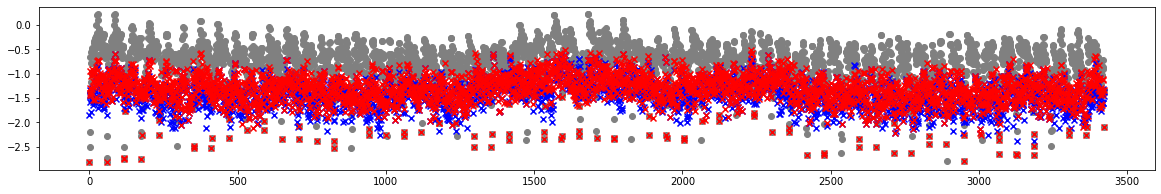

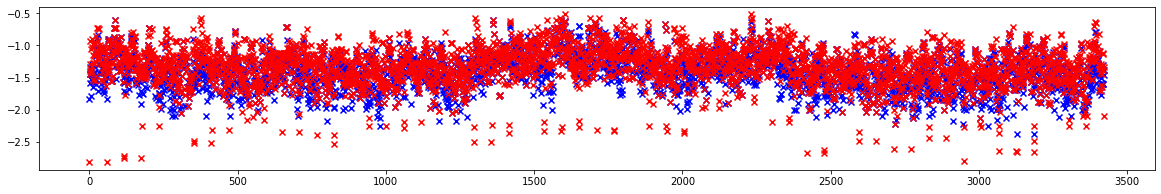

In [35]:
# Plot errors

print(error_model.sum().item())
print(error_twiss.sum().item())
print(error_close.sum().item())

plt.figure(figsize=(20, 3))
plt.scatter(range(len(error_model)), error_model.cpu().log10().numpy(), color='gray', marker='o')
plt.scatter(range(len(error_twiss)), error_twiss.cpu().log10().numpy(), color='blue', marker='x')
plt.scatter(range(len(error_close)), error_close.cpu().log10().numpy(), color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(len(error_twiss)), error_twiss.log10().cpu().numpy(), color='blue', marker='x')
plt.scatter(range(len(error_close)), error_close.log10().cpu().numpy(), color='red', marker='x')
plt.show()

# gray -- model
# blue -- virtual twiss
# red  -- virtual matrix

# Example-17: Virtual responce

In [1]:
# Import

import re
import numpy
import pandas
import torch
import yaml

import sys
sys.path.append('..')

from harmonica.util import mod
from harmonica.statistics import mean, variance
from harmonica.statistics import weighted_mean, weighted_variance
from harmonica.window import Window
from harmonica.data import Data
from harmonica.frequency import Frequency
from harmonica.filter import Filter
from harmonica.decomposition import Decomposition
from harmonica.model import Model
from harmonica.table import Table
from harmonica.twiss import Twiss

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())

True


In [2]:
# Set data type and device

dtype = torch.float64
device = torch.device('cpu')

In [3]:
# In this example virtual orbit responce matrix is computed
# Errors are introduced into standalone quadrupoles
# Transport matrices between monitors and correctors are computed using virtual phase and twiss
# One-step correction efficiency is compared

True


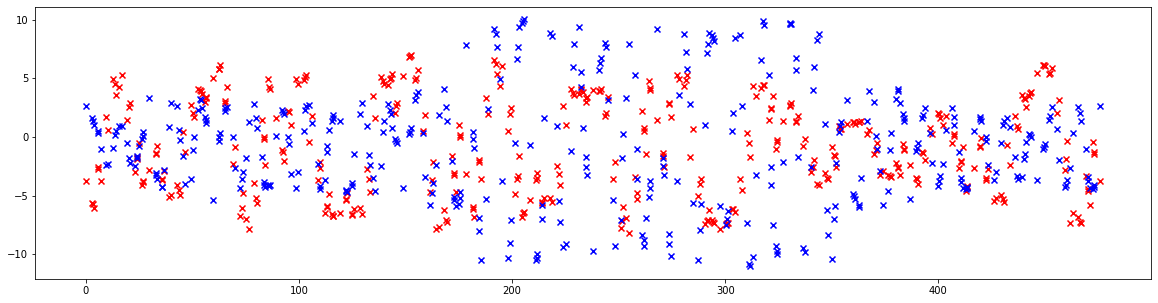

In [4]:
# Set model

model = Model(path='../fast.yaml', model='uncoupled', dtype=dtype, device=device)

# Set monitor locations (ID monitors)

lm = [model.name.index(name) for name in model.name if re.match(r'^(MA).*\.PKA[1, 2]', name)]

# Set fast corrector locations

lc = [model.name.index(name) for name in model.name if re.match(r'^(MA).*\.CB.*\.CX', name)]

# Set standalone quadrupole locations

lq = [model.name.index(name) for name in model.name if re.match(r'^(MA).*\.Q[F, D]', name)]

# Set quadrupole errors

kn = torch.zeros(model.size, dtype=dtype, device=device)
ks = torch.zeros(model.size, dtype=dtype, device=device)
kl = 0.0

kn[lq] += 1.0E-3*torch.randn(len(lq), dtype=dtype, device=device)
ks[lq] += 1.0E-3*torch.randn(len(lq), dtype=dtype, device=device)

# Set corrector errors

cx = torch.zeros(model.size, dtype=dtype, device=device)
cy = torch.zeros(model.size, dtype=dtype, device=device)

cx[lq] += 10.0E-6*torch.randn(len(lq), dtype=dtype, device=device)
cy[lq] += 10.0E-6*torch.randn(len(lq), dtype=dtype, device=device)

# Make errors

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)

# Make transport

model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

# Make twiss

model.make_twiss()
print(model.is_stable)

# Set fractional tunes

NUX, NUY = model.out_tune_fractional

# Set free normalization matrix elements

N11 = model.out_normal[:, 0, 0]
N33 = model.out_normal[:, 2, 2]
N21 = model.out_normal[:, 1, 0]
N43 = model.out_normal[:, 3, 2]
N13 = model.out_normal[:, 0, 2]
N31 = model.out_normal[:, 2, 0]
N14 = model.out_normal[:, 0, 3]
N41 = model.out_normal[:, 3, 0]

# Set CS twiss

AX, BX, AY, BY = model.out_cs.T

# Set accumulated phase advance

MUX, MUY = model.out_advance.roll(1, 0).cumsum(0).T

# Compare twiss

plt.figure(figsize=(20, 5))
plt.scatter(model.time.cpu().numpy(), 100*(BX - model.bx)/model.bx, color='red', marker='x')
plt.scatter(model.time.cpu().numpy(), 100*(BY - model.by)/model.by, color='blue', marker='x')
plt.show()

In [5]:
# Generate test trajectories

# Set initial condition

initial = torch.tensor([0.001, 0.0, 0.001, 0.0], dtype=dtype, device=device)

# Set number of iterations

length = 2**12

# Generate trajectories

trajectory =  model.make_trajectory(initial, length, error=True, transport=True)
print(trajectory.shape)
print()

# Set x & y coordinates at each monitor location

x = trajectory[model.monitor_index, ..., 0]
y = trajectory[model.monitor_index, ..., 2]

# Compute reference invariant values using selected trajectory

# Set trajectory index

index = 0

# Compute invariants

from harmonica.parameterization import invariant
action_x, action_y = invariant(model.out_normal[index], trajectory[index])

print(f'{action_x.mean().item():>12.9e}, {action_x.std().item():>12.9e}')
print(f'{action_y.mean().item():>12.9e}, {action_y.std().item():>12.9e}')
print()

action_x = action_x.mean()
action_y = action_y.mean()

torch.Size([385, 4096, 4])

4.814831377e-08, 9.091744269e-19
1.981004437e-07, 1.251565131e-18



NUX= 0.798001464
nux= 0.798001464, sigma_nux=3.53029369e-16, error_nux=7.77156117e-16

NUY= 0.836628825
nuy= 0.836628825, sigma_nuy=1.13311663e-16, error_nuy=1.11022302e-15



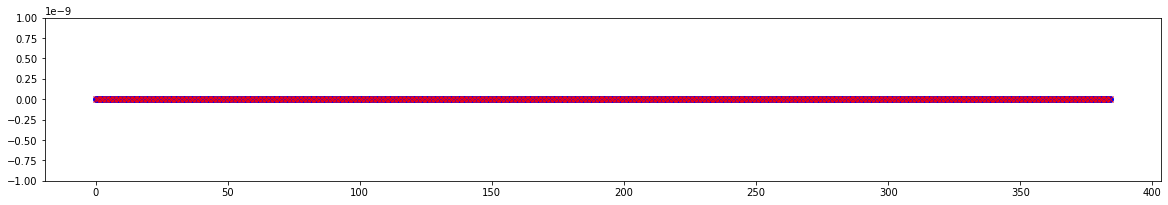

In [6]:
# Compute reference parameters from clean data at all locations

# Set window

win = Window.from_cosine(length, 2.0, dtype=dtype, device=device)

# Estimate frequency, amplitude and phase for x plane

tbt = Data.from_data(win, trajectory[..., 0])

f = Frequency(tbt)
tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')
print()

d = Decomposition(tbt)
ax_ref, sigma_ax, *_ = d.harmonic_amplitude(nux, length=2048, order=2.0, error=True, sigma_frequency=sigma_nux, shift=True, count=512, step=16, method='none')
fx_ref, sigma_fx, *_ = d.harmonic_phase(nux, length=2048, order=2.0, error=True, sigma_frequency=sigma_nux, shift=True, count=512, step=16, method='none')

# Estimate frequency, amplitude and phase for y plane

tbt = Data.from_data(win, trajectory[..., 2])

f = Frequency(tbt)
tbt.window_remove_mean()
tbt.window_apply()
f('parabola')
tbt.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')
print()

d = Decomposition(tbt)
ay_ref, sigma_ay, *_ = d.harmonic_amplitude(nuy, length=2048, order=2.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=512, step=16, method='none')
fy_ref, sigma_fy, *_ = d.harmonic_phase(nuy, length=2048, order=2.0, error=True, sigma_frequency=sigma_nuy, shift=True, count=512, step=16, method='none')

# Phase advance between locations

plt.figure(figsize=(20, 3))

ADVANCE, _ = Decomposition.phase_adjacent(NUX, MUX)
advance, _ = Decomposition.phase_adjacent(nux, fx_ref)

plt.errorbar(range(model.size), mod(ADVANCE - advance, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), fmt=' ', marker='o', color='blue')

ADVANCE, _ = Decomposition.phase_adjacent(NUY, MUY)
advance, _ = Decomposition.phase_adjacent(nuy, fy_ref)

plt.errorbar(range(model.size), mod(ADVANCE - advance, 2.0*numpy.pi, -numpy.pi).cpu().numpy(), fmt=' ', marker='x', color='red')

plt.ylim(-1.0E-9, +1.0E-9)
plt.hlines(0, 0, model.size - 1, colors='black')

plt.show()

In [7]:
# Generate TbT data with noise

# Set noise values for each monitor location 

noise_x = 1.0E-6*(1.0 + 1.0*torch.rand(model.monitor_count, dtype=dtype, device=device))
noise_y = 1.0E-6*(1.0 + 1.0*torch.rand(model.monitor_count, dtype=dtype, device=device))

# Set length

length = 2**10

# Set window

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

# Set TbT & add noise

X = Data.from_data(win, x[:, :length])
X.add_noise(noise_x)
X.data.copy_(X.work)
X.reset()
print(X)

Y = Data.from_data(win, y[:, :length])
Y.add_noise(noise_y)
Y.data.copy_(Y.work)
Y.reset()
print(Y)

Data(224, Window(1024, 'cosine_window', 1.0))
Data(224, Window(1024, 'cosine_window', 1.0))


In [8]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')
print()

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

print((ax - ax_ref[model.monitor_index]).abs().sum().item())
print((fx - fx_ref[model.monitor_index]).abs().sum().item())

NUX= 0.798001464
nux= 0.798001457, sigma_nux=6.75167406e-08, error_nux=7.01020142e-09

1.674185209568662e-05
0.015759624390428086


In [9]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')
print()

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

print((ay - ay_ref[model.monitor_index]).abs().sum().item())
print((fy - fy_ref[model.monitor_index]).abs().sum().item())

NUY= 0.836628825
nuy= 0.836628816, sigma_nuy=5.08690258e-08, error_nuy=8.94314545e-09

1.5282183765805775e-05
0.013278308482751765


In [10]:
# Set table

table = Table(
    model.monitor_name,
    nux, nuy, ax, ay, fx, fy,
    sigma_nux, sigma_nuy, sigma_ax, sigma_ay, sigma_fx, sigma_fy,
    x=X.data,
    y=Y.data,
    accumulate=True,
    dtype=dtype, device=device)

# Compare phase advance between adjacent monitor locations

mux, muy = mod(model.out_advance.roll(1, 0).cumsum(0)[model.monitor_index].T, 2.0*numpy.pi)
mux, _ = Decomposition.phase_adjacent(NUX, mux)
muy, _ = Decomposition.phase_adjacent(NUY, muy)

print((mux - table.phase_x).abs().sum().item())
print((muy - table.phase_y).abs().sum().item())
print()

0.022372286775731887
0.017896570394614675



In [11]:
# Set twiss

twiss = Twiss(model, table)

In [12]:
# Generate virtual signals

# Note, limit selection can be motivated by how accurate is the model
# Minimal value is one and it should be used if model if off
# Larger values can improve accuracy if model is more accurate

start = 1
count = length - 1 - start
limit = 1

VQX = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)
VPX = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)
VQY = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)
VPY = torch.zeros((model.virtual_count, length), dtype=dtype, device=device)

for index, location in enumerate(model.virtual_index):
    
    qx, px, qy, py = twiss.get_momenta_lstsq(start, count, location, limit, model.matrix, phony=True, forward=True, inverse=True)
    
    VQX[index, :count] = qx
    VPX[index, :count] = px
    
    VQY[index, :count] = qy
    VPY[index, :count] = py

In [13]:
# Set TbT

win = Window.from_cosine(length, 1.0, dtype=dtype, device=device)

X = Data.from_data(win, VQX)
Y = Data.from_data(win, VQY)

print(X)
print(Y)

Data(161, Window(1024, 'cosine_window', 1.0))
Data(161, Window(1024, 'cosine_window', 1.0))


In [14]:
# Compute frequency, amplitude and phase for x plane

# Estimate noise

flt = Filter(X)
_, sigma_x = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(X)
X.window_remove_mean()
X.window_apply()
f('parabola')
X.reset()
nux, sigma_nux = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUX={NUX.item():12.9}')
print(f'nux={nux.item():12.9}, sigma_nux={sigma_nux.item():12.9}, error_nux={abs(NUX - nux).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(X)

ax, sigma_ax, _ = d.harmonic_amplitude(nux, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=64, step=8, method='noise')
fx, sigma_fx, _ = d.harmonic_phase(nux, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nux, shift=True, count=256, step=8, method='noise')

# Shift phase

fx = mod(fx - 2.0*numpy.pi*start*nux, 2.0*numpy.pi, -numpy.pi)

NUX= 0.798001464
nux= 0.798001464, sigma_nux=5.82857606e-08, error_nux=2.24518515e-10


In [15]:
# Compute frequency, amplitude and phase for y plane

# Estimate noise

flt = Filter(Y)
_, sigma_y = flt.estimate_noise()

# Estimate (main) frequency

f = Frequency(Y)
Y.window_remove_mean()
Y.window_apply()
f('parabola')
Y.reset()
nuy, sigma_nuy = 1.0 - f.frequency.mean(), f.frequency.std()
print(f'NUY={NUY.item():12.9}')
print(f'nuy={nuy.item():12.9}, sigma_nuy={sigma_nuy.item():12.9}, error_nuy={abs(NUY - nuy).item():12.9}')

# Estimate amplitude & phase

d = Decomposition(Y)

ay, sigma_ay, _ = d.harmonic_amplitude(nuy, length=256, order=1.0, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=64, step=8, method='noise')
fy, sigma_fy, _ = d.harmonic_phase(nuy, length=256, order=0.5, clean=True, error=True, sigma_frequency=sigma_nuy, shift=True, count=256, step=8, method='noise')

# Shift phase

fy = mod(fy - 2.0*numpy.pi*start*nuy, 2.0*numpy.pi, -numpy.pi)

NUY= 0.836628825
nuy= 0.836628816, sigma_nuy=3.97915119e-08, error_nuy=9.24099242e-09


In [16]:
# Set virtual phases

twiss.fx[model.virtual_index] = fx
twiss.fy[model.virtual_index] = fy

twiss.sigma_fx[model.virtual_index] = sigma_fx
twiss.sigma_fy[model.virtual_index] = sigma_fy

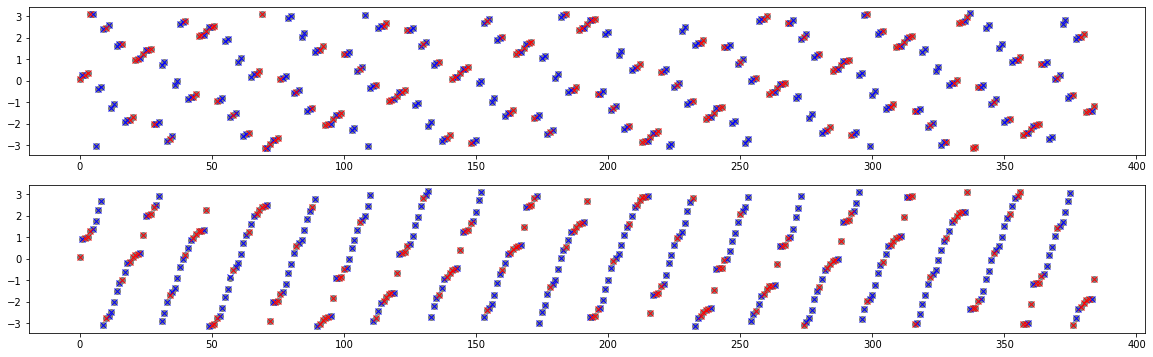

In [17]:
# Compare phases

plt.figure(figsize=(20, 2*3))

ax1 = plt.subplot(211)
ax1.scatter(range(model.size), fx_ref.cpu().numpy(), marker='o', color='gray')
ax1.errorbar(model.monitor_index, mod(twiss.fx[model.monitor_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(model.virtual_index, mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

ax2 = plt.subplot(212)
ax2.scatter(range(model.size), fy_ref.cpu().numpy(), marker='o', color='gray')
ax2.errorbar(model.monitor_index, mod(twiss.fy[model.monitor_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(model.virtual_index, mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi).cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')

plt.show()

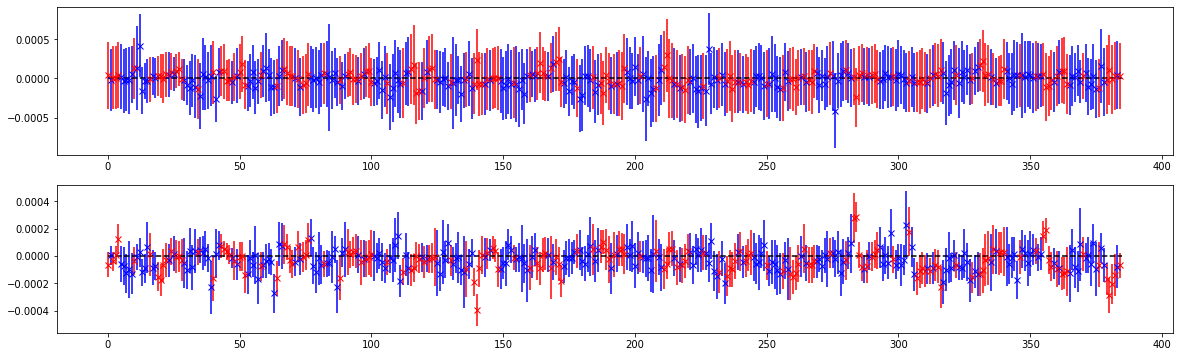

In [18]:
# Compare phases

plt.figure(figsize=(20, 2*3))

ax1 = plt.subplot(211)
ax1.errorbar(model.monitor_index, (fx_ref[model.monitor_index] - mod(twiss.fx[model.monitor_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fx[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax1.errorbar(model.virtual_index, (fx_ref[model.virtual_index] - mod(twiss.fx[model.virtual_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fx[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')
ax1.hlines(0, 0, model.size, linestyles='dashed', color='black')

ax2 = plt.subplot(212)
ax2.errorbar(model.monitor_index, (fy_ref[model.monitor_index] - mod(twiss.fy[model.monitor_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fy[model.monitor_index].cpu().numpy(), fmt=' ', marker='x', color='blue')
ax2.errorbar(model.virtual_index, (fy_ref[model.virtual_index] - mod(twiss.fy[model.virtual_index], 2.0*numpy.pi, -numpy.pi)).cpu().numpy(), yerr=twiss.sigma_fy[model.virtual_index].cpu().numpy(), fmt=' ', marker='x', color='red')
ax2.hlines(0, 0, model.size, linestyles='dashed', color='black')

plt.show()

In [19]:
%%time

# Estimate twiss

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 product=True,
                                 jacobian=False,
                                 count=256,
                                 fraction=0.75,
                                 ix=None,
                                 iy=None,
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)

torch.Size([224, 2, 10, 256])
CPU times: user 11min 53s, sys: 46.9 s, total: 12min 40s
Wall time: 18min 1s


In [20]:
# Process fitted invariants

ix, iy = data[:, 0, 0], data[:, 0, 1]
sigma_ix, sigma_iy = data[:, 1, 0], data[:, 1, 1]
invariant = twiss.get_invariant(ix, iy, sigma_ix, sigma_iy)

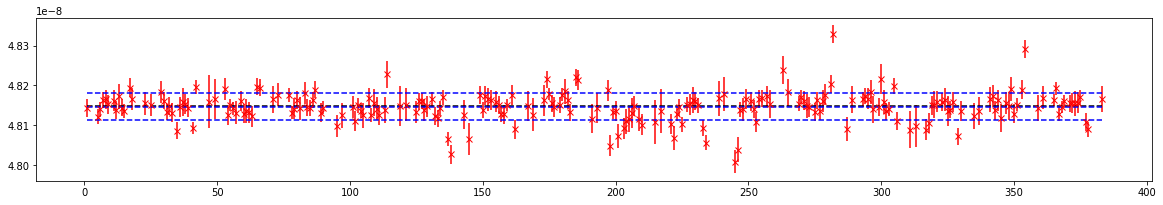

tensor(4.814831377020e-08, dtype=torch.float64)
tensor(4.814669491750e-08, dtype=torch.float64)
tensor(3.387566743184e-11, dtype=torch.float64)



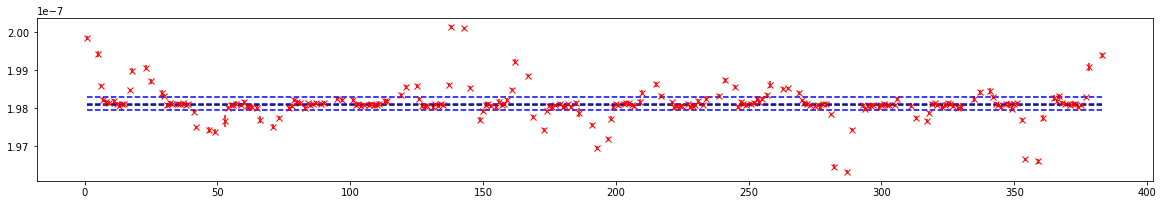

tensor(1.981004437395e-07, dtype=torch.float64)
tensor(1.981208078018e-07, dtype=torch.float64)
tensor(1.742335628959e-10, dtype=torch.float64)



In [21]:
# Plot invariants for each signal

plt.figure(figsize=(20, 3))
plt.errorbar(model.monitor_index, invariant['ix_center'].flatten().cpu().numpy(), yerr=invariant['ix_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_x, min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='black')
plt.hlines([invariant['ix_value'] - invariant['ix_error'], invariant['ix_value'], invariant['ix_value'] + invariant['ix_error']], min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='blue')
plt.show()

print(action_x)
print(invariant['ix_value'])
print(invariant['ix_error'])
print()

plt.figure(figsize=(20, 3))
plt.errorbar(model.monitor_index, invariant['iy_center'].flatten().cpu().numpy(), yerr=invariant['iy_spread'].flatten().cpu().numpy(), fmt=' ', color='red', marker='x')
plt.hlines(action_y, min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='black')
plt.hlines([invariant['iy_value'] - invariant['iy_error'], invariant['iy_value'], invariant['iy_value'] + invariant['iy_error']], min(model.monitor_index), max(model.monitor_index), linestyles='dashed', color='blue')
plt.show()

print(action_y)
print(invariant['iy_value'])
print(invariant['iy_error'])
print()

In [22]:
# Process twiss

mask = invariant['ix_mask']*invariant['sx_mask']*invariant['iy_mask']*invariant['sy_mask']

value, error = data.permute(1, 2, 0, -1)

*_, value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41 = value
*_, error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41 = error

value_n11, error_n11 = twiss.process(value_n11, error_n11, mask=mask)
value_n33, error_n33 = twiss.process(value_n33, error_n33, mask=mask)
value_n21, error_n21 = twiss.process(value_n21, error_n21, mask=mask)
value_n43, error_n43 = twiss.process(value_n43, error_n43, mask=mask)
value_n13, error_n13 = twiss.process(value_n13, error_n13, mask=mask)
value_n31, error_n31 = twiss.process(value_n31, error_n31, mask=mask)
value_n14, error_n14 = twiss.process(value_n14, error_n14, mask=mask)
value_n41, error_n41 = twiss.process(value_n41, error_n41, mask=mask)

In [23]:
%%time

# Estimate twiss (virtual)

from harmonica.parameterization import parametric_normal
data = twiss.get_twiss_from_data(1,
                                 256,
                                 parametric_normal,
                                 model.matrix,
                                 twiss=None,
                                 method='lstsq',
                                 limit=2,
                                 phony=True,
                                 product=True,
                                 jacobian=False,
                                 count=256,
                                 fraction=0.75,
                                 ix=invariant['ix_value'],
                                 iy=invariant['iy_value'],
                                 sigma=1.0E-3,
                                 n_jobs=6,
                                 verbose=False)
print(data.shape)
print(model.virtual_count)

torch.Size([161, 2, 8, 256])
161
CPU times: user 7min 53s, sys: 32.7 s, total: 8min 25s
Wall time: 10min 13s


In [24]:
# Process twiss

value, error = data.permute(1, 2, 0, -1)

*_, value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41 = value
*_, error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41 = error

value_v11, error_v11 = twiss.process(value_v11, error_v11)
value_v33, error_v33 = twiss.process(value_v33, error_v33)
value_v21, error_v21 = twiss.process(value_v21, error_v21)
value_v43, error_v43 = twiss.process(value_v43, error_v43)
value_v13, error_v13 = twiss.process(value_v13, error_v13)
value_v31, error_v31 = twiss.process(value_v31, error_v31)
value_v14, error_v14 = twiss.process(value_v14, error_v14)
value_v41, error_v41 = twiss.process(value_v41, error_v41)

In [25]:
# Compute twiss at all locations from normalization

from harmonica.parameterization import parametric_normal
from harmonica.parameterization import normal_to_wolski
from harmonica.parameterization import wolski_to_cs

value = torch.stack([value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41]).T
error = torch.stack([error_n11, error_n33, error_n21, error_n43, error_n13, error_n31, error_n14, error_n41]).T

cs_value, cs_error = [], []

for value_local, error_local in zip(value, error):
    table = value_local.reshape(-1, 1) + error_local.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax_m, value_bx_m, value_ay_m, value_by_m = cs_value.T
error_ax_m, error_bx_m, error_ay_m, error_by_m = cs_error.T

value = torch.stack([value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41]).T
error = torch.stack([error_v11, error_v33, error_v21, error_v43, error_v13, error_v31, error_v14, error_v41]).T

cs_value, cs_error = [], []

for value_local, error_local in zip(value, error):
    table = value_local.reshape(-1, 1) + error_local.reshape(-1, 1)*torch.randn(1024, dtype=dtype, device=device)
    table = torch.stack([parametric_normal(*free) for free in table.T])
    table = normal_to_wolski(table)
    table = torch.stack([wolski_to_cs(w) for w in table]).T
    cs_value.append(table.mean(-1))
    cs_error.append(table.std(-1))
    
cs_value = torch.stack(cs_value)
cs_error = torch.stack(cs_error)

value_ax_v, value_bx_v, value_ay_v, value_by_v = cs_value.T
error_ax_v, error_bx_v, error_ay_v, error_by_v = cs_error.T

In [26]:
# Set uncoupled

twiss.ax[model.monitor_index] = value_ax_m
twiss.bx[model.monitor_index] = value_bx_m
twiss.ay[model.monitor_index] = value_ay_m
twiss.by[model.monitor_index] = value_by_m

twiss.ax[model.virtual_index] = value_ax_v
twiss.bx[model.virtual_index] = value_bx_v
twiss.ay[model.virtual_index] = value_ay_v
twiss.by[model.virtual_index] = value_by_v

twiss.sigma_ax[model.monitor_index] = error_ax_m
twiss.sigma_bx[model.monitor_index] = error_bx_m
twiss.sigma_ay[model.monitor_index] = error_ay_m
twiss.sigma_by[model.monitor_index] = error_by_m

twiss.sigma_ax[model.virtual_index] = error_ax_v
twiss.sigma_bx[model.virtual_index] = error_bx_v
twiss.sigma_ay[model.virtual_index] = error_ay_v
twiss.sigma_by[model.virtual_index] = error_by_v

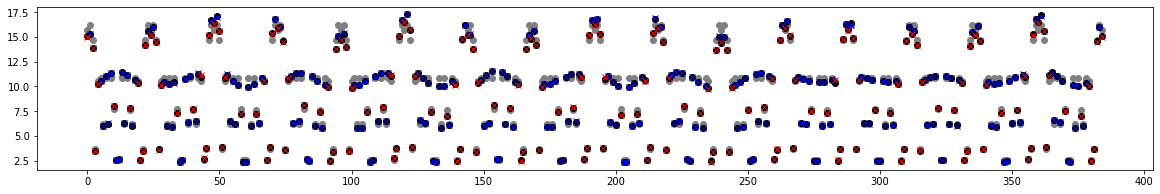

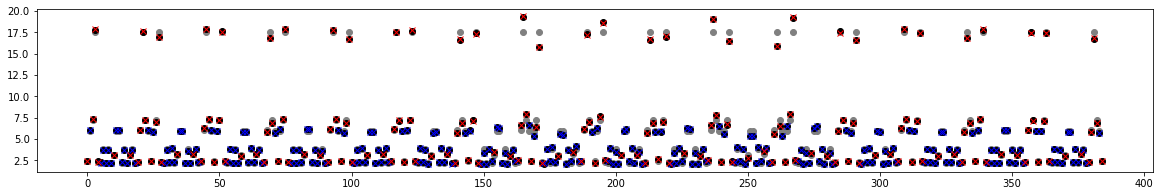

tensor(2.221554875790e-01, dtype=torch.float64)
tensor(3.186469491916e-01, dtype=torch.float64)

tensor(2.372482980516e-02, dtype=torch.float64)
tensor(3.408277473974e-01, dtype=torch.float64)



In [27]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.bx, color='gray', marker='o')
plt.scatter(range(model.size), BX, color='black', marker='o')
plt.errorbar(model.monitor_index, value_bx_m, yerr=error_bx_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_bx_v, yerr=error_bx_v, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.by, color='gray', marker='o')
plt.scatter(range(model.size), BY, color='black', marker='o')
plt.errorbar(model.monitor_index, value_by_m, yerr=error_by_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_by_v, yerr=error_by_v, fmt=' ', color='red', marker='x')
plt.show()

print((BX[model.monitor_index] - value_bx_m).sum().abs())
print((BX[model.virtual_index] - value_bx_v).sum().abs())
print()

print((BY[model.monitor_index] - value_by_m).sum().abs())
print((BY[model.virtual_index] - value_by_v).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

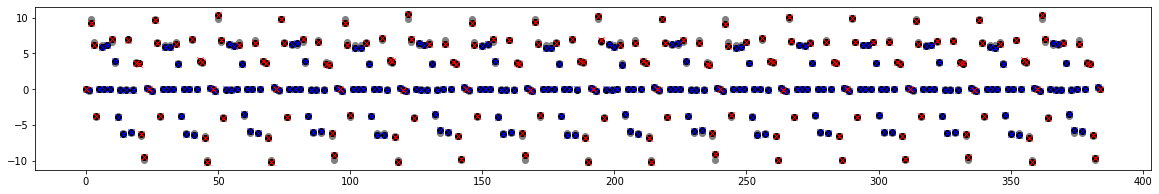

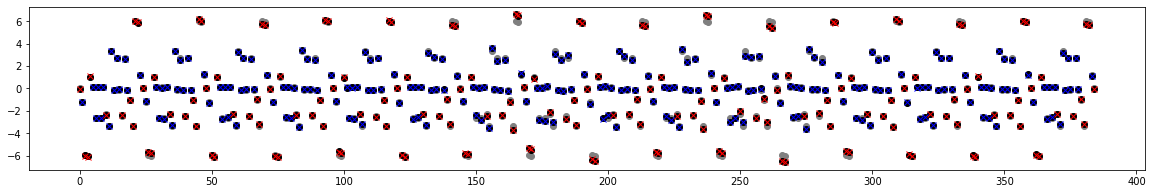

tensor(4.128175505151e-03, dtype=torch.float64)
tensor(2.554401887121e-01, dtype=torch.float64)

tensor(4.707986743766e-02, dtype=torch.float64)
tensor(1.182278978401e-02, dtype=torch.float64)



In [28]:
# Compare twiss

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ax, color='gray', marker='o')
plt.scatter(range(model.size), AX, color='black', marker='o')
plt.errorbar(model.monitor_index, value_ax_m, yerr=error_ax_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ax_v, yerr=error_ax_v, fmt=' ', color='red', marker='x')
plt.show()

plt.figure(figsize=(20, 3))
plt.scatter(range(model.size), model.ay, color='gray', marker='o')
plt.scatter(range(model.size), AY, color='black', marker='o')
plt.errorbar(model.monitor_index, value_ay_m, yerr=error_ay_m, fmt=' ', color='blue', marker='x')
plt.errorbar(model.virtual_index, value_ay_v, yerr=error_ay_v, fmt=' ', color='red', marker='x')
plt.show()

print((AX[model.monitor_index] - value_ax_m).sum().abs())
print((AX[model.virtual_index] - value_ax_v).sum().abs())
print()

print((AY[model.monitor_index] - value_ay_m).sum().abs())
print((AY[model.virtual_index] - value_ay_v).sum().abs())
print()

# gray  -- model values
# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

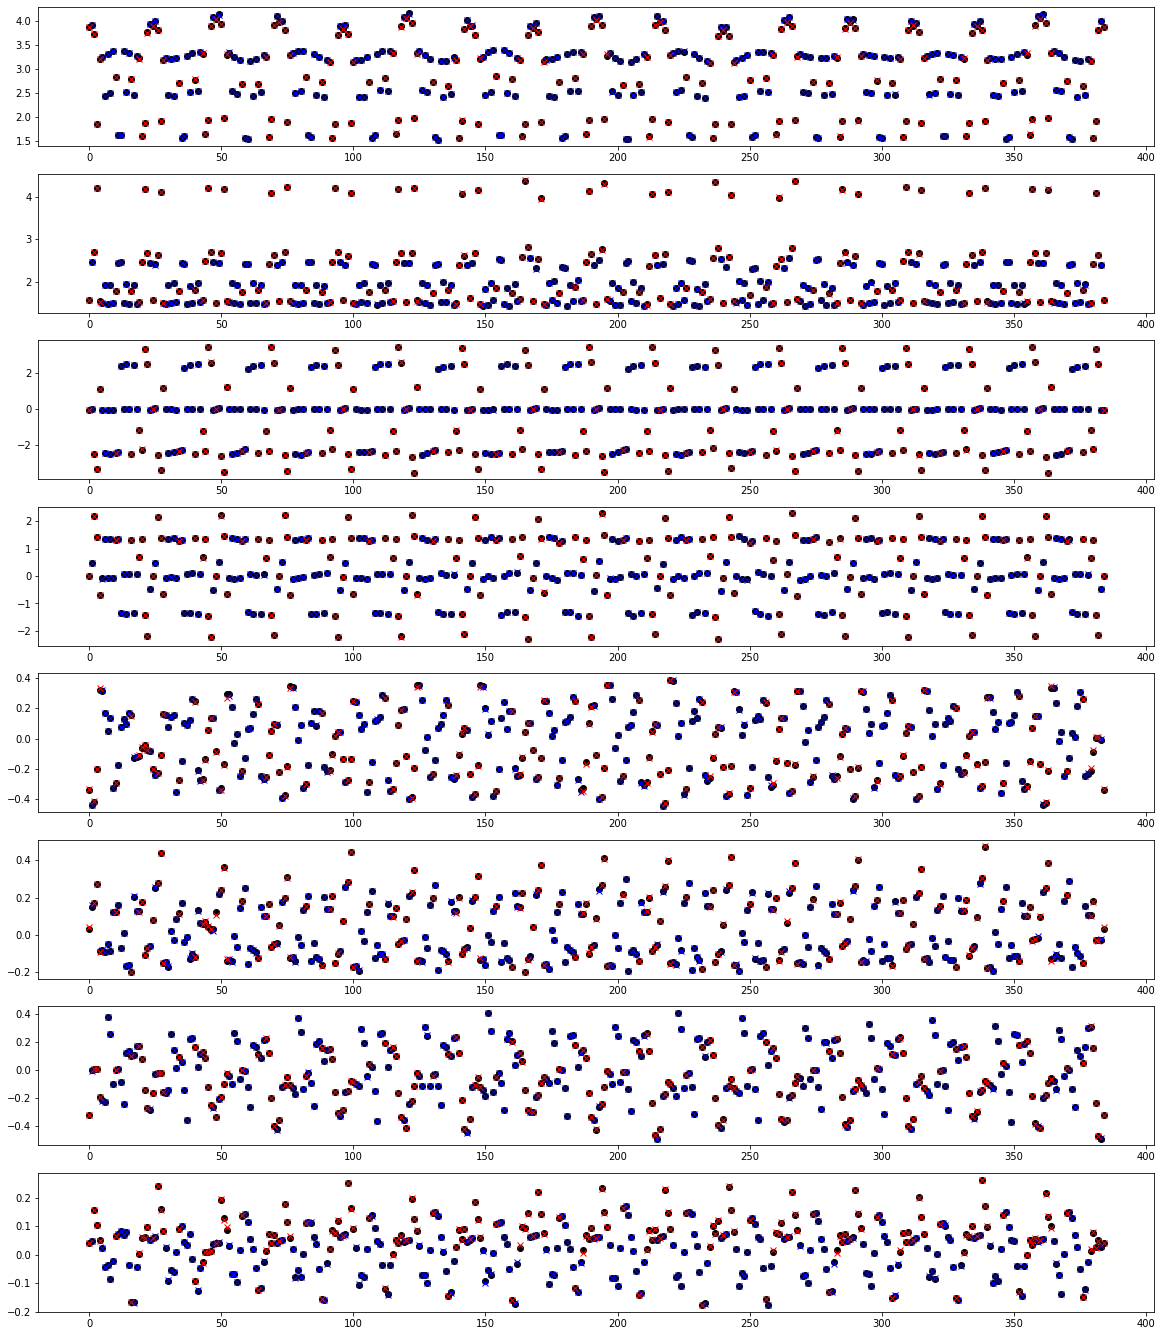

In [29]:
# Compare normalization matrix elements

plt.figure(figsize=(20, 8*3))

ax = plt.subplot(811)
ax.scatter(range(model.size), N11, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n11, yerr=error_n11, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v11, yerr=error_v11, fmt=' ', color='red', marker='x')

ax = plt.subplot(812)
ax.scatter(range(model.size), N33, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n33, yerr=error_n33, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v33, yerr=error_v33, fmt=' ', color='red', marker='x')

ax = plt.subplot(813)
ax.scatter(range(model.size), N21, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n21, yerr=error_n21, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v21, yerr=error_v21, fmt=' ', color='red', marker='x')

ax = plt.subplot(814)
ax.scatter(range(model.size), N43, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n43, yerr=error_n43, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v43, yerr=error_v43, fmt=' ', color='red', marker='x')

ax = plt.subplot(815)
ax.scatter(range(model.size), N13, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n13, yerr=error_n13, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v13, yerr=error_v13, fmt=' ', color='red', marker='x')

ax = plt.subplot(816)
ax.scatter(range(model.size), N31, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n31, yerr=error_n31, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v31, yerr=error_v31, fmt=' ', color='red', marker='x')

ax = plt.subplot(817)
ax.scatter(range(model.size), N14, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n14, yerr=error_n14, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v14, yerr=error_v14, fmt=' ', color='red', marker='x')

ax = plt.subplot(818)
ax.scatter(range(model.size), N41, color='black', marker='o')
ax.errorbar(model.monitor_index, value_n41, yerr=error_n41, fmt=' ', color='blue', marker='x')
ax.errorbar(model.virtual_index, value_v41, yerr=error_v41, fmt=' ', color='red', marker='x')

plt.show()

# black -- true values
# blue  -- monitor locations
# red   -- virtual locations

In [30]:
# Set normal at monitor locations

from harmonica.parameterization import parametric_normal
for index, (n11, n33, n21, n43, n13, n31, n14, n41) in enumerate(zip(value_n11, value_n33, value_n21, value_n43, value_n13, value_n31, value_n14, value_n41)):
    index = model.monitor_index[index]
    normal = parametric_normal(n11, n33, n21, n43, n13, n31, n14, n41, dtype=dtype)
    twiss.normal[index] = normal

# Set normal at virtual locations

from harmonica.parameterization import parametric_normal
for index, (n11, n33, n21, n43, n13, n31, n14, n41) in enumerate(zip(value_v11, value_v33, value_v21, value_v43, value_v13, value_v31, value_v14, value_v41)):
    index = model.virtual_index[index]
    normal = parametric_normal(n11, n33, n21, n43, n13, n31, n14, n41, dtype=dtype)
    twiss.normal[index] = normal

In [31]:
# Compute responce matrix using model transport

responce_model = model.make_responce(lc, lm, model.matrix)

In [32]:
# Compute responce matrix using error transport

responce_error = model.make_responce(lc, lm, model.matrix_transport)

In [33]:
# Compute responce matrix using virtual transport
# twiss.matrix or twiss.matrix_virtual

model.model = 'coupled'
responce_twiss = model.make_responce(lc, lm, twiss.matrix)

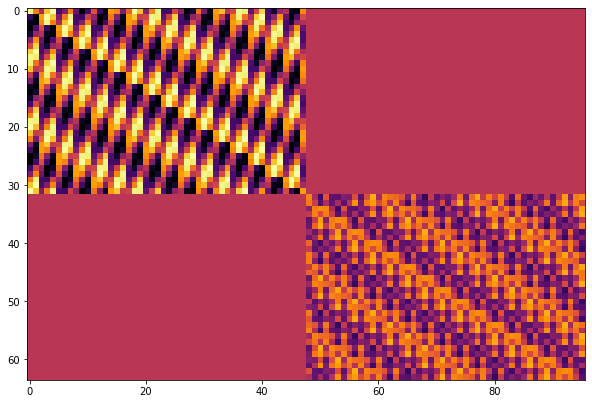

In [34]:
# Plot responce matrix (model)

plt.figure(figsize=(10, 10))
plt.imshow(responce_model.cpu().numpy(), cmap='inferno')
plt.show()

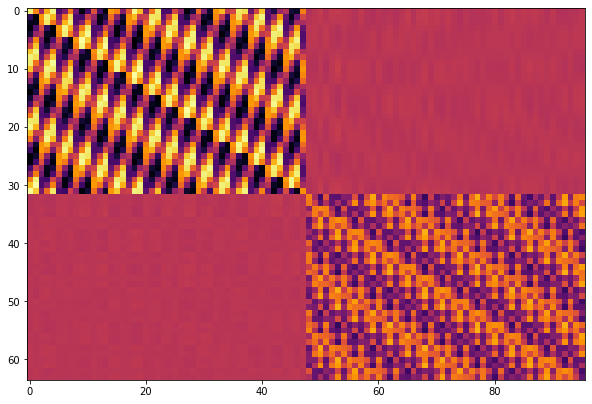

In [35]:
# Plot responce matrix (error)

plt.figure(figsize=(10, 10))
plt.imshow(responce_error.cpu().numpy(), cmap='inferno')
plt.show()

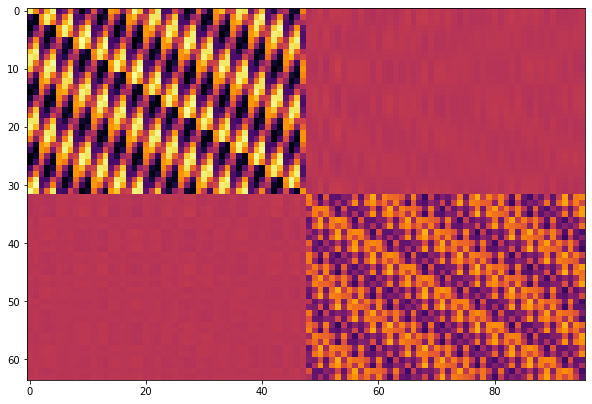

In [36]:
# Plot responce matrix (twiss)

plt.figure(figsize=(10, 10))
plt.imshow(responce_twiss.cpu().numpy(), cmap='inferno')
plt.show()

In [37]:
# Compare matrix norm

print(torch.linalg.matrix_norm(responce_error - responce_model))
print(torch.linalg.matrix_norm(responce_error - responce_twiss))

tensor(1.829239103794e+01, dtype=torch.float64)
tensor(9.122584342256e-01, dtype=torch.float64)


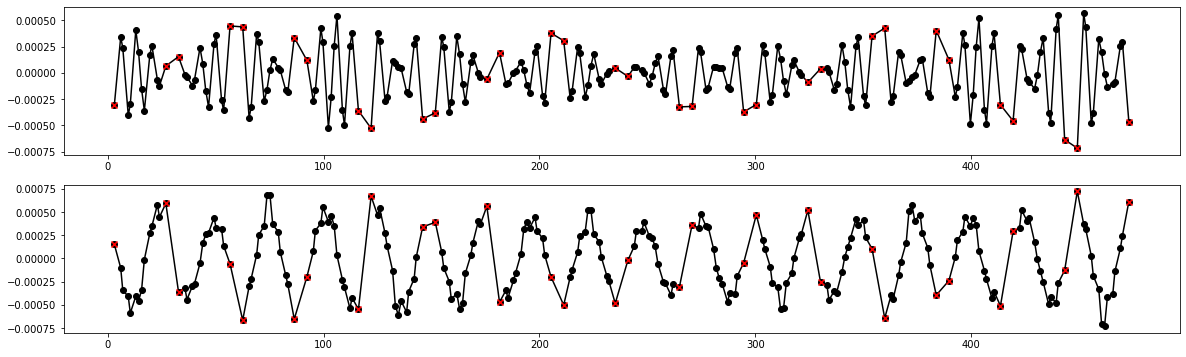

In [38]:
# Plot orbit at monitors with errors

# black -- orbit at all monitors
# red   -- orbit at ID monitors

x, _, y, _ = torch.clone(model.orbit.T)

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)

plt.show()

In [39]:
# Set fast correctors using model responce matrix

ax, ay = (torch.linalg.pinv(responce_model) @ torch.cat([x[lm], y[lm]])).reshape(-1, len(lc))
cx[lc] = -ax
cy[lc] = -ay

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)
model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

x_model, _, y_model, _ = torch.clone(model.orbit.T)

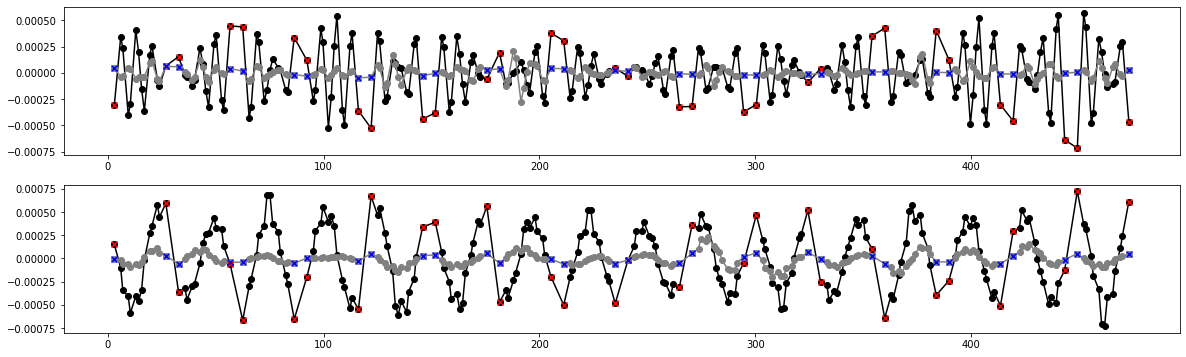

In [40]:
# Compare orbits

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x_model[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_model[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y_model[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_model[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

plt.show()

In [41]:
# Set fast correctors using error responce matrix

ax, ay = (torch.linalg.pinv(responce_error) @ torch.cat([x[lm], y[lm]])).reshape(-1, len(lc))
cx[lc] = -ax
cy[lc] = -ay

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)
model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

x_error, _, y_error, _ = torch.clone(model.orbit.T)

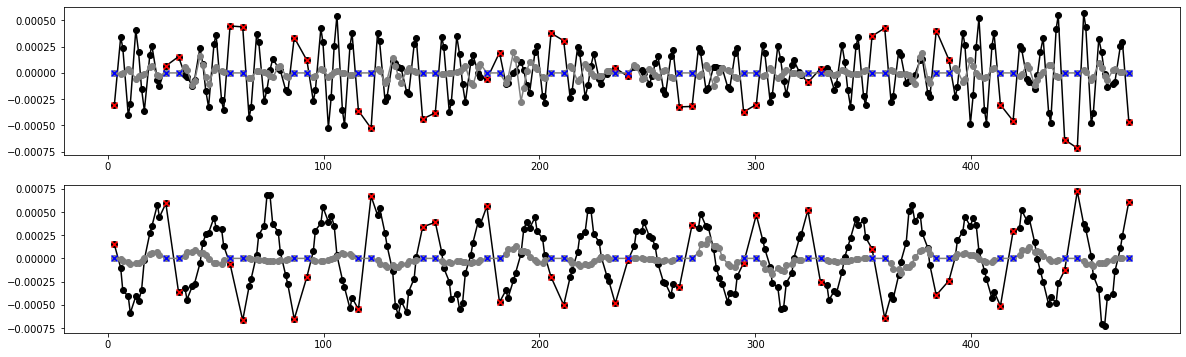

In [42]:
# Compare orbits

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x_error[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_error[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y_error[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_error[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

plt.show()

In [43]:
# Set fast correctors using twiss responce matrix

ax, ay = (torch.linalg.pinv(responce_twiss) @ torch.cat([x[lm], y[lm]])).reshape(-1, len(lc))
cx[lc] = -ax
cy[lc] = -ay

model.make_error(kn, ks, length=kl, angle_x=cx, angle_y=cy)
model.make_transport(error=True, exact=False, method='BFGS', tol=1.0E-12)

x_twiss, _, y_twiss, _ = torch.clone(model.orbit.T)

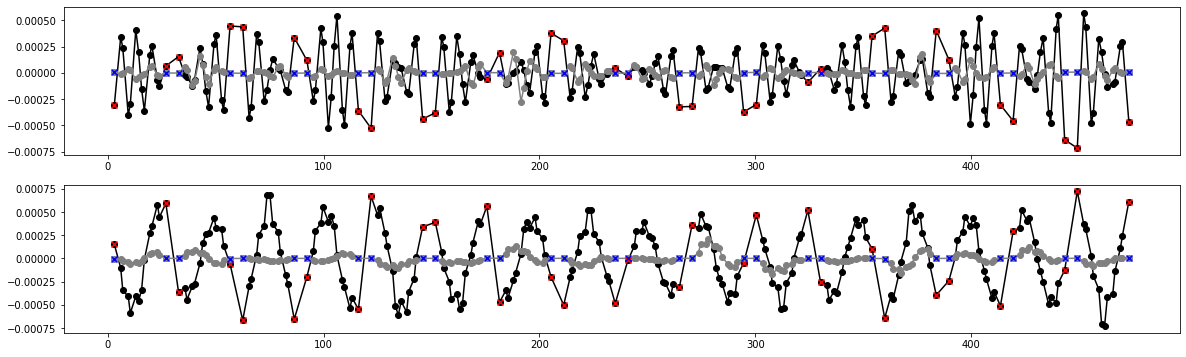

In [44]:
# Compare orbits

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), x_twiss[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_twiss[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

ax = plt.subplot(212)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y[model.monitor_index].cpu().numpy(), color='black', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y[lm].cpu().numpy(), color='red', marker='x', zorder=1)
ax.plot(model.time[model.monitor_index].cpu().numpy(), y_twiss[model.monitor_index].cpu().numpy(), color='gray', marker='o', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_twiss[lm].cpu().numpy(), color='blue', marker='x', zorder=1)

plt.show()

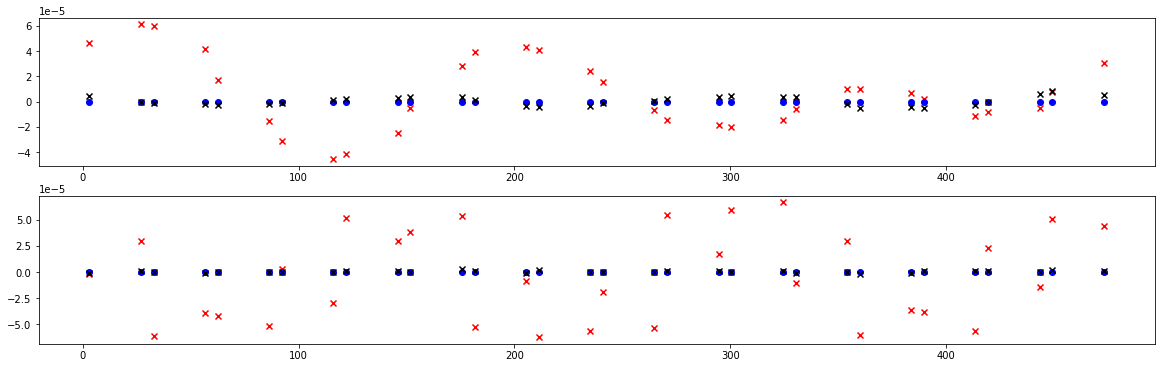

tensor(9.931144859659e-03, dtype=torch.float64)
tensor(7.509808532325e-04, dtype=torch.float64)
tensor(7.812226642144e-16, dtype=torch.float64)
tensor(9.738393742262e-05, dtype=torch.float64)

tensor(1.248567859251e-02, dtype=torch.float64)
tensor(1.240912952932e-03, dtype=torch.float64)
tensor(2.592808003468e-16, dtype=torch.float64)
tensor(2.420815823913e-05, dtype=torch.float64)



In [45]:
# Compare corrected orbits at ID monitors

plt.figure(figsize=(20, 2*3))

ax = plt.subplot(211)
ax.scatter(model.time[lm].cpu().numpy(), x_model[lm].cpu().numpy(), color='red', marker='x', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), x_error[lm].cpu().numpy(), color='blue', marker='o', zorder=1)
ax.scatter(model.time[lm].cpu().numpy(), x_twiss[lm].cpu().numpy(), color='black', marker='x', zorder=2)

ax = plt.subplot(212)
ax.scatter(model.time[lm].cpu().numpy(), y_model[lm].cpu().numpy(), color='red', marker='x', zorder=0)
ax.scatter(model.time[lm].cpu().numpy(), y_error[lm].cpu().numpy(), color='blue', marker='o', zorder=1)
ax.scatter(model.time[lm].cpu().numpy(), y_twiss[lm].cpu().numpy(), color='black', marker='x', zorder=2)

plt.show()

print(x[lm].abs().sum())
print(x_model[lm].abs().sum())
print(x_error[lm].abs().sum())
print(x_twiss[lm].abs().sum())
print()

print(y[lm].abs().sum())
print(y_model[lm].abs().sum())
print(y_error[lm].abs().sum())
print(y_twiss[lm].abs().sum())
print()